In [25]:
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from keras.layers import Dense
import pandas as pd

from tensorflow.keras.utils import image_dataset_from_directory

path = r"C:\Users\marca\OneDrive\Documentos\6 semestre neuro\Neurociencias-2025-2\S03_datasets\Brain_tumor\Brain_tumor"

In [43]:
df = pd.read_csv(r"C:\Users\marca\OneDrive\Documentos\6 semestre neuro\Neurociencias-2025-2\S03_datasets\Brain_tumor\Brain Tumor.csv")
df['Image'] = df['Image'].apply(lambda x: f"{x}.jpg" if not x.lower().endswith('.jpg') else x)

train_df = r"C:\Users\marca\OneDrive\Documentos\6 semestre neuro\Neurociencias-2025-2\S03_datasets\Brain_tumor\TRAIN"
test_df = r"C:\Users\marca\OneDrive\Documentos\6 semestre neuro\Neurociencias-2025-2\S03_datasets\Brain_tumor\TEST"

import os
def filter_df(directory, df):
    available_files = set(os.listdir(directory))  
    return df[df['Image'].isin(available_files)].copy()

train = filter_df(train_df, df)
test = filter_df(test_df, df)

train['Class'] = train['Class'].astype(str)
test['Class'] = test['Class'].astype(str)

print(len(train), len(test))

2633 564


Found 2633 validated image filenames belonging to 2 classes.
Found 564 validated image filenames belonging to 2 classes.
Epoch 1/30


132/132 [==============================] - 119s 887ms/step - loss: 0.5002 - accuracy: 0.7668 - val_loss: 0.6697 - val_accuracy: 0.6472
Epoch 2/30
132/132 [==============================] - 90s 681ms/step - loss: 0.3809 - accuracy: 0.8371 - val_loss: 0.3494 - val_accuracy: 0.8511
Epoch 3/30
132/132 [==============================] - 91s 690ms/step - loss: 0.3365 - accuracy: 0.8583 - val_loss: 0.3061 - val_accuracy: 0.8830
Epoch 4/30
132/132 [==============================] - 91s 684ms/step - loss: 0.3002 - accuracy: 0.8743 - val_loss: 0.3796 - val_accuracy: 0.8262
Epoch 5/30
132/132 [==============================] - 91s 688ms/step - loss: 0.2863 - accuracy: 0.8876 - val_loss: 0.4435 - val_accuracy: 0.7996
Epoch 6/30
132/132 [==============================] - 95s 715ms/step - loss: 0.2494 - accuracy: 0.8971 - val_loss: 0.2237 - val_accuracy: 0.9113
Epoch 

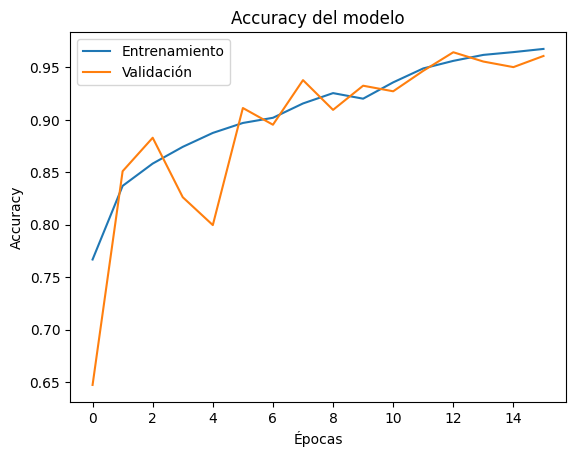

In [59]:
# Generadores con aumento de datos
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

test_datagen = ImageDataGenerator(rescale=1./255)

# Paths
train_path = r"C:\Users\marca\OneDrive\Documentos\6 semestre neuro\Neurociencias-2025-2\S03_datasets\Brain_tumor\TRAIN"
test_path = r"C:\Users\marca\OneDrive\Documentos\6 semestre neuro\Neurociencias-2025-2\S03_datasets\Brain_tumor\TEST"

# Generadores desde dataframe
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train,
    directory=train_path,
    x_col="Image",
    y_col="Class",
    target_size=(256, 256),
    batch_size=20,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_dataframe(
    dataframe=test,
    directory=test_path,
    x_col="Image",
    y_col="Class",
    target_size=(256, 256),
    batch_size=20,
    class_mode='categorical'
)

num_classes = len(train_generator.class_indices)

# Modelo
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(256, 256, 3)),
    MaxPooling2D(2, 2),
    
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    
    Flatten(),
    Dropout(0.3),
    Dense(128, activation='relu'),
    Dense(num_classes, activation='softmax')
])

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Early stopping
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Entrenamiento
history = model.fit(
    train_generator,
    epochs=30,
    validation_data=test_generator,
    callbacks=[early_stop]
)

# Evaluación
loss, accuracy = model.evaluate(test_generator)
print(f"Precisión en test: {accuracy:.2%}")

# Gráfica
plt.plot(history.history['accuracy'], label='Entrenamiento')
plt.plot(history.history['val_accuracy'], label='Validación')
plt.xlabel('Épocas')
plt.ylabel('Accuracy')
plt.legend()
plt.title("Accuracy del modelo")
plt.show()

Found 564 validated image filenames belonging to 2 classes.
29/29 [==============================] - 3s 98ms/step
Reporte de clasificación:

              precision    recall  f1-score   support

           0       0.96      0.98      0.97       302
           1       0.97      0.95      0.96       262

    accuracy                           0.96       564
   macro avg       0.97      0.96      0.96       564
weighted avg       0.96      0.96      0.96       564



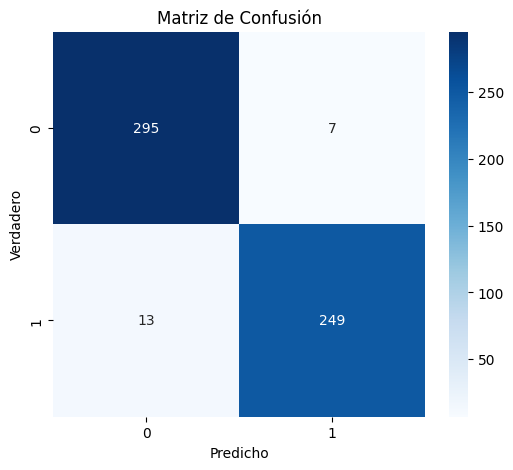

In [63]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# Re-crear el generador de prueba con shuffle=False
test_generator = test_datagen.flow_from_dataframe(
    dataframe=test,
    directory=test_path,
    x_col="Image",
    y_col="Class",
    target_size=(256, 256),
    batch_size=20,
    class_mode='categorical',
    shuffle=False  # 🔍 Importante para mantener el orden
)

# Obtener predicciones
Y_pred = model.predict(test_generator)
y_pred = np.argmax(Y_pred, axis=1)

# Obtener las etiquetas verdaderas
y_true = test_generator.classes

# Etiquetas en orden
class_labels = list(test_generator.class_indices.keys())

# Reporte de clasificación
print("Reporte de clasificación:\n")
print(classification_report(y_true, y_pred, target_names=class_labels))

# Matriz de confusión
cm = confusion_matrix(y_true, y_pred)

# Visualizar matriz de confusión
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicho')
plt.ylabel('Verdadero')
plt.title('Matriz de Confusión')
plt.show()

Ya tenemos buenos resultados, pero veremos si podemos mejorarlos

Epoch 1/30
132/132 [==============================] - 105s 776ms/step - loss: 1.0470 - accuracy: 0.8143 - val_loss: 1.7219 - val_accuracy: 0.5727 - lr: 0.0010
Epoch 2/30
132/132 [==============================] - 92s 699ms/step - loss: 0.3480 - accuracy: 0.8466 - val_loss: 4.5857 - val_accuracy: 0.5213 - lr: 0.0010
Epoch 3/30
132/132 [==============================] - 102s 770ms/step - loss: 0.2965 - accuracy: 0.8720 - val_loss: 1.7892 - val_accuracy: 0.5727 - lr: 0.0010
Epoch 4/30
132/132 [==============================] - 113s 852ms/step - loss: 0.2868 - accuracy: 0.8834 - val_loss: 1.1006 - val_accuracy: 0.6489 - lr: 0.0010
Epoch 5/30
132/132 [==============================] - 117s 883ms/step - loss: 0.2802 - accuracy: 0.8883 - val_loss: 0.5282 - val_accuracy: 0.7553 - lr: 0.0010
Epoch 6/30
132/132 [==============================] - 117s 890ms/step - loss: 0.2797 - accuracy: 0.8921 - val_loss: 0.4477 - val_accuracy: 0.8174 - lr: 0.0010
Epoch 7/30
132/132 [===========================

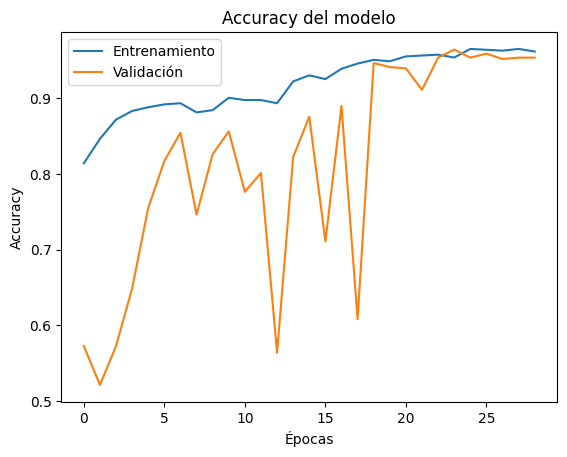

29/29 [==============================] - 4s 141ms/step
              precision    recall  f1-score   support

           0       0.97      0.97      0.97       302
           1       0.96      0.96      0.96       262

    accuracy                           0.96       564
   macro avg       0.96      0.96      0.96       564
weighted avg       0.96      0.96      0.96       564



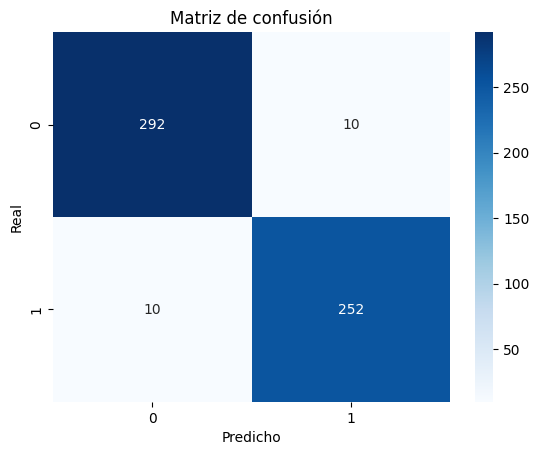

In [81]:
from sklearn.utils import class_weight
#Class weights para corregir el desbalance de clases 
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train['Class']),
    y=train['Class']
)
class_weights = dict(enumerate(class_weights))

# Más capas para red más profunda + Batchnormalization + incremento de dropout para disminuir overfitting
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(256, 256, 3)),
    BatchNormalization(),
    MaxPooling2D(2, 2),

    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2, 2),

    Conv2D(128, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2, 2),

    Conv2D(128, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2, 2),

    Flatten(),
    Dropout(0.5),
    Dense(256, activation='relu'),
    Dense(num_classes, activation='softmax')
])

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3)

history = model.fit(
    train_generator,
    epochs=30,
    validation_data=test_generator,
    class_weight=class_weights,
    callbacks=[early_stop, reduce_lr]
)

loss, acc = model.evaluate(test_generator)
print(f"Precisión en test: {acc:.2%}")

plt.plot(history.history['accuracy'], label='Entrenamiento')
plt.plot(history.history['val_accuracy'], label='Validación')
plt.xlabel("Épocas")
plt.ylabel("Accuracy")
plt.title("Accuracy del modelo")
plt.legend()
plt.show()

y_pred = model.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = test_generator.classes

print(classification_report(y_true, y_pred_classes))

cm = confusion_matrix(y_true, y_pred_classes)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicho")
plt.ylabel("Real")
plt.title("Matriz de confusión")
plt.show()

Los resultados en realidad son muy estables. Pero las modificaciones le dan mas robustez al modelo para que pueda analizar imágenes nuevas que no formen parte de los grupos de train y test

In [92]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.vgg16 import preprocess_input
from sklearn.model_selection import train_test_split
import numpy as np
import os
from tqdm import tqdm

vgg_model = VGG16(weights='imagenet', include_top=False, input_shape=(256, 256, 3))

def extract_features(dataframe, path):
    features = []
    labels = []
    for i, row in tqdm(dataframe.iterrows(), total=len(dataframe)):
        img_path = os.path.join(path, row['Image'])
        image = load_img(img_path, target_size=(256, 256))
        image = img_to_array(image)
        image = np.expand_dims(image, axis=0)
        image = preprocess_input(image)

        feature = vgg_model.predict(image)
        features.append(feature.flatten())
        labels.append(row['Class'])
    
    return np.array(features), np.array(labels)

X_train, y_train = extract_features(train, train_path)
X_test, y_test = extract_features(test, test_path)

  0%|                                                                                         | 0/2633 [00:00<?, ?it/s]

1/1 [==============================] - 0s 310ms/step


  0%|                                                                                 | 1/2633 [00:00<19:10,  2.29it/s]

1/1 [==============================] - 0s 143ms/step


  0%|                                                                                 | 2/2633 [00:00<13:28,  3.25it/s]

1/1 [==============================] - 0s 138ms/step


  0%|                                                                                 | 3/2633 [00:00<11:26,  3.83it/s]

1/1 [==============================] - 0s 140ms/step


  0%|                                                                                 | 4/2633 [00:01<10:30,  4.17it/s]

1/1 [==============================] - 0s 143ms/step


  0%|▏                                                                                | 5/2633 [00:01<10:05,  4.34it/s]

1/1 [==============================] - 0s 145ms/step


  0%|▏                                                                                | 6/2633 [00:01<09:50,  4.45it/s]

1/1 [==============================] - 0s 139ms/step


  0%|▏                                                                                | 7/2633 [00:01<09:29,  4.61it/s]

1/1 [==============================] - 0s 146ms/step


  0%|▏                                                                                | 8/2633 [00:01<09:27,  4.62it/s]

1/1 [==============================] - 0s 149ms/step


  0%|▎                                                                                | 9/2633 [00:02<09:46,  4.47it/s]

1/1 [==============================] - 0s 140ms/step


  0%|▎                                                                               | 10/2633 [00:02<09:37,  4.55it/s]

1/1 [==============================] - 0s 135ms/step


  0%|▎                                                                               | 11/2633 [00:02<09:32,  4.58it/s]

1/1 [==============================] - 0s 131ms/step


  0%|▎                                                                               | 12/2633 [00:02<09:22,  4.66it/s]

1/1 [==============================] - 0s 137ms/step


  0%|▍                                                                               | 13/2633 [00:02<09:10,  4.76it/s]

1/1 [==============================] - 0s 127ms/step


  1%|▍                                                                               | 14/2633 [00:03<08:51,  4.93it/s]

1/1 [==============================] - 0s 129ms/step


  1%|▍                                                                               | 15/2633 [00:03<08:36,  5.07it/s]

1/1 [==============================] - 0s 134ms/step


  1%|▍                                                                               | 16/2633 [00:03<08:39,  5.03it/s]

1/1 [==============================] - 0s 144ms/step


  1%|▌                                                                               | 17/2633 [00:03<08:54,  4.90it/s]

1/1 [==============================] - 0s 134ms/step


  1%|▌                                                                               | 18/2633 [00:03<08:51,  4.92it/s]

1/1 [==============================] - 0s 147ms/step


  1%|▌                                                                               | 19/2633 [00:04<09:13,  4.72it/s]

1/1 [==============================] - 0s 154ms/step


  1%|▌                                                                               | 20/2633 [00:04<09:30,  4.58it/s]

1/1 [==============================] - 0s 137ms/step


  1%|▋                                                                               | 21/2633 [00:04<09:25,  4.62it/s]

1/1 [==============================] - 0s 132ms/step


  1%|▋                                                                               | 22/2633 [00:04<09:19,  4.67it/s]

1/1 [==============================] - 0s 200ms/step


  1%|▋                                                                               | 23/2633 [00:05<10:17,  4.23it/s]

1/1 [==============================] - 0s 206ms/step


  1%|▋                                                                               | 24/2633 [00:05<11:13,  3.87it/s]

1/1 [==============================] - 0s 174ms/step


  1%|▊                                                                               | 25/2633 [00:05<11:44,  3.70it/s]

1/1 [==============================] - 0s 147ms/step


  1%|▊                                                                               | 26/2633 [00:05<11:16,  3.85it/s]

1/1 [==============================] - 0s 141ms/step


  1%|▊                                                                               | 27/2633 [00:06<10:36,  4.10it/s]

1/1 [==============================] - 0s 138ms/step


  1%|▊                                                                               | 28/2633 [00:06<09:59,  4.35it/s]

1/1 [==============================] - 0s 137ms/step


  1%|▉                                                                               | 29/2633 [00:06<09:39,  4.49it/s]

1/1 [==============================] - 0s 137ms/step


  1%|▉                                                                               | 30/2633 [00:06<09:17,  4.67it/s]

1/1 [==============================] - 0s 136ms/step


  1%|▉                                                                               | 31/2633 [00:06<09:03,  4.79it/s]

1/1 [==============================] - 0s 138ms/step


  1%|▉                                                                               | 32/2633 [00:07<09:01,  4.81it/s]

1/1 [==============================] - 0s 135ms/step


  1%|█                                                                               | 33/2633 [00:07<08:56,  4.85it/s]

1/1 [==============================] - 0s 142ms/step


  1%|█                                                                               | 34/2633 [00:07<08:48,  4.92it/s]

1/1 [==============================] - 0s 133ms/step


  1%|█                                                                               | 35/2633 [00:07<08:43,  4.96it/s]

1/1 [==============================] - 0s 146ms/step


  1%|█                                                                               | 36/2633 [00:07<08:47,  4.93it/s]

1/1 [==============================] - 0s 145ms/step


  1%|█                                                                               | 37/2633 [00:08<08:49,  4.90it/s]

1/1 [==============================] - 0s 160ms/step


  1%|█▏                                                                              | 38/2633 [00:08<09:01,  4.79it/s]

1/1 [==============================] - 0s 143ms/step


  1%|█▏                                                                              | 39/2633 [00:08<09:04,  4.77it/s]

1/1 [==============================] - 0s 152ms/step


  2%|█▏                                                                              | 40/2633 [00:08<09:17,  4.65it/s]

1/1 [==============================] - 0s 145ms/step


  2%|█▏                                                                              | 41/2633 [00:09<09:13,  4.68it/s]

1/1 [==============================] - 0s 136ms/step


  2%|█▎                                                                              | 42/2633 [00:09<08:59,  4.81it/s]

1/1 [==============================] - 0s 142ms/step


  2%|█▎                                                                              | 43/2633 [00:09<08:57,  4.82it/s]

1/1 [==============================] - 0s 141ms/step


  2%|█▎                                                                              | 44/2633 [00:09<08:56,  4.83it/s]

1/1 [==============================] - 0s 132ms/step


  2%|█▎                                                                              | 45/2633 [00:09<08:45,  4.93it/s]

1/1 [==============================] - 0s 136ms/step


  2%|█▍                                                                              | 46/2633 [00:10<08:37,  5.00it/s]

1/1 [==============================] - 0s 136ms/step


  2%|█▍                                                                              | 47/2633 [00:10<08:31,  5.06it/s]

1/1 [==============================] - 0s 132ms/step


  2%|█▍                                                                              | 48/2633 [00:10<08:23,  5.13it/s]

1/1 [==============================] - 0s 135ms/step


  2%|█▍                                                                              | 49/2633 [00:10<08:19,  5.18it/s]

1/1 [==============================] - 0s 136ms/step


  2%|█▌                                                                              | 50/2633 [00:10<08:18,  5.18it/s]

1/1 [==============================] - 0s 133ms/step


  2%|█▌                                                                              | 51/2633 [00:11<08:10,  5.27it/s]

1/1 [==============================] - 0s 134ms/step


  2%|█▌                                                                              | 52/2633 [00:11<08:13,  5.23it/s]

1/1 [==============================] - 0s 135ms/step


  2%|█▌                                                                              | 53/2633 [00:11<08:13,  5.22it/s]

1/1 [==============================] - 0s 136ms/step


  2%|█▋                                                                              | 54/2633 [00:11<08:07,  5.29it/s]

1/1 [==============================] - 0s 134ms/step


  2%|█▋                                                                              | 55/2633 [00:11<08:14,  5.21it/s]

1/1 [==============================] - 0s 135ms/step


  2%|█▋                                                                              | 56/2633 [00:11<08:14,  5.21it/s]

1/1 [==============================] - 0s 135ms/step


  2%|█▋                                                                              | 57/2633 [00:12<08:14,  5.21it/s]

1/1 [==============================] - 0s 143ms/step


  2%|█▊                                                                              | 58/2633 [00:12<08:26,  5.08it/s]

1/1 [==============================] - 0s 142ms/step


  2%|█▊                                                                              | 59/2633 [00:12<08:28,  5.06it/s]

1/1 [==============================] - 0s 145ms/step


  2%|█▊                                                                              | 60/2633 [00:12<08:37,  4.97it/s]

1/1 [==============================] - 0s 151ms/step


  2%|█▊                                                                              | 61/2633 [00:12<08:39,  4.95it/s]

1/1 [==============================] - 0s 152ms/step


  2%|█▉                                                                              | 62/2633 [00:13<08:53,  4.81it/s]

1/1 [==============================] - 0s 144ms/step


  2%|█▉                                                                              | 63/2633 [00:13<08:52,  4.82it/s]

1/1 [==============================] - 0s 142ms/step


  2%|█▉                                                                              | 64/2633 [00:13<08:51,  4.83it/s]

1/1 [==============================] - 0s 146ms/step


  2%|█▉                                                                              | 65/2633 [00:13<08:50,  4.84it/s]

1/1 [==============================] - 0s 143ms/step


  3%|██                                                                              | 66/2633 [00:14<08:53,  4.81it/s]

1/1 [==============================] - 0s 134ms/step


  3%|██                                                                              | 67/2633 [00:14<08:38,  4.95it/s]

1/1 [==============================] - 0s 130ms/step


  3%|██                                                                              | 68/2633 [00:14<08:19,  5.14it/s]

1/1 [==============================] - 0s 148ms/step


  3%|██                                                                              | 69/2633 [00:14<08:34,  4.99it/s]

1/1 [==============================] - 0s 135ms/step


  3%|██▏                                                                             | 70/2633 [00:14<08:31,  5.01it/s]

1/1 [==============================] - 0s 133ms/step


  3%|██▏                                                                             | 71/2633 [00:15<08:31,  5.01it/s]

1/1 [==============================] - 0s 128ms/step


  3%|██▏                                                                             | 72/2633 [00:15<08:26,  5.06it/s]

1/1 [==============================] - 0s 127ms/step


  3%|██▏                                                                             | 73/2633 [00:15<08:13,  5.19it/s]

1/1 [==============================] - 0s 133ms/step


  3%|██▏                                                                             | 74/2633 [00:15<08:16,  5.15it/s]

1/1 [==============================] - 0s 137ms/step


  3%|██▎                                                                             | 75/2633 [00:15<08:17,  5.15it/s]

1/1 [==============================] - 0s 138ms/step


  3%|██▎                                                                             | 76/2633 [00:15<08:18,  5.13it/s]

1/1 [==============================] - 0s 137ms/step


  3%|██▎                                                                             | 77/2633 [00:16<08:21,  5.10it/s]

1/1 [==============================] - 0s 134ms/step


  3%|██▎                                                                             | 78/2633 [00:16<08:16,  5.15it/s]

1/1 [==============================] - 0s 137ms/step


  3%|██▍                                                                             | 79/2633 [00:16<08:12,  5.19it/s]

1/1 [==============================] - 0s 159ms/step


  3%|██▍                                                                             | 80/2633 [00:16<08:55,  4.77it/s]

1/1 [==============================] - 0s 144ms/step


  3%|██▍                                                                             | 81/2633 [00:17<09:20,  4.55it/s]

1/1 [==============================] - 0s 142ms/step


  3%|██▍                                                                             | 82/2633 [00:17<09:19,  4.56it/s]

1/1 [==============================] - 0s 140ms/step


  3%|██▌                                                                             | 83/2633 [00:17<09:14,  4.60it/s]

1/1 [==============================] - 0s 149ms/step


  3%|██▌                                                                             | 84/2633 [00:17<09:19,  4.56it/s]

1/1 [==============================] - 0s 150ms/step


  3%|██▌                                                                             | 85/2633 [00:17<09:18,  4.56it/s]

1/1 [==============================] - 0s 134ms/step


  3%|██▌                                                                             | 86/2633 [00:18<09:06,  4.66it/s]

1/1 [==============================] - 0s 138ms/step


  3%|██▋                                                                             | 87/2633 [00:18<09:07,  4.65it/s]

1/1 [==============================] - 0s 136ms/step


  3%|██▋                                                                             | 88/2633 [00:18<08:48,  4.82it/s]

1/1 [==============================] - 0s 148ms/step


  3%|██▋                                                                             | 89/2633 [00:18<09:01,  4.70it/s]

1/1 [==============================] - 0s 142ms/step


  3%|██▋                                                                             | 90/2633 [00:18<09:03,  4.68it/s]

1/1 [==============================] - 0s 129ms/step


  3%|██▊                                                                             | 91/2633 [00:19<08:47,  4.82it/s]

1/1 [==============================] - 0s 133ms/step


  3%|██▊                                                                             | 92/2633 [00:19<08:42,  4.86it/s]

1/1 [==============================] - 0s 133ms/step


  4%|██▊                                                                             | 93/2633 [00:19<08:29,  4.98it/s]

1/1 [==============================] - 0s 134ms/step


  4%|██▊                                                                             | 94/2633 [00:19<08:24,  5.04it/s]

1/1 [==============================] - 0s 138ms/step


  4%|██▉                                                                             | 95/2633 [00:19<08:21,  5.06it/s]

1/1 [==============================] - 0s 183ms/step


  4%|██▉                                                                             | 96/2633 [00:20<09:19,  4.53it/s]

1/1 [==============================] - 0s 138ms/step


  4%|██▉                                                                             | 97/2633 [00:20<09:31,  4.44it/s]

1/1 [==============================] - 0s 142ms/step


  4%|██▉                                                                             | 98/2633 [00:20<09:22,  4.51it/s]

1/1 [==============================] - 0s 157ms/step


  4%|███                                                                             | 99/2633 [00:20<09:29,  4.45it/s]

1/1 [==============================] - 0s 140ms/step


  4%|███                                                                            | 100/2633 [00:21<09:25,  4.48it/s]

1/1 [==============================] - 0s 139ms/step


  4%|███                                                                            | 101/2633 [00:21<09:13,  4.57it/s]

1/1 [==============================] - 0s 142ms/step


  4%|███                                                                            | 102/2633 [00:21<08:56,  4.72it/s]

1/1 [==============================] - 0s 152ms/step


  4%|███                                                                            | 103/2633 [00:21<09:03,  4.66it/s]

1/1 [==============================] - 0s 141ms/step


  4%|███                                                                            | 104/2633 [00:21<08:53,  4.74it/s]

1/1 [==============================] - 0s 134ms/step


  4%|███▏                                                                           | 105/2633 [00:22<08:35,  4.90it/s]

1/1 [==============================] - 0s 137ms/step


  4%|███▏                                                                           | 106/2633 [00:22<08:26,  4.99it/s]

1/1 [==============================] - 0s 132ms/step


  4%|███▏                                                                           | 107/2633 [00:22<08:22,  5.02it/s]

1/1 [==============================] - 0s 145ms/step


  4%|███▏                                                                           | 108/2633 [00:22<08:28,  4.96it/s]

1/1 [==============================] - 0s 136ms/step


  4%|███▎                                                                           | 109/2633 [00:22<08:27,  4.97it/s]

1/1 [==============================] - 0s 138ms/step


  4%|███▎                                                                           | 110/2633 [00:23<08:25,  5.00it/s]

1/1 [==============================] - 0s 145ms/step


  4%|███▎                                                                           | 111/2633 [00:23<08:26,  4.98it/s]

1/1 [==============================] - 0s 135ms/step


  4%|███▎                                                                           | 112/2633 [00:23<08:26,  4.98it/s]

1/1 [==============================] - 0s 135ms/step


  4%|███▍                                                                           | 113/2633 [00:23<08:19,  5.05it/s]

1/1 [==============================] - 0s 145ms/step


  4%|███▍                                                                           | 114/2633 [00:23<08:19,  5.04it/s]

1/1 [==============================] - 0s 150ms/step


  4%|███▍                                                                           | 115/2633 [00:24<08:30,  4.93it/s]

1/1 [==============================] - 0s 142ms/step


  4%|███▍                                                                           | 116/2633 [00:24<08:40,  4.84it/s]

1/1 [==============================] - 0s 149ms/step


  4%|███▌                                                                           | 117/2633 [00:24<08:50,  4.74it/s]

1/1 [==============================] - 0s 151ms/step


  4%|███▌                                                                           | 118/2633 [00:24<08:56,  4.69it/s]

1/1 [==============================] - 0s 147ms/step


  5%|███▌                                                                           | 119/2633 [00:25<09:02,  4.64it/s]

1/1 [==============================] - 0s 150ms/step


  5%|███▌                                                                           | 120/2633 [00:25<09:37,  4.35it/s]

1/1 [==============================] - 0s 159ms/step


  5%|███▋                                                                           | 121/2633 [00:25<09:38,  4.35it/s]

1/1 [==============================] - 0s 148ms/step


  5%|███▋                                                                           | 122/2633 [00:25<09:33,  4.38it/s]

1/1 [==============================] - 0s 148ms/step


  5%|███▋                                                                           | 123/2633 [00:25<09:26,  4.43it/s]

1/1 [==============================] - 0s 147ms/step


  5%|███▋                                                                           | 124/2633 [00:26<09:19,  4.48it/s]

1/1 [==============================] - 0s 142ms/step


  5%|███▊                                                                           | 125/2633 [00:26<09:12,  4.54it/s]

1/1 [==============================] - 0s 142ms/step


  5%|███▊                                                                           | 126/2633 [00:26<09:04,  4.61it/s]

1/1 [==============================] - 0s 139ms/step


  5%|███▊                                                                           | 127/2633 [00:26<08:48,  4.74it/s]

1/1 [==============================] - 0s 147ms/step


  5%|███▊                                                                           | 128/2633 [00:27<08:52,  4.71it/s]

1/1 [==============================] - 0s 152ms/step


  5%|███▊                                                                           | 129/2633 [00:27<09:02,  4.61it/s]

1/1 [==============================] - 0s 144ms/step


  5%|███▉                                                                           | 130/2633 [00:27<09:02,  4.61it/s]

1/1 [==============================] - 0s 150ms/step


  5%|███▉                                                                           | 131/2633 [00:27<09:02,  4.61it/s]

1/1 [==============================] - 0s 149ms/step


  5%|███▉                                                                           | 132/2633 [00:27<09:05,  4.59it/s]

1/1 [==============================] - 0s 143ms/step


  5%|███▉                                                                           | 133/2633 [00:28<08:58,  4.64it/s]

1/1 [==============================] - 0s 148ms/step


  5%|████                                                                           | 134/2633 [00:28<08:59,  4.63it/s]

1/1 [==============================] - 0s 149ms/step


  5%|████                                                                           | 135/2633 [00:28<09:05,  4.58it/s]

1/1 [==============================] - 0s 147ms/step


  5%|████                                                                           | 136/2633 [00:28<09:01,  4.61it/s]

1/1 [==============================] - 0s 158ms/step


  5%|████                                                                           | 137/2633 [00:28<09:11,  4.53it/s]

1/1 [==============================] - 0s 148ms/step


  5%|████▏                                                                          | 138/2633 [00:29<09:08,  4.55it/s]

1/1 [==============================] - 0s 142ms/step


  5%|████▏                                                                          | 139/2633 [00:29<08:56,  4.65it/s]

1/1 [==============================] - 0s 138ms/step


  5%|████▏                                                                          | 140/2633 [00:29<08:44,  4.75it/s]

1/1 [==============================] - 0s 137ms/step


  5%|████▏                                                                          | 141/2633 [00:29<08:36,  4.82it/s]

1/1 [==============================] - 0s 133ms/step


  5%|████▎                                                                          | 142/2633 [00:29<08:27,  4.91it/s]

1/1 [==============================] - 0s 139ms/step


  5%|████▎                                                                          | 143/2633 [00:30<08:29,  4.88it/s]

1/1 [==============================] - 0s 142ms/step


  5%|████▎                                                                          | 144/2633 [00:30<08:30,  4.87it/s]

1/1 [==============================] - 0s 135ms/step


  6%|████▎                                                                          | 145/2633 [00:30<08:23,  4.94it/s]

1/1 [==============================] - 0s 135ms/step


  6%|████▍                                                                          | 146/2633 [00:30<08:20,  4.97it/s]

1/1 [==============================] - 0s 137ms/step


  6%|████▍                                                                          | 147/2633 [00:31<08:17,  4.99it/s]

1/1 [==============================] - 0s 139ms/step


  6%|████▍                                                                          | 148/2633 [00:31<08:21,  4.96it/s]

1/1 [==============================] - 1s 578ms/step


  6%|████▍                                                                          | 149/2633 [00:31<14:35,  2.84it/s]

1/1 [==============================] - 1s 784ms/step


  6%|████▌                                                                          | 150/2633 [00:33<30:24,  1.36it/s]

1/1 [==============================] - 0s 153ms/step


  6%|████▌                                                                          | 151/2633 [00:33<24:08,  1.71it/s]

1/1 [==============================] - 0s 166ms/step


  6%|████▌                                                                          | 152/2633 [00:34<20:02,  2.06it/s]

1/1 [==============================] - 0s 145ms/step


  6%|████▌                                                                          | 153/2633 [00:34<16:50,  2.45it/s]

1/1 [==============================] - 0s 153ms/step


  6%|████▌                                                                          | 154/2633 [00:34<14:31,  2.84it/s]

1/1 [==============================] - 0s 150ms/step


  6%|████▋                                                                          | 155/2633 [00:34<12:54,  3.20it/s]

1/1 [==============================] - 0s 145ms/step


  6%|████▋                                                                          | 156/2633 [00:34<11:40,  3.53it/s]

1/1 [==============================] - 0s 167ms/step


  6%|████▋                                                                          | 157/2633 [00:35<11:09,  3.70it/s]

1/1 [==============================] - 0s 171ms/step


  6%|████▋                                                                          | 158/2633 [00:35<11:14,  3.67it/s]

1/1 [==============================] - 0s 152ms/step


  6%|████▊                                                                          | 159/2633 [00:35<10:36,  3.89it/s]

1/1 [==============================] - 0s 139ms/step


  6%|████▊                                                                          | 160/2633 [00:35<10:08,  4.06it/s]

1/1 [==============================] - 0s 139ms/step


  6%|████▊                                                                          | 161/2633 [00:36<09:44,  4.23it/s]

1/1 [==============================] - 0s 148ms/step


  6%|████▊                                                                          | 162/2633 [00:36<09:40,  4.25it/s]

1/1 [==============================] - 0s 153ms/step


  6%|████▉                                                                          | 163/2633 [00:36<09:38,  4.27it/s]

1/1 [==============================] - 0s 152ms/step


  6%|████▉                                                                          | 164/2633 [00:36<09:31,  4.32it/s]

1/1 [==============================] - 0s 141ms/step


  6%|████▉                                                                          | 165/2633 [00:36<09:12,  4.47it/s]

1/1 [==============================] - 0s 147ms/step


  6%|████▉                                                                          | 166/2633 [00:37<09:04,  4.53it/s]

1/1 [==============================] - 0s 143ms/step


  6%|█████                                                                          | 167/2633 [00:37<08:53,  4.62it/s]

1/1 [==============================] - 0s 140ms/step


  6%|█████                                                                          | 168/2633 [00:37<08:44,  4.70it/s]

1/1 [==============================] - 0s 133ms/step


  6%|█████                                                                          | 169/2633 [00:37<08:31,  4.82it/s]

1/1 [==============================] - 0s 143ms/step


  6%|█████                                                                          | 170/2633 [00:38<08:40,  4.73it/s]

1/1 [==============================] - 0s 140ms/step


  6%|█████▏                                                                         | 171/2633 [00:38<08:31,  4.82it/s]

1/1 [==============================] - 0s 140ms/step


  7%|█████▏                                                                         | 172/2633 [00:38<08:25,  4.87it/s]

1/1 [==============================] - 0s 151ms/step


  7%|█████▏                                                                         | 173/2633 [00:38<08:35,  4.77it/s]

1/1 [==============================] - 0s 141ms/step


  7%|█████▏                                                                         | 174/2633 [00:38<08:36,  4.76it/s]

1/1 [==============================] - 0s 146ms/step


  7%|█████▎                                                                         | 175/2633 [00:39<08:39,  4.73it/s]

1/1 [==============================] - 0s 145ms/step


  7%|█████▎                                                                         | 176/2633 [00:39<08:39,  4.73it/s]

1/1 [==============================] - 0s 149ms/step


  7%|█████▎                                                                         | 177/2633 [00:39<08:39,  4.73it/s]

1/1 [==============================] - 0s 150ms/step


  7%|█████▎                                                                         | 178/2633 [00:39<08:43,  4.69it/s]

1/1 [==============================] - 0s 142ms/step


  7%|█████▎                                                                         | 179/2633 [00:39<08:43,  4.69it/s]

1/1 [==============================] - 0s 138ms/step


  7%|█████▍                                                                         | 180/2633 [00:40<08:34,  4.77it/s]

1/1 [==============================] - 0s 136ms/step


  7%|█████▍                                                                         | 181/2633 [00:40<08:26,  4.84it/s]

1/1 [==============================] - 0s 144ms/step


  7%|█████▍                                                                         | 182/2633 [00:40<08:25,  4.85it/s]

1/1 [==============================] - 0s 139ms/step


  7%|█████▍                                                                         | 183/2633 [00:40<08:25,  4.84it/s]

1/1 [==============================] - 0s 154ms/step


  7%|█████▌                                                                         | 184/2633 [00:40<08:37,  4.74it/s]

1/1 [==============================] - 0s 144ms/step


  7%|█████▌                                                                         | 185/2633 [00:41<08:32,  4.77it/s]

1/1 [==============================] - 0s 154ms/step


  7%|█████▌                                                                         | 186/2633 [00:41<08:45,  4.66it/s]

1/1 [==============================] - 0s 145ms/step


  7%|█████▌                                                                         | 187/2633 [00:41<08:39,  4.71it/s]

1/1 [==============================] - 0s 144ms/step


  7%|█████▋                                                                         | 188/2633 [00:41<08:52,  4.59it/s]

1/1 [==============================] - 0s 135ms/step


  7%|█████▋                                                                         | 189/2633 [00:42<08:41,  4.69it/s]

1/1 [==============================] - 0s 135ms/step


  7%|█████▋                                                                         | 190/2633 [00:42<08:31,  4.78it/s]

1/1 [==============================] - 0s 133ms/step


  7%|█████▋                                                                         | 191/2633 [00:42<08:19,  4.88it/s]

1/1 [==============================] - 0s 132ms/step


  7%|█████▊                                                                         | 192/2633 [00:42<08:12,  4.96it/s]

1/1 [==============================] - 0s 133ms/step


  7%|█████▊                                                                         | 193/2633 [00:42<08:08,  4.99it/s]

1/1 [==============================] - 0s 131ms/step


  7%|█████▊                                                                         | 194/2633 [00:42<08:02,  5.05it/s]

1/1 [==============================] - 0s 139ms/step


  7%|█████▊                                                                         | 195/2633 [00:43<08:06,  5.01it/s]

1/1 [==============================] - 0s 147ms/step


  7%|█████▉                                                                         | 196/2633 [00:43<08:18,  4.89it/s]

1/1 [==============================] - 0s 133ms/step


  7%|█████▉                                                                         | 197/2633 [00:43<08:14,  4.93it/s]

1/1 [==============================] - 0s 136ms/step


  8%|█████▉                                                                         | 198/2633 [00:43<08:12,  4.95it/s]

1/1 [==============================] - 0s 134ms/step


  8%|█████▉                                                                         | 199/2633 [00:44<08:37,  4.70it/s]

1/1 [==============================] - 0s 135ms/step


  8%|██████                                                                         | 200/2633 [00:44<08:25,  4.81it/s]

1/1 [==============================] - 0s 139ms/step


  8%|██████                                                                         | 201/2633 [00:44<08:23,  4.83it/s]

1/1 [==============================] - 0s 137ms/step


  8%|██████                                                                         | 202/2633 [00:44<08:21,  4.85it/s]

1/1 [==============================] - 0s 140ms/step


  8%|██████                                                                         | 203/2633 [00:44<08:21,  4.84it/s]

1/1 [==============================] - 0s 136ms/step


  8%|██████                                                                         | 204/2633 [00:45<08:18,  4.87it/s]

1/1 [==============================] - 0s 141ms/step


  8%|██████▏                                                                        | 205/2633 [00:45<08:21,  4.84it/s]

1/1 [==============================] - 0s 139ms/step


  8%|██████▏                                                                        | 206/2633 [00:45<08:27,  4.78it/s]

1/1 [==============================] - 0s 145ms/step


  8%|██████▏                                                                        | 207/2633 [00:45<08:35,  4.70it/s]

1/1 [==============================] - 0s 133ms/step


  8%|██████▏                                                                        | 208/2633 [00:45<08:29,  4.76it/s]

1/1 [==============================] - 0s 136ms/step


  8%|██████▎                                                                        | 209/2633 [00:46<08:24,  4.80it/s]

1/1 [==============================] - 0s 132ms/step


  8%|██████▎                                                                        | 210/2633 [00:46<08:14,  4.90it/s]

1/1 [==============================] - 0s 131ms/step


  8%|██████▎                                                                        | 211/2633 [00:46<08:07,  4.97it/s]

1/1 [==============================] - 0s 134ms/step


  8%|██████▎                                                                        | 212/2633 [00:46<08:04,  4.99it/s]

1/1 [==============================] - 0s 133ms/step


  8%|██████▍                                                                        | 213/2633 [00:46<08:00,  5.03it/s]

1/1 [==============================] - 0s 133ms/step


  8%|██████▍                                                                        | 214/2633 [00:47<07:58,  5.05it/s]

1/1 [==============================] - 0s 132ms/step


  8%|██████▍                                                                        | 215/2633 [00:47<08:00,  5.04it/s]

1/1 [==============================] - 0s 136ms/step


  8%|██████▍                                                                        | 216/2633 [00:47<07:59,  5.04it/s]

1/1 [==============================] - 0s 131ms/step


  8%|██████▌                                                                        | 217/2633 [00:47<07:56,  5.07it/s]

1/1 [==============================] - 0s 137ms/step


  8%|██████▌                                                                        | 218/2633 [00:47<07:58,  5.05it/s]

1/1 [==============================] - 0s 156ms/step


  8%|██████▌                                                                        | 219/2633 [00:48<08:16,  4.86it/s]

1/1 [==============================] - 0s 147ms/step


  8%|██████▌                                                                        | 220/2633 [00:48<08:22,  4.80it/s]

1/1 [==============================] - 0s 159ms/step


  8%|██████▋                                                                        | 221/2633 [00:48<08:38,  4.65it/s]

1/1 [==============================] - 0s 146ms/step


  8%|██████▋                                                                        | 222/2633 [00:48<08:38,  4.65it/s]

1/1 [==============================] - 0s 150ms/step


  8%|██████▋                                                                        | 223/2633 [00:48<08:42,  4.62it/s]

1/1 [==============================] - 0s 150ms/step


  9%|██████▋                                                                        | 224/2633 [00:49<08:44,  4.59it/s]

1/1 [==============================] - 0s 139ms/step


  9%|██████▊                                                                        | 225/2633 [00:49<08:37,  4.65it/s]

1/1 [==============================] - 0s 149ms/step


  9%|██████▊                                                                        | 226/2633 [00:49<08:39,  4.64it/s]

1/1 [==============================] - 0s 149ms/step


  9%|██████▊                                                                        | 227/2633 [00:49<08:38,  4.64it/s]

1/1 [==============================] - 0s 168ms/step


  9%|██████▊                                                                        | 228/2633 [00:50<08:55,  4.49it/s]

1/1 [==============================] - 0s 306ms/step


  9%|██████▊                                                                        | 229/2633 [00:50<11:01,  3.63it/s]

1/1 [==============================] - 0s 145ms/step


  9%|██████▉                                                                        | 230/2633 [00:50<10:22,  3.86it/s]

1/1 [==============================] - 0s 147ms/step


  9%|██████▉                                                                        | 231/2633 [00:50<09:44,  4.11it/s]

1/1 [==============================] - 0s 136ms/step


  9%|██████▉                                                                        | 232/2633 [00:51<09:14,  4.33it/s]

1/1 [==============================] - 0s 136ms/step


  9%|██████▉                                                                        | 233/2633 [00:51<08:52,  4.50it/s]

1/1 [==============================] - 0s 141ms/step


  9%|███████                                                                        | 234/2633 [00:51<08:36,  4.64it/s]

1/1 [==============================] - 0s 137ms/step


  9%|███████                                                                        | 235/2633 [00:51<08:27,  4.73it/s]

1/1 [==============================] - 0s 139ms/step


  9%|███████                                                                        | 236/2633 [00:51<08:17,  4.81it/s]

1/1 [==============================] - 0s 147ms/step


  9%|███████                                                                        | 237/2633 [00:52<08:20,  4.78it/s]

1/1 [==============================] - 0s 146ms/step


  9%|███████▏                                                                       | 238/2633 [00:52<08:29,  4.70it/s]

1/1 [==============================] - 0s 140ms/step


  9%|███████▏                                                                       | 239/2633 [00:52<08:22,  4.77it/s]

1/1 [==============================] - 0s 140ms/step


  9%|███████▏                                                                       | 240/2633 [00:52<08:21,  4.78it/s]

1/1 [==============================] - 0s 142ms/step


  9%|███████▏                                                                       | 241/2633 [00:52<08:19,  4.79it/s]

1/1 [==============================] - 0s 139ms/step


  9%|███████▎                                                                       | 242/2633 [00:53<08:19,  4.79it/s]

1/1 [==============================] - 0s 148ms/step


  9%|███████▎                                                                       | 243/2633 [00:53<08:22,  4.76it/s]

1/1 [==============================] - 0s 141ms/step


  9%|███████▎                                                                       | 244/2633 [00:53<08:22,  4.76it/s]

1/1 [==============================] - 0s 140ms/step


  9%|███████▎                                                                       | 245/2633 [00:53<08:18,  4.79it/s]

1/1 [==============================] - 0s 142ms/step


  9%|███████▍                                                                       | 246/2633 [00:54<08:19,  4.78it/s]

1/1 [==============================] - 0s 145ms/step


  9%|███████▍                                                                       | 247/2633 [00:54<08:28,  4.69it/s]

1/1 [==============================] - 0s 155ms/step


  9%|███████▍                                                                       | 248/2633 [00:54<08:50,  4.49it/s]

1/1 [==============================] - 0s 145ms/step


  9%|███████▍                                                                       | 249/2633 [00:54<08:56,  4.44it/s]

1/1 [==============================] - 0s 136ms/step


  9%|███████▌                                                                       | 250/2633 [00:54<08:43,  4.55it/s]

1/1 [==============================] - 0s 136ms/step


 10%|███████▌                                                                       | 251/2633 [00:55<08:36,  4.61it/s]

1/1 [==============================] - 0s 135ms/step


 10%|███████▌                                                                       | 252/2633 [00:55<08:20,  4.75it/s]

1/1 [==============================] - 0s 134ms/step


 10%|███████▌                                                                       | 253/2633 [00:55<08:10,  4.85it/s]

1/1 [==============================] - 0s 134ms/step


 10%|███████▌                                                                       | 254/2633 [00:55<08:05,  4.90it/s]

1/1 [==============================] - 0s 130ms/step


 10%|███████▋                                                                       | 255/2633 [00:55<07:59,  4.96it/s]

1/1 [==============================] - 0s 139ms/step


 10%|███████▋                                                                       | 256/2633 [00:56<07:58,  4.96it/s]

1/1 [==============================] - 0s 136ms/step


 10%|███████▋                                                                       | 257/2633 [00:56<08:01,  4.93it/s]

1/1 [==============================] - 0s 137ms/step


 10%|███████▋                                                                       | 258/2633 [00:56<08:01,  4.93it/s]

1/1 [==============================] - 0s 140ms/step


 10%|███████▊                                                                       | 259/2633 [00:56<08:03,  4.91it/s]

1/1 [==============================] - 0s 136ms/step


 10%|███████▊                                                                       | 260/2633 [00:56<08:00,  4.94it/s]

1/1 [==============================] - 0s 134ms/step


 10%|███████▊                                                                       | 261/2633 [00:57<07:57,  4.97it/s]

1/1 [==============================] - 0s 136ms/step


 10%|███████▊                                                                       | 262/2633 [00:57<07:56,  4.98it/s]

1/1 [==============================] - 0s 143ms/step


 10%|███████▉                                                                       | 263/2633 [00:57<07:59,  4.94it/s]

1/1 [==============================] - 0s 137ms/step


 10%|███████▉                                                                       | 264/2633 [00:57<08:03,  4.90it/s]

1/1 [==============================] - 0s 132ms/step


 10%|███████▉                                                                       | 265/2633 [00:57<07:57,  4.96it/s]

1/1 [==============================] - 0s 142ms/step


 10%|███████▉                                                                       | 266/2633 [00:58<07:59,  4.94it/s]

1/1 [==============================] - 0s 140ms/step


 10%|████████                                                                       | 267/2633 [00:58<07:59,  4.94it/s]

1/1 [==============================] - 0s 138ms/step


 10%|████████                                                                       | 268/2633 [00:58<07:58,  4.94it/s]

1/1 [==============================] - 0s 136ms/step


 10%|████████                                                                       | 269/2633 [00:58<08:03,  4.89it/s]

1/1 [==============================] - 0s 137ms/step


 10%|████████                                                                       | 270/2633 [00:58<07:59,  4.92it/s]

1/1 [==============================] - 0s 137ms/step


 10%|████████▏                                                                      | 271/2633 [00:59<07:57,  4.95it/s]

1/1 [==============================] - 0s 143ms/step


 10%|████████▏                                                                      | 272/2633 [00:59<08:02,  4.90it/s]

1/1 [==============================] - 0s 136ms/step


 10%|████████▏                                                                      | 273/2633 [00:59<08:01,  4.91it/s]

1/1 [==============================] - 0s 135ms/step


 10%|████████▏                                                                      | 274/2633 [00:59<08:01,  4.90it/s]

1/1 [==============================] - 0s 137ms/step


 10%|████████▎                                                                      | 275/2633 [00:59<08:00,  4.91it/s]

1/1 [==============================] - 0s 154ms/step


 10%|████████▎                                                                      | 276/2633 [01:00<08:12,  4.79it/s]

1/1 [==============================] - 0s 149ms/step


 11%|████████▎                                                                      | 277/2633 [01:00<08:19,  4.72it/s]

1/1 [==============================] - 0s 141ms/step


 11%|████████▎                                                                      | 278/2633 [01:00<08:19,  4.72it/s]

1/1 [==============================] - 0s 159ms/step


 11%|████████▎                                                                      | 279/2633 [01:01<19:19,  2.03it/s]

1/1 [==============================] - 0s 143ms/step


 11%|████████▍                                                                      | 280/2633 [01:02<16:03,  2.44it/s]

1/1 [==============================] - 0s 148ms/step


 11%|████████▍                                                                      | 281/2633 [01:02<13:45,  2.85it/s]

1/1 [==============================] - 0s 138ms/step


 11%|████████▍                                                                      | 282/2633 [01:02<12:00,  3.26it/s]

1/1 [==============================] - 0s 138ms/step


 11%|████████▍                                                                      | 283/2633 [01:02<10:47,  3.63it/s]

1/1 [==============================] - 0s 142ms/step


 11%|████████▌                                                                      | 284/2633 [01:02<09:54,  3.95it/s]

1/1 [==============================] - 0s 135ms/step


 11%|████████▌                                                                      | 285/2633 [01:03<09:13,  4.24it/s]

1/1 [==============================] - 0s 140ms/step


 11%|████████▌                                                                      | 286/2633 [01:03<08:47,  4.45it/s]

1/1 [==============================] - 0s 140ms/step


 11%|████████▌                                                                      | 287/2633 [01:03<08:31,  4.58it/s]

1/1 [==============================] - 0s 145ms/step


 11%|████████▋                                                                      | 288/2633 [01:03<08:31,  4.59it/s]

1/1 [==============================] - 0s 140ms/step


 11%|████████▋                                                                      | 289/2633 [01:03<08:19,  4.69it/s]

1/1 [==============================] - 0s 140ms/step


 11%|████████▋                                                                      | 290/2633 [01:04<08:11,  4.77it/s]

1/1 [==============================] - 0s 144ms/step


 11%|████████▋                                                                      | 291/2633 [01:04<08:11,  4.77it/s]

1/1 [==============================] - 0s 139ms/step


 11%|████████▊                                                                      | 292/2633 [01:04<08:09,  4.79it/s]

1/1 [==============================] - 0s 152ms/step


 11%|████████▊                                                                      | 293/2633 [01:04<08:17,  4.70it/s]

1/1 [==============================] - 0s 142ms/step


 11%|████████▊                                                                      | 294/2633 [01:04<08:25,  4.63it/s]

1/1 [==============================] - 0s 174ms/step


 11%|████████▊                                                                      | 295/2633 [01:05<08:47,  4.44it/s]

1/1 [==============================] - 0s 192ms/step


 11%|████████▉                                                                      | 296/2633 [01:05<09:24,  4.14it/s]

1/1 [==============================] - 0s 158ms/step


 11%|████████▉                                                                      | 297/2633 [01:05<09:25,  4.13it/s]

1/1 [==============================] - 0s 144ms/step


 11%|████████▉                                                                      | 298/2633 [01:05<08:58,  4.34it/s]

1/1 [==============================] - 0s 140ms/step


 11%|████████▉                                                                      | 299/2633 [01:06<08:47,  4.42it/s]

1/1 [==============================] - 0s 135ms/step


 11%|█████████                                                                      | 300/2633 [01:06<08:46,  4.43it/s]

1/1 [==============================] - 0s 142ms/step


 11%|█████████                                                                      | 301/2633 [01:06<08:34,  4.54it/s]

1/1 [==============================] - 0s 134ms/step


 11%|█████████                                                                      | 302/2633 [01:06<08:16,  4.69it/s]

1/1 [==============================] - 0s 144ms/step


 12%|█████████                                                                      | 303/2633 [01:06<08:17,  4.68it/s]

1/1 [==============================] - 0s 130ms/step


 12%|█████████                                                                      | 304/2633 [01:07<08:04,  4.81it/s]

1/1 [==============================] - 0s 143ms/step


 12%|█████████▏                                                                     | 305/2633 [01:07<08:01,  4.84it/s]

1/1 [==============================] - 0s 143ms/step


 12%|█████████▏                                                                     | 306/2633 [01:07<08:07,  4.77it/s]

1/1 [==============================] - 0s 133ms/step


 12%|█████████▏                                                                     | 307/2633 [01:07<07:58,  4.86it/s]

1/1 [==============================] - 0s 140ms/step


 12%|█████████▏                                                                     | 308/2633 [01:07<07:55,  4.89it/s]

1/1 [==============================] - 0s 137ms/step


 12%|█████████▎                                                                     | 309/2633 [01:08<07:51,  4.93it/s]

1/1 [==============================] - 0s 153ms/step


 12%|█████████▎                                                                     | 310/2633 [01:08<08:01,  4.83it/s]

1/1 [==============================] - 0s 143ms/step


 12%|█████████▎                                                                     | 311/2633 [01:08<08:01,  4.82it/s]

1/1 [==============================] - 0s 143ms/step


 12%|█████████▎                                                                     | 312/2633 [01:08<07:58,  4.85it/s]

1/1 [==============================] - 0s 137ms/step


 12%|█████████▍                                                                     | 313/2633 [01:08<07:53,  4.90it/s]

1/1 [==============================] - 0s 139ms/step


 12%|█████████▍                                                                     | 314/2633 [01:09<07:57,  4.86it/s]

1/1 [==============================] - 0s 141ms/step


 12%|█████████▍                                                                     | 315/2633 [01:09<08:05,  4.78it/s]

1/1 [==============================] - 0s 157ms/step


 12%|█████████▍                                                                     | 316/2633 [01:09<08:27,  4.57it/s]

1/1 [==============================] - 0s 134ms/step


 12%|█████████▌                                                                     | 317/2633 [01:09<08:15,  4.68it/s]

1/1 [==============================] - 0s 141ms/step


 12%|█████████▌                                                                     | 318/2633 [01:10<08:07,  4.75it/s]

1/1 [==============================] - 0s 142ms/step


 12%|█████████▌                                                                     | 319/2633 [01:10<08:02,  4.79it/s]

1/1 [==============================] - 0s 138ms/step


 12%|█████████▌                                                                     | 320/2633 [01:10<07:55,  4.86it/s]

1/1 [==============================] - 0s 139ms/step


 12%|█████████▋                                                                     | 321/2633 [01:10<07:53,  4.89it/s]

1/1 [==============================] - 0s 136ms/step


 12%|█████████▋                                                                     | 322/2633 [01:10<07:48,  4.93it/s]

1/1 [==============================] - 0s 136ms/step


 12%|█████████▋                                                                     | 323/2633 [01:11<07:46,  4.95it/s]

1/1 [==============================] - 0s 133ms/step


 12%|█████████▋                                                                     | 324/2633 [01:11<07:46,  4.94it/s]

1/1 [==============================] - 0s 132ms/step


 12%|█████████▊                                                                     | 325/2633 [01:11<07:40,  5.01it/s]

1/1 [==============================] - 0s 131ms/step


 12%|█████████▊                                                                     | 326/2633 [01:11<07:33,  5.09it/s]

1/1 [==============================] - 0s 129ms/step


 12%|█████████▊                                                                     | 327/2633 [01:11<07:30,  5.12it/s]

1/1 [==============================] - 0s 134ms/step


 12%|█████████▊                                                                     | 328/2633 [01:12<07:32,  5.09it/s]

1/1 [==============================] - 0s 134ms/step


 12%|█████████▊                                                                     | 329/2633 [01:12<07:37,  5.04it/s]

1/1 [==============================] - 0s 146ms/step


 13%|█████████▉                                                                     | 330/2633 [01:12<07:44,  4.96it/s]

1/1 [==============================] - 0s 131ms/step


 13%|█████████▉                                                                     | 331/2633 [01:12<07:39,  5.01it/s]

1/1 [==============================] - 0s 135ms/step


 13%|█████████▉                                                                     | 332/2633 [01:12<07:38,  5.02it/s]

1/1 [==============================] - 0s 134ms/step


 13%|█████████▉                                                                     | 333/2633 [01:13<07:40,  5.00it/s]

1/1 [==============================] - 0s 137ms/step


 13%|██████████                                                                     | 334/2633 [01:13<07:38,  5.01it/s]

1/1 [==============================] - 0s 139ms/step


 13%|██████████                                                                     | 335/2633 [01:13<07:35,  5.05it/s]

1/1 [==============================] - 0s 138ms/step


 13%|██████████                                                                     | 336/2633 [01:13<07:35,  5.05it/s]

1/1 [==============================] - 0s 133ms/step


 13%|██████████                                                                     | 337/2633 [01:13<07:32,  5.08it/s]

1/1 [==============================] - 0s 142ms/step


 13%|██████████▏                                                                    | 338/2633 [01:14<07:36,  5.02it/s]

1/1 [==============================] - 0s 137ms/step


 13%|██████████▏                                                                    | 339/2633 [01:14<07:37,  5.02it/s]

1/1 [==============================] - 0s 136ms/step


 13%|██████████▏                                                                    | 340/2633 [01:14<07:36,  5.02it/s]

1/1 [==============================] - 0s 136ms/step


 13%|██████████▏                                                                    | 341/2633 [01:14<07:36,  5.02it/s]

1/1 [==============================] - 0s 131ms/step


 13%|██████████▎                                                                    | 342/2633 [01:14<07:29,  5.10it/s]

1/1 [==============================] - 0s 134ms/step


 13%|██████████▎                                                                    | 343/2633 [01:15<07:27,  5.11it/s]

1/1 [==============================] - 0s 137ms/step


 13%|██████████▎                                                                    | 344/2633 [01:15<07:30,  5.08it/s]

1/1 [==============================] - 0s 153ms/step


 13%|██████████▎                                                                    | 345/2633 [01:15<07:44,  4.93it/s]

1/1 [==============================] - 0s 150ms/step


 13%|██████████▍                                                                    | 346/2633 [01:15<07:54,  4.82it/s]

1/1 [==============================] - 0s 149ms/step


 13%|██████████▍                                                                    | 347/2633 [01:15<07:57,  4.78it/s]

1/1 [==============================] - 0s 138ms/step


 13%|██████████▍                                                                    | 348/2633 [01:16<07:56,  4.80it/s]

1/1 [==============================] - 0s 146ms/step


 13%|██████████▍                                                                    | 349/2633 [01:16<07:56,  4.79it/s]

1/1 [==============================] - 0s 141ms/step


 13%|██████████▌                                                                    | 350/2633 [01:16<07:52,  4.83it/s]

1/1 [==============================] - 0s 138ms/step


 13%|██████████▌                                                                    | 351/2633 [01:16<07:52,  4.83it/s]

1/1 [==============================] - 0s 141ms/step


 13%|██████████▌                                                                    | 352/2633 [01:16<07:53,  4.82it/s]

1/1 [==============================] - 0s 138ms/step


 13%|██████████▌                                                                    | 353/2633 [01:17<07:50,  4.84it/s]

1/1 [==============================] - 0s 145ms/step


 13%|██████████▌                                                                    | 354/2633 [01:17<07:54,  4.80it/s]

1/1 [==============================] - 0s 144ms/step


 13%|██████████▋                                                                    | 355/2633 [01:17<07:55,  4.79it/s]

1/1 [==============================] - 0s 149ms/step


 14%|██████████▋                                                                    | 356/2633 [01:17<08:16,  4.58it/s]

1/1 [==============================] - 0s 142ms/step


 14%|██████████▋                                                                    | 357/2633 [01:17<08:10,  4.64it/s]

1/1 [==============================] - 0s 139ms/step


 14%|██████████▋                                                                    | 358/2633 [01:18<08:00,  4.74it/s]

1/1 [==============================] - 0s 151ms/step


 14%|██████████▊                                                                    | 359/2633 [01:18<08:05,  4.69it/s]

1/1 [==============================] - 0s 142ms/step


 14%|██████████▊                                                                    | 360/2633 [01:18<08:08,  4.66it/s]

1/1 [==============================] - 0s 141ms/step


 14%|██████████▊                                                                    | 361/2633 [01:18<07:57,  4.75it/s]

1/1 [==============================] - 0s 144ms/step


 14%|██████████▊                                                                    | 362/2633 [01:19<07:56,  4.77it/s]

1/1 [==============================] - 0s 140ms/step


 14%|██████████▉                                                                    | 363/2633 [01:19<07:51,  4.81it/s]

1/1 [==============================] - 0s 145ms/step


 14%|██████████▉                                                                    | 364/2633 [01:19<07:54,  4.78it/s]

1/1 [==============================] - 0s 156ms/step


 14%|██████████▉                                                                    | 365/2633 [01:19<08:04,  4.68it/s]

1/1 [==============================] - 0s 149ms/step


 14%|██████████▉                                                                    | 366/2633 [01:19<08:08,  4.64it/s]

1/1 [==============================] - 0s 150ms/step


 14%|███████████                                                                    | 367/2633 [01:20<08:14,  4.59it/s]

1/1 [==============================] - 0s 181ms/step


 14%|███████████                                                                    | 368/2633 [01:20<08:51,  4.26it/s]

1/1 [==============================] - 0s 211ms/step


 14%|███████████                                                                    | 369/2633 [01:20<09:59,  3.78it/s]

1/1 [==============================] - 0s 170ms/step


 14%|███████████                                                                    | 370/2633 [01:20<09:52,  3.82it/s]

1/1 [==============================] - 0s 150ms/step


 14%|███████████▏                                                                   | 371/2633 [01:21<09:31,  3.96it/s]

1/1 [==============================] - 0s 140ms/step


 14%|███████████▏                                                                   | 372/2633 [01:21<09:09,  4.11it/s]

1/1 [==============================] - 0s 137ms/step


 14%|███████████▏                                                                   | 373/2633 [01:21<08:43,  4.32it/s]

1/1 [==============================] - 0s 132ms/step


 14%|███████████▏                                                                   | 374/2633 [01:21<08:18,  4.53it/s]

1/1 [==============================] - 0s 133ms/step


 14%|███████████▎                                                                   | 375/2633 [01:22<08:03,  4.67it/s]

1/1 [==============================] - 0s 136ms/step


 14%|███████████▎                                                                   | 376/2633 [01:22<07:53,  4.77it/s]

1/1 [==============================] - 0s 138ms/step


 14%|███████████▎                                                                   | 377/2633 [01:22<07:49,  4.80it/s]

1/1 [==============================] - 0s 137ms/step


 14%|███████████▎                                                                   | 378/2633 [01:22<07:52,  4.77it/s]

1/1 [==============================] - 0s 135ms/step


 14%|███████████▎                                                                   | 379/2633 [01:22<07:47,  4.82it/s]

1/1 [==============================] - 0s 141ms/step


 14%|███████████▍                                                                   | 380/2633 [01:23<07:46,  4.83it/s]

1/1 [==============================] - 0s 144ms/step


 14%|███████████▍                                                                   | 381/2633 [01:23<07:48,  4.81it/s]

1/1 [==============================] - 0s 142ms/step


 15%|███████████▍                                                                   | 382/2633 [01:23<07:50,  4.78it/s]

1/1 [==============================] - 0s 144ms/step


 15%|███████████▍                                                                   | 383/2633 [01:23<07:51,  4.77it/s]

1/1 [==============================] - 0s 145ms/step


 15%|███████████▌                                                                   | 384/2633 [01:23<07:48,  4.80it/s]

1/1 [==============================] - 0s 140ms/step


 15%|███████████▌                                                                   | 385/2633 [01:24<07:47,  4.81it/s]

1/1 [==============================] - 0s 136ms/step


 15%|███████████▌                                                                   | 386/2633 [01:24<07:38,  4.90it/s]

1/1 [==============================] - 0s 134ms/step


 15%|███████████▌                                                                   | 387/2633 [01:24<07:41,  4.87it/s]

1/1 [==============================] - 0s 135ms/step


 15%|███████████▋                                                                   | 388/2633 [01:24<07:41,  4.86it/s]

1/1 [==============================] - 0s 139ms/step


 15%|███████████▋                                                                   | 389/2633 [01:24<07:36,  4.92it/s]

1/1 [==============================] - 0s 139ms/step


 15%|███████████▋                                                                   | 390/2633 [01:25<07:36,  4.91it/s]

1/1 [==============================] - 0s 136ms/step


 15%|███████████▋                                                                   | 391/2633 [01:25<07:32,  4.96it/s]

1/1 [==============================] - 0s 146ms/step


 15%|███████████▊                                                                   | 392/2633 [01:25<07:39,  4.88it/s]

1/1 [==============================] - 0s 138ms/step


 15%|███████████▊                                                                   | 393/2633 [01:25<07:37,  4.90it/s]

1/1 [==============================] - 0s 132ms/step


 15%|███████████▊                                                                   | 394/2633 [01:25<07:32,  4.95it/s]

1/1 [==============================] - 0s 134ms/step


 15%|███████████▊                                                                   | 395/2633 [01:26<07:25,  5.02it/s]

1/1 [==============================] - 0s 138ms/step


 15%|███████████▉                                                                   | 396/2633 [01:26<07:30,  4.97it/s]

1/1 [==============================] - 0s 135ms/step


 15%|███████████▉                                                                   | 397/2633 [01:26<07:27,  4.99it/s]

1/1 [==============================] - 0s 136ms/step


 15%|███████████▉                                                                   | 398/2633 [01:26<07:26,  5.00it/s]

1/1 [==============================] - 0s 135ms/step


 15%|███████████▉                                                                   | 399/2633 [01:26<07:26,  5.01it/s]

1/1 [==============================] - 0s 138ms/step


 15%|████████████                                                                   | 400/2633 [01:27<07:26,  5.00it/s]

1/1 [==============================] - 0s 136ms/step


 15%|████████████                                                                   | 401/2633 [01:27<07:23,  5.04it/s]

1/1 [==============================] - 0s 131ms/step


 15%|████████████                                                                   | 402/2633 [01:27<07:18,  5.09it/s]

1/1 [==============================] - 0s 137ms/step


 15%|████████████                                                                   | 403/2633 [01:27<07:22,  5.04it/s]

1/1 [==============================] - 0s 142ms/step


 15%|████████████                                                                   | 404/2633 [01:27<07:27,  4.98it/s]

1/1 [==============================] - 0s 140ms/step


 15%|████████████▏                                                                  | 405/2633 [01:28<07:33,  4.91it/s]

1/1 [==============================] - 0s 133ms/step


 15%|████████████▏                                                                  | 406/2633 [01:28<07:29,  4.96it/s]

1/1 [==============================] - 0s 140ms/step


 15%|████████████▏                                                                  | 407/2633 [01:28<07:28,  4.96it/s]

1/1 [==============================] - 0s 144ms/step


 15%|████████████▏                                                                  | 408/2633 [01:28<07:38,  4.86it/s]

1/1 [==============================] - 0s 144ms/step


 16%|████████████▎                                                                  | 409/2633 [01:28<07:46,  4.77it/s]

1/1 [==============================] - 0s 145ms/step


 16%|████████████▎                                                                  | 410/2633 [01:29<07:46,  4.76it/s]

1/1 [==============================] - 0s 141ms/step


 16%|████████████▎                                                                  | 411/2633 [01:29<07:45,  4.78it/s]

1/1 [==============================] - 0s 136ms/step


 16%|████████████▎                                                                  | 412/2633 [01:29<07:40,  4.83it/s]

1/1 [==============================] - 0s 136ms/step


 16%|████████████▍                                                                  | 413/2633 [01:29<07:37,  4.86it/s]

1/1 [==============================] - 0s 136ms/step


 16%|████████████▍                                                                  | 414/2633 [01:29<07:42,  4.80it/s]

1/1 [==============================] - 0s 139ms/step


 16%|████████████▍                                                                  | 415/2633 [01:30<07:37,  4.85it/s]

1/1 [==============================] - 0s 134ms/step


 16%|████████████▍                                                                  | 416/2633 [01:30<07:27,  4.95it/s]

1/1 [==============================] - 0s 143ms/step


 16%|████████████▌                                                                  | 417/2633 [01:30<07:30,  4.92it/s]

1/1 [==============================] - 0s 134ms/step


 16%|████████████▌                                                                  | 418/2633 [01:30<07:27,  4.95it/s]

1/1 [==============================] - 0s 137ms/step


 16%|████████████▌                                                                  | 419/2633 [01:30<07:26,  4.96it/s]

1/1 [==============================] - 0s 137ms/step


 16%|████████████▌                                                                  | 420/2633 [01:31<07:24,  4.98it/s]

1/1 [==============================] - 0s 137ms/step


 16%|████████████▋                                                                  | 421/2633 [01:31<07:23,  4.99it/s]

1/1 [==============================] - 0s 133ms/step


 16%|████████████▋                                                                  | 422/2633 [01:31<07:21,  5.01it/s]

1/1 [==============================] - 0s 129ms/step


 16%|████████████▋                                                                  | 423/2633 [01:31<07:18,  5.04it/s]

1/1 [==============================] - 0s 133ms/step


 16%|████████████▋                                                                  | 424/2633 [01:31<07:16,  5.06it/s]

1/1 [==============================] - 0s 136ms/step


 16%|████████████▊                                                                  | 425/2633 [01:32<07:20,  5.01it/s]

1/1 [==============================] - 0s 142ms/step


 16%|████████████▊                                                                  | 426/2633 [01:32<07:24,  4.96it/s]

1/1 [==============================] - 0s 136ms/step


 16%|████████████▊                                                                  | 427/2633 [01:32<07:24,  4.96it/s]

1/1 [==============================] - 0s 135ms/step


 16%|████████████▊                                                                  | 428/2633 [01:32<07:25,  4.95it/s]

1/1 [==============================] - 0s 143ms/step


 16%|████████████▊                                                                  | 429/2633 [01:32<07:28,  4.92it/s]

1/1 [==============================] - 0s 139ms/step


 16%|████████████▉                                                                  | 430/2633 [01:33<07:23,  4.96it/s]

1/1 [==============================] - 0s 142ms/step


 16%|████████████▉                                                                  | 431/2633 [01:33<07:24,  4.95it/s]

1/1 [==============================] - 0s 135ms/step


 16%|████████████▉                                                                  | 432/2633 [01:33<07:27,  4.92it/s]

1/1 [==============================] - 0s 134ms/step


 16%|████████████▉                                                                  | 433/2633 [01:33<07:24,  4.95it/s]

1/1 [==============================] - 0s 135ms/step


 16%|█████████████                                                                  | 434/2633 [01:33<07:19,  5.00it/s]

1/1 [==============================] - 0s 139ms/step


 17%|█████████████                                                                  | 435/2633 [01:34<07:26,  4.92it/s]

1/1 [==============================] - 0s 144ms/step


 17%|█████████████                                                                  | 436/2633 [01:34<07:38,  4.79it/s]

1/1 [==============================] - 0s 133ms/step


 17%|█████████████                                                                  | 437/2633 [01:34<07:36,  4.81it/s]

1/1 [==============================] - 0s 131ms/step


 17%|█████████████▏                                                                 | 438/2633 [01:34<07:21,  4.97it/s]

1/1 [==============================] - 0s 132ms/step


 17%|█████████████▏                                                                 | 439/2633 [01:35<07:18,  5.00it/s]

1/1 [==============================] - 0s 148ms/step


 17%|█████████████▏                                                                 | 440/2633 [01:35<07:23,  4.94it/s]

1/1 [==============================] - 0s 195ms/step


 17%|█████████████▏                                                                 | 441/2633 [01:35<08:16,  4.41it/s]

1/1 [==============================] - 0s 139ms/step


 17%|█████████████▎                                                                 | 442/2633 [01:35<08:03,  4.53it/s]

1/1 [==============================] - 0s 130ms/step


 17%|█████████████▎                                                                 | 443/2633 [01:35<07:45,  4.70it/s]

1/1 [==============================] - 0s 138ms/step


 17%|█████████████▎                                                                 | 444/2633 [01:36<07:36,  4.79it/s]

1/1 [==============================] - 2s 2s/step


 17%|█████████████▎                                                                 | 445/2633 [01:37<25:58,  1.40it/s]

1/1 [==============================] - 0s 134ms/step


 17%|█████████████▍                                                                 | 446/2633 [01:38<21:57,  1.66it/s]

1/1 [==============================] - 0s 133ms/step


 17%|█████████████▍                                                                 | 447/2633 [01:38<17:31,  2.08it/s]

1/1 [==============================] - 0s 133ms/step


 17%|█████████████▍                                                                 | 448/2633 [01:38<14:25,  2.52it/s]

1/1 [==============================] - 0s 130ms/step


 17%|█████████████▍                                                                 | 449/2633 [01:38<12:10,  2.99it/s]

1/1 [==============================] - 0s 132ms/step


 17%|█████████████▌                                                                 | 450/2633 [01:39<10:44,  3.38it/s]

1/1 [==============================] - 0s 130ms/step


 17%|█████████████▌                                                                 | 451/2633 [01:39<09:39,  3.76it/s]

1/1 [==============================] - 0s 129ms/step


 17%|█████████████▌                                                                 | 452/2633 [01:39<08:47,  4.13it/s]

1/1 [==============================] - 0s 135ms/step


 17%|█████████████▌                                                                 | 453/2633 [01:39<08:15,  4.40it/s]

1/1 [==============================] - 0s 139ms/step


 17%|█████████████▌                                                                 | 454/2633 [01:39<07:57,  4.56it/s]

1/1 [==============================] - 0s 139ms/step


 17%|█████████████▋                                                                 | 455/2633 [01:40<07:54,  4.59it/s]

1/1 [==============================] - 0s 152ms/step


 17%|█████████████▋                                                                 | 456/2633 [01:40<07:56,  4.57it/s]

1/1 [==============================] - 0s 153ms/step


 17%|█████████████▋                                                                 | 457/2633 [01:40<08:00,  4.53it/s]

1/1 [==============================] - 0s 154ms/step


 17%|█████████████▋                                                                 | 458/2633 [01:40<08:01,  4.52it/s]

1/1 [==============================] - 0s 153ms/step


 17%|█████████████▊                                                                 | 459/2633 [01:41<08:05,  4.48it/s]

1/1 [==============================] - 0s 147ms/step


 17%|█████████████▊                                                                 | 460/2633 [01:41<08:01,  4.52it/s]

1/1 [==============================] - 0s 151ms/step


 18%|█████████████▊                                                                 | 461/2633 [01:41<08:00,  4.52it/s]

1/1 [==============================] - 0s 150ms/step


 18%|█████████████▊                                                                 | 462/2633 [01:41<07:59,  4.53it/s]

1/1 [==============================] - 0s 143ms/step


 18%|█████████████▉                                                                 | 463/2633 [01:41<07:49,  4.62it/s]

1/1 [==============================] - 0s 142ms/step


 18%|█████████████▉                                                                 | 464/2633 [01:42<07:39,  4.72it/s]

1/1 [==============================] - 0s 137ms/step


 18%|█████████████▉                                                                 | 465/2633 [01:42<07:29,  4.82it/s]

1/1 [==============================] - 0s 137ms/step


 18%|█████████████▉                                                                 | 466/2633 [01:42<07:24,  4.88it/s]

1/1 [==============================] - 0s 137ms/step


 18%|██████████████                                                                 | 467/2633 [01:42<07:18,  4.94it/s]

1/1 [==============================] - 0s 155ms/step


 18%|██████████████                                                                 | 468/2633 [01:42<07:29,  4.81it/s]

1/1 [==============================] - 0s 139ms/step


 18%|██████████████                                                                 | 469/2633 [01:43<07:46,  4.64it/s]

1/1 [==============================] - 0s 142ms/step


 18%|██████████████                                                                 | 470/2633 [01:43<07:37,  4.73it/s]

1/1 [==============================] - 0s 149ms/step


 18%|██████████████▏                                                                | 471/2633 [01:43<07:37,  4.73it/s]

1/1 [==============================] - 0s 152ms/step


 18%|██████████████▏                                                                | 472/2633 [01:43<07:40,  4.69it/s]

1/1 [==============================] - 0s 152ms/step


 18%|██████████████▏                                                                | 473/2633 [01:43<07:44,  4.65it/s]

1/1 [==============================] - 0s 154ms/step


 18%|██████████████▏                                                                | 474/2633 [01:44<07:46,  4.63it/s]

1/1 [==============================] - 0s 150ms/step


 18%|██████████████▎                                                                | 475/2633 [01:44<07:50,  4.59it/s]

1/1 [==============================] - 0s 141ms/step


 18%|██████████████▎                                                                | 476/2633 [01:44<07:44,  4.65it/s]

1/1 [==============================] - 0s 146ms/step


 18%|██████████████▎                                                                | 477/2633 [01:44<07:43,  4.66it/s]

1/1 [==============================] - 0s 145ms/step


 18%|██████████████▎                                                                | 478/2633 [01:45<07:40,  4.68it/s]

1/1 [==============================] - 0s 138ms/step


 18%|██████████████▎                                                                | 479/2633 [01:45<07:34,  4.74it/s]

1/1 [==============================] - 0s 141ms/step


 18%|██████████████▍                                                                | 480/2633 [01:45<07:33,  4.74it/s]

1/1 [==============================] - 0s 140ms/step


 18%|██████████████▍                                                                | 481/2633 [01:45<07:30,  4.78it/s]

1/1 [==============================] - 0s 134ms/step


 18%|██████████████▍                                                                | 482/2633 [01:45<07:34,  4.74it/s]

1/1 [==============================] - 0s 135ms/step


 18%|██████████████▍                                                                | 483/2633 [01:46<07:27,  4.81it/s]

1/1 [==============================] - 0s 137ms/step


 18%|██████████████▌                                                                | 484/2633 [01:46<07:22,  4.85it/s]

1/1 [==============================] - 0s 135ms/step


 18%|██████████████▌                                                                | 485/2633 [01:46<07:19,  4.89it/s]

1/1 [==============================] - 0s 149ms/step


 18%|██████████████▌                                                                | 486/2633 [01:46<07:28,  4.79it/s]

1/1 [==============================] - 0s 143ms/step


 18%|██████████████▌                                                                | 487/2633 [01:46<07:33,  4.73it/s]

1/1 [==============================] - 0s 147ms/step


 19%|██████████████▋                                                                | 488/2633 [01:47<07:36,  4.70it/s]

1/1 [==============================] - 0s 140ms/step


 19%|██████████████▋                                                                | 489/2633 [01:47<07:33,  4.72it/s]

1/1 [==============================] - 0s 147ms/step


 19%|██████████████▋                                                                | 490/2633 [01:47<07:36,  4.69it/s]

1/1 [==============================] - 0s 142ms/step


 19%|██████████████▋                                                                | 491/2633 [01:47<07:31,  4.74it/s]

1/1 [==============================] - 0s 142ms/step


 19%|██████████████▊                                                                | 492/2633 [01:47<07:28,  4.78it/s]

1/1 [==============================] - 0s 140ms/step


 19%|██████████████▊                                                                | 493/2633 [01:48<07:25,  4.80it/s]

1/1 [==============================] - 0s 140ms/step


 19%|██████████████▊                                                                | 494/2633 [01:48<07:22,  4.84it/s]

1/1 [==============================] - 0s 139ms/step


 19%|██████████████▊                                                                | 495/2633 [01:48<07:24,  4.81it/s]

1/1 [==============================] - 0s 154ms/step


 19%|██████████████▉                                                                | 496/2633 [01:48<07:35,  4.69it/s]

1/1 [==============================] - 0s 150ms/step


 19%|██████████████▉                                                                | 497/2633 [01:49<07:54,  4.50it/s]

1/1 [==============================] - 0s 139ms/step


 19%|██████████████▉                                                                | 498/2633 [01:49<07:48,  4.56it/s]

1/1 [==============================] - 0s 145ms/step


 19%|██████████████▉                                                                | 499/2633 [01:49<07:47,  4.56it/s]

1/1 [==============================] - 0s 139ms/step


 19%|███████████████                                                                | 500/2633 [01:49<07:40,  4.63it/s]

1/1 [==============================] - 0s 135ms/step


 19%|███████████████                                                                | 501/2633 [01:49<07:28,  4.75it/s]

1/1 [==============================] - 0s 150ms/step


 19%|███████████████                                                                | 502/2633 [01:50<07:31,  4.71it/s]

1/1 [==============================] - 0s 197ms/step


 19%|███████████████                                                                | 503/2633 [01:50<08:14,  4.30it/s]

1/1 [==============================] - 0s 142ms/step


 19%|███████████████                                                                | 504/2633 [01:50<08:19,  4.26it/s]

1/1 [==============================] - 0s 138ms/step


 19%|███████████████▏                                                               | 505/2633 [01:50<08:00,  4.43it/s]

1/1 [==============================] - 0s 140ms/step


 19%|███████████████▏                                                               | 506/2633 [01:51<07:46,  4.56it/s]

1/1 [==============================] - 0s 141ms/step


 19%|███████████████▏                                                               | 507/2633 [01:51<07:38,  4.64it/s]

1/1 [==============================] - 0s 140ms/step


 19%|███████████████▏                                                               | 508/2633 [01:51<07:37,  4.64it/s]

1/1 [==============================] - 0s 137ms/step


 19%|███████████████▎                                                               | 509/2633 [01:51<07:28,  4.74it/s]

1/1 [==============================] - 0s 135ms/step


 19%|███████████████▎                                                               | 510/2633 [01:51<07:18,  4.84it/s]

1/1 [==============================] - 0s 141ms/step


 19%|███████████████▎                                                               | 511/2633 [01:52<07:17,  4.85it/s]

1/1 [==============================] - 0s 141ms/step


 19%|███████████████▎                                                               | 512/2633 [01:52<07:18,  4.84it/s]

1/1 [==============================] - 0s 141ms/step


 19%|███████████████▍                                                               | 513/2633 [01:52<07:21,  4.80it/s]

1/1 [==============================] - 0s 140ms/step


 20%|███████████████▍                                                               | 514/2633 [01:52<07:16,  4.85it/s]

1/1 [==============================] - 0s 137ms/step


 20%|███████████████▍                                                               | 515/2633 [01:52<07:10,  4.92it/s]

1/1 [==============================] - 0s 138ms/step


 20%|███████████████▍                                                               | 516/2633 [01:53<07:10,  4.91it/s]

1/1 [==============================] - 0s 139ms/step


 20%|███████████████▌                                                               | 517/2633 [01:53<07:11,  4.90it/s]

1/1 [==============================] - 0s 141ms/step


 20%|███████████████▌                                                               | 518/2633 [01:53<07:12,  4.89it/s]

1/1 [==============================] - 0s 151ms/step


 20%|███████████████▌                                                               | 519/2633 [01:53<07:15,  4.85it/s]

1/1 [==============================] - 0s 147ms/step


 20%|███████████████▌                                                               | 520/2633 [01:53<07:16,  4.84it/s]

1/1 [==============================] - 0s 145ms/step


 20%|███████████████▋                                                               | 521/2633 [01:54<07:18,  4.82it/s]

1/1 [==============================] - 0s 145ms/step


 20%|███████████████▋                                                               | 522/2633 [01:54<07:22,  4.77it/s]

1/1 [==============================] - 0s 147ms/step


 20%|███████████████▋                                                               | 523/2633 [01:54<07:22,  4.77it/s]

1/1 [==============================] - 0s 136ms/step


 20%|███████████████▋                                                               | 524/2633 [01:54<07:15,  4.84it/s]

1/1 [==============================] - 0s 188ms/step


 20%|███████████████▊                                                               | 525/2633 [01:55<07:48,  4.50it/s]

1/1 [==============================] - 0s 187ms/step


 20%|███████████████▊                                                               | 526/2633 [01:55<08:16,  4.24it/s]

1/1 [==============================] - 0s 148ms/step


 20%|███████████████▊                                                               | 527/2633 [01:55<08:08,  4.31it/s]

1/1 [==============================] - 0s 158ms/step


 20%|███████████████▊                                                               | 528/2633 [01:55<08:20,  4.20it/s]

1/1 [==============================] - 0s 197ms/step


 20%|███████████████▊                                                               | 529/2633 [01:56<09:09,  3.83it/s]

1/1 [==============================] - 0s 152ms/step


 20%|███████████████▉                                                               | 530/2633 [01:56<08:51,  3.96it/s]

1/1 [==============================] - 0s 147ms/step


 20%|███████████████▉                                                               | 531/2633 [01:56<08:33,  4.09it/s]

1/1 [==============================] - 0s 148ms/step


 20%|███████████████▉                                                               | 532/2633 [01:56<08:17,  4.22it/s]

1/1 [==============================] - 0s 142ms/step


 20%|███████████████▉                                                               | 533/2633 [01:56<07:56,  4.41it/s]

1/1 [==============================] - 0s 143ms/step


 20%|████████████████                                                               | 534/2633 [01:57<07:44,  4.51it/s]

1/1 [==============================] - 0s 150ms/step


 20%|████████████████                                                               | 535/2633 [01:57<07:47,  4.49it/s]

1/1 [==============================] - 0s 142ms/step


 20%|████████████████                                                               | 536/2633 [01:57<07:35,  4.61it/s]

1/1 [==============================] - 0s 140ms/step


 20%|████████████████                                                               | 537/2633 [01:57<07:29,  4.67it/s]

1/1 [==============================] - 0s 144ms/step


 20%|████████████████▏                                                              | 538/2633 [01:58<07:30,  4.65it/s]

1/1 [==============================] - 0s 153ms/step


 20%|████████████████▏                                                              | 539/2633 [01:58<07:30,  4.65it/s]

1/1 [==============================] - 0s 140ms/step


 21%|████████████████▏                                                              | 540/2633 [01:58<07:26,  4.69it/s]

1/1 [==============================] - 0s 138ms/step


 21%|████████████████▏                                                              | 541/2633 [01:58<07:20,  4.75it/s]

1/1 [==============================] - 0s 139ms/step


 21%|████████████████▎                                                              | 542/2633 [01:58<07:17,  4.78it/s]

1/1 [==============================] - 0s 146ms/step


 21%|████████████████▎                                                              | 543/2633 [01:59<07:21,  4.74it/s]

1/1 [==============================] - 0s 153ms/step


 21%|████████████████▎                                                              | 544/2633 [01:59<07:30,  4.63it/s]

1/1 [==============================] - 0s 150ms/step


 21%|████████████████▎                                                              | 545/2633 [01:59<07:32,  4.62it/s]

1/1 [==============================] - 0s 138ms/step


 21%|████████████████▍                                                              | 546/2633 [01:59<07:22,  4.72it/s]

1/1 [==============================] - 0s 140ms/step


 21%|████████████████▍                                                              | 547/2633 [01:59<07:19,  4.75it/s]

1/1 [==============================] - 0s 141ms/step


 21%|████████████████▍                                                              | 548/2633 [02:00<07:16,  4.78it/s]

1/1 [==============================] - 0s 153ms/step


 21%|████████████████▍                                                              | 549/2633 [02:00<07:28,  4.64it/s]

1/1 [==============================] - 0s 160ms/step


 21%|████████████████▌                                                              | 550/2633 [02:00<07:37,  4.55it/s]

1/1 [==============================] - 0s 167ms/step


 21%|████████████████▌                                                              | 551/2633 [02:00<07:50,  4.42it/s]

1/1 [==============================] - 0s 153ms/step


 21%|████████████████▌                                                              | 552/2633 [02:01<07:47,  4.45it/s]

1/1 [==============================] - 0s 145ms/step


 21%|████████████████▌                                                              | 553/2633 [02:01<07:42,  4.50it/s]

1/1 [==============================] - 0s 139ms/step


 21%|████████████████▌                                                              | 554/2633 [02:01<07:31,  4.61it/s]

1/1 [==============================] - 0s 138ms/step


 21%|████████████████▋                                                              | 555/2633 [02:01<07:26,  4.66it/s]

1/1 [==============================] - 0s 151ms/step


 21%|████████████████▋                                                              | 556/2633 [02:01<07:28,  4.64it/s]

1/1 [==============================] - 0s 145ms/step


 21%|████████████████▋                                                              | 557/2633 [02:02<07:27,  4.64it/s]

1/1 [==============================] - 0s 150ms/step


 21%|████████████████▋                                                              | 558/2633 [02:02<07:33,  4.58it/s]

1/1 [==============================] - 0s 147ms/step


 21%|████████████████▊                                                              | 559/2633 [02:02<07:34,  4.57it/s]

1/1 [==============================] - 0s 137ms/step


 21%|████████████████▊                                                              | 560/2633 [02:02<07:25,  4.66it/s]

1/1 [==============================] - 0s 137ms/step


 21%|████████████████▊                                                              | 561/2633 [02:02<07:15,  4.76it/s]

1/1 [==============================] - 0s 133ms/step


 21%|████████████████▊                                                              | 562/2633 [02:03<07:11,  4.80it/s]

1/1 [==============================] - 0s 137ms/step


 21%|████████████████▉                                                              | 563/2633 [02:03<07:11,  4.80it/s]

1/1 [==============================] - 0s 140ms/step


 21%|████████████████▉                                                              | 564/2633 [02:03<07:12,  4.78it/s]

1/1 [==============================] - 0s 149ms/step


 21%|████████████████▉                                                              | 565/2633 [02:03<07:14,  4.76it/s]

1/1 [==============================] - 0s 146ms/step


 21%|████████████████▉                                                              | 566/2633 [02:04<07:12,  4.78it/s]

1/1 [==============================] - 0s 152ms/step


 22%|█████████████████                                                              | 567/2633 [02:04<07:25,  4.64it/s]

1/1 [==============================] - 0s 144ms/step


 22%|█████████████████                                                              | 568/2633 [02:04<07:22,  4.67it/s]

1/1 [==============================] - 0s 137ms/step


 22%|█████████████████                                                              | 569/2633 [02:04<07:14,  4.75it/s]

1/1 [==============================] - 0s 135ms/step


 22%|█████████████████                                                              | 570/2633 [02:04<07:16,  4.72it/s]

1/1 [==============================] - 0s 148ms/step


 22%|█████████████████▏                                                             | 571/2633 [02:05<07:19,  4.69it/s]

1/1 [==============================] - 0s 154ms/step


 22%|█████████████████▏                                                             | 572/2633 [02:05<07:31,  4.56it/s]

1/1 [==============================] - 0s 170ms/step


 22%|█████████████████▏                                                             | 573/2633 [02:05<08:04,  4.26it/s]

1/1 [==============================] - 0s 207ms/step


 22%|█████████████████▏                                                             | 574/2633 [02:05<09:05,  3.77it/s]

1/1 [==============================] - 0s 151ms/step


 22%|█████████████████▎                                                             | 575/2633 [02:06<08:40,  3.95it/s]

1/1 [==============================] - 0s 138ms/step


 22%|█████████████████▎                                                             | 576/2633 [02:06<08:11,  4.19it/s]

1/1 [==============================] - 0s 139ms/step


 22%|█████████████████▎                                                             | 577/2633 [02:06<07:47,  4.40it/s]

1/1 [==============================] - 0s 137ms/step


 22%|█████████████████▎                                                             | 578/2633 [02:06<07:32,  4.54it/s]

1/1 [==============================] - 0s 141ms/step


 22%|█████████████████▎                                                             | 579/2633 [02:06<07:21,  4.65it/s]

1/1 [==============================] - 0s 138ms/step


 22%|█████████████████▍                                                             | 580/2633 [02:07<07:11,  4.76it/s]

1/1 [==============================] - 0s 137ms/step


 22%|█████████████████▍                                                             | 581/2633 [02:07<07:01,  4.87it/s]

1/1 [==============================] - 0s 138ms/step


 22%|█████████████████▍                                                             | 582/2633 [02:07<06:53,  4.96it/s]

1/1 [==============================] - 0s 133ms/step


 22%|█████████████████▍                                                             | 583/2633 [02:07<06:48,  5.02it/s]

1/1 [==============================] - 0s 138ms/step


 22%|█████████████████▌                                                             | 584/2633 [02:07<06:45,  5.05it/s]

1/1 [==============================] - 0s 139ms/step


 22%|█████████████████▌                                                             | 585/2633 [02:08<06:52,  4.97it/s]

1/1 [==============================] - 0s 144ms/step


 22%|█████████████████▌                                                             | 586/2633 [02:08<06:59,  4.89it/s]

1/1 [==============================] - 0s 141ms/step


 22%|█████████████████▌                                                             | 587/2633 [02:08<06:58,  4.89it/s]

1/1 [==============================] - 0s 142ms/step


 22%|█████████████████▋                                                             | 588/2633 [02:08<07:01,  4.86it/s]

1/1 [==============================] - 0s 140ms/step


 22%|█████████████████▋                                                             | 589/2633 [02:08<06:59,  4.87it/s]

1/1 [==============================] - 0s 147ms/step


 22%|█████████████████▋                                                             | 590/2633 [02:09<07:03,  4.83it/s]

1/1 [==============================] - 0s 163ms/step


 22%|█████████████████▋                                                             | 591/2633 [02:09<07:23,  4.60it/s]

1/1 [==============================] - 0s 143ms/step


 22%|█████████████████▊                                                             | 592/2633 [02:09<07:26,  4.57it/s]

1/1 [==============================] - 0s 143ms/step


 23%|█████████████████▊                                                             | 593/2633 [02:09<07:22,  4.61it/s]

1/1 [==============================] - 0s 153ms/step


 23%|█████████████████▊                                                             | 594/2633 [02:10<07:44,  4.39it/s]

1/1 [==============================] - 0s 142ms/step


 23%|█████████████████▊                                                             | 595/2633 [02:10<07:30,  4.53it/s]

1/1 [==============================] - 0s 142ms/step


 23%|█████████████████▉                                                             | 596/2633 [02:10<07:21,  4.62it/s]

1/1 [==============================] - 0s 134ms/step


 23%|█████████████████▉                                                             | 597/2633 [02:10<07:10,  4.73it/s]

1/1 [==============================] - 0s 138ms/step


 23%|█████████████████▉                                                             | 598/2633 [02:10<07:05,  4.79it/s]

1/1 [==============================] - 0s 137ms/step


 23%|█████████████████▉                                                             | 599/2633 [02:11<07:00,  4.84it/s]

1/1 [==============================] - 0s 137ms/step


 23%|██████████████████                                                             | 600/2633 [02:11<06:55,  4.89it/s]

1/1 [==============================] - 0s 137ms/step


 23%|██████████████████                                                             | 601/2633 [02:11<06:53,  4.92it/s]

1/1 [==============================] - 0s 142ms/step


 23%|██████████████████                                                             | 602/2633 [02:11<06:55,  4.89it/s]

1/1 [==============================] - 0s 138ms/step


 23%|██████████████████                                                             | 603/2633 [02:11<07:03,  4.79it/s]

1/1 [==============================] - 0s 161ms/step


 23%|██████████████████                                                             | 604/2633 [02:12<07:18,  4.63it/s]

1/1 [==============================] - 0s 147ms/step


 23%|██████████████████▏                                                            | 605/2633 [02:12<07:38,  4.43it/s]

1/1 [==============================] - 0s 139ms/step


 23%|██████████████████▏                                                            | 606/2633 [02:12<07:26,  4.54it/s]

1/1 [==============================] - 0s 148ms/step


 23%|██████████████████▏                                                            | 607/2633 [02:12<07:31,  4.48it/s]

1/1 [==============================] - 0s 148ms/step


 23%|██████████████████▏                                                            | 608/2633 [02:13<07:35,  4.45it/s]

1/1 [==============================] - 0s 140ms/step


 23%|██████████████████▎                                                            | 609/2633 [02:13<07:32,  4.48it/s]

1/1 [==============================] - 0s 138ms/step


 23%|██████████████████▎                                                            | 610/2633 [02:13<07:21,  4.58it/s]

1/1 [==============================] - 0s 136ms/step


 23%|██████████████████▎                                                            | 611/2633 [02:13<07:10,  4.70it/s]

1/1 [==============================] - 0s 132ms/step


 23%|██████████████████▎                                                            | 612/2633 [02:13<07:00,  4.80it/s]

1/1 [==============================] - 0s 131ms/step


 23%|██████████████████▍                                                            | 613/2633 [02:14<06:50,  4.92it/s]

1/1 [==============================] - 0s 134ms/step


 23%|██████████████████▍                                                            | 614/2633 [02:14<06:45,  4.98it/s]

1/1 [==============================] - 0s 136ms/step


 23%|██████████████████▍                                                            | 615/2633 [02:14<06:45,  4.98it/s]

1/1 [==============================] - 0s 131ms/step


 23%|██████████████████▍                                                            | 616/2633 [02:14<06:42,  5.01it/s]

1/1 [==============================] - 0s 133ms/step


 23%|██████████████████▌                                                            | 617/2633 [02:14<06:40,  5.03it/s]

1/1 [==============================] - 0s 134ms/step


 23%|██████████████████▌                                                            | 618/2633 [02:15<06:42,  5.01it/s]

1/1 [==============================] - 0s 133ms/step


 24%|██████████████████▌                                                            | 619/2633 [02:15<06:43,  5.00it/s]

1/1 [==============================] - 0s 133ms/step


 24%|██████████████████▌                                                            | 620/2633 [02:15<06:41,  5.01it/s]

1/1 [==============================] - 0s 134ms/step


 24%|██████████████████▋                                                            | 621/2633 [02:15<06:46,  4.96it/s]

1/1 [==============================] - 0s 131ms/step


 24%|██████████████████▋                                                            | 622/2633 [02:15<06:37,  5.06it/s]

1/1 [==============================] - 0s 136ms/step


 24%|██████████████████▋                                                            | 623/2633 [02:16<06:41,  5.00it/s]

1/1 [==============================] - 0s 139ms/step


 24%|██████████████████▋                                                            | 624/2633 [02:16<06:43,  4.98it/s]

1/1 [==============================] - 0s 138ms/step


 24%|██████████████████▊                                                            | 625/2633 [02:16<06:44,  4.97it/s]

1/1 [==============================] - 0s 136ms/step


 24%|██████████████████▊                                                            | 626/2633 [02:16<06:43,  4.98it/s]

1/1 [==============================] - 0s 142ms/step


 24%|██████████████████▊                                                            | 627/2633 [02:16<06:44,  4.96it/s]

1/1 [==============================] - 0s 137ms/step


 24%|██████████████████▊                                                            | 628/2633 [02:17<06:45,  4.95it/s]

1/1 [==============================] - 0s 133ms/step


 24%|██████████████████▊                                                            | 629/2633 [02:17<06:46,  4.93it/s]

1/1 [==============================] - 0s 138ms/step


 24%|██████████████████▉                                                            | 630/2633 [02:17<06:47,  4.91it/s]

1/1 [==============================] - 0s 133ms/step


 24%|██████████████████▉                                                            | 631/2633 [02:17<06:42,  4.97it/s]

1/1 [==============================] - 0s 137ms/step


 24%|██████████████████▉                                                            | 632/2633 [02:17<06:39,  5.00it/s]

1/1 [==============================] - 0s 141ms/step


 24%|██████████████████▉                                                            | 633/2633 [02:18<06:44,  4.95it/s]

1/1 [==============================] - 0s 146ms/step


 24%|███████████████████                                                            | 634/2633 [02:18<06:51,  4.86it/s]

1/1 [==============================] - 0s 137ms/step


 24%|███████████████████                                                            | 635/2633 [02:18<06:51,  4.86it/s]

1/1 [==============================] - 0s 134ms/step


 24%|███████████████████                                                            | 636/2633 [02:18<06:43,  4.95it/s]

1/1 [==============================] - 0s 130ms/step


 24%|███████████████████                                                            | 637/2633 [02:18<06:35,  5.04it/s]

1/1 [==============================] - 0s 126ms/step


 24%|███████████████████▏                                                           | 638/2633 [02:19<06:30,  5.11it/s]

1/1 [==============================] - 0s 135ms/step


 24%|███████████████████▏                                                           | 639/2633 [02:19<06:35,  5.04it/s]

1/1 [==============================] - 0s 134ms/step


 24%|███████████████████▏                                                           | 640/2633 [02:19<06:32,  5.07it/s]

1/1 [==============================] - 0s 141ms/step


 24%|███████████████████▏                                                           | 641/2633 [02:19<06:31,  5.09it/s]

1/1 [==============================] - 0s 140ms/step


 24%|███████████████████▎                                                           | 642/2633 [02:19<06:35,  5.03it/s]

1/1 [==============================] - 0s 139ms/step


 24%|███████████████████▎                                                           | 643/2633 [02:20<06:35,  5.03it/s]

1/1 [==============================] - 0s 163ms/step


 24%|███████████████████▎                                                           | 644/2633 [02:20<06:53,  4.81it/s]

1/1 [==============================] - 0s 204ms/step


 24%|███████████████████▎                                                           | 645/2633 [02:20<07:49,  4.24it/s]

1/1 [==============================] - 0s 142ms/step


 25%|███████████████████▍                                                           | 646/2633 [02:20<07:39,  4.32it/s]

1/1 [==============================] - 0s 139ms/step


 25%|███████████████████▍                                                           | 647/2633 [02:21<07:21,  4.50it/s]

1/1 [==============================] - 0s 149ms/step


 25%|███████████████████▍                                                           | 648/2633 [02:21<07:23,  4.47it/s]

1/1 [==============================] - 0s 144ms/step


 25%|███████████████████▍                                                           | 649/2633 [02:21<07:31,  4.39it/s]

1/1 [==============================] - 0s 139ms/step


 25%|███████████████████▌                                                           | 650/2633 [02:21<07:27,  4.43it/s]

1/1 [==============================] - 0s 137ms/step


 25%|███████████████████▌                                                           | 651/2633 [02:21<07:10,  4.61it/s]

1/1 [==============================] - 0s 134ms/step


 25%|███████████████████▌                                                           | 652/2633 [02:22<06:58,  4.73it/s]

1/1 [==============================] - 0s 139ms/step


 25%|███████████████████▌                                                           | 653/2633 [02:22<06:52,  4.80it/s]

1/1 [==============================] - 0s 139ms/step


 25%|███████████████████▌                                                           | 654/2633 [02:22<06:48,  4.84it/s]

1/1 [==============================] - 0s 138ms/step


 25%|███████████████████▋                                                           | 655/2633 [02:22<06:45,  4.88it/s]

1/1 [==============================] - 0s 137ms/step


 25%|███████████████████▋                                                           | 656/2633 [02:22<06:45,  4.88it/s]

1/1 [==============================] - 0s 136ms/step


 25%|███████████████████▋                                                           | 657/2633 [02:23<06:45,  4.87it/s]

1/1 [==============================] - 0s 139ms/step


 25%|███████████████████▋                                                           | 658/2633 [02:23<06:47,  4.85it/s]

1/1 [==============================] - 0s 139ms/step


 25%|███████████████████▊                                                           | 659/2633 [02:23<06:53,  4.77it/s]

1/1 [==============================] - 0s 150ms/step


 25%|███████████████████▊                                                           | 660/2633 [02:23<07:01,  4.68it/s]

1/1 [==============================] - 0s 133ms/step


 25%|███████████████████▊                                                           | 661/2633 [02:24<06:51,  4.79it/s]

1/1 [==============================] - 0s 138ms/step


 25%|███████████████████▊                                                           | 662/2633 [02:24<06:46,  4.84it/s]

1/1 [==============================] - 0s 144ms/step


 25%|███████████████████▉                                                           | 663/2633 [02:24<06:45,  4.85it/s]

1/1 [==============================] - 0s 139ms/step


 25%|███████████████████▉                                                           | 664/2633 [02:24<06:45,  4.85it/s]

1/1 [==============================] - 0s 135ms/step


 25%|███████████████████▉                                                           | 665/2633 [02:24<06:45,  4.85it/s]

1/1 [==============================] - 0s 137ms/step


 25%|███████████████████▉                                                           | 666/2633 [02:25<06:46,  4.83it/s]

1/1 [==============================] - 0s 139ms/step


 25%|████████████████████                                                           | 667/2633 [02:25<06:46,  4.83it/s]

1/1 [==============================] - 0s 140ms/step


 25%|████████████████████                                                           | 668/2633 [02:25<06:45,  4.85it/s]

1/1 [==============================] - 0s 140ms/step


 25%|████████████████████                                                           | 669/2633 [02:25<06:42,  4.88it/s]

1/1 [==============================] - 0s 134ms/step


 25%|████████████████████                                                           | 670/2633 [02:25<06:39,  4.92it/s]

1/1 [==============================] - 0s 137ms/step


 25%|████████████████████▏                                                          | 671/2633 [02:26<06:34,  4.97it/s]

1/1 [==============================] - 0s 134ms/step


 26%|████████████████████▏                                                          | 672/2633 [02:26<06:33,  4.99it/s]

1/1 [==============================] - 0s 135ms/step


 26%|████████████████████▏                                                          | 673/2633 [02:26<06:29,  5.03it/s]

1/1 [==============================] - 0s 147ms/step


 26%|████████████████████▏                                                          | 674/2633 [02:26<06:44,  4.85it/s]

1/1 [==============================] - 0s 142ms/step


 26%|████████████████████▎                                                          | 675/2633 [02:26<06:49,  4.79it/s]

1/1 [==============================] - 0s 137ms/step


 26%|████████████████████▎                                                          | 676/2633 [02:27<06:44,  4.83it/s]

1/1 [==============================] - 0s 143ms/step


 26%|████████████████████▎                                                          | 677/2633 [02:27<06:45,  4.82it/s]

1/1 [==============================] - 0s 144ms/step


 26%|████████████████████▎                                                          | 678/2633 [02:27<06:50,  4.77it/s]

1/1 [==============================] - 0s 132ms/step


 26%|████████████████████▎                                                          | 679/2633 [02:27<06:46,  4.81it/s]

1/1 [==============================] - 0s 141ms/step


 26%|████████████████████▍                                                          | 680/2633 [02:27<06:44,  4.82it/s]

1/1 [==============================] - 0s 143ms/step


 26%|████████████████████▍                                                          | 681/2633 [02:28<06:49,  4.77it/s]

1/1 [==============================] - 0s 144ms/step


 26%|████████████████████▍                                                          | 682/2633 [02:28<06:49,  4.77it/s]

1/1 [==============================] - 0s 148ms/step


 26%|████████████████████▍                                                          | 683/2633 [02:28<06:52,  4.73it/s]

1/1 [==============================] - 0s 147ms/step


 26%|████████████████████▌                                                          | 684/2633 [02:28<06:56,  4.68it/s]

1/1 [==============================] - 0s 159ms/step


 26%|████████████████████▌                                                          | 685/2633 [02:29<07:02,  4.61it/s]

1/1 [==============================] - 0s 146ms/step


 26%|████████████████████▌                                                          | 686/2633 [02:29<06:59,  4.64it/s]

1/1 [==============================] - 0s 147ms/step


 26%|████████████████████▌                                                          | 687/2633 [02:29<06:59,  4.64it/s]

1/1 [==============================] - 0s 145ms/step


 26%|████████████████████▋                                                          | 688/2633 [02:29<06:58,  4.65it/s]

1/1 [==============================] - 0s 134ms/step


 26%|████████████████████▋                                                          | 689/2633 [02:29<06:44,  4.81it/s]

1/1 [==============================] - 0s 405ms/step


 26%|████████████████████▋                                                          | 690/2633 [02:30<09:41,  3.34it/s]

1/1 [==============================] - 2s 2s/step


 26%|████████████████████▋                                                          | 691/2633 [02:32<28:09,  1.15it/s]

1/1 [==============================] - 0s 142ms/step


 26%|████████████████████▊                                                          | 692/2633 [02:33<25:37,  1.26it/s]

1/1 [==============================] - 0s 139ms/step


 26%|████████████████████▊                                                          | 693/2633 [02:33<19:56,  1.62it/s]

1/1 [==============================] - 0s 140ms/step


 26%|████████████████████▊                                                          | 694/2633 [02:33<15:54,  2.03it/s]

1/1 [==============================] - 0s 168ms/step


 26%|████████████████████▊                                                          | 695/2633 [02:33<13:20,  2.42it/s]

1/1 [==============================] - 0s 134ms/step


 26%|████████████████████▉                                                          | 696/2633 [02:34<11:16,  2.86it/s]

1/1 [==============================] - 0s 132ms/step


 26%|████████████████████▉                                                          | 697/2633 [02:34<09:44,  3.31it/s]

1/1 [==============================] - 0s 142ms/step


 27%|████████████████████▉                                                          | 698/2633 [02:34<08:46,  3.68it/s]

1/1 [==============================] - 0s 142ms/step


 27%|████████████████████▉                                                          | 699/2633 [02:34<08:12,  3.93it/s]

1/1 [==============================] - 0s 140ms/step


 27%|█████████████████████                                                          | 700/2633 [02:34<07:48,  4.13it/s]

1/1 [==============================] - 0s 133ms/step


 27%|█████████████████████                                                          | 701/2633 [02:35<07:21,  4.37it/s]

1/1 [==============================] - 0s 162ms/step


 27%|█████████████████████                                                          | 702/2633 [02:35<07:26,  4.32it/s]

1/1 [==============================] - 0s 205ms/step


 27%|█████████████████████                                                          | 703/2633 [02:35<08:18,  3.87it/s]

1/1 [==============================] - 0s 162ms/step


 27%|█████████████████████                                                          | 704/2633 [02:35<08:14,  3.90it/s]

1/1 [==============================] - 0s 132ms/step


 27%|█████████████████████▏                                                         | 705/2633 [02:36<07:42,  4.17it/s]

1/1 [==============================] - 0s 152ms/step


 27%|█████████████████████▏                                                         | 706/2633 [02:36<07:37,  4.22it/s]

1/1 [==============================] - 0s 145ms/step


 27%|█████████████████████▏                                                         | 707/2633 [02:36<07:26,  4.32it/s]

1/1 [==============================] - 0s 138ms/step


 27%|█████████████████████▏                                                         | 708/2633 [02:36<07:10,  4.47it/s]

1/1 [==============================] - 0s 138ms/step


 27%|█████████████████████▎                                                         | 709/2633 [02:36<06:55,  4.63it/s]

1/1 [==============================] - 0s 138ms/step


 27%|█████████████████████▎                                                         | 710/2633 [02:37<06:49,  4.69it/s]

1/1 [==============================] - 0s 140ms/step


 27%|█████████████████████▎                                                         | 711/2633 [02:37<06:46,  4.73it/s]

1/1 [==============================] - 0s 141ms/step


 27%|█████████████████████▎                                                         | 712/2633 [02:37<06:42,  4.78it/s]

1/1 [==============================] - 0s 135ms/step


 27%|█████████████████████▍                                                         | 713/2633 [02:37<06:35,  4.85it/s]

1/1 [==============================] - 0s 137ms/step


 27%|█████████████████████▍                                                         | 714/2633 [02:37<06:35,  4.86it/s]

1/1 [==============================] - 0s 142ms/step


 27%|█████████████████████▍                                                         | 715/2633 [02:38<06:39,  4.81it/s]

1/1 [==============================] - 0s 143ms/step


 27%|█████████████████████▍                                                         | 716/2633 [02:38<06:41,  4.78it/s]

1/1 [==============================] - 0s 145ms/step


 27%|█████████████████████▌                                                         | 717/2633 [02:38<06:43,  4.75it/s]

1/1 [==============================] - 0s 139ms/step


 27%|█████████████████████▌                                                         | 718/2633 [02:38<06:40,  4.78it/s]

1/1 [==============================] - 0s 135ms/step


 27%|█████████████████████▌                                                         | 719/2633 [02:38<06:33,  4.87it/s]

1/1 [==============================] - 0s 136ms/step


 27%|█████████████████████▌                                                         | 720/2633 [02:39<06:36,  4.83it/s]

1/1 [==============================] - 0s 137ms/step


 27%|█████████████████████▋                                                         | 721/2633 [02:39<06:36,  4.83it/s]

1/1 [==============================] - 0s 136ms/step


 27%|█████████████████████▋                                                         | 722/2633 [02:39<06:34,  4.84it/s]

1/1 [==============================] - 0s 137ms/step


 27%|█████████████████████▋                                                         | 723/2633 [02:39<06:33,  4.86it/s]

1/1 [==============================] - 0s 134ms/step


 27%|█████████████████████▋                                                         | 724/2633 [02:39<06:28,  4.91it/s]

1/1 [==============================] - 0s 148ms/step


 28%|█████████████████████▊                                                         | 725/2633 [02:40<06:34,  4.84it/s]

1/1 [==============================] - 0s 144ms/step


 28%|█████████████████████▊                                                         | 726/2633 [02:40<06:41,  4.75it/s]

1/1 [==============================] - 0s 145ms/step


 28%|█████████████████████▊                                                         | 727/2633 [02:40<06:46,  4.68it/s]

1/1 [==============================] - 0s 146ms/step


 28%|█████████████████████▊                                                         | 728/2633 [02:40<06:52,  4.61it/s]

1/1 [==============================] - 1s 1s/step


 28%|█████████████████████▊                                                         | 729/2633 [02:42<18:11,  1.75it/s]

1/1 [==============================] - 0s 282ms/step


 28%|█████████████████████▉                                                         | 730/2633 [02:43<20:38,  1.54it/s]

1/1 [==============================] - 0s 133ms/step


 28%|█████████████████████▉                                                         | 731/2633 [02:43<16:20,  1.94it/s]

1/1 [==============================] - 0s 128ms/step


 28%|█████████████████████▉                                                         | 732/2633 [02:43<13:15,  2.39it/s]

1/1 [==============================] - 0s 136ms/step


 28%|█████████████████████▉                                                         | 733/2633 [02:43<11:06,  2.85it/s]

1/1 [==============================] - 0s 132ms/step


 28%|██████████████████████                                                         | 734/2633 [02:43<09:38,  3.28it/s]

1/1 [==============================] - 0s 136ms/step


 28%|██████████████████████                                                         | 735/2633 [02:44<08:38,  3.66it/s]

1/1 [==============================] - 0s 142ms/step


 28%|██████████████████████                                                         | 736/2633 [02:44<08:03,  3.92it/s]

1/1 [==============================] - 0s 181ms/step


 28%|██████████████████████                                                         | 737/2633 [02:44<08:05,  3.91it/s]

1/1 [==============================] - 0s 136ms/step


 28%|██████████████████████▏                                                        | 738/2633 [02:44<07:39,  4.12it/s]

1/1 [==============================] - 0s 134ms/step


 28%|██████████████████████▏                                                        | 739/2633 [02:44<07:16,  4.34it/s]

1/1 [==============================] - 0s 139ms/step


 28%|██████████████████████▏                                                        | 740/2633 [02:45<07:01,  4.49it/s]

1/1 [==============================] - 0s 134ms/step


 28%|██████████████████████▏                                                        | 741/2633 [02:45<06:50,  4.61it/s]

1/1 [==============================] - 0s 133ms/step


 28%|██████████████████████▎                                                        | 742/2633 [02:45<06:35,  4.78it/s]

1/1 [==============================] - 0s 137ms/step


 28%|██████████████████████▎                                                        | 743/2633 [02:45<06:34,  4.79it/s]

1/1 [==============================] - 0s 136ms/step


 28%|██████████████████████▎                                                        | 744/2633 [02:45<06:32,  4.82it/s]

1/1 [==============================] - 0s 144ms/step


 28%|██████████████████████▎                                                        | 745/2633 [02:46<06:31,  4.82it/s]

1/1 [==============================] - 0s 134ms/step


 28%|██████████████████████▍                                                        | 746/2633 [02:46<06:28,  4.86it/s]

1/1 [==============================] - 0s 138ms/step


 28%|██████████████████████▍                                                        | 747/2633 [02:46<06:34,  4.78it/s]

1/1 [==============================] - 0s 133ms/step


 28%|██████████████████████▍                                                        | 748/2633 [02:46<06:30,  4.83it/s]

1/1 [==============================] - 0s 140ms/step


 28%|██████████████████████▍                                                        | 749/2633 [02:47<06:32,  4.80it/s]

1/1 [==============================] - 0s 136ms/step


 28%|██████████████████████▌                                                        | 750/2633 [02:47<06:29,  4.83it/s]

1/1 [==============================] - 0s 128ms/step


 29%|██████████████████████▌                                                        | 751/2633 [02:47<06:22,  4.92it/s]

1/1 [==============================] - 0s 139ms/step


 29%|██████████████████████▌                                                        | 752/2633 [02:47<06:24,  4.89it/s]

1/1 [==============================] - 0s 136ms/step


 29%|██████████████████████▌                                                        | 753/2633 [02:47<06:27,  4.86it/s]

1/1 [==============================] - 0s 136ms/step


 29%|██████████████████████▌                                                        | 754/2633 [02:48<06:26,  4.86it/s]

1/1 [==============================] - 0s 140ms/step


 29%|██████████████████████▋                                                        | 755/2633 [02:48<06:30,  4.80it/s]

1/1 [==============================] - 0s 138ms/step


 29%|██████████████████████▋                                                        | 756/2633 [02:48<06:34,  4.76it/s]

1/1 [==============================] - 0s 145ms/step


 29%|██████████████████████▋                                                        | 757/2633 [02:48<06:30,  4.81it/s]

1/1 [==============================] - 0s 138ms/step


 29%|██████████████████████▋                                                        | 758/2633 [02:48<06:29,  4.82it/s]

1/1 [==============================] - 0s 136ms/step


 29%|██████████████████████▊                                                        | 759/2633 [02:49<06:23,  4.89it/s]

1/1 [==============================] - 0s 133ms/step


 29%|██████████████████████▊                                                        | 760/2633 [02:49<06:20,  4.92it/s]

1/1 [==============================] - 0s 135ms/step


 29%|██████████████████████▊                                                        | 761/2633 [02:49<06:18,  4.95it/s]

1/1 [==============================] - 0s 143ms/step


 29%|██████████████████████▊                                                        | 762/2633 [02:49<06:20,  4.92it/s]

1/1 [==============================] - 0s 139ms/step


 29%|██████████████████████▉                                                        | 763/2633 [02:49<06:19,  4.92it/s]

1/1 [==============================] - 0s 135ms/step


 29%|██████████████████████▉                                                        | 764/2633 [02:50<06:17,  4.94it/s]

1/1 [==============================] - 0s 137ms/step


 29%|██████████████████████▉                                                        | 765/2633 [02:50<06:17,  4.95it/s]

1/1 [==============================] - 0s 182ms/step


 29%|██████████████████████▉                                                        | 766/2633 [02:50<06:52,  4.53it/s]

1/1 [==============================] - 0s 144ms/step


 29%|███████████████████████                                                        | 767/2633 [02:50<06:58,  4.45it/s]

1/1 [==============================] - 0s 145ms/step


 29%|███████████████████████                                                        | 768/2633 [02:50<06:52,  4.53it/s]

1/1 [==============================] - 0s 143ms/step


 29%|███████████████████████                                                        | 769/2633 [02:51<06:46,  4.59it/s]

1/1 [==============================] - 0s 140ms/step


 29%|███████████████████████                                                        | 770/2633 [02:51<06:38,  4.68it/s]

1/1 [==============================] - 0s 143ms/step


 29%|███████████████████████▏                                                       | 771/2633 [02:51<06:30,  4.77it/s]

1/1 [==============================] - 0s 143ms/step


 29%|███████████████████████▏                                                       | 772/2633 [02:51<06:31,  4.76it/s]

1/1 [==============================] - 0s 164ms/step


 29%|███████████████████████▏                                                       | 773/2633 [02:52<06:43,  4.61it/s]

1/1 [==============================] - 0s 155ms/step


 29%|███████████████████████▏                                                       | 774/2633 [02:52<06:53,  4.49it/s]

1/1 [==============================] - 0s 166ms/step


 29%|███████████████████████▎                                                       | 775/2633 [02:52<07:12,  4.30it/s]

1/1 [==============================] - 0s 197ms/step


 29%|███████████████████████▎                                                       | 776/2633 [02:52<07:33,  4.09it/s]

1/1 [==============================] - 0s 149ms/step


 30%|███████████████████████▎                                                       | 777/2633 [02:53<07:19,  4.22it/s]

1/1 [==============================] - 0s 151ms/step


 30%|███████████████████████▎                                                       | 778/2633 [02:53<07:12,  4.29it/s]

1/1 [==============================] - 0s 148ms/step


 30%|███████████████████████▎                                                       | 779/2633 [02:53<07:06,  4.34it/s]

1/1 [==============================] - 0s 142ms/step


 30%|███████████████████████▍                                                       | 780/2633 [02:53<06:56,  4.45it/s]

1/1 [==============================] - 0s 139ms/step


 30%|███████████████████████▍                                                       | 781/2633 [02:53<06:43,  4.59it/s]

1/1 [==============================] - 0s 141ms/step


 30%|███████████████████████▍                                                       | 782/2633 [02:54<06:37,  4.66it/s]

1/1 [==============================] - 0s 137ms/step


 30%|███████████████████████▍                                                       | 783/2633 [02:54<06:36,  4.67it/s]

1/1 [==============================] - 0s 139ms/step


 30%|███████████████████████▌                                                       | 784/2633 [02:54<06:30,  4.74it/s]

1/1 [==============================] - 0s 139ms/step


 30%|███████████████████████▌                                                       | 785/2633 [02:54<06:24,  4.81it/s]

1/1 [==============================] - 0s 137ms/step


 30%|███████████████████████▌                                                       | 786/2633 [02:54<06:21,  4.84it/s]

1/1 [==============================] - 2s 2s/step


 30%|███████████████████████▌                                                       | 787/2633 [02:56<22:59,  1.34it/s]

1/1 [==============================] - 0s 134ms/step


 30%|███████████████████████▋                                                       | 788/2633 [02:57<17:58,  1.71it/s]

1/1 [==============================] - 0s 135ms/step


 30%|███████████████████████▋                                                       | 789/2633 [02:57<14:27,  2.13it/s]

1/1 [==============================] - 0s 136ms/step


 30%|███████████████████████▋                                                       | 790/2633 [02:57<11:57,  2.57it/s]

1/1 [==============================] - 0s 136ms/step


 30%|███████████████████████▋                                                       | 791/2633 [02:57<10:12,  3.01it/s]

1/1 [==============================] - 0s 135ms/step


 30%|███████████████████████▊                                                       | 792/2633 [02:57<09:00,  3.41it/s]

1/1 [==============================] - 0s 136ms/step


 30%|███████████████████████▊                                                       | 793/2633 [02:58<08:05,  3.79it/s]

1/1 [==============================] - 0s 131ms/step


 30%|███████████████████████▊                                                       | 794/2633 [02:58<07:28,  4.10it/s]

1/1 [==============================] - 0s 136ms/step


 30%|███████████████████████▊                                                       | 795/2633 [02:58<07:04,  4.33it/s]

1/1 [==============================] - 0s 137ms/step


 30%|███████████████████████▉                                                       | 796/2633 [02:58<06:43,  4.56it/s]

1/1 [==============================] - 0s 135ms/step


 30%|███████████████████████▉                                                       | 797/2633 [02:58<06:31,  4.69it/s]

1/1 [==============================] - 0s 131ms/step


 30%|███████████████████████▉                                                       | 798/2633 [02:59<06:20,  4.82it/s]

1/1 [==============================] - 0s 133ms/step


 30%|███████████████████████▉                                                       | 799/2633 [02:59<06:11,  4.93it/s]

1/1 [==============================] - 0s 138ms/step


 30%|████████████████████████                                                       | 800/2633 [02:59<06:12,  4.91it/s]

1/1 [==============================] - 0s 130ms/step


 30%|████████████████████████                                                       | 801/2633 [02:59<06:11,  4.93it/s]

1/1 [==============================] - 0s 132ms/step


 30%|████████████████████████                                                       | 802/2633 [02:59<06:05,  5.00it/s]

1/1 [==============================] - 0s 137ms/step


 30%|████████████████████████                                                       | 803/2633 [03:00<06:07,  4.98it/s]

1/1 [==============================] - 0s 134ms/step


 31%|████████████████████████                                                       | 804/2633 [03:00<06:05,  5.01it/s]

1/1 [==============================] - 0s 136ms/step


 31%|████████████████████████▏                                                      | 805/2633 [03:00<06:08,  4.97it/s]

1/1 [==============================] - 0s 145ms/step


 31%|████████████████████████▏                                                      | 806/2633 [03:00<06:12,  4.91it/s]

1/1 [==============================] - 0s 134ms/step


 31%|████████████████████████▏                                                      | 807/2633 [03:00<06:12,  4.91it/s]

1/1 [==============================] - 0s 138ms/step


 31%|████████████████████████▏                                                      | 808/2633 [03:01<06:14,  4.88it/s]

1/1 [==============================] - 0s 142ms/step


 31%|████████████████████████▎                                                      | 809/2633 [03:01<06:16,  4.84it/s]

1/1 [==============================] - 0s 136ms/step


 31%|████████████████████████▎                                                      | 810/2633 [03:01<06:16,  4.84it/s]

1/1 [==============================] - 0s 135ms/step


 31%|████████████████████████▎                                                      | 811/2633 [03:01<06:12,  4.89it/s]

1/1 [==============================] - 0s 137ms/step


 31%|████████████████████████▎                                                      | 812/2633 [03:01<06:10,  4.92it/s]

1/1 [==============================] - 0s 136ms/step


 31%|████████████████████████▍                                                      | 813/2633 [03:02<06:09,  4.93it/s]

1/1 [==============================] - 0s 135ms/step


 31%|████████████████████████▍                                                      | 814/2633 [03:02<06:08,  4.94it/s]

1/1 [==============================] - 0s 137ms/step


 31%|████████████████████████▍                                                      | 815/2633 [03:02<06:06,  4.97it/s]

1/1 [==============================] - 0s 137ms/step


 31%|████████████████████████▍                                                      | 816/2633 [03:02<06:04,  4.98it/s]

1/1 [==============================] - 0s 133ms/step


 31%|████████████████████████▌                                                      | 817/2633 [03:02<05:56,  5.09it/s]

1/1 [==============================] - 0s 133ms/step


 31%|████████████████████████▌                                                      | 818/2633 [03:03<05:55,  5.10it/s]

1/1 [==============================] - 0s 137ms/step


 31%|████████████████████████▌                                                      | 819/2633 [03:03<06:01,  5.01it/s]

1/1 [==============================] - 0s 137ms/step


 31%|████████████████████████▌                                                      | 820/2633 [03:03<06:05,  4.96it/s]

1/1 [==============================] - 0s 135ms/step


 31%|████████████████████████▋                                                      | 821/2633 [03:03<06:00,  5.02it/s]

1/1 [==============================] - 0s 141ms/step


 31%|████████████████████████▋                                                      | 822/2633 [03:03<06:05,  4.96it/s]

1/1 [==============================] - 0s 137ms/step


 31%|████████████████████████▋                                                      | 823/2633 [03:04<06:02,  4.99it/s]

1/1 [==============================] - 0s 138ms/step


 31%|████████████████████████▋                                                      | 824/2633 [03:04<06:02,  5.00it/s]

1/1 [==============================] - 0s 142ms/step


 31%|████████████████████████▊                                                      | 825/2633 [03:04<06:05,  4.95it/s]

1/1 [==============================] - 0s 142ms/step


 31%|████████████████████████▊                                                      | 826/2633 [03:04<06:06,  4.92it/s]

1/1 [==============================] - 0s 141ms/step


 31%|████████████████████████▊                                                      | 827/2633 [03:04<06:02,  4.98it/s]

1/1 [==============================] - 0s 139ms/step


 31%|████████████████████████▊                                                      | 828/2633 [03:05<06:08,  4.90it/s]

1/1 [==============================] - 0s 141ms/step


 31%|████████████████████████▊                                                      | 829/2633 [03:05<06:09,  4.89it/s]

1/1 [==============================] - 0s 178ms/step


 32%|████████████████████████▉                                                      | 830/2633 [03:05<06:47,  4.43it/s]

1/1 [==============================] - 0s 142ms/step


 32%|████████████████████████▉                                                      | 831/2633 [03:05<06:44,  4.46it/s]

1/1 [==============================] - 0s 145ms/step


 32%|████████████████████████▉                                                      | 832/2633 [03:06<06:35,  4.56it/s]

1/1 [==============================] - 0s 144ms/step


 32%|████████████████████████▉                                                      | 833/2633 [03:06<06:30,  4.61it/s]

1/1 [==============================] - 0s 136ms/step


 32%|█████████████████████████                                                      | 834/2633 [03:06<06:25,  4.66it/s]

1/1 [==============================] - 0s 144ms/step


 32%|█████████████████████████                                                      | 835/2633 [03:06<06:24,  4.68it/s]

1/1 [==============================] - 0s 140ms/step


 32%|█████████████████████████                                                      | 836/2633 [03:06<06:19,  4.74it/s]

1/1 [==============================] - 0s 141ms/step


 32%|█████████████████████████                                                      | 837/2633 [03:07<06:20,  4.72it/s]

1/1 [==============================] - 0s 139ms/step


 32%|█████████████████████████▏                                                     | 838/2633 [03:07<06:14,  4.80it/s]

1/1 [==============================] - 0s 142ms/step


 32%|█████████████████████████▏                                                     | 839/2633 [03:07<06:16,  4.77it/s]

1/1 [==============================] - 0s 144ms/step


 32%|█████████████████████████▏                                                     | 840/2633 [03:07<06:13,  4.80it/s]

1/1 [==============================] - 0s 143ms/step


 32%|█████████████████████████▏                                                     | 841/2633 [03:07<06:11,  4.82it/s]

1/1 [==============================] - 0s 146ms/step


 32%|█████████████████████████▎                                                     | 842/2633 [03:08<06:15,  4.77it/s]

1/1 [==============================] - 0s 145ms/step


 32%|█████████████████████████▎                                                     | 843/2633 [03:08<06:17,  4.74it/s]

1/1 [==============================] - 0s 148ms/step


 32%|█████████████████████████▎                                                     | 844/2633 [03:08<06:16,  4.75it/s]

1/1 [==============================] - 0s 150ms/step


 32%|█████████████████████████▎                                                     | 845/2633 [03:08<06:21,  4.69it/s]

1/1 [==============================] - 0s 149ms/step


 32%|█████████████████████████▍                                                     | 846/2633 [03:09<06:32,  4.55it/s]

1/1 [==============================] - 0s 144ms/step


 32%|█████████████████████████▍                                                     | 847/2633 [03:09<06:33,  4.54it/s]

1/1 [==============================] - 0s 138ms/step


 32%|█████████████████████████▍                                                     | 848/2633 [03:09<06:22,  4.67it/s]

1/1 [==============================] - 0s 139ms/step


 32%|█████████████████████████▍                                                     | 849/2633 [03:09<06:15,  4.75it/s]

1/1 [==============================] - 0s 133ms/step


 32%|█████████████████████████▌                                                     | 850/2633 [03:09<06:07,  4.85it/s]

1/1 [==============================] - 0s 133ms/step


 32%|█████████████████████████▌                                                     | 851/2633 [03:10<06:04,  4.89it/s]

1/1 [==============================] - 0s 143ms/step


 32%|█████████████████████████▌                                                     | 852/2633 [03:10<06:08,  4.84it/s]

1/1 [==============================] - 0s 134ms/step


 32%|█████████████████████████▌                                                     | 853/2633 [03:10<06:01,  4.92it/s]

1/1 [==============================] - 0s 146ms/step


 32%|█████████████████████████▌                                                     | 854/2633 [03:10<06:22,  4.66it/s]

1/1 [==============================] - 0s 134ms/step


 32%|█████████████████████████▋                                                     | 855/2633 [03:10<06:14,  4.75it/s]

1/1 [==============================] - 0s 134ms/step


 33%|█████████████████████████▋                                                     | 856/2633 [03:11<06:07,  4.83it/s]

1/1 [==============================] - 0s 134ms/step


 33%|█████████████████████████▋                                                     | 857/2633 [03:11<06:04,  4.87it/s]

1/1 [==============================] - 0s 137ms/step


 33%|█████████████████████████▋                                                     | 858/2633 [03:11<06:02,  4.89it/s]

1/1 [==============================] - 0s 133ms/step


 33%|█████████████████████████▊                                                     | 859/2633 [03:11<05:57,  4.97it/s]

1/1 [==============================] - 0s 138ms/step


 33%|█████████████████████████▊                                                     | 860/2633 [03:11<05:57,  4.96it/s]

1/1 [==============================] - 0s 142ms/step


 33%|█████████████████████████▊                                                     | 861/2633 [03:12<05:59,  4.92it/s]

1/1 [==============================] - 0s 139ms/step


 33%|█████████████████████████▊                                                     | 862/2633 [03:12<06:01,  4.90it/s]

1/1 [==============================] - 0s 142ms/step


 33%|█████████████████████████▉                                                     | 863/2633 [03:12<06:06,  4.82it/s]

1/1 [==============================] - 0s 141ms/step


 33%|█████████████████████████▉                                                     | 864/2633 [03:12<06:10,  4.78it/s]

1/1 [==============================] - 0s 141ms/step


 33%|█████████████████████████▉                                                     | 865/2633 [03:12<06:09,  4.79it/s]

1/1 [==============================] - 0s 139ms/step


 33%|█████████████████████████▉                                                     | 866/2633 [03:13<06:08,  4.79it/s]

1/1 [==============================] - 0s 144ms/step


 33%|██████████████████████████                                                     | 867/2633 [03:13<06:06,  4.82it/s]

1/1 [==============================] - 0s 148ms/step


 33%|██████████████████████████                                                     | 868/2633 [03:13<06:06,  4.82it/s]

1/1 [==============================] - 0s 137ms/step


 33%|██████████████████████████                                                     | 869/2633 [03:13<06:01,  4.88it/s]

1/1 [==============================] - 0s 136ms/step


 33%|██████████████████████████                                                     | 870/2633 [03:13<05:57,  4.93it/s]

1/1 [==============================] - 0s 136ms/step


 33%|██████████████████████████▏                                                    | 871/2633 [03:14<05:56,  4.94it/s]

1/1 [==============================] - 0s 137ms/step


 33%|██████████████████████████▏                                                    | 872/2633 [03:14<05:55,  4.96it/s]

1/1 [==============================] - 0s 134ms/step


 33%|██████████████████████████▏                                                    | 873/2633 [03:14<05:55,  4.96it/s]

1/1 [==============================] - 0s 140ms/step


 33%|██████████████████████████▏                                                    | 874/2633 [03:14<05:52,  4.98it/s]

1/1 [==============================] - 0s 137ms/step


 33%|██████████████████████████▎                                                    | 875/2633 [03:14<05:54,  4.97it/s]

1/1 [==============================] - 0s 138ms/step


 33%|██████████████████████████▎                                                    | 876/2633 [03:15<05:53,  4.98it/s]

1/1 [==============================] - 0s 137ms/step


 33%|██████████████████████████▎                                                    | 877/2633 [03:15<05:56,  4.92it/s]

1/1 [==============================] - 0s 142ms/step


 33%|██████████████████████████▎                                                    | 878/2633 [03:15<05:56,  4.92it/s]

1/1 [==============================] - 0s 139ms/step


 33%|██████████████████████████▎                                                    | 879/2633 [03:15<05:49,  5.02it/s]

1/1 [==============================] - 0s 135ms/step


 33%|██████████████████████████▍                                                    | 880/2633 [03:15<05:47,  5.04it/s]

1/1 [==============================] - 0s 142ms/step


 33%|██████████████████████████▍                                                    | 881/2633 [03:16<05:49,  5.01it/s]

1/1 [==============================] - 0s 139ms/step


 33%|██████████████████████████▍                                                    | 882/2633 [03:16<05:54,  4.93it/s]

1/1 [==============================] - 0s 140ms/step


 34%|██████████████████████████▍                                                    | 883/2633 [03:16<05:56,  4.91it/s]

1/1 [==============================] - 0s 150ms/step


 34%|██████████████████████████▌                                                    | 884/2633 [03:16<06:02,  4.82it/s]

1/1 [==============================] - 0s 142ms/step


 34%|██████████████████████████▌                                                    | 885/2633 [03:17<06:03,  4.81it/s]

1/1 [==============================] - 0s 143ms/step


 34%|██████████████████████████▌                                                    | 886/2633 [03:17<06:01,  4.83it/s]

1/1 [==============================] - 0s 144ms/step


 34%|██████████████████████████▌                                                    | 887/2633 [03:17<06:03,  4.80it/s]

1/1 [==============================] - 0s 148ms/step


 34%|██████████████████████████▋                                                    | 888/2633 [03:17<06:05,  4.77it/s]

1/1 [==============================] - 0s 138ms/step


 34%|██████████████████████████▋                                                    | 889/2633 [03:17<06:02,  4.82it/s]

1/1 [==============================] - 0s 137ms/step


 34%|██████████████████████████▋                                                    | 890/2633 [03:18<05:54,  4.92it/s]

1/1 [==============================] - 0s 144ms/step


 34%|██████████████████████████▋                                                    | 891/2633 [03:18<05:54,  4.91it/s]

1/1 [==============================] - 0s 144ms/step


 34%|██████████████████████████▊                                                    | 892/2633 [03:18<05:59,  4.85it/s]

1/1 [==============================] - 0s 152ms/step


 34%|██████████████████████████▊                                                    | 893/2633 [03:18<06:04,  4.78it/s]

1/1 [==============================] - 0s 144ms/step


 34%|██████████████████████████▊                                                    | 894/2633 [03:18<06:04,  4.77it/s]

1/1 [==============================] - 0s 137ms/step


 34%|██████████████████████████▊                                                    | 895/2633 [03:19<06:00,  4.83it/s]

1/1 [==============================] - 0s 144ms/step


 34%|██████████████████████████▉                                                    | 896/2633 [03:19<05:59,  4.83it/s]

1/1 [==============================] - 0s 144ms/step


 34%|██████████████████████████▉                                                    | 897/2633 [03:19<06:01,  4.80it/s]

1/1 [==============================] - 0s 145ms/step


 34%|██████████████████████████▉                                                    | 898/2633 [03:19<06:04,  4.76it/s]

1/1 [==============================] - 0s 142ms/step


 34%|██████████████████████████▉                                                    | 899/2633 [03:19<06:01,  4.79it/s]

1/1 [==============================] - 0s 144ms/step


 34%|███████████████████████████                                                    | 900/2633 [03:20<06:04,  4.76it/s]

1/1 [==============================] - 0s 149ms/step


 34%|███████████████████████████                                                    | 901/2633 [03:20<06:08,  4.70it/s]

1/1 [==============================] - 0s 184ms/step


 34%|███████████████████████████                                                    | 902/2633 [03:20<06:39,  4.33it/s]

1/1 [==============================] - 0s 181ms/step


 34%|███████████████████████████                                                    | 903/2633 [03:20<07:03,  4.09it/s]

1/1 [==============================] - 0s 143ms/step


 34%|███████████████████████████                                                    | 904/2633 [03:21<06:45,  4.26it/s]

1/1 [==============================] - 0s 153ms/step


 34%|███████████████████████████▏                                                   | 905/2633 [03:21<06:40,  4.31it/s]

1/1 [==============================] - 0s 142ms/step


 34%|███████████████████████████▏                                                   | 906/2633 [03:21<06:29,  4.43it/s]

1/1 [==============================] - 0s 142ms/step


 34%|███████████████████████████▏                                                   | 907/2633 [03:21<06:17,  4.57it/s]

1/1 [==============================] - 0s 139ms/step


 34%|███████████████████████████▏                                                   | 908/2633 [03:21<06:07,  4.69it/s]

1/1 [==============================] - 0s 136ms/step


 35%|███████████████████████████▎                                                   | 909/2633 [03:22<06:01,  4.77it/s]

1/1 [==============================] - 0s 142ms/step


 35%|███████████████████████████▎                                                   | 910/2633 [03:22<05:59,  4.79it/s]

1/1 [==============================] - 0s 138ms/step


 35%|███████████████████████████▎                                                   | 911/2633 [03:22<05:55,  4.85it/s]

1/1 [==============================] - 0s 135ms/step


 35%|███████████████████████████▎                                                   | 912/2633 [03:22<05:52,  4.88it/s]

1/1 [==============================] - 0s 136ms/step


 35%|███████████████████████████▍                                                   | 913/2633 [03:22<05:48,  4.93it/s]

1/1 [==============================] - 0s 140ms/step


 35%|███████████████████████████▍                                                   | 914/2633 [03:23<05:50,  4.91it/s]

1/1 [==============================] - 0s 136ms/step


 35%|███████████████████████████▍                                                   | 915/2633 [03:23<05:48,  4.93it/s]

1/1 [==============================] - 0s 138ms/step


 35%|███████████████████████████▍                                                   | 916/2633 [03:23<05:47,  4.93it/s]

1/1 [==============================] - 0s 148ms/step


 35%|███████████████████████████▌                                                   | 917/2633 [03:23<05:53,  4.86it/s]

1/1 [==============================] - 0s 139ms/step


 35%|███████████████████████████▌                                                   | 918/2633 [03:24<05:54,  4.84it/s]

1/1 [==============================] - 0s 140ms/step


 35%|███████████████████████████▌                                                   | 919/2633 [03:24<05:52,  4.86it/s]

1/1 [==============================] - 0s 149ms/step


 35%|███████████████████████████▌                                                   | 920/2633 [03:24<06:00,  4.75it/s]

1/1 [==============================] - 0s 145ms/step


 35%|███████████████████████████▋                                                   | 921/2633 [03:24<06:06,  4.67it/s]

1/1 [==============================] - 0s 141ms/step


 35%|███████████████████████████▋                                                   | 922/2633 [03:24<06:04,  4.70it/s]

1/1 [==============================] - 0s 141ms/step


 35%|███████████████████████████▋                                                   | 923/2633 [03:25<06:05,  4.67it/s]

1/1 [==============================] - 0s 142ms/step


 35%|███████████████████████████▋                                                   | 924/2633 [03:25<06:03,  4.70it/s]

1/1 [==============================] - 0s 140ms/step


 35%|███████████████████████████▊                                                   | 925/2633 [03:25<06:00,  4.74it/s]

1/1 [==============================] - 0s 140ms/step


 35%|███████████████████████████▊                                                   | 926/2633 [03:25<05:57,  4.78it/s]

1/1 [==============================] - 0s 139ms/step


 35%|███████████████████████████▊                                                   | 927/2633 [03:25<05:55,  4.81it/s]

1/1 [==============================] - 0s 136ms/step


 35%|███████████████████████████▊                                                   | 928/2633 [03:26<05:52,  4.84it/s]

1/1 [==============================] - 0s 138ms/step


 35%|███████████████████████████▊                                                   | 929/2633 [03:26<05:51,  4.85it/s]

1/1 [==============================] - 0s 140ms/step


 35%|███████████████████████████▉                                                   | 930/2633 [03:26<05:49,  4.87it/s]

1/1 [==============================] - 0s 142ms/step


 35%|███████████████████████████▉                                                   | 931/2633 [03:26<05:50,  4.85it/s]

1/1 [==============================] - 0s 137ms/step


 35%|███████████████████████████▉                                                   | 932/2633 [03:26<05:47,  4.89it/s]

1/1 [==============================] - 0s 141ms/step


 35%|███████████████████████████▉                                                   | 933/2633 [03:27<05:48,  4.88it/s]

1/1 [==============================] - 0s 138ms/step


 35%|████████████████████████████                                                   | 934/2633 [03:27<05:45,  4.92it/s]

1/1 [==============================] - 0s 138ms/step


 36%|████████████████████████████                                                   | 935/2633 [03:27<05:43,  4.95it/s]

1/1 [==============================] - 0s 139ms/step


 36%|████████████████████████████                                                   | 936/2633 [03:27<05:45,  4.90it/s]

1/1 [==============================] - 0s 139ms/step


 36%|████████████████████████████                                                   | 937/2633 [03:27<05:44,  4.92it/s]

1/1 [==============================] - 0s 143ms/step


 36%|████████████████████████████▏                                                  | 938/2633 [03:28<05:46,  4.89it/s]

1/1 [==============================] - 0s 146ms/step


 36%|████████████████████████████▏                                                  | 939/2633 [03:28<05:47,  4.87it/s]

1/1 [==============================] - 0s 145ms/step


 36%|████████████████████████████▏                                                  | 940/2633 [03:28<05:47,  4.87it/s]

1/1 [==============================] - 0s 149ms/step


 36%|████████████████████████████▏                                                  | 941/2633 [03:28<05:52,  4.81it/s]

1/1 [==============================] - 0s 146ms/step


 36%|████████████████████████████▎                                                  | 942/2633 [03:28<05:50,  4.83it/s]

1/1 [==============================] - 0s 145ms/step


 36%|████████████████████████████▎                                                  | 943/2633 [03:29<05:49,  4.83it/s]

1/1 [==============================] - 0s 142ms/step


 36%|████████████████████████████▎                                                  | 944/2633 [03:29<05:48,  4.84it/s]

1/1 [==============================] - 0s 147ms/step


 36%|████████████████████████████▎                                                  | 945/2633 [03:29<05:46,  4.87it/s]

1/1 [==============================] - 0s 139ms/step


 36%|████████████████████████████▍                                                  | 946/2633 [03:29<05:42,  4.93it/s]

1/1 [==============================] - 0s 143ms/step


 36%|████████████████████████████▍                                                  | 947/2633 [03:29<05:40,  4.96it/s]

1/1 [==============================] - 0s 142ms/step


 36%|████████████████████████████▍                                                  | 948/2633 [03:30<05:47,  4.84it/s]

1/1 [==============================] - 0s 146ms/step


 36%|████████████████████████████▍                                                  | 949/2633 [03:30<05:50,  4.80it/s]

1/1 [==============================] - 0s 143ms/step


 36%|████████████████████████████▌                                                  | 950/2633 [03:30<05:50,  4.81it/s]

1/1 [==============================] - 0s 146ms/step


 36%|████████████████████████████▌                                                  | 951/2633 [03:30<05:52,  4.77it/s]

1/1 [==============================] - 0s 141ms/step


 36%|████████████████████████████▌                                                  | 952/2633 [03:31<05:47,  4.83it/s]

1/1 [==============================] - 0s 142ms/step


 36%|████████████████████████████▌                                                  | 953/2633 [03:31<05:44,  4.88it/s]

1/1 [==============================] - 0s 141ms/step


 36%|████████████████████████████▌                                                  | 954/2633 [03:31<05:45,  4.87it/s]

1/1 [==============================] - 0s 144ms/step


 36%|████████████████████████████▋                                                  | 955/2633 [03:31<05:46,  4.85it/s]

1/1 [==============================] - 0s 142ms/step


 36%|████████████████████████████▋                                                  | 956/2633 [03:31<05:44,  4.86it/s]

1/1 [==============================] - 0s 143ms/step


 36%|████████████████████████████▋                                                  | 957/2633 [03:32<05:45,  4.85it/s]

1/1 [==============================] - 0s 146ms/step


 36%|████████████████████████████▋                                                  | 958/2633 [03:32<05:48,  4.81it/s]

1/1 [==============================] - 0s 145ms/step


 36%|████████████████████████████▊                                                  | 959/2633 [03:32<05:47,  4.82it/s]

1/1 [==============================] - 0s 148ms/step


 36%|████████████████████████████▊                                                  | 960/2633 [03:32<05:53,  4.73it/s]

1/1 [==============================] - 0s 149ms/step


 36%|████████████████████████████▊                                                  | 961/2633 [03:32<06:00,  4.64it/s]

1/1 [==============================] - 0s 149ms/step


 37%|████████████████████████████▊                                                  | 962/2633 [03:33<06:06,  4.56it/s]

1/1 [==============================] - 0s 145ms/step


 37%|████████████████████████████▉                                                  | 963/2633 [03:33<06:11,  4.49it/s]

1/1 [==============================] - 0s 141ms/step


 37%|████████████████████████████▉                                                  | 964/2633 [03:33<06:02,  4.61it/s]

1/1 [==============================] - 0s 138ms/step


 37%|████████████████████████████▉                                                  | 965/2633 [03:33<05:55,  4.70it/s]

1/1 [==============================] - 2s 2s/step


 37%|████████████████████████████▉                                                  | 966/2633 [03:35<20:56,  1.33it/s]

1/1 [==============================] - 0s 168ms/step


 37%|█████████████████████████████                                                  | 967/2633 [03:36<16:50,  1.65it/s]

1/1 [==============================] - 0s 153ms/step


 37%|█████████████████████████████                                                  | 968/2633 [03:36<13:58,  1.98it/s]

1/1 [==============================] - 0s 157ms/step


 37%|█████████████████████████████                                                  | 969/2633 [03:36<11:41,  2.37it/s]

1/1 [==============================] - 0s 144ms/step


 37%|█████████████████████████████                                                  | 970/2633 [03:36<09:55,  2.79it/s]

1/1 [==============================] - 0s 142ms/step


 37%|█████████████████████████████▏                                                 | 971/2633 [03:37<08:46,  3.16it/s]

1/1 [==============================] - 0s 141ms/step


 37%|█████████████████████████████▏                                                 | 972/2633 [03:37<07:54,  3.50it/s]

1/1 [==============================] - 0s 140ms/step


 37%|█████████████████████████████▏                                                 | 973/2633 [03:37<07:15,  3.81it/s]

1/1 [==============================] - 0s 140ms/step


 37%|█████████████████████████████▏                                                 | 974/2633 [03:37<06:46,  4.08it/s]

1/1 [==============================] - 0s 136ms/step


 37%|█████████████████████████████▎                                                 | 975/2633 [03:37<06:24,  4.31it/s]

1/1 [==============================] - 0s 142ms/step


 37%|█████████████████████████████▎                                                 | 976/2633 [03:38<06:13,  4.44it/s]

1/1 [==============================] - 0s 138ms/step


 37%|█████████████████████████████▎                                                 | 977/2633 [03:38<06:01,  4.58it/s]

1/1 [==============================] - 0s 137ms/step


 37%|█████████████████████████████▎                                                 | 978/2633 [03:38<05:53,  4.68it/s]

1/1 [==============================] - 0s 133ms/step


 37%|█████████████████████████████▎                                                 | 979/2633 [03:38<05:45,  4.79it/s]

1/1 [==============================] - 0s 145ms/step


 37%|█████████████████████████████▍                                                 | 980/2633 [03:38<05:43,  4.81it/s]

1/1 [==============================] - 0s 136ms/step


 37%|█████████████████████████████▍                                                 | 981/2633 [03:39<05:44,  4.79it/s]

1/1 [==============================] - 0s 142ms/step


 37%|█████████████████████████████▍                                                 | 982/2633 [03:39<05:42,  4.82it/s]

1/1 [==============================] - 0s 135ms/step


 37%|█████████████████████████████▍                                                 | 983/2633 [03:39<05:35,  4.91it/s]

1/1 [==============================] - 0s 135ms/step


 37%|█████████████████████████████▌                                                 | 984/2633 [03:39<05:30,  4.99it/s]

1/1 [==============================] - 0s 140ms/step


 37%|█████████████████████████████▌                                                 | 985/2633 [03:39<05:31,  4.98it/s]

1/1 [==============================] - 0s 138ms/step


 37%|█████████████████████████████▌                                                 | 986/2633 [03:40<05:31,  4.98it/s]

1/1 [==============================] - 0s 138ms/step


 37%|█████████████████████████████▌                                                 | 987/2633 [03:40<05:33,  4.94it/s]

1/1 [==============================] - 0s 141ms/step


 38%|█████████████████████████████▋                                                 | 988/2633 [03:40<05:37,  4.88it/s]

1/1 [==============================] - 0s 140ms/step


 38%|█████████████████████████████▋                                                 | 989/2633 [03:40<05:36,  4.88it/s]

1/1 [==============================] - 0s 140ms/step


 38%|█████████████████████████████▋                                                 | 990/2633 [03:40<05:42,  4.80it/s]

1/1 [==============================] - 0s 145ms/step


 38%|█████████████████████████████▋                                                 | 991/2633 [03:41<05:45,  4.75it/s]

1/1 [==============================] - 0s 139ms/step


 38%|█████████████████████████████▊                                                 | 992/2633 [03:41<05:42,  4.79it/s]

1/1 [==============================] - 0s 144ms/step


 38%|█████████████████████████████▊                                                 | 993/2633 [03:41<05:42,  4.78it/s]

1/1 [==============================] - 0s 137ms/step


 38%|█████████████████████████████▊                                                 | 994/2633 [03:41<05:39,  4.83it/s]

1/1 [==============================] - 0s 139ms/step


 38%|█████████████████████████████▊                                                 | 995/2633 [03:41<05:36,  4.87it/s]

1/1 [==============================] - 0s 143ms/step


 38%|█████████████████████████████▉                                                 | 996/2633 [03:42<05:34,  4.89it/s]

1/1 [==============================] - 0s 134ms/step


 38%|█████████████████████████████▉                                                 | 997/2633 [03:42<05:23,  5.06it/s]

1/1 [==============================] - 0s 141ms/step


 38%|█████████████████████████████▉                                                 | 998/2633 [03:42<05:26,  5.01it/s]

1/1 [==============================] - 0s 157ms/step


 38%|█████████████████████████████▉                                                 | 999/2633 [03:42<05:36,  4.85it/s]

1/1 [==============================] - 0s 140ms/step


 38%|█████████████████████████████▌                                                | 1000/2633 [03:42<05:36,  4.85it/s]

1/1 [==============================] - 0s 143ms/step


 38%|█████████████████████████████▋                                                | 1001/2633 [03:43<05:33,  4.90it/s]

1/1 [==============================] - 0s 138ms/step


 38%|█████████████████████████████▋                                                | 1002/2633 [03:43<05:30,  4.94it/s]

1/1 [==============================] - 0s 140ms/step


 38%|█████████████████████████████▋                                                | 1003/2633 [03:43<05:29,  4.94it/s]

1/1 [==============================] - 0s 138ms/step


 38%|█████████████████████████████▋                                                | 1004/2633 [03:43<05:22,  5.05it/s]

1/1 [==============================] - 1s 1s/step


 38%|█████████████████████████████▊                                                | 1005/2633 [03:45<16:58,  1.60it/s]

1/1 [==============================] - 0s 169ms/step


 38%|█████████████████████████████▊                                                | 1006/2633 [03:45<17:01,  1.59it/s]

1/1 [==============================] - 0s 154ms/step


 38%|█████████████████████████████▊                                                | 1007/2633 [03:46<13:44,  1.97it/s]

1/1 [==============================] - 0s 160ms/step


 38%|█████████████████████████████▊                                                | 1008/2633 [03:46<11:30,  2.35it/s]

1/1 [==============================] - 0s 158ms/step


 38%|█████████████████████████████▉                                                | 1009/2633 [03:46<10:01,  2.70it/s]

1/1 [==============================] - 0s 143ms/step


 38%|█████████████████████████████▉                                                | 1010/2633 [03:46<08:46,  3.08it/s]

1/1 [==============================] - 0s 139ms/step


 38%|█████████████████████████████▉                                                | 1011/2633 [03:47<07:49,  3.45it/s]

1/1 [==============================] - 0s 141ms/step


 38%|█████████████████████████████▉                                                | 1012/2633 [03:47<07:07,  3.79it/s]

1/1 [==============================] - 0s 141ms/step


 38%|██████████████████████████████                                                | 1013/2633 [03:47<06:39,  4.05it/s]

1/1 [==============================] - 0s 139ms/step


 39%|██████████████████████████████                                                | 1014/2633 [03:47<06:19,  4.26it/s]

1/1 [==============================] - 0s 141ms/step


 39%|██████████████████████████████                                                | 1015/2633 [03:47<06:07,  4.41it/s]

1/1 [==============================] - 0s 155ms/step


 39%|██████████████████████████████                                                | 1016/2633 [03:48<06:04,  4.44it/s]

1/1 [==============================] - 0s 146ms/step


 39%|██████████████████████████████▏                                               | 1017/2633 [03:48<05:59,  4.49it/s]

1/1 [==============================] - 0s 146ms/step


 39%|██████████████████████████████▏                                               | 1018/2633 [03:48<05:51,  4.59it/s]

1/1 [==============================] - 0s 149ms/step


 39%|██████████████████████████████▏                                               | 1019/2633 [03:48<05:55,  4.54it/s]

1/1 [==============================] - 0s 139ms/step


 39%|██████████████████████████████▏                                               | 1020/2633 [03:49<05:51,  4.58it/s]

1/1 [==============================] - 0s 142ms/step


 39%|██████████████████████████████▏                                               | 1021/2633 [03:49<05:45,  4.66it/s]

1/1 [==============================] - 0s 140ms/step


 39%|██████████████████████████████▎                                               | 1022/2633 [03:49<05:42,  4.70it/s]

1/1 [==============================] - 0s 149ms/step


 39%|██████████████████████████████▎                                               | 1023/2633 [03:49<05:45,  4.66it/s]

1/1 [==============================] - 0s 141ms/step


 39%|██████████████████████████████▎                                               | 1024/2633 [03:49<05:39,  4.74it/s]

1/1 [==============================] - 0s 136ms/step


 39%|██████████████████████████████▎                                               | 1025/2633 [03:50<05:33,  4.82it/s]

1/1 [==============================] - 0s 140ms/step


 39%|██████████████████████████████▍                                               | 1026/2633 [03:50<05:30,  4.86it/s]

1/1 [==============================] - 0s 136ms/step


 39%|██████████████████████████████▍                                               | 1027/2633 [03:50<05:29,  4.88it/s]

1/1 [==============================] - 0s 145ms/step


 39%|██████████████████████████████▍                                               | 1028/2633 [03:50<05:31,  4.83it/s]

1/1 [==============================] - 0s 171ms/step


 39%|██████████████████████████████▍                                               | 1029/2633 [03:50<05:58,  4.47it/s]

1/1 [==============================] - 0s 139ms/step


 39%|██████████████████████████████▌                                               | 1030/2633 [03:51<05:49,  4.59it/s]

1/1 [==============================] - 0s 145ms/step


 39%|██████████████████████████████▌                                               | 1031/2633 [03:51<05:54,  4.52it/s]

1/1 [==============================] - 0s 150ms/step


 39%|██████████████████████████████▌                                               | 1032/2633 [03:51<05:51,  4.56it/s]

1/1 [==============================] - 0s 135ms/step


 39%|██████████████████████████████▌                                               | 1033/2633 [03:51<05:39,  4.71it/s]

1/1 [==============================] - 0s 136ms/step


 39%|██████████████████████████████▋                                               | 1034/2633 [03:51<05:33,  4.80it/s]

1/1 [==============================] - 0s 140ms/step


 39%|██████████████████████████████▋                                               | 1035/2633 [03:52<05:33,  4.79it/s]

1/1 [==============================] - 0s 188ms/step


 39%|██████████████████████████████▋                                               | 1036/2633 [03:52<05:54,  4.50it/s]

1/1 [==============================] - 0s 148ms/step


 39%|██████████████████████████████▋                                               | 1037/2633 [03:52<05:52,  4.53it/s]

1/1 [==============================] - 0s 140ms/step


 39%|██████████████████████████████▋                                               | 1038/2633 [03:52<05:46,  4.61it/s]

1/1 [==============================] - 0s 145ms/step


 39%|██████████████████████████████▊                                               | 1039/2633 [03:53<05:41,  4.67it/s]

1/1 [==============================] - 0s 145ms/step


 39%|██████████████████████████████▊                                               | 1040/2633 [03:53<05:41,  4.67it/s]

1/1 [==============================] - 0s 144ms/step


 40%|██████████████████████████████▊                                               | 1041/2633 [03:53<05:39,  4.69it/s]

1/1 [==============================] - 0s 140ms/step


 40%|██████████████████████████████▊                                               | 1042/2633 [03:53<05:37,  4.72it/s]

1/1 [==============================] - 0s 138ms/step


 40%|██████████████████████████████▉                                               | 1043/2633 [03:53<05:32,  4.78it/s]

1/1 [==============================] - 0s 138ms/step


 40%|██████████████████████████████▉                                               | 1044/2633 [03:54<05:32,  4.78it/s]

1/1 [==============================] - 0s 140ms/step


 40%|██████████████████████████████▉                                               | 1045/2633 [03:54<05:30,  4.80it/s]

1/1 [==============================] - 0s 138ms/step


 40%|██████████████████████████████▉                                               | 1046/2633 [03:54<05:26,  4.86it/s]

1/1 [==============================] - 0s 139ms/step


 40%|███████████████████████████████                                               | 1047/2633 [03:54<05:23,  4.90it/s]

1/1 [==============================] - 0s 138ms/step


 40%|███████████████████████████████                                               | 1048/2633 [03:54<05:23,  4.91it/s]

1/1 [==============================] - 0s 137ms/step


 40%|███████████████████████████████                                               | 1049/2633 [03:55<05:19,  4.96it/s]

1/1 [==============================] - 0s 141ms/step


 40%|███████████████████████████████                                               | 1050/2633 [03:55<05:20,  4.95it/s]

1/1 [==============================] - 0s 141ms/step


 40%|███████████████████████████████▏                                              | 1051/2633 [03:55<05:21,  4.91it/s]

1/1 [==============================] - 0s 137ms/step


 40%|███████████████████████████████▏                                              | 1052/2633 [03:55<05:16,  4.99it/s]

1/1 [==============================] - 2s 2s/step


 40%|███████████████████████████████▏                                              | 1053/2633 [03:57<21:28,  1.23it/s]

1/1 [==============================] - 0s 386ms/step


 40%|███████████████████████████████▏                                              | 1054/2633 [03:58<21:58,  1.20it/s]

1/1 [==============================] - 0s 140ms/step


 40%|███████████████████████████████▎                                              | 1055/2633 [03:59<16:57,  1.55it/s]

1/1 [==============================] - 0s 133ms/step


 40%|███████████████████████████████▎                                              | 1056/2633 [03:59<13:23,  1.96it/s]

1/1 [==============================] - 0s 133ms/step


 40%|███████████████████████████████▎                                              | 1057/2633 [03:59<10:51,  2.42it/s]

1/1 [==============================] - 0s 134ms/step


 40%|███████████████████████████████▎                                              | 1058/2633 [03:59<09:08,  2.87it/s]

1/1 [==============================] - 0s 138ms/step


 40%|███████████████████████████████▎                                              | 1059/2633 [03:59<07:58,  3.29it/s]

1/1 [==============================] - 0s 134ms/step


 40%|███████████████████████████████▍                                              | 1060/2633 [04:00<07:08,  3.67it/s]

1/1 [==============================] - 0s 153ms/step


 40%|███████████████████████████████▍                                              | 1061/2633 [04:00<06:41,  3.92it/s]

1/1 [==============================] - 0s 152ms/step


 40%|███████████████████████████████▍                                              | 1062/2633 [04:00<06:26,  4.06it/s]

1/1 [==============================] - 0s 161ms/step


 40%|███████████████████████████████▍                                              | 1063/2633 [04:00<06:16,  4.17it/s]

1/1 [==============================] - 0s 155ms/step


 40%|███████████████████████████████▌                                              | 1064/2633 [04:00<06:02,  4.33it/s]

1/1 [==============================] - 0s 157ms/step


 40%|███████████████████████████████▌                                              | 1065/2633 [04:01<05:56,  4.40it/s]

1/1 [==============================] - 0s 145ms/step


 40%|███████████████████████████████▌                                              | 1066/2633 [04:01<05:48,  4.50it/s]

1/1 [==============================] - 0s 146ms/step


 41%|███████████████████████████████▌                                              | 1067/2633 [04:01<05:40,  4.60it/s]

1/1 [==============================] - 0s 142ms/step


 41%|███████████████████████████████▋                                              | 1068/2633 [04:01<05:36,  4.65it/s]

1/1 [==============================] - 0s 141ms/step


 41%|███████████████████████████████▋                                              | 1069/2633 [04:01<05:32,  4.70it/s]

1/1 [==============================] - 0s 140ms/step


 41%|███████████████████████████████▋                                              | 1070/2633 [04:02<05:26,  4.79it/s]

1/1 [==============================] - 0s 145ms/step


 41%|███████████████████████████████▋                                              | 1071/2633 [04:02<05:27,  4.77it/s]

1/1 [==============================] - 0s 141ms/step


 41%|███████████████████████████████▊                                              | 1072/2633 [04:02<05:23,  4.83it/s]

1/1 [==============================] - 0s 141ms/step


 41%|███████████████████████████████▊                                              | 1073/2633 [04:02<05:20,  4.87it/s]

1/1 [==============================] - 0s 143ms/step


 41%|███████████████████████████████▊                                              | 1074/2633 [04:02<05:21,  4.85it/s]

1/1 [==============================] - 0s 140ms/step


 41%|███████████████████████████████▊                                              | 1075/2633 [04:03<05:21,  4.85it/s]

1/1 [==============================] - 0s 143ms/step


 41%|███████████████████████████████▉                                              | 1076/2633 [04:03<05:22,  4.83it/s]

1/1 [==============================] - 0s 142ms/step


 41%|███████████████████████████████▉                                              | 1077/2633 [04:03<05:22,  4.82it/s]

1/1 [==============================] - 0s 140ms/step


 41%|███████████████████████████████▉                                              | 1078/2633 [04:03<05:20,  4.85it/s]

1/1 [==============================] - 0s 147ms/step


 41%|███████████████████████████████▉                                              | 1079/2633 [04:04<05:24,  4.79it/s]

1/1 [==============================] - 0s 149ms/step


 41%|███████████████████████████████▉                                              | 1080/2633 [04:04<05:35,  4.63it/s]

1/1 [==============================] - 0s 149ms/step


 41%|████████████████████████████████                                              | 1081/2633 [04:04<05:40,  4.56it/s]

1/1 [==============================] - 0s 149ms/step


 41%|████████████████████████████████                                              | 1082/2633 [04:04<05:43,  4.52it/s]

1/1 [==============================] - 0s 144ms/step


 41%|████████████████████████████████                                              | 1083/2633 [04:04<05:41,  4.55it/s]

1/1 [==============================] - 0s 141ms/step


 41%|████████████████████████████████                                              | 1084/2633 [04:05<05:34,  4.63it/s]

1/1 [==============================] - 0s 140ms/step


 41%|████████████████████████████████▏                                             | 1085/2633 [04:05<05:27,  4.73it/s]

1/1 [==============================] - 0s 147ms/step


 41%|████████████████████████████████▏                                             | 1086/2633 [04:05<05:30,  4.68it/s]

1/1 [==============================] - 0s 183ms/step


 41%|████████████████████████████████▏                                             | 1087/2633 [04:05<05:57,  4.32it/s]

1/1 [==============================] - 0s 260ms/step


 41%|████████████████████████████████▏                                             | 1088/2633 [04:06<06:52,  3.75it/s]

1/1 [==============================] - 0s 167ms/step


 41%|████████████████████████████████▎                                             | 1089/2633 [04:06<06:52,  3.74it/s]

1/1 [==============================] - 0s 144ms/step


 41%|████████████████████████████████▎                                             | 1090/2633 [04:06<06:26,  3.99it/s]

1/1 [==============================] - 0s 136ms/step


 41%|████████████████████████████████▎                                             | 1091/2633 [04:06<06:01,  4.26it/s]

1/1 [==============================] - 0s 140ms/step


 41%|████████████████████████████████▎                                             | 1092/2633 [04:07<05:46,  4.44it/s]

1/1 [==============================] - 0s 135ms/step


 42%|████████████████████████████████▍                                             | 1093/2633 [04:07<05:33,  4.62it/s]

1/1 [==============================] - 0s 140ms/step


 42%|████████████████████████████████▍                                             | 1094/2633 [04:07<05:27,  4.69it/s]

1/1 [==============================] - 0s 138ms/step


 42%|████████████████████████████████▍                                             | 1095/2633 [04:07<05:22,  4.77it/s]

1/1 [==============================] - 0s 137ms/step


 42%|████████████████████████████████▍                                             | 1096/2633 [04:07<05:17,  4.85it/s]

1/1 [==============================] - 0s 153ms/step


 42%|████████████████████████████████▍                                             | 1097/2633 [04:08<05:22,  4.77it/s]

1/1 [==============================] - 0s 140ms/step


 42%|████████████████████████████████▌                                             | 1098/2633 [04:08<05:21,  4.77it/s]

1/1 [==============================] - 0s 143ms/step


 42%|████████████████████████████████▌                                             | 1099/2633 [04:08<05:24,  4.73it/s]

1/1 [==============================] - 0s 145ms/step


 42%|████████████████████████████████▌                                             | 1100/2633 [04:08<05:45,  4.44it/s]

1/1 [==============================] - 1s 1s/step


 42%|████████████████████████████████▌                                             | 1101/2633 [04:10<19:03,  1.34it/s]

1/1 [==============================] - 0s 134ms/step


 42%|████████████████████████████████▋                                             | 1102/2633 [04:10<14:49,  1.72it/s]

1/1 [==============================] - 0s 132ms/step


 42%|████████████████████████████████▋                                             | 1103/2633 [04:11<11:49,  2.16it/s]

1/1 [==============================] - 0s 137ms/step


 42%|████████████████████████████████▋                                             | 1104/2633 [04:11<09:49,  2.59it/s]

1/1 [==============================] - 0s 139ms/step


 42%|████████████████████████████████▋                                             | 1105/2633 [04:11<08:25,  3.02it/s]

1/1 [==============================] - 0s 140ms/step


 42%|████████████████████████████████▊                                             | 1106/2633 [04:11<07:27,  3.41it/s]

1/1 [==============================] - 0s 136ms/step


 42%|████████████████████████████████▊                                             | 1107/2633 [04:11<06:47,  3.74it/s]

1/1 [==============================] - 0s 139ms/step


 42%|████████████████████████████████▊                                             | 1108/2633 [04:12<06:17,  4.04it/s]

1/1 [==============================] - 0s 139ms/step


 42%|████████████████████████████████▊                                             | 1109/2633 [04:12<05:56,  4.27it/s]

1/1 [==============================] - 0s 141ms/step


 42%|████████████████████████████████▉                                             | 1110/2633 [04:12<05:43,  4.44it/s]

1/1 [==============================] - 0s 147ms/step


 42%|████████████████████████████████▉                                             | 1111/2633 [04:12<05:36,  4.52it/s]

1/1 [==============================] - 0s 141ms/step


 42%|████████████████████████████████▉                                             | 1112/2633 [04:12<05:27,  4.65it/s]

1/1 [==============================] - 0s 147ms/step


 42%|████████████████████████████████▉                                             | 1113/2633 [04:13<05:27,  4.64it/s]

1/1 [==============================] - 0s 144ms/step


 42%|█████████████████████████████████                                             | 1114/2633 [04:13<05:24,  4.68it/s]

1/1 [==============================] - 0s 144ms/step


 42%|█████████████████████████████████                                             | 1115/2633 [04:13<05:15,  4.81it/s]

1/1 [==============================] - 0s 137ms/step


 42%|█████████████████████████████████                                             | 1116/2633 [04:13<05:15,  4.80it/s]

1/1 [==============================] - 0s 140ms/step


 42%|█████████████████████████████████                                             | 1117/2633 [04:13<05:12,  4.85it/s]

1/1 [==============================] - 0s 143ms/step


 42%|█████████████████████████████████                                             | 1118/2633 [04:14<05:11,  4.86it/s]

1/1 [==============================] - 0s 140ms/step


 42%|█████████████████████████████████▏                                            | 1119/2633 [04:14<05:06,  4.94it/s]

1/1 [==============================] - 0s 138ms/step


 43%|█████████████████████████████████▏                                            | 1120/2633 [04:14<05:04,  4.97it/s]

1/1 [==============================] - 0s 142ms/step


 43%|█████████████████████████████████▏                                            | 1121/2633 [04:14<05:05,  4.96it/s]

1/1 [==============================] - 0s 139ms/step


 43%|█████████████████████████████████▏                                            | 1122/2633 [04:14<05:03,  4.98it/s]

1/1 [==============================] - 0s 142ms/step


 43%|█████████████████████████████████▎                                            | 1123/2633 [04:15<05:04,  4.95it/s]

1/1 [==============================] - 0s 139ms/step


 43%|█████████████████████████████████▎                                            | 1124/2633 [04:15<05:01,  5.00it/s]

1/1 [==============================] - 0s 143ms/step


 43%|█████████████████████████████████▎                                            | 1125/2633 [04:15<05:01,  4.99it/s]

1/1 [==============================] - 0s 143ms/step


 43%|█████████████████████████████████▎                                            | 1126/2633 [04:15<05:01,  5.00it/s]

1/1 [==============================] - 0s 145ms/step


 43%|█████████████████████████████████▍                                            | 1127/2633 [04:15<05:05,  4.93it/s]

1/1 [==============================] - 0s 149ms/step


 43%|█████████████████████████████████▍                                            | 1128/2633 [04:16<05:12,  4.81it/s]

1/1 [==============================] - 0s 146ms/step


 43%|█████████████████████████████████▍                                            | 1129/2633 [04:16<05:13,  4.80it/s]

1/1 [==============================] - 0s 198ms/step


 43%|█████████████████████████████████▍                                            | 1130/2633 [04:16<05:37,  4.45it/s]

1/1 [==============================] - 0s 146ms/step


 43%|█████████████████████████████████▌                                            | 1131/2633 [04:16<05:30,  4.54it/s]

1/1 [==============================] - 0s 145ms/step


 43%|█████████████████████████████████▌                                            | 1132/2633 [04:17<05:26,  4.59it/s]

1/1 [==============================] - 0s 151ms/step


 43%|█████████████████████████████████▌                                            | 1133/2633 [04:17<05:27,  4.58it/s]

1/1 [==============================] - 0s 153ms/step


 43%|█████████████████████████████████▌                                            | 1134/2633 [04:17<05:32,  4.51it/s]

1/1 [==============================] - 1s 616ms/step


 43%|█████████████████████████████████▌                                            | 1135/2633 [04:18<09:21,  2.67it/s]

1/1 [==============================] - 1s 1s/step


 43%|█████████████████████████████████▋                                            | 1136/2633 [04:20<20:50,  1.20it/s]

1/1 [==============================] - 0s 176ms/step


 43%|█████████████████████████████████▋                                            | 1137/2633 [04:20<19:47,  1.26it/s]

1/1 [==============================] - 0s 151ms/step


 43%|█████████████████████████████████▋                                            | 1138/2633 [04:21<15:48,  1.58it/s]

1/1 [==============================] - 0s 143ms/step


 43%|█████████████████████████████████▋                                            | 1139/2633 [04:21<12:39,  1.97it/s]

1/1 [==============================] - 0s 148ms/step


 43%|█████████████████████████████████▊                                            | 1140/2633 [04:21<10:29,  2.37it/s]

1/1 [==============================] - 0s 139ms/step


 43%|█████████████████████████████████▊                                            | 1141/2633 [04:21<08:54,  2.79it/s]

1/1 [==============================] - 0s 138ms/step


 43%|█████████████████████████████████▊                                            | 1142/2633 [04:22<07:44,  3.21it/s]

1/1 [==============================] - 0s 137ms/step


 43%|█████████████████████████████████▊                                            | 1143/2633 [04:22<06:54,  3.60it/s]

1/1 [==============================] - 0s 131ms/step


 43%|█████████████████████████████████▉                                            | 1144/2633 [04:22<06:13,  3.99it/s]

1/1 [==============================] - 0s 132ms/step


 43%|█████████████████████████████████▉                                            | 1145/2633 [04:22<05:49,  4.25it/s]

1/1 [==============================] - 0s 140ms/step


 44%|█████████████████████████████████▉                                            | 1146/2633 [04:22<05:33,  4.46it/s]

1/1 [==============================] - 0s 137ms/step


 44%|█████████████████████████████████▉                                            | 1147/2633 [04:22<05:22,  4.61it/s]

1/1 [==============================] - 0s 136ms/step


 44%|██████████████████████████████████                                            | 1148/2633 [04:23<05:15,  4.70it/s]

1/1 [==============================] - 0s 137ms/step


 44%|██████████████████████████████████                                            | 1149/2633 [04:23<05:09,  4.80it/s]

1/1 [==============================] - 0s 140ms/step


 44%|██████████████████████████████████                                            | 1150/2633 [04:23<05:07,  4.83it/s]

1/1 [==============================] - 0s 133ms/step


 44%|██████████████████████████████████                                            | 1151/2633 [04:23<04:59,  4.94it/s]

1/1 [==============================] - 0s 137ms/step


 44%|██████████████████████████████████▏                                           | 1152/2633 [04:23<05:01,  4.91it/s]

1/1 [==============================] - 0s 139ms/step


 44%|██████████████████████████████████▏                                           | 1153/2633 [04:24<05:01,  4.91it/s]

1/1 [==============================] - 0s 143ms/step


 44%|██████████████████████████████████▏                                           | 1154/2633 [04:24<05:02,  4.89it/s]

1/1 [==============================] - 0s 139ms/step


 44%|██████████████████████████████████▏                                           | 1155/2633 [04:24<05:03,  4.87it/s]

1/1 [==============================] - 0s 143ms/step


 44%|██████████████████████████████████▏                                           | 1156/2633 [04:24<05:03,  4.87it/s]

1/1 [==============================] - 0s 144ms/step


 44%|██████████████████████████████████▎                                           | 1157/2633 [04:25<05:07,  4.80it/s]

1/1 [==============================] - 0s 144ms/step


 44%|██████████████████████████████████▎                                           | 1158/2633 [04:25<05:07,  4.80it/s]

1/1 [==============================] - 0s 141ms/step


 44%|██████████████████████████████████▎                                           | 1159/2633 [04:25<05:06,  4.80it/s]

1/1 [==============================] - 0s 140ms/step


 44%|██████████████████████████████████▎                                           | 1160/2633 [04:25<05:04,  4.83it/s]

1/1 [==============================] - 0s 138ms/step


 44%|██████████████████████████████████▍                                           | 1161/2633 [04:25<05:06,  4.80it/s]

1/1 [==============================] - 0s 135ms/step


 44%|██████████████████████████████████▍                                           | 1162/2633 [04:26<05:00,  4.89it/s]

1/1 [==============================] - 0s 134ms/step


 44%|██████████████████████████████████▍                                           | 1163/2633 [04:26<04:58,  4.92it/s]

1/1 [==============================] - 0s 139ms/step


 44%|██████████████████████████████████▍                                           | 1164/2633 [04:26<04:58,  4.91it/s]

1/1 [==============================] - 0s 136ms/step


 44%|██████████████████████████████████▌                                           | 1165/2633 [04:26<04:58,  4.91it/s]

1/1 [==============================] - 0s 137ms/step


 44%|██████████████████████████████████▌                                           | 1166/2633 [04:26<04:56,  4.94it/s]

1/1 [==============================] - 0s 133ms/step


 44%|██████████████████████████████████▌                                           | 1167/2633 [04:27<04:52,  5.01it/s]

1/1 [==============================] - 0s 134ms/step


 44%|██████████████████████████████████▌                                           | 1168/2633 [04:27<04:51,  5.02it/s]

1/1 [==============================] - 0s 138ms/step


 44%|██████████████████████████████████▋                                           | 1169/2633 [04:27<04:50,  5.04it/s]

1/1 [==============================] - 0s 138ms/step


 44%|██████████████████████████████████▋                                           | 1170/2633 [04:27<04:53,  4.99it/s]

1/1 [==============================] - 0s 136ms/step


 44%|██████████████████████████████████▋                                           | 1171/2633 [04:27<04:51,  5.01it/s]

1/1 [==============================] - 0s 135ms/step


 45%|██████████████████████████████████▋                                           | 1172/2633 [04:28<04:49,  5.04it/s]

1/1 [==============================] - 0s 143ms/step


 45%|██████████████████████████████████▋                                           | 1173/2633 [04:28<04:55,  4.94it/s]

1/1 [==============================] - 0s 143ms/step


 45%|██████████████████████████████████▊                                           | 1174/2633 [04:28<04:54,  4.95it/s]

1/1 [==============================] - 0s 138ms/step


 45%|██████████████████████████████████▊                                           | 1175/2633 [04:28<04:55,  4.93it/s]

1/1 [==============================] - 0s 144ms/step


 45%|██████████████████████████████████▊                                           | 1176/2633 [04:28<04:58,  4.87it/s]

1/1 [==============================] - 0s 139ms/step


 45%|██████████████████████████████████▊                                           | 1177/2633 [04:29<04:56,  4.90it/s]

1/1 [==============================] - 0s 142ms/step


 45%|██████████████████████████████████▉                                           | 1178/2633 [04:29<04:58,  4.87it/s]

1/1 [==============================] - 0s 143ms/step


 45%|██████████████████████████████████▉                                           | 1179/2633 [04:29<05:08,  4.72it/s]

1/1 [==============================] - 0s 145ms/step


 45%|██████████████████████████████████▉                                           | 1180/2633 [04:29<05:06,  4.74it/s]

1/1 [==============================] - 0s 132ms/step


 45%|██████████████████████████████████▉                                           | 1181/2633 [04:29<04:57,  4.89it/s]

1/1 [==============================] - 0s 138ms/step


 45%|███████████████████████████████████                                           | 1182/2633 [04:30<04:51,  4.97it/s]

1/1 [==============================] - 0s 136ms/step


 45%|███████████████████████████████████                                           | 1183/2633 [04:30<04:50,  4.99it/s]

1/1 [==============================] - 0s 139ms/step


 45%|███████████████████████████████████                                           | 1184/2633 [04:30<04:47,  5.04it/s]

1/1 [==============================] - 0s 145ms/step


 45%|███████████████████████████████████                                           | 1185/2633 [04:30<04:53,  4.94it/s]

1/1 [==============================] - 0s 146ms/step


 45%|███████████████████████████████████▏                                          | 1186/2633 [04:30<04:54,  4.92it/s]

1/1 [==============================] - 0s 147ms/step


 45%|███████████████████████████████████▏                                          | 1187/2633 [04:31<04:58,  4.85it/s]

1/1 [==============================] - 0s 140ms/step


 45%|███████████████████████████████████▏                                          | 1188/2633 [04:31<05:00,  4.81it/s]

1/1 [==============================] - 0s 142ms/step


 45%|███████████████████████████████████▏                                          | 1189/2633 [04:31<04:59,  4.83it/s]

1/1 [==============================] - 1s 1s/step


 45%|███████████████████████████████████▎                                          | 1190/2633 [04:32<13:49,  1.74it/s]

1/1 [==============================] - 0s 251ms/step


 45%|███████████████████████████████████▎                                          | 1191/2633 [04:33<15:37,  1.54it/s]

1/1 [==============================] - 0s 152ms/step


 45%|███████████████████████████████████▎                                          | 1192/2633 [04:34<12:29,  1.92it/s]

1/1 [==============================] - 0s 156ms/step


 45%|███████████████████████████████████▎                                          | 1193/2633 [04:34<10:18,  2.33it/s]

1/1 [==============================] - 0s 164ms/step


 45%|███████████████████████████████████▎                                          | 1194/2633 [04:34<08:50,  2.71it/s]

1/1 [==============================] - 0s 154ms/step


 45%|███████████████████████████████████▍                                          | 1195/2633 [04:34<07:48,  3.07it/s]

1/1 [==============================] - 0s 152ms/step


 45%|███████████████████████████████████▍                                          | 1196/2633 [04:34<07:04,  3.39it/s]

1/1 [==============================] - 0s 161ms/step


 45%|███████████████████████████████████▍                                          | 1197/2633 [04:35<06:42,  3.56it/s]

1/1 [==============================] - 0s 161ms/step


 45%|███████████████████████████████████▍                                          | 1198/2633 [04:35<06:25,  3.72it/s]

1/1 [==============================] - 0s 160ms/step


 46%|███████████████████████████████████▌                                          | 1199/2633 [04:35<06:08,  3.89it/s]

1/1 [==============================] - 0s 189ms/step


 46%|███████████████████████████████████▌                                          | 1200/2633 [04:35<06:11,  3.86it/s]

1/1 [==============================] - 0s 185ms/step


 46%|███████████████████████████████████▌                                          | 1201/2633 [04:36<06:29,  3.68it/s]

1/1 [==============================] - 0s 155ms/step


 46%|███████████████████████████████████▌                                          | 1202/2633 [04:36<06:09,  3.87it/s]

1/1 [==============================] - 0s 166ms/step


 46%|███████████████████████████████████▋                                          | 1203/2633 [04:36<05:56,  4.01it/s]

1/1 [==============================] - 0s 155ms/step


 46%|███████████████████████████████████▋                                          | 1204/2633 [04:36<05:44,  4.14it/s]

1/1 [==============================] - 0s 151ms/step


 46%|███████████████████████████████████▋                                          | 1205/2633 [04:37<05:36,  4.25it/s]

1/1 [==============================] - 0s 146ms/step


 46%|███████████████████████████████████▋                                          | 1206/2633 [04:37<05:30,  4.32it/s]

1/1 [==============================] - 0s 141ms/step


 46%|███████████████████████████████████▊                                          | 1207/2633 [04:37<05:21,  4.44it/s]

1/1 [==============================] - 0s 141ms/step


 46%|███████████████████████████████████▊                                          | 1208/2633 [04:37<05:14,  4.54it/s]

1/1 [==============================] - 0s 140ms/step


 46%|███████████████████████████████████▊                                          | 1209/2633 [04:37<05:06,  4.64it/s]

1/1 [==============================] - 0s 146ms/step


 46%|███████████████████████████████████▊                                          | 1210/2633 [04:38<05:06,  4.64it/s]

1/1 [==============================] - 0s 157ms/step


 46%|███████████████████████████████████▊                                          | 1211/2633 [04:38<05:12,  4.55it/s]

1/1 [==============================] - 0s 146ms/step


 46%|███████████████████████████████████▉                                          | 1212/2633 [04:38<05:09,  4.59it/s]

1/1 [==============================] - 0s 142ms/step


 46%|███████████████████████████████████▉                                          | 1213/2633 [04:38<05:06,  4.64it/s]

1/1 [==============================] - 0s 139ms/step


 46%|███████████████████████████████████▉                                          | 1214/2633 [04:39<05:01,  4.70it/s]

1/1 [==============================] - 0s 136ms/step


 46%|███████████████████████████████████▉                                          | 1215/2633 [04:39<04:58,  4.74it/s]

1/1 [==============================] - 0s 142ms/step


 46%|████████████████████████████████████                                          | 1216/2633 [04:39<04:58,  4.75it/s]

1/1 [==============================] - 0s 158ms/step


 46%|████████████████████████████████████                                          | 1217/2633 [04:39<05:06,  4.61it/s]

1/1 [==============================] - 0s 141ms/step


 46%|████████████████████████████████████                                          | 1218/2633 [04:39<05:01,  4.70it/s]

1/1 [==============================] - 0s 135ms/step


 46%|████████████████████████████████████                                          | 1219/2633 [04:40<04:56,  4.76it/s]

1/1 [==============================] - 0s 140ms/step


 46%|████████████████████████████████████▏                                         | 1220/2633 [04:40<04:55,  4.78it/s]

1/1 [==============================] - 0s 148ms/step


 46%|████████████████████████████████████▏                                         | 1221/2633 [04:40<04:55,  4.78it/s]

1/1 [==============================] - 0s 143ms/step


 46%|████████████████████████████████████▏                                         | 1222/2633 [04:40<04:57,  4.74it/s]

1/1 [==============================] - 0s 148ms/step


 46%|████████████████████████████████████▏                                         | 1223/2633 [04:40<04:59,  4.71it/s]

1/1 [==============================] - 0s 139ms/step


 46%|████████████████████████████████████▎                                         | 1224/2633 [04:41<04:59,  4.70it/s]

1/1 [==============================] - 0s 146ms/step


 47%|████████████████████████████████████▎                                         | 1225/2633 [04:41<04:57,  4.74it/s]

1/1 [==============================] - 0s 141ms/step


 47%|████████████████████████████████████▎                                         | 1226/2633 [04:41<04:54,  4.78it/s]

1/1 [==============================] - 0s 140ms/step


 47%|████████████████████████████████████▎                                         | 1227/2633 [04:41<04:51,  4.82it/s]

1/1 [==============================] - 0s 140ms/step


 47%|████████████████████████████████████▍                                         | 1228/2633 [04:41<04:48,  4.87it/s]

1/1 [==============================] - 0s 142ms/step


 47%|████████████████████████████████████▍                                         | 1229/2633 [04:42<04:46,  4.91it/s]

1/1 [==============================] - 0s 138ms/step


 47%|████████████████████████████████████▍                                         | 1230/2633 [04:42<04:45,  4.91it/s]

1/1 [==============================] - 0s 140ms/step


 47%|████████████████████████████████████▍                                         | 1231/2633 [04:42<04:46,  4.90it/s]

1/1 [==============================] - 0s 138ms/step


 47%|████████████████████████████████████▍                                         | 1232/2633 [04:42<04:43,  4.94it/s]

1/1 [==============================] - 0s 139ms/step


 47%|████████████████████████████████████▌                                         | 1233/2633 [04:42<04:47,  4.87it/s]

1/1 [==============================] - 0s 138ms/step


 47%|████████████████████████████████████▌                                         | 1234/2633 [04:43<04:42,  4.96it/s]

1/1 [==============================] - 0s 147ms/step


 47%|████████████████████████████████████▌                                         | 1235/2633 [04:43<04:43,  4.92it/s]

1/1 [==============================] - 0s 140ms/step


 47%|████████████████████████████████████▌                                         | 1236/2633 [04:43<04:45,  4.89it/s]

1/1 [==============================] - 0s 140ms/step


 47%|████████████████████████████████████▋                                         | 1237/2633 [04:43<04:44,  4.91it/s]

1/1 [==============================] - 0s 140ms/step


 47%|████████████████████████████████████▋                                         | 1238/2633 [04:43<04:44,  4.90it/s]

1/1 [==============================] - 0s 149ms/step


 47%|████████████████████████████████████▋                                         | 1239/2633 [04:44<04:48,  4.84it/s]

1/1 [==============================] - 0s 148ms/step


 47%|████████████████████████████████████▋                                         | 1240/2633 [04:44<04:50,  4.79it/s]

1/1 [==============================] - 0s 153ms/step


 47%|████████████████████████████████████▊                                         | 1241/2633 [04:44<04:53,  4.75it/s]

1/1 [==============================] - 0s 147ms/step


 47%|████████████████████████████████████▊                                         | 1242/2633 [04:44<04:54,  4.72it/s]

1/1 [==============================] - 0s 143ms/step


 47%|████████████████████████████████████▊                                         | 1243/2633 [04:45<04:51,  4.77it/s]

1/1 [==============================] - 0s 149ms/step


 47%|████████████████████████████████████▊                                         | 1244/2633 [04:45<04:49,  4.80it/s]

1/1 [==============================] - 0s 145ms/step


 47%|████████████████████████████████████▉                                         | 1245/2633 [04:45<04:49,  4.79it/s]

1/1 [==============================] - 0s 150ms/step


 47%|████████████████████████████████████▉                                         | 1246/2633 [04:45<04:53,  4.73it/s]

1/1 [==============================] - 0s 145ms/step


 47%|████████████████████████████████████▉                                         | 1247/2633 [04:45<04:50,  4.77it/s]

1/1 [==============================] - 0s 141ms/step


 47%|████████████████████████████████████▉                                         | 1248/2633 [04:46<04:46,  4.83it/s]

1/1 [==============================] - 0s 143ms/step


 47%|█████████████████████████████████████                                         | 1249/2633 [04:46<04:45,  4.86it/s]

1/1 [==============================] - 0s 146ms/step


 47%|█████████████████████████████████████                                         | 1250/2633 [04:46<04:48,  4.80it/s]

1/1 [==============================] - 0s 144ms/step


 48%|█████████████████████████████████████                                         | 1251/2633 [04:46<04:50,  4.76it/s]

1/1 [==============================] - 0s 142ms/step


 48%|█████████████████████████████████████                                         | 1252/2633 [04:46<04:45,  4.84it/s]

1/1 [==============================] - 0s 145ms/step


 48%|█████████████████████████████████████                                         | 1253/2633 [04:47<04:46,  4.82it/s]

1/1 [==============================] - 0s 146ms/step


 48%|█████████████████████████████████████▏                                        | 1254/2633 [04:47<04:44,  4.85it/s]

1/1 [==============================] - 0s 193ms/step


 48%|█████████████████████████████████████▏                                        | 1255/2633 [04:47<05:03,  4.54it/s]

1/1 [==============================] - 0s 148ms/step


 48%|█████████████████████████████████████▏                                        | 1256/2633 [04:47<04:59,  4.60it/s]

1/1 [==============================] - 0s 143ms/step


 48%|█████████████████████████████████████▏                                        | 1257/2633 [04:48<04:56,  4.65it/s]

1/1 [==============================] - 0s 148ms/step


 48%|█████████████████████████████████████▎                                        | 1258/2633 [04:48<04:55,  4.65it/s]

1/1 [==============================] - 0s 144ms/step


 48%|█████████████████████████████████████▎                                        | 1259/2633 [04:48<04:52,  4.71it/s]

1/1 [==============================] - 0s 142ms/step


 48%|█████████████████████████████████████▎                                        | 1260/2633 [04:48<04:52,  4.70it/s]

1/1 [==============================] - 0s 147ms/step


 48%|█████████████████████████████████████▎                                        | 1261/2633 [04:48<04:54,  4.66it/s]

1/1 [==============================] - 0s 151ms/step


 48%|█████████████████████████████████████▍                                        | 1262/2633 [04:49<04:58,  4.60it/s]

1/1 [==============================] - 0s 153ms/step


 48%|█████████████████████████████████████▍                                        | 1263/2633 [04:49<05:00,  4.56it/s]

1/1 [==============================] - 0s 152ms/step


 48%|█████████████████████████████████████▍                                        | 1264/2633 [04:49<05:03,  4.51it/s]

1/1 [==============================] - 0s 152ms/step


 48%|█████████████████████████████████████▍                                        | 1265/2633 [04:49<05:00,  4.55it/s]

1/1 [==============================] - 0s 140ms/step


 48%|█████████████████████████████████████▌                                        | 1266/2633 [04:49<04:53,  4.65it/s]

1/1 [==============================] - 0s 142ms/step


 48%|█████████████████████████████████████▌                                        | 1267/2633 [04:50<04:47,  4.75it/s]

1/1 [==============================] - 0s 136ms/step


 48%|█████████████████████████████████████▌                                        | 1268/2633 [04:50<04:43,  4.81it/s]

1/1 [==============================] - 0s 138ms/step


 48%|█████████████████████████████████████▌                                        | 1269/2633 [04:50<04:42,  4.83it/s]

1/1 [==============================] - 0s 145ms/step


 48%|█████████████████████████████████████▌                                        | 1270/2633 [04:50<04:41,  4.84it/s]

1/1 [==============================] - 0s 141ms/step


 48%|█████████████████████████████████████▋                                        | 1271/2633 [04:50<04:39,  4.87it/s]

1/1 [==============================] - 0s 138ms/step


 48%|█████████████████████████████████████▋                                        | 1272/2633 [04:51<04:39,  4.86it/s]

1/1 [==============================] - 0s 138ms/step


 48%|█████████████████████████████████████▋                                        | 1273/2633 [04:51<04:36,  4.92it/s]

1/1 [==============================] - 0s 138ms/step


 48%|█████████████████████████████████████▋                                        | 1274/2633 [04:51<04:34,  4.95it/s]

1/1 [==============================] - 0s 142ms/step


 48%|█████████████████████████████████████▊                                        | 1275/2633 [04:51<04:34,  4.95it/s]

1/1 [==============================] - 0s 140ms/step


 48%|█████████████████████████████████████▊                                        | 1276/2633 [04:51<04:34,  4.95it/s]

1/1 [==============================] - 0s 146ms/step


 48%|█████████████████████████████████████▊                                        | 1277/2633 [04:52<04:38,  4.88it/s]

1/1 [==============================] - 0s 143ms/step


 49%|█████████████████████████████████████▊                                        | 1278/2633 [04:52<04:43,  4.79it/s]

1/1 [==============================] - 0s 145ms/step


 49%|█████████████████████████████████████▉                                        | 1279/2633 [04:52<04:43,  4.78it/s]

1/1 [==============================] - 0s 143ms/step


 49%|█████████████████████████████████████▉                                        | 1280/2633 [04:52<04:44,  4.75it/s]

1/1 [==============================] - 0s 143ms/step


 49%|█████████████████████████████████████▉                                        | 1281/2633 [04:53<04:45,  4.74it/s]

1/1 [==============================] - 0s 142ms/step


 49%|█████████████████████████████████████▉                                        | 1282/2633 [04:53<04:43,  4.77it/s]

1/1 [==============================] - 0s 143ms/step


 49%|██████████████████████████████████████                                        | 1283/2633 [04:53<04:41,  4.80it/s]

1/1 [==============================] - 0s 144ms/step


 49%|██████████████████████████████████████                                        | 1284/2633 [04:53<04:41,  4.79it/s]

1/1 [==============================] - 0s 138ms/step


 49%|██████████████████████████████████████                                        | 1285/2633 [04:53<04:39,  4.82it/s]

1/1 [==============================] - 0s 139ms/step


 49%|██████████████████████████████████████                                        | 1286/2633 [04:54<04:38,  4.85it/s]

1/1 [==============================] - 0s 141ms/step


 49%|██████████████████████████████████████▏                                       | 1287/2633 [04:54<04:38,  4.83it/s]

1/1 [==============================] - 0s 140ms/step


 49%|██████████████████████████████████████▏                                       | 1288/2633 [04:54<04:37,  4.86it/s]

1/1 [==============================] - 1s 916ms/step


 49%|██████████████████████████████████████▏                                       | 1289/2633 [04:55<10:06,  2.22it/s]

1/1 [==============================] - 2s 2s/step


 49%|██████████████████████████████████████▏                                       | 1290/2633 [04:57<20:58,  1.07it/s]

1/1 [==============================] - 0s 136ms/step


 49%|██████████████████████████████████████▏                                       | 1291/2633 [04:57<16:03,  1.39it/s]

1/1 [==============================] - 0s 137ms/step


 49%|██████████████████████████████████████▎                                       | 1292/2633 [04:57<12:34,  1.78it/s]

1/1 [==============================] - 0s 138ms/step


 49%|██████████████████████████████████████▎                                       | 1293/2633 [04:58<10:08,  2.20it/s]

1/1 [==============================] - 0s 132ms/step


 49%|██████████████████████████████████████▎                                       | 1294/2633 [04:58<08:25,  2.65it/s]

1/1 [==============================] - 0s 137ms/step


 49%|██████████████████████████████████████▎                                       | 1295/2633 [04:58<07:11,  3.10it/s]

1/1 [==============================] - 0s 139ms/step


 49%|██████████████████████████████████████▍                                       | 1296/2633 [04:58<06:20,  3.51it/s]

1/1 [==============================] - 0s 140ms/step


 49%|██████████████████████████████████████▍                                       | 1297/2633 [04:58<05:47,  3.84it/s]

1/1 [==============================] - 0s 139ms/step


 49%|██████████████████████████████████████▍                                       | 1298/2633 [04:59<05:21,  4.16it/s]

1/1 [==============================] - 0s 140ms/step


 49%|██████████████████████████████████████▍                                       | 1299/2633 [04:59<05:05,  4.36it/s]

1/1 [==============================] - 0s 137ms/step


 49%|██████████████████████████████████████▌                                       | 1300/2633 [04:59<04:51,  4.58it/s]

1/1 [==============================] - 0s 141ms/step


 49%|██████████████████████████████████████▌                                       | 1301/2633 [04:59<04:42,  4.71it/s]

1/1 [==============================] - 0s 137ms/step


 49%|██████████████████████████████████████▌                                       | 1302/2633 [04:59<04:36,  4.81it/s]

1/1 [==============================] - 0s 152ms/step


 49%|██████████████████████████████████████▌                                       | 1303/2633 [05:00<04:40,  4.75it/s]

1/1 [==============================] - 0s 195ms/step


 50%|██████████████████████████████████████▋                                       | 1304/2633 [05:00<05:15,  4.21it/s]

1/1 [==============================] - 0s 172ms/step


 50%|██████████████████████████████████████▋                                       | 1305/2633 [05:00<05:29,  4.04it/s]

1/1 [==============================] - 0s 174ms/step


 50%|██████████████████████████████████████▋                                       | 1306/2633 [05:01<05:36,  3.94it/s]

1/1 [==============================] - 0s 151ms/step


 50%|██████████████████████████████████████▋                                       | 1307/2633 [05:01<05:28,  4.04it/s]

1/1 [==============================] - 0s 148ms/step


 50%|██████████████████████████████████████▋                                       | 1308/2633 [05:01<05:16,  4.19it/s]

1/1 [==============================] - 0s 153ms/step


 50%|██████████████████████████████████████▊                                       | 1309/2633 [05:01<05:10,  4.26it/s]

1/1 [==============================] - 0s 154ms/step


 50%|██████████████████████████████████████▊                                       | 1310/2633 [05:01<05:04,  4.34it/s]

1/1 [==============================] - 0s 154ms/step


 50%|██████████████████████████████████████▊                                       | 1311/2633 [05:02<05:08,  4.29it/s]

1/1 [==============================] - 0s 155ms/step


 50%|██████████████████████████████████████▊                                       | 1312/2633 [05:02<05:04,  4.33it/s]

1/1 [==============================] - 0s 154ms/step


 50%|██████████████████████████████████████▉                                       | 1313/2633 [05:02<05:00,  4.39it/s]

1/1 [==============================] - 0s 153ms/step


 50%|██████████████████████████████████████▉                                       | 1314/2633 [05:02<04:59,  4.41it/s]

1/1 [==============================] - 0s 152ms/step


 50%|██████████████████████████████████████▉                                       | 1315/2633 [05:03<04:59,  4.40it/s]

1/1 [==============================] - 0s 150ms/step


 50%|██████████████████████████████████████▉                                       | 1316/2633 [05:03<04:53,  4.48it/s]

1/1 [==============================] - 0s 144ms/step


 50%|███████████████████████████████████████                                       | 1317/2633 [05:03<04:51,  4.52it/s]

1/1 [==============================] - 0s 155ms/step


 50%|███████████████████████████████████████                                       | 1318/2633 [05:03<04:50,  4.52it/s]

1/1 [==============================] - 0s 150ms/step


 50%|███████████████████████████████████████                                       | 1319/2633 [05:03<04:49,  4.54it/s]

1/1 [==============================] - 0s 174ms/step


 50%|███████████████████████████████████████                                       | 1320/2633 [05:04<04:57,  4.42it/s]

1/1 [==============================] - 0s 160ms/step


 50%|███████████████████████████████████████▏                                      | 1321/2633 [05:04<04:59,  4.38it/s]

1/1 [==============================] - 0s 149ms/step


 50%|███████████████████████████████████████▏                                      | 1322/2633 [05:04<04:55,  4.44it/s]

1/1 [==============================] - 0s 151ms/step


 50%|███████████████████████████████████████▏                                      | 1323/2633 [05:04<04:56,  4.42it/s]

1/1 [==============================] - 0s 152ms/step


 50%|███████████████████████████████████████▏                                      | 1324/2633 [05:05<04:59,  4.36it/s]

1/1 [==============================] - 0s 158ms/step


 50%|███████████████████████████████████████▎                                      | 1325/2633 [05:05<05:02,  4.33it/s]

1/1 [==============================] - 0s 147ms/step


 50%|███████████████████████████████████████▎                                      | 1326/2633 [05:05<05:00,  4.35it/s]

1/1 [==============================] - 0s 144ms/step


 50%|███████████████████████████████████████▎                                      | 1327/2633 [05:05<04:55,  4.42it/s]

1/1 [==============================] - 0s 243ms/step


 50%|███████████████████████████████████████▎                                      | 1328/2633 [05:06<05:33,  3.91it/s]

1/1 [==============================] - 0s 148ms/step


 50%|███████████████████████████████████████▎                                      | 1329/2633 [05:06<05:25,  4.00it/s]

1/1 [==============================] - 0s 154ms/step


 51%|███████████████████████████████████████▍                                      | 1330/2633 [05:06<05:15,  4.13it/s]

1/1 [==============================] - 0s 154ms/step


 51%|███████████████████████████████████████▍                                      | 1331/2633 [05:06<05:07,  4.24it/s]

1/1 [==============================] - 0s 143ms/step


 51%|███████████████████████████████████████▍                                      | 1332/2633 [05:06<04:56,  4.38it/s]

1/1 [==============================] - 0s 142ms/step


 51%|███████████████████████████████████████▍                                      | 1333/2633 [05:07<04:58,  4.36it/s]

1/1 [==============================] - 0s 140ms/step


 51%|███████████████████████████████████████▌                                      | 1334/2633 [05:07<04:52,  4.45it/s]

1/1 [==============================] - 0s 147ms/step


 51%|███████████████████████████████████████▌                                      | 1335/2633 [05:07<04:46,  4.52it/s]

1/1 [==============================] - 0s 141ms/step


 51%|███████████████████████████████████████▌                                      | 1336/2633 [05:07<04:41,  4.61it/s]

1/1 [==============================] - 0s 135ms/step


 51%|███████████████████████████████████████▌                                      | 1337/2633 [05:08<04:35,  4.70it/s]

1/1 [==============================] - 0s 150ms/step


 51%|███████████████████████████████████████▋                                      | 1338/2633 [05:08<04:39,  4.64it/s]

1/1 [==============================] - 0s 148ms/step


 51%|███████████████████████████████████████▋                                      | 1339/2633 [05:08<04:40,  4.62it/s]

1/1 [==============================] - 0s 142ms/step


 51%|███████████████████████████████████████▋                                      | 1340/2633 [05:08<04:37,  4.66it/s]

1/1 [==============================] - 0s 143ms/step


 51%|███████████████████████████████████████▋                                      | 1341/2633 [05:08<04:33,  4.72it/s]

1/1 [==============================] - 0s 147ms/step


 51%|███████████████████████████████████████▊                                      | 1342/2633 [05:09<04:37,  4.65it/s]

1/1 [==============================] - 0s 142ms/step


 51%|███████████████████████████████████████▊                                      | 1343/2633 [05:09<04:35,  4.69it/s]

1/1 [==============================] - 0s 139ms/step


 51%|███████████████████████████████████████▊                                      | 1344/2633 [05:09<04:34,  4.69it/s]

1/1 [==============================] - 0s 146ms/step


 51%|███████████████████████████████████████▊                                      | 1345/2633 [05:09<04:35,  4.68it/s]

1/1 [==============================] - 0s 149ms/step


 51%|███████████████████████████████████████▊                                      | 1346/2633 [05:09<04:32,  4.72it/s]

1/1 [==============================] - 0s 139ms/step


 51%|███████████████████████████████████████▉                                      | 1347/2633 [05:10<04:29,  4.77it/s]

1/1 [==============================] - 0s 140ms/step


 51%|███████████████████████████████████████▉                                      | 1348/2633 [05:10<04:23,  4.88it/s]

1/1 [==============================] - 0s 148ms/step


 51%|███████████████████████████████████████▉                                      | 1349/2633 [05:10<04:21,  4.91it/s]

1/1 [==============================] - 0s 139ms/step


 51%|███████████████████████████████████████▉                                      | 1350/2633 [05:10<04:21,  4.91it/s]

1/1 [==============================] - 0s 147ms/step


 51%|████████████████████████████████████████                                      | 1351/2633 [05:10<04:23,  4.87it/s]

1/1 [==============================] - 0s 139ms/step


 51%|████████████████████████████████████████                                      | 1352/2633 [05:11<04:16,  4.99it/s]

1/1 [==============================] - 0s 140ms/step


 51%|████████████████████████████████████████                                      | 1353/2633 [05:11<04:15,  5.00it/s]

1/1 [==============================] - 0s 149ms/step


 51%|████████████████████████████████████████                                      | 1354/2633 [05:11<04:20,  4.91it/s]

1/1 [==============================] - 0s 143ms/step


 51%|████████████████████████████████████████▏                                     | 1355/2633 [05:11<04:20,  4.92it/s]

1/1 [==============================] - 0s 143ms/step


 52%|████████████████████████████████████████▏                                     | 1356/2633 [05:11<04:21,  4.88it/s]

1/1 [==============================] - 0s 155ms/step


 52%|████████████████████████████████████████▏                                     | 1357/2633 [05:12<04:26,  4.78it/s]

1/1 [==============================] - 0s 148ms/step


 52%|████████████████████████████████████████▏                                     | 1358/2633 [05:12<04:28,  4.75it/s]

1/1 [==============================] - 0s 146ms/step


 52%|████████████████████████████████████████▎                                     | 1359/2633 [05:12<04:27,  4.76it/s]

1/1 [==============================] - 0s 144ms/step


 52%|████████████████████████████████████████▎                                     | 1360/2633 [05:12<04:29,  4.73it/s]

1/1 [==============================] - 0s 147ms/step


 52%|████████████████████████████████████████▎                                     | 1361/2633 [05:13<04:26,  4.78it/s]

1/1 [==============================] - 0s 144ms/step


 52%|████████████████████████████████████████▎                                     | 1362/2633 [05:13<04:25,  4.79it/s]

1/1 [==============================] - 0s 147ms/step


 52%|████████████████████████████████████████▍                                     | 1363/2633 [05:13<04:25,  4.78it/s]

1/1 [==============================] - 0s 146ms/step


 52%|████████████████████████████████████████▍                                     | 1364/2633 [05:13<04:24,  4.80it/s]

1/1 [==============================] - 0s 141ms/step


 52%|████████████████████████████████████████▍                                     | 1365/2633 [05:13<04:21,  4.84it/s]

1/1 [==============================] - 0s 140ms/step


 52%|████████████████████████████████████████▍                                     | 1366/2633 [05:14<04:20,  4.87it/s]

1/1 [==============================] - 0s 144ms/step


 52%|████████████████████████████████████████▍                                     | 1367/2633 [05:14<04:16,  4.93it/s]

1/1 [==============================] - 0s 150ms/step


 52%|████████████████████████████████████████▌                                     | 1368/2633 [05:14<04:19,  4.87it/s]

1/1 [==============================] - 0s 148ms/step


 52%|████████████████████████████████████████▌                                     | 1369/2633 [05:14<04:24,  4.78it/s]

1/1 [==============================] - 0s 154ms/step


 52%|████████████████████████████████████████▌                                     | 1370/2633 [05:15<06:25,  3.28it/s]

1/1 [==============================] - 0s 150ms/step


 52%|████████████████████████████████████████▌                                     | 1371/2633 [05:15<05:50,  3.60it/s]

1/1 [==============================] - 0s 143ms/step


 52%|████████████████████████████████████████▋                                     | 1372/2633 [05:15<05:25,  3.87it/s]

1/1 [==============================] - 0s 147ms/step


 52%|████████████████████████████████████████▋                                     | 1373/2633 [05:15<05:07,  4.10it/s]

1/1 [==============================] - 0s 152ms/step


 52%|████████████████████████████████████████▋                                     | 1374/2633 [05:16<05:01,  4.17it/s]

1/1 [==============================] - 0s 149ms/step


 52%|████████████████████████████████████████▋                                     | 1375/2633 [05:16<04:55,  4.25it/s]

1/1 [==============================] - 0s 152ms/step


 52%|████████████████████████████████████████▊                                     | 1376/2633 [05:16<04:51,  4.31it/s]

1/1 [==============================] - 0s 152ms/step


 52%|████████████████████████████████████████▊                                     | 1377/2633 [05:16<04:48,  4.35it/s]

1/1 [==============================] - 0s 149ms/step


 52%|████████████████████████████████████████▊                                     | 1378/2633 [05:16<04:42,  4.44it/s]

1/1 [==============================] - 0s 145ms/step


 52%|████████████████████████████████████████▊                                     | 1379/2633 [05:17<04:41,  4.46it/s]

1/1 [==============================] - 0s 145ms/step


 52%|████████████████████████████████████████▉                                     | 1380/2633 [05:17<04:37,  4.52it/s]

1/1 [==============================] - 0s 152ms/step


 52%|████████████████████████████████████████▉                                     | 1381/2633 [05:17<04:38,  4.50it/s]

1/1 [==============================] - 0s 139ms/step


 52%|████████████████████████████████████████▉                                     | 1382/2633 [05:17<04:30,  4.62it/s]

1/1 [==============================] - 0s 143ms/step


 53%|████████████████████████████████████████▉                                     | 1383/2633 [05:18<04:26,  4.68it/s]

1/1 [==============================] - 0s 140ms/step


 53%|████████████████████████████████████████▉                                     | 1384/2633 [05:18<04:24,  4.73it/s]

1/1 [==============================] - 0s 138ms/step


 53%|█████████████████████████████████████████                                     | 1385/2633 [05:18<04:20,  4.79it/s]

1/1 [==============================] - 0s 145ms/step


 53%|█████████████████████████████████████████                                     | 1386/2633 [05:18<04:21,  4.76it/s]

1/1 [==============================] - 0s 141ms/step


 53%|█████████████████████████████████████████                                     | 1387/2633 [05:18<04:20,  4.78it/s]

1/1 [==============================] - 0s 142ms/step


 53%|█████████████████████████████████████████                                     | 1388/2633 [05:19<04:22,  4.75it/s]

1/1 [==============================] - 0s 146ms/step


 53%|█████████████████████████████████████████▏                                    | 1389/2633 [05:19<04:20,  4.78it/s]

1/1 [==============================] - 0s 141ms/step


 53%|█████████████████████████████████████████▏                                    | 1390/2633 [05:19<04:20,  4.78it/s]

1/1 [==============================] - 0s 141ms/step


 53%|█████████████████████████████████████████▏                                    | 1391/2633 [05:19<04:19,  4.79it/s]

1/1 [==============================] - 0s 141ms/step


 53%|█████████████████████████████████████████▏                                    | 1392/2633 [05:19<04:18,  4.81it/s]

1/1 [==============================] - 0s 149ms/step


 53%|█████████████████████████████████████████▎                                    | 1393/2633 [05:20<04:21,  4.74it/s]

1/1 [==============================] - 0s 150ms/step


 53%|█████████████████████████████████████████▎                                    | 1394/2633 [05:20<04:24,  4.68it/s]

1/1 [==============================] - 0s 150ms/step


 53%|█████████████████████████████████████████▎                                    | 1395/2633 [05:20<04:24,  4.68it/s]

1/1 [==============================] - 0s 152ms/step


 53%|█████████████████████████████████████████▎                                    | 1396/2633 [05:20<04:29,  4.60it/s]

1/1 [==============================] - 0s 173ms/step


 53%|█████████████████████████████████████████▍                                    | 1397/2633 [05:21<04:48,  4.29it/s]

1/1 [==============================] - 0s 178ms/step


 53%|█████████████████████████████████████████▍                                    | 1398/2633 [05:21<05:07,  4.01it/s]

1/1 [==============================] - 0s 171ms/step


 53%|█████████████████████████████████████████▍                                    | 1399/2633 [05:21<05:05,  4.04it/s]

1/1 [==============================] - 0s 149ms/step


 53%|█████████████████████████████████████████▍                                    | 1400/2633 [05:21<04:57,  4.14it/s]

1/1 [==============================] - 0s 146ms/step


 53%|█████████████████████████████████████████▌                                    | 1401/2633 [05:22<04:48,  4.27it/s]

1/1 [==============================] - 0s 145ms/step


 53%|█████████████████████████████████████████▌                                    | 1402/2633 [05:22<04:37,  4.44it/s]

1/1 [==============================] - 0s 145ms/step


 53%|█████████████████████████████████████████▌                                    | 1403/2633 [05:22<04:32,  4.52it/s]

1/1 [==============================] - 0s 142ms/step


 53%|█████████████████████████████████████████▌                                    | 1404/2633 [05:22<04:25,  4.63it/s]

1/1 [==============================] - 0s 146ms/step


 53%|█████████████████████████████████████████▌                                    | 1405/2633 [05:22<04:24,  4.64it/s]

1/1 [==============================] - 0s 147ms/step


 53%|█████████████████████████████████████████▋                                    | 1406/2633 [05:23<04:23,  4.65it/s]

1/1 [==============================] - 0s 143ms/step


 53%|█████████████████████████████████████████▋                                    | 1407/2633 [05:23<04:19,  4.72it/s]

1/1 [==============================] - 0s 140ms/step


 53%|█████████████████████████████████████████▋                                    | 1408/2633 [05:23<04:13,  4.83it/s]

1/1 [==============================] - 0s 146ms/step


 54%|█████████████████████████████████████████▋                                    | 1409/2633 [05:23<04:13,  4.83it/s]

1/1 [==============================] - 0s 146ms/step


 54%|█████████████████████████████████████████▊                                    | 1410/2633 [05:23<04:15,  4.79it/s]

1/1 [==============================] - 0s 146ms/step


 54%|█████████████████████████████████████████▊                                    | 1411/2633 [05:24<04:14,  4.81it/s]

1/1 [==============================] - 0s 157ms/step


 54%|█████████████████████████████████████████▊                                    | 1412/2633 [05:24<04:16,  4.76it/s]

1/1 [==============================] - 0s 151ms/step


 54%|█████████████████████████████████████████▊                                    | 1413/2633 [05:24<04:20,  4.69it/s]

1/1 [==============================] - 0s 155ms/step


 54%|█████████████████████████████████████████▉                                    | 1414/2633 [05:24<04:23,  4.62it/s]

1/1 [==============================] - 0s 151ms/step


 54%|█████████████████████████████████████████▉                                    | 1415/2633 [05:25<04:27,  4.55it/s]

1/1 [==============================] - 0s 144ms/step


 54%|█████████████████████████████████████████▉                                    | 1416/2633 [05:25<04:24,  4.61it/s]

1/1 [==============================] - 0s 152ms/step


 54%|█████████████████████████████████████████▉                                    | 1417/2633 [05:25<04:26,  4.57it/s]

1/1 [==============================] - 0s 155ms/step


 54%|██████████████████████████████████████████                                    | 1418/2633 [05:25<04:27,  4.54it/s]

1/1 [==============================] - 0s 149ms/step


 54%|██████████████████████████████████████████                                    | 1419/2633 [05:25<04:24,  4.59it/s]

1/1 [==============================] - 0s 149ms/step


 54%|██████████████████████████████████████████                                    | 1420/2633 [05:26<04:23,  4.60it/s]

1/1 [==============================] - 0s 144ms/step


 54%|██████████████████████████████████████████                                    | 1421/2633 [05:26<04:19,  4.67it/s]

1/1 [==============================] - 0s 146ms/step


 54%|██████████████████████████████████████████▏                                   | 1422/2633 [05:26<04:15,  4.73it/s]

1/1 [==============================] - 0s 147ms/step


 54%|██████████████████████████████████████████▏                                   | 1423/2633 [05:26<04:15,  4.74it/s]

1/1 [==============================] - 0s 153ms/step


 54%|██████████████████████████████████████████▏                                   | 1424/2633 [05:26<04:17,  4.70it/s]

1/1 [==============================] - 0s 158ms/step


 54%|██████████████████████████████████████████▏                                   | 1425/2633 [05:27<04:21,  4.62it/s]

1/1 [==============================] - 0s 145ms/step


 54%|██████████████████████████████████████████▏                                   | 1426/2633 [05:27<04:17,  4.68it/s]

1/1 [==============================] - 0s 152ms/step


 54%|██████████████████████████████████████████▎                                   | 1427/2633 [05:27<04:21,  4.62it/s]

1/1 [==============================] - 0s 146ms/step


 54%|██████████████████████████████████████████▎                                   | 1428/2633 [05:27<04:19,  4.65it/s]

1/1 [==============================] - 0s 147ms/step


 54%|██████████████████████████████████████████▎                                   | 1429/2633 [05:28<04:16,  4.69it/s]

1/1 [==============================] - 0s 154ms/step


 54%|██████████████████████████████████████████▎                                   | 1430/2633 [05:28<04:22,  4.58it/s]

1/1 [==============================] - 0s 162ms/step


 54%|██████████████████████████████████████████▍                                   | 1431/2633 [05:28<04:27,  4.49it/s]

1/1 [==============================] - 0s 160ms/step


 54%|██████████████████████████████████████████▍                                   | 1432/2633 [05:28<04:32,  4.41it/s]

1/1 [==============================] - 0s 151ms/step


 54%|██████████████████████████████████████████▍                                   | 1433/2633 [05:28<04:32,  4.40it/s]

1/1 [==============================] - 0s 164ms/step


 54%|██████████████████████████████████████████▍                                   | 1434/2633 [05:29<04:35,  4.36it/s]

1/1 [==============================] - 0s 161ms/step


 55%|██████████████████████████████████████████▌                                   | 1435/2633 [05:29<04:38,  4.30it/s]

1/1 [==============================] - 0s 154ms/step


 55%|██████████████████████████████████████████▌                                   | 1436/2633 [05:29<04:39,  4.28it/s]

1/1 [==============================] - 0s 157ms/step


 55%|██████████████████████████████████████████▌                                   | 1437/2633 [05:29<04:41,  4.25it/s]

1/1 [==============================] - 0s 143ms/step


 55%|██████████████████████████████████████████▌                                   | 1438/2633 [05:30<04:30,  4.42it/s]

1/1 [==============================] - 0s 141ms/step


 55%|██████████████████████████████████████████▋                                   | 1439/2633 [05:30<04:24,  4.51it/s]

1/1 [==============================] - 0s 146ms/step


 55%|██████████████████████████████████████████▋                                   | 1440/2633 [05:30<04:23,  4.53it/s]

1/1 [==============================] - 0s 145ms/step


 55%|██████████████████████████████████████████▋                                   | 1441/2633 [05:30<04:20,  4.58it/s]

1/1 [==============================] - 0s 145ms/step


 55%|██████████████████████████████████████████▋                                   | 1442/2633 [05:30<04:18,  4.61it/s]

1/1 [==============================] - 0s 148ms/step


 55%|██████████████████████████████████████████▋                                   | 1443/2633 [05:31<04:17,  4.62it/s]

1/1 [==============================] - 0s 140ms/step


 55%|██████████████████████████████████████████▊                                   | 1444/2633 [05:31<04:12,  4.70it/s]

1/1 [==============================] - 1s 953ms/step


 55%|██████████████████████████████████████████▊                                   | 1445/2633 [05:32<09:19,  2.13it/s]

1/1 [==============================] - 1s 1s/step


 55%|██████████████████████████████████████████▊                                   | 1446/2633 [05:34<18:44,  1.06it/s]

1/1 [==============================] - 0s 146ms/step


 55%|██████████████████████████████████████████▊                                   | 1447/2633 [05:34<14:24,  1.37it/s]

1/1 [==============================] - 0s 139ms/step


 55%|██████████████████████████████████████████▉                                   | 1448/2633 [05:34<11:15,  1.75it/s]

1/1 [==============================] - 0s 140ms/step


 55%|██████████████████████████████████████████▉                                   | 1449/2633 [05:35<09:07,  2.16it/s]

1/1 [==============================] - 0s 191ms/step


 55%|██████████████████████████████████████████▉                                   | 1450/2633 [05:35<07:53,  2.50it/s]

1/1 [==============================] - 0s 137ms/step


 55%|██████████████████████████████████████████▉                                   | 1451/2633 [05:35<06:43,  2.93it/s]

1/1 [==============================] - 0s 141ms/step


 55%|███████████████████████████████████████████                                   | 1452/2633 [05:35<05:54,  3.33it/s]

1/1 [==============================] - 0s 178ms/step


 55%|███████████████████████████████████████████                                   | 1453/2633 [05:36<05:34,  3.53it/s]

1/1 [==============================] - 0s 165ms/step


 55%|███████████████████████████████████████████                                   | 1454/2633 [05:36<05:27,  3.60it/s]

1/1 [==============================] - 0s 142ms/step


 55%|███████████████████████████████████████████                                   | 1455/2633 [05:36<05:09,  3.81it/s]

1/1 [==============================] - 0s 149ms/step


 55%|███████████████████████████████████████████▏                                  | 1456/2633 [05:36<04:57,  3.96it/s]

1/1 [==============================] - 0s 143ms/step


 55%|███████████████████████████████████████████▏                                  | 1457/2633 [05:36<04:41,  4.18it/s]

1/1 [==============================] - 0s 147ms/step


 55%|███████████████████████████████████████████▏                                  | 1458/2633 [05:37<04:31,  4.33it/s]

1/1 [==============================] - 0s 145ms/step


 55%|███████████████████████████████████████████▏                                  | 1459/2633 [05:37<04:26,  4.40it/s]

1/1 [==============================] - 0s 142ms/step


 55%|███████████████████████████████████████████▎                                  | 1460/2633 [05:37<04:23,  4.45it/s]

1/1 [==============================] - 0s 140ms/step


 55%|███████████████████████████████████████████▎                                  | 1461/2633 [05:37<04:17,  4.56it/s]

1/1 [==============================] - 0s 150ms/step


 56%|███████████████████████████████████████████▎                                  | 1462/2633 [05:38<04:16,  4.57it/s]

1/1 [==============================] - 0s 145ms/step


 56%|███████████████████████████████████████████▎                                  | 1463/2633 [05:38<04:11,  4.65it/s]

1/1 [==============================] - 0s 145ms/step


 56%|███████████████████████████████████████████▎                                  | 1464/2633 [05:38<04:07,  4.72it/s]

1/1 [==============================] - 0s 145ms/step


 56%|███████████████████████████████████████████▍                                  | 1465/2633 [05:38<04:07,  4.72it/s]

1/1 [==============================] - 0s 146ms/step


 56%|███████████████████████████████████████████▍                                  | 1466/2633 [05:38<04:05,  4.76it/s]

1/1 [==============================] - 0s 140ms/step


 56%|███████████████████████████████████████████▍                                  | 1467/2633 [05:39<03:59,  4.86it/s]

1/1 [==============================] - 0s 146ms/step


 56%|███████████████████████████████████████████▍                                  | 1468/2633 [05:39<04:00,  4.84it/s]

1/1 [==============================] - 0s 144ms/step


 56%|███████████████████████████████████████████▌                                  | 1469/2633 [05:39<04:01,  4.81it/s]

1/1 [==============================] - 0s 156ms/step


 56%|███████████████████████████████████████████▌                                  | 1470/2633 [05:39<04:03,  4.78it/s]

1/1 [==============================] - 0s 149ms/step


 56%|███████████████████████████████████████████▌                                  | 1471/2633 [05:39<04:01,  4.81it/s]

1/1 [==============================] - 0s 149ms/step


 56%|███████████████████████████████████████████▌                                  | 1472/2633 [05:40<04:02,  4.79it/s]

1/1 [==============================] - 0s 154ms/step


 56%|███████████████████████████████████████████▋                                  | 1473/2633 [05:40<04:04,  4.73it/s]

1/1 [==============================] - 0s 155ms/step


 56%|███████████████████████████████████████████▋                                  | 1474/2633 [05:40<04:07,  4.69it/s]

1/1 [==============================] - 0s 151ms/step


 56%|███████████████████████████████████████████▋                                  | 1475/2633 [05:40<04:10,  4.63it/s]

1/1 [==============================] - 0s 159ms/step


 56%|███████████████████████████████████████████▋                                  | 1476/2633 [05:41<04:12,  4.58it/s]

1/1 [==============================] - 0s 150ms/step


 56%|███████████████████████████████████████████▊                                  | 1477/2633 [05:41<04:09,  4.64it/s]

1/1 [==============================] - 0s 148ms/step


 56%|███████████████████████████████████████████▊                                  | 1478/2633 [05:41<04:09,  4.62it/s]

1/1 [==============================] - 0s 149ms/step


 56%|███████████████████████████████████████████▊                                  | 1479/2633 [05:41<04:08,  4.64it/s]

1/1 [==============================] - 0s 158ms/step


 56%|███████████████████████████████████████████▊                                  | 1480/2633 [05:41<04:12,  4.57it/s]

1/1 [==============================] - 0s 171ms/step


 56%|███████████████████████████████████████████▊                                  | 1481/2633 [05:42<04:23,  4.37it/s]

1/1 [==============================] - 0s 151ms/step


 56%|███████████████████████████████████████████▉                                  | 1482/2633 [05:42<04:21,  4.41it/s]

1/1 [==============================] - 0s 150ms/step


 56%|███████████████████████████████████████████▉                                  | 1483/2633 [05:42<04:18,  4.45it/s]

1/1 [==============================] - 0s 149ms/step


 56%|███████████████████████████████████████████▉                                  | 1484/2633 [05:42<04:15,  4.49it/s]

1/1 [==============================] - 0s 145ms/step


 56%|███████████████████████████████████████████▉                                  | 1485/2633 [05:42<04:10,  4.58it/s]

1/1 [==============================] - 0s 146ms/step


 56%|████████████████████████████████████████████                                  | 1486/2633 [05:43<04:10,  4.59it/s]

1/1 [==============================] - 0s 142ms/step


 56%|████████████████████████████████████████████                                  | 1487/2633 [05:43<04:08,  4.61it/s]

1/1 [==============================] - 0s 149ms/step


 57%|████████████████████████████████████████████                                  | 1488/2633 [05:43<04:07,  4.62it/s]

1/1 [==============================] - 0s 147ms/step


 57%|████████████████████████████████████████████                                  | 1489/2633 [05:43<04:06,  4.63it/s]

1/1 [==============================] - 0s 143ms/step


 57%|████████████████████████████████████████████▏                                 | 1490/2633 [05:44<04:02,  4.70it/s]

1/1 [==============================] - 0s 153ms/step


 57%|████████████████████████████████████████████▏                                 | 1491/2633 [05:44<04:07,  4.62it/s]

1/1 [==============================] - 0s 152ms/step


 57%|████████████████████████████████████████████▏                                 | 1492/2633 [05:44<04:08,  4.59it/s]

1/1 [==============================] - 0s 155ms/step


 57%|████████████████████████████████████████████▏                                 | 1493/2633 [05:44<04:10,  4.55it/s]

1/1 [==============================] - 0s 145ms/step


 57%|████████████████████████████████████████████▎                                 | 1494/2633 [05:44<04:06,  4.61it/s]

1/1 [==============================] - 0s 144ms/step


 57%|████████████████████████████████████████████▎                                 | 1495/2633 [05:45<04:05,  4.63it/s]

1/1 [==============================] - 0s 156ms/step


 57%|████████████████████████████████████████████▎                                 | 1496/2633 [05:45<04:08,  4.57it/s]

1/1 [==============================] - 0s 146ms/step


 57%|████████████████████████████████████████████▎                                 | 1497/2633 [05:45<04:06,  4.62it/s]

1/1 [==============================] - 0s 141ms/step


 57%|████████████████████████████████████████████▍                                 | 1498/2633 [05:45<04:00,  4.72it/s]

1/1 [==============================] - 0s 143ms/step


 57%|████████████████████████████████████████████▍                                 | 1499/2633 [05:45<03:57,  4.77it/s]

1/1 [==============================] - 0s 140ms/step


 57%|████████████████████████████████████████████▍                                 | 1500/2633 [05:46<03:55,  4.80it/s]

1/1 [==============================] - 0s 145ms/step


 57%|████████████████████████████████████████████▍                                 | 1501/2633 [05:46<03:56,  4.78it/s]

1/1 [==============================] - 0s 142ms/step


 57%|████████████████████████████████████████████▍                                 | 1502/2633 [05:46<03:55,  4.81it/s]

1/1 [==============================] - 0s 141ms/step


 57%|████████████████████████████████████████████▌                                 | 1503/2633 [05:46<03:55,  4.80it/s]

1/1 [==============================] - 0s 137ms/step


 57%|████████████████████████████████████████████▌                                 | 1504/2633 [05:47<03:52,  4.86it/s]

1/1 [==============================] - 0s 141ms/step


 57%|████████████████████████████████████████████▌                                 | 1505/2633 [05:47<03:54,  4.82it/s]

1/1 [==============================] - 0s 146ms/step


 57%|████████████████████████████████████████████▌                                 | 1506/2633 [05:47<03:56,  4.76it/s]

1/1 [==============================] - 0s 142ms/step


 57%|████████████████████████████████████████████▋                                 | 1507/2633 [05:47<03:55,  4.79it/s]

1/1 [==============================] - 0s 140ms/step


 57%|████████████████████████████████████████████▋                                 | 1508/2633 [05:47<03:53,  4.82it/s]

1/1 [==============================] - 0s 147ms/step


 57%|████████████████████████████████████████████▋                                 | 1509/2633 [05:48<03:54,  4.79it/s]

1/1 [==============================] - 0s 141ms/step


 57%|████████████████████████████████████████████▋                                 | 1510/2633 [05:48<03:56,  4.76it/s]

1/1 [==============================] - 0s 155ms/step


 57%|████████████████████████████████████████████▊                                 | 1511/2633 [05:48<04:00,  4.67it/s]

1/1 [==============================] - 0s 146ms/step


 57%|████████████████████████████████████████████▊                                 | 1512/2633 [05:48<04:02,  4.63it/s]

1/1 [==============================] - 0s 146ms/step


 57%|████████████████████████████████████████████▊                                 | 1513/2633 [05:48<04:01,  4.63it/s]

1/1 [==============================] - 0s 150ms/step


 58%|████████████████████████████████████████████▊                                 | 1514/2633 [05:49<04:04,  4.57it/s]

1/1 [==============================] - 0s 150ms/step


 58%|████████████████████████████████████████████▉                                 | 1515/2633 [05:49<04:03,  4.59it/s]

1/1 [==============================] - 0s 153ms/step


 58%|████████████████████████████████████████████▉                                 | 1516/2633 [05:49<04:06,  4.54it/s]

1/1 [==============================] - 0s 152ms/step


 58%|████████████████████████████████████████████▉                                 | 1517/2633 [05:49<04:08,  4.50it/s]

1/1 [==============================] - 0s 143ms/step


 58%|████████████████████████████████████████████▉                                 | 1518/2633 [05:50<04:05,  4.54it/s]

1/1 [==============================] - 0s 147ms/step


 58%|████████████████████████████████████████████▉                                 | 1519/2633 [05:50<04:01,  4.61it/s]

1/1 [==============================] - 0s 147ms/step


 58%|█████████████████████████████████████████████                                 | 1520/2633 [05:50<04:02,  4.60it/s]

1/1 [==============================] - 0s 147ms/step


 58%|█████████████████████████████████████████████                                 | 1521/2633 [05:50<04:01,  4.61it/s]

1/1 [==============================] - 0s 163ms/step


 58%|█████████████████████████████████████████████                                 | 1522/2633 [05:50<04:07,  4.49it/s]

1/1 [==============================] - 0s 187ms/step


 58%|█████████████████████████████████████████████                                 | 1523/2633 [05:51<04:31,  4.10it/s]

1/1 [==============================] - 0s 150ms/step


 58%|█████████████████████████████████████████████▏                                | 1524/2633 [05:51<04:24,  4.20it/s]

1/1 [==============================] - 0s 151ms/step


 58%|█████████████████████████████████████████████▏                                | 1525/2633 [05:51<04:18,  4.28it/s]

1/1 [==============================] - 0s 157ms/step


 58%|█████████████████████████████████████████████▏                                | 1526/2633 [05:51<04:16,  4.31it/s]

1/1 [==============================] - 0s 163ms/step


 58%|█████████████████████████████████████████████▏                                | 1527/2633 [05:52<04:19,  4.26it/s]

1/1 [==============================] - 0s 156ms/step


 58%|█████████████████████████████████████████████▎                                | 1528/2633 [05:52<04:15,  4.32it/s]

1/1 [==============================] - 0s 157ms/step


 58%|█████████████████████████████████████████████▎                                | 1529/2633 [05:52<04:14,  4.33it/s]

1/1 [==============================] - 0s 152ms/step


 58%|█████████████████████████████████████████████▎                                | 1530/2633 [05:52<04:11,  4.38it/s]

1/1 [==============================] - 0s 148ms/step


 58%|█████████████████████████████████████████████▎                                | 1531/2633 [05:53<04:08,  4.44it/s]

1/1 [==============================] - 0s 151ms/step


 58%|█████████████████████████████████████████████▍                                | 1532/2633 [05:53<04:09,  4.41it/s]

1/1 [==============================] - 0s 156ms/step


 58%|█████████████████████████████████████████████▍                                | 1533/2633 [05:53<04:06,  4.45it/s]

1/1 [==============================] - 0s 145ms/step


 58%|█████████████████████████████████████████████▍                                | 1534/2633 [05:53<04:06,  4.45it/s]

1/1 [==============================] - 0s 198ms/step


 58%|█████████████████████████████████████████████▍                                | 1535/2633 [05:53<04:21,  4.20it/s]

1/1 [==============================] - 0s 145ms/step


 58%|█████████████████████████████████████████████▌                                | 1536/2633 [05:54<04:08,  4.41it/s]

1/1 [==============================] - 0s 156ms/step


 58%|█████████████████████████████████████████████▌                                | 1537/2633 [05:54<04:06,  4.45it/s]

1/1 [==============================] - 0s 157ms/step


 58%|█████████████████████████████████████████████▌                                | 1538/2633 [05:54<04:04,  4.49it/s]

1/1 [==============================] - 0s 149ms/step


 58%|█████████████████████████████████████████████▌                                | 1539/2633 [05:54<04:02,  4.50it/s]

1/1 [==============================] - 0s 150ms/step


 58%|█████████████████████████████████████████████▌                                | 1540/2633 [05:55<04:03,  4.50it/s]

1/1 [==============================] - 0s 157ms/step


 59%|█████████████████████████████████████████████▋                                | 1541/2633 [05:55<04:06,  4.42it/s]

1/1 [==============================] - 0s 152ms/step


 59%|█████████████████████████████████████████████▋                                | 1542/2633 [05:55<04:04,  4.46it/s]

1/1 [==============================] - 0s 150ms/step


 59%|█████████████████████████████████████████████▋                                | 1543/2633 [05:55<04:02,  4.49it/s]

1/1 [==============================] - 0s 144ms/step


 59%|█████████████████████████████████████████████▋                                | 1544/2633 [05:55<03:59,  4.55it/s]

1/1 [==============================] - 0s 153ms/step


 59%|█████████████████████████████████████████████▊                                | 1545/2633 [05:56<03:58,  4.56it/s]

1/1 [==============================] - 0s 168ms/step


 59%|█████████████████████████████████████████████▊                                | 1546/2633 [05:56<04:03,  4.46it/s]

1/1 [==============================] - 0s 155ms/step


 59%|█████████████████████████████████████████████▊                                | 1547/2633 [05:56<04:03,  4.46it/s]

1/1 [==============================] - 0s 155ms/step


 59%|█████████████████████████████████████████████▊                                | 1548/2633 [05:56<04:03,  4.45it/s]

1/1 [==============================] - 0s 151ms/step


 59%|█████████████████████████████████████████████▉                                | 1549/2633 [05:57<04:00,  4.51it/s]

1/1 [==============================] - 0s 152ms/step


 59%|█████████████████████████████████████████████▉                                | 1550/2633 [05:57<04:05,  4.42it/s]

1/1 [==============================] - 0s 162ms/step


 59%|█████████████████████████████████████████████▉                                | 1551/2633 [05:57<04:10,  4.32it/s]

1/1 [==============================] - 0s 162ms/step


 59%|█████████████████████████████████████████████▉                                | 1552/2633 [05:57<04:12,  4.28it/s]

1/1 [==============================] - 0s 152ms/step


 59%|██████████████████████████████████████████████                                | 1553/2633 [05:58<04:11,  4.30it/s]

1/1 [==============================] - 0s 137ms/step


 59%|██████████████████████████████████████████████                                | 1554/2633 [05:58<04:04,  4.42it/s]

1/1 [==============================] - 0s 143ms/step


 59%|██████████████████████████████████████████████                                | 1555/2633 [05:58<03:58,  4.52it/s]

1/1 [==============================] - 0s 149ms/step


 59%|██████████████████████████████████████████████                                | 1556/2633 [05:58<03:55,  4.57it/s]

1/1 [==============================] - 0s 142ms/step


 59%|██████████████████████████████████████████████                                | 1557/2633 [05:58<03:51,  4.64it/s]

1/1 [==============================] - 0s 148ms/step


 59%|██████████████████████████████████████████████▏                               | 1558/2633 [05:59<03:50,  4.66it/s]

1/1 [==============================] - 0s 141ms/step


 59%|██████████████████████████████████████████████▏                               | 1559/2633 [05:59<03:50,  4.65it/s]

1/1 [==============================] - 0s 146ms/step


 59%|██████████████████████████████████████████████▏                               | 1560/2633 [05:59<03:50,  4.65it/s]

1/1 [==============================] - 0s 147ms/step


 59%|██████████████████████████████████████████████▏                               | 1561/2633 [05:59<03:48,  4.70it/s]

1/1 [==============================] - 0s 146ms/step


 59%|██████████████████████████████████████████████▎                               | 1562/2633 [05:59<03:45,  4.75it/s]

1/1 [==============================] - 0s 145ms/step


 59%|██████████████████████████████████████████████▎                               | 1563/2633 [06:00<03:46,  4.73it/s]

1/1 [==============================] - 0s 145ms/step


 59%|██████████████████████████████████████████████▎                               | 1564/2633 [06:00<03:46,  4.73it/s]

1/1 [==============================] - 0s 147ms/step


 59%|██████████████████████████████████████████████▎                               | 1565/2633 [06:00<03:46,  4.71it/s]

1/1 [==============================] - 0s 146ms/step


 59%|██████████████████████████████████████████████▍                               | 1566/2633 [06:00<03:47,  4.70it/s]

1/1 [==============================] - 0s 153ms/step


 60%|██████████████████████████████████████████████▍                               | 1567/2633 [06:00<03:49,  4.64it/s]

1/1 [==============================] - 0s 157ms/step


 60%|██████████████████████████████████████████████▍                               | 1568/2633 [06:01<03:56,  4.51it/s]

1/1 [==============================] - 0s 167ms/step


 60%|██████████████████████████████████████████████▍                               | 1569/2633 [06:01<04:00,  4.42it/s]

1/1 [==============================] - 0s 158ms/step


 60%|██████████████████████████████████████████████▌                               | 1570/2633 [06:01<04:00,  4.43it/s]

1/1 [==============================] - 0s 146ms/step


 60%|██████████████████████████████████████████████▌                               | 1571/2633 [06:01<03:56,  4.50it/s]

1/1 [==============================] - 0s 141ms/step


 60%|██████████████████████████████████████████████▌                               | 1572/2633 [06:02<03:50,  4.61it/s]

1/1 [==============================] - 0s 155ms/step


 60%|██████████████████████████████████████████████▌                               | 1573/2633 [06:02<03:55,  4.50it/s]

1/1 [==============================] - 0s 167ms/step


 60%|██████████████████████████████████████████████▋                               | 1574/2633 [06:02<04:04,  4.33it/s]

1/1 [==============================] - 0s 150ms/step


 60%|██████████████████████████████████████████████▋                               | 1575/2633 [06:02<04:03,  4.35it/s]

1/1 [==============================] - 0s 145ms/step


 60%|██████████████████████████████████████████████▋                               | 1576/2633 [06:03<03:57,  4.46it/s]

1/1 [==============================] - 0s 143ms/step


 60%|██████████████████████████████████████████████▋                               | 1577/2633 [06:03<03:54,  4.51it/s]

1/1 [==============================] - 0s 148ms/step


 60%|██████████████████████████████████████████████▋                               | 1578/2633 [06:03<03:51,  4.55it/s]

1/1 [==============================] - 0s 151ms/step


 60%|██████████████████████████████████████████████▊                               | 1579/2633 [06:03<03:51,  4.55it/s]

1/1 [==============================] - 0s 146ms/step


 60%|██████████████████████████████████████████████▊                               | 1580/2633 [06:03<03:48,  4.60it/s]

1/1 [==============================] - 0s 149ms/step


 60%|██████████████████████████████████████████████▊                               | 1581/2633 [06:04<03:46,  4.64it/s]

1/1 [==============================] - 0s 155ms/step


 60%|██████████████████████████████████████████████▊                               | 1582/2633 [06:04<03:46,  4.64it/s]

1/1 [==============================] - 0s 156ms/step


 60%|██████████████████████████████████████████████▉                               | 1583/2633 [06:04<03:48,  4.60it/s]

1/1 [==============================] - 0s 167ms/step


 60%|██████████████████████████████████████████████▉                               | 1584/2633 [06:04<03:54,  4.47it/s]

1/1 [==============================] - 0s 156ms/step


 60%|██████████████████████████████████████████████▉                               | 1585/2633 [06:05<03:51,  4.52it/s]

1/1 [==============================] - 0s 151ms/step


 60%|██████████████████████████████████████████████▉                               | 1586/2633 [06:05<03:52,  4.50it/s]

1/1 [==============================] - 0s 151ms/step


 60%|███████████████████████████████████████████████                               | 1587/2633 [06:05<03:50,  4.54it/s]

1/1 [==============================] - 0s 150ms/step


 60%|███████████████████████████████████████████████                               | 1588/2633 [06:05<03:49,  4.56it/s]

1/1 [==============================] - 0s 144ms/step


 60%|███████████████████████████████████████████████                               | 1589/2633 [06:05<03:46,  4.61it/s]

1/1 [==============================] - 0s 194ms/step


 60%|███████████████████████████████████████████████                               | 1590/2633 [06:06<04:01,  4.32it/s]

1/1 [==============================] - 0s 281ms/step


 60%|███████████████████████████████████████████████▏                              | 1591/2633 [06:06<04:44,  3.66it/s]

1/1 [==============================] - 0s 175ms/step


 60%|███████████████████████████████████████████████▏                              | 1592/2633 [06:06<04:51,  3.57it/s]

1/1 [==============================] - 0s 153ms/step


 61%|███████████████████████████████████████████████▏                              | 1593/2633 [06:07<04:36,  3.76it/s]

1/1 [==============================] - 0s 152ms/step


 61%|███████████████████████████████████████████████▏                              | 1594/2633 [06:07<04:22,  3.96it/s]

1/1 [==============================] - 0s 148ms/step


 61%|███████████████████████████████████████████████▎                              | 1595/2633 [06:07<04:09,  4.15it/s]

1/1 [==============================] - 0s 152ms/step


 61%|███████████████████████████████████████████████▎                              | 1596/2633 [06:07<04:02,  4.28it/s]

1/1 [==============================] - 0s 145ms/step


 61%|███████████████████████████████████████████████▎                              | 1597/2633 [06:07<03:53,  4.44it/s]

1/1 [==============================] - 0s 153ms/step


 61%|███████████████████████████████████████████████▎                              | 1598/2633 [06:08<03:50,  4.48it/s]

1/1 [==============================] - 0s 156ms/step


 61%|███████████████████████████████████████████████▎                              | 1599/2633 [06:08<03:52,  4.44it/s]

1/1 [==============================] - 0s 155ms/step


 61%|███████████████████████████████████████████████▍                              | 1600/2633 [06:08<03:51,  4.45it/s]

1/1 [==============================] - 0s 156ms/step


 61%|███████████████████████████████████████████████▍                              | 1601/2633 [06:08<03:51,  4.46it/s]

1/1 [==============================] - 0s 157ms/step


 61%|███████████████████████████████████████████████▍                              | 1602/2633 [06:09<03:52,  4.43it/s]

1/1 [==============================] - 0s 156ms/step


 61%|███████████████████████████████████████████████▍                              | 1603/2633 [06:09<03:51,  4.44it/s]

1/1 [==============================] - 0s 156ms/step


 61%|███████████████████████████████████████████████▌                              | 1604/2633 [06:09<03:52,  4.43it/s]

1/1 [==============================] - 0s 154ms/step


 61%|███████████████████████████████████████████████▌                              | 1605/2633 [06:09<03:50,  4.45it/s]

1/1 [==============================] - 0s 150ms/step


 61%|███████████████████████████████████████████████▌                              | 1606/2633 [06:09<03:46,  4.53it/s]

1/1 [==============================] - 0s 156ms/step


 61%|███████████████████████████████████████████████▌                              | 1607/2633 [06:10<03:47,  4.52it/s]

1/1 [==============================] - 0s 149ms/step


 61%|███████████████████████████████████████████████▋                              | 1608/2633 [06:10<03:44,  4.56it/s]

1/1 [==============================] - 0s 147ms/step


 61%|███████████████████████████████████████████████▋                              | 1609/2633 [06:10<03:40,  4.65it/s]

1/1 [==============================] - 0s 153ms/step


 61%|███████████████████████████████████████████████▋                              | 1610/2633 [06:10<03:42,  4.60it/s]

1/1 [==============================] - 0s 146ms/step


 61%|███████████████████████████████████████████████▋                              | 1611/2633 [06:10<03:40,  4.63it/s]

1/1 [==============================] - 0s 149ms/step


 61%|███████████████████████████████████████████████▊                              | 1612/2633 [06:11<03:39,  4.65it/s]

1/1 [==============================] - 0s 145ms/step


 61%|███████████████████████████████████████████████▊                              | 1613/2633 [06:11<03:42,  4.58it/s]

1/1 [==============================] - 0s 147ms/step


 61%|███████████████████████████████████████████████▊                              | 1614/2633 [06:11<03:36,  4.70it/s]

1/1 [==============================] - 0s 144ms/step


 61%|███████████████████████████████████████████████▊                              | 1615/2633 [06:11<03:35,  4.73it/s]

1/1 [==============================] - 0s 140ms/step


 61%|███████████████████████████████████████████████▊                              | 1616/2633 [06:12<03:33,  4.77it/s]

1/1 [==============================] - 0s 149ms/step


 61%|███████████████████████████████████████████████▉                              | 1617/2633 [06:12<03:33,  4.77it/s]

1/1 [==============================] - 0s 149ms/step


 61%|███████████████████████████████████████████████▉                              | 1618/2633 [06:12<03:35,  4.70it/s]

1/1 [==============================] - 0s 150ms/step


 61%|███████████████████████████████████████████████▉                              | 1619/2633 [06:12<03:36,  4.67it/s]

1/1 [==============================] - 0s 149ms/step


 62%|███████████████████████████████████████████████▉                              | 1620/2633 [06:12<03:36,  4.67it/s]

1/1 [==============================] - 0s 148ms/step


 62%|████████████████████████████████████████████████                              | 1621/2633 [06:13<03:36,  4.67it/s]

1/1 [==============================] - 0s 147ms/step


 62%|████████████████████████████████████████████████                              | 1622/2633 [06:13<03:38,  4.62it/s]

1/1 [==============================] - 0s 144ms/step


 62%|████████████████████████████████████████████████                              | 1623/2633 [06:13<03:37,  4.65it/s]

1/1 [==============================] - 0s 142ms/step


 62%|████████████████████████████████████████████████                              | 1624/2633 [06:13<03:33,  4.73it/s]

1/1 [==============================] - 0s 146ms/step


 62%|████████████████████████████████████████████████▏                             | 1625/2633 [06:13<03:32,  4.75it/s]

1/1 [==============================] - 0s 143ms/step


 62%|████████████████████████████████████████████████▏                             | 1626/2633 [06:14<03:29,  4.80it/s]

1/1 [==============================] - 0s 150ms/step


 62%|████████████████████████████████████████████████▏                             | 1627/2633 [06:14<03:45,  4.47it/s]

1/1 [==============================] - 1s 1s/step


 62%|████████████████████████████████████████████████▏                             | 1628/2633 [06:16<12:34,  1.33it/s]

1/1 [==============================] - 1s 1s/step


 62%|████████████████████████████████████████████████▎                             | 1629/2633 [06:18<18:51,  1.13s/it]

1/1 [==============================] - 0s 184ms/step


 62%|████████████████████████████████████████████████▎                             | 1630/2633 [06:18<14:33,  1.15it/s]

1/1 [==============================] - 0s 182ms/step


 62%|████████████████████████████████████████████████▎                             | 1631/2633 [06:18<11:31,  1.45it/s]

1/1 [==============================] - 0s 184ms/step


 62%|████████████████████████████████████████████████▎                             | 1632/2633 [06:19<09:25,  1.77it/s]

1/1 [==============================] - 0s 185ms/step


 62%|████████████████████████████████████████████████▍                             | 1633/2633 [06:19<07:57,  2.10it/s]

1/1 [==============================] - 0s 187ms/step


 62%|████████████████████████████████████████████████▍                             | 1634/2633 [06:19<06:54,  2.41it/s]

1/1 [==============================] - 0s 187ms/step


 62%|████████████████████████████████████████████████▍                             | 1635/2633 [06:20<06:08,  2.71it/s]

1/1 [==============================] - 0s 189ms/step


 62%|████████████████████████████████████████████████▍                             | 1636/2633 [06:20<05:37,  2.95it/s]

1/1 [==============================] - 0s 198ms/step


 62%|████████████████████████████████████████████████▍                             | 1637/2633 [06:20<05:21,  3.10it/s]

1/1 [==============================] - 0s 188ms/step


 62%|████████████████████████████████████████████████▌                             | 1638/2633 [06:20<05:05,  3.25it/s]

1/1 [==============================] - 0s 209ms/step


 62%|████████████████████████████████████████████████▌                             | 1639/2633 [06:21<05:01,  3.29it/s]

1/1 [==============================] - 0s 284ms/step


 62%|████████████████████████████████████████████████▌                             | 1640/2633 [06:21<05:29,  3.02it/s]

1/1 [==============================] - 0s 204ms/step


 62%|████████████████████████████████████████████████▌                             | 1641/2633 [06:21<05:22,  3.07it/s]

1/1 [==============================] - 0s 195ms/step


 62%|████████████████████████████████████████████████▋                             | 1642/2633 [06:22<05:10,  3.20it/s]

1/1 [==============================] - 0s 184ms/step


 62%|████████████████████████████████████████████████▋                             | 1643/2633 [06:22<04:55,  3.35it/s]

1/1 [==============================] - 0s 192ms/step


 62%|████████████████████████████████████████████████▋                             | 1644/2633 [06:22<04:48,  3.43it/s]

1/1 [==============================] - 0s 188ms/step


 62%|████████████████████████████████████████████████▋                             | 1645/2633 [06:22<04:38,  3.54it/s]

1/1 [==============================] - 0s 191ms/step


 63%|████████████████████████████████████████████████▊                             | 1646/2633 [06:23<04:37,  3.56it/s]

1/1 [==============================] - 0s 186ms/step


 63%|████████████████████████████████████████████████▊                             | 1647/2633 [06:23<04:35,  3.58it/s]

1/1 [==============================] - 0s 192ms/step


 63%|████████████████████████████████████████████████▊                             | 1648/2633 [06:23<04:36,  3.57it/s]

1/1 [==============================] - 0s 183ms/step


 63%|████████████████████████████████████████████████▊                             | 1649/2633 [06:24<04:32,  3.61it/s]

1/1 [==============================] - 0s 191ms/step


 63%|████████████████████████████████████████████████▉                             | 1650/2633 [06:24<04:34,  3.58it/s]

1/1 [==============================] - 0s 143ms/step


 63%|████████████████████████████████████████████████▉                             | 1651/2633 [06:24<04:18,  3.80it/s]

1/1 [==============================] - 0s 148ms/step


 63%|████████████████████████████████████████████████▉                             | 1652/2633 [06:24<04:04,  4.02it/s]

1/1 [==============================] - 0s 149ms/step


 63%|████████████████████████████████████████████████▉                             | 1653/2633 [06:24<03:54,  4.19it/s]

1/1 [==============================] - 0s 150ms/step


 63%|████████████████████████████████████████████████▉                             | 1654/2633 [06:25<03:49,  4.27it/s]

1/1 [==============================] - 0s 153ms/step


 63%|█████████████████████████████████████████████████                             | 1655/2633 [06:25<03:43,  4.37it/s]

1/1 [==============================] - 0s 155ms/step


 63%|█████████████████████████████████████████████████                             | 1656/2633 [06:25<03:43,  4.36it/s]

1/1 [==============================] - 0s 142ms/step


 63%|█████████████████████████████████████████████████                             | 1657/2633 [06:25<03:37,  4.48it/s]

1/1 [==============================] - 0s 140ms/step


 63%|█████████████████████████████████████████████████                             | 1658/2633 [06:26<03:32,  4.58it/s]

1/1 [==============================] - 0s 143ms/step


 63%|█████████████████████████████████████████████████▏                            | 1659/2633 [06:26<03:30,  4.63it/s]

1/1 [==============================] - 0s 143ms/step


 63%|█████████████████████████████████████████████████▏                            | 1660/2633 [06:26<03:28,  4.66it/s]

1/1 [==============================] - 0s 141ms/step


 63%|█████████████████████████████████████████████████▏                            | 1661/2633 [06:26<03:24,  4.75it/s]

1/1 [==============================] - 0s 140ms/step


 63%|█████████████████████████████████████████████████▏                            | 1662/2633 [06:26<03:20,  4.83it/s]

1/1 [==============================] - 0s 140ms/step


 63%|█████████████████████████████████████████████████▎                            | 1663/2633 [06:27<03:18,  4.87it/s]

1/1 [==============================] - 0s 148ms/step


 63%|█████████████████████████████████████████████████▎                            | 1664/2633 [06:27<03:21,  4.82it/s]

1/1 [==============================] - 0s 149ms/step


 63%|█████████████████████████████████████████████████▎                            | 1665/2633 [06:27<03:24,  4.73it/s]

1/1 [==============================] - 0s 150ms/step


 63%|█████████████████████████████████████████████████▎                            | 1666/2633 [06:27<03:28,  4.63it/s]

1/1 [==============================] - 0s 148ms/step


 63%|█████████████████████████████████████████████████▍                            | 1667/2633 [06:27<03:31,  4.56it/s]

1/1 [==============================] - 0s 156ms/step


 63%|█████████████████████████████████████████████████▍                            | 1668/2633 [06:28<03:34,  4.49it/s]

1/1 [==============================] - 0s 146ms/step


 63%|█████████████████████████████████████████████████▍                            | 1669/2633 [06:28<03:31,  4.56it/s]

1/1 [==============================] - 0s 147ms/step


 63%|█████████████████████████████████████████████████▍                            | 1670/2633 [06:28<03:29,  4.59it/s]

1/1 [==============================] - 0s 140ms/step


 63%|█████████████████████████████████████████████████▌                            | 1671/2633 [06:28<03:25,  4.68it/s]

1/1 [==============================] - 0s 144ms/step


 64%|█████████████████████████████████████████████████▌                            | 1672/2633 [06:29<03:23,  4.71it/s]

1/1 [==============================] - 0s 143ms/step


 64%|█████████████████████████████████████████████████▌                            | 1673/2633 [06:29<03:22,  4.75it/s]

1/1 [==============================] - 0s 146ms/step


 64%|█████████████████████████████████████████████████▌                            | 1674/2633 [06:29<03:22,  4.73it/s]

1/1 [==============================] - 0s 150ms/step


 64%|█████████████████████████████████████████████████▌                            | 1675/2633 [06:29<03:24,  4.69it/s]

1/1 [==============================] - 0s 140ms/step


 64%|█████████████████████████████████████████████████▋                            | 1676/2633 [06:29<03:24,  4.68it/s]

1/1 [==============================] - 0s 140ms/step


 64%|█████████████████████████████████████████████████▋                            | 1677/2633 [06:30<03:20,  4.76it/s]

1/1 [==============================] - 0s 149ms/step


 64%|█████████████████████████████████████████████████▋                            | 1678/2633 [06:30<03:20,  4.76it/s]

1/1 [==============================] - 0s 143ms/step


 64%|█████████████████████████████████████████████████▋                            | 1679/2633 [06:30<03:20,  4.77it/s]

1/1 [==============================] - 0s 145ms/step


 64%|█████████████████████████████████████████████████▊                            | 1680/2633 [06:30<03:19,  4.77it/s]

1/1 [==============================] - 0s 141ms/step


 64%|█████████████████████████████████████████████████▊                            | 1681/2633 [06:30<03:17,  4.83it/s]

1/1 [==============================] - 0s 146ms/step


 64%|█████████████████████████████████████████████████▊                            | 1682/2633 [06:31<03:18,  4.79it/s]

1/1 [==============================] - 0s 145ms/step


 64%|█████████████████████████████████████████████████▊                            | 1683/2633 [06:31<03:19,  4.76it/s]

1/1 [==============================] - 0s 151ms/step


 64%|█████████████████████████████████████████████████▉                            | 1684/2633 [06:31<03:21,  4.72it/s]

1/1 [==============================] - 0s 154ms/step


 64%|█████████████████████████████████████████████████▉                            | 1685/2633 [06:31<03:26,  4.58it/s]

1/1 [==============================] - 0s 140ms/step


 64%|█████████████████████████████████████████████████▉                            | 1686/2633 [06:32<03:23,  4.66it/s]

1/1 [==============================] - 0s 148ms/step


 64%|█████████████████████████████████████████████████▉                            | 1687/2633 [06:32<03:23,  4.65it/s]

1/1 [==============================] - 0s 145ms/step


 64%|██████████████████████████████████████████████████                            | 1688/2633 [06:32<03:21,  4.69it/s]

1/1 [==============================] - 0s 150ms/step


 64%|██████████████████████████████████████████████████                            | 1689/2633 [06:32<03:22,  4.66it/s]

1/1 [==============================] - 0s 141ms/step


 64%|██████████████████████████████████████████████████                            | 1690/2633 [06:32<03:20,  4.70it/s]

1/1 [==============================] - 0s 145ms/step


 64%|██████████████████████████████████████████████████                            | 1691/2633 [06:33<03:20,  4.70it/s]

1/1 [==============================] - 0s 144ms/step


 64%|██████████████████████████████████████████████████                            | 1692/2633 [06:33<03:19,  4.71it/s]

1/1 [==============================] - 0s 147ms/step


 64%|██████████████████████████████████████████████████▏                           | 1693/2633 [06:33<03:20,  4.69it/s]

1/1 [==============================] - 0s 148ms/step


 64%|██████████████████████████████████████████████████▏                           | 1694/2633 [06:33<03:19,  4.71it/s]

1/1 [==============================] - 0s 145ms/step


 64%|██████████████████████████████████████████████████▏                           | 1695/2633 [06:33<03:18,  4.74it/s]

1/1 [==============================] - 0s 138ms/step


 64%|██████████████████████████████████████████████████▏                           | 1696/2633 [06:34<03:15,  4.78it/s]

1/1 [==============================] - 0s 142ms/step


 64%|██████████████████████████████████████████████████▎                           | 1697/2633 [06:34<03:15,  4.78it/s]

1/1 [==============================] - 0s 146ms/step


 64%|██████████████████████████████████████████████████▎                           | 1698/2633 [06:34<03:15,  4.77it/s]

1/1 [==============================] - 0s 143ms/step


 65%|██████████████████████████████████████████████████▎                           | 1699/2633 [06:34<03:13,  4.82it/s]

1/1 [==============================] - 0s 142ms/step


 65%|██████████████████████████████████████████████████▎                           | 1700/2633 [06:34<03:12,  4.83it/s]

1/1 [==============================] - 0s 148ms/step


 65%|██████████████████████████████████████████████████▍                           | 1701/2633 [06:35<03:11,  4.85it/s]

1/1 [==============================] - 0s 143ms/step


 65%|██████████████████████████████████████████████████▍                           | 1702/2633 [06:35<03:09,  4.92it/s]

1/1 [==============================] - 0s 143ms/step


 65%|██████████████████████████████████████████████████▍                           | 1703/2633 [06:35<03:10,  4.89it/s]

1/1 [==============================] - 0s 144ms/step


 65%|██████████████████████████████████████████████████▍                           | 1704/2633 [06:35<03:11,  4.86it/s]

1/1 [==============================] - 0s 140ms/step


 65%|██████████████████████████████████████████████████▌                           | 1705/2633 [06:35<03:10,  4.87it/s]

1/1 [==============================] - 0s 215ms/step


 65%|██████████████████████████████████████████████████▌                           | 1706/2633 [06:36<03:36,  4.28it/s]

1/1 [==============================] - 0s 170ms/step


 65%|██████████████████████████████████████████████████▌                           | 1707/2633 [06:36<03:44,  4.13it/s]

1/1 [==============================] - 0s 150ms/step


 65%|██████████████████████████████████████████████████▌                           | 1708/2633 [06:36<03:38,  4.23it/s]

1/1 [==============================] - 0s 146ms/step


 65%|██████████████████████████████████████████████████▋                           | 1709/2633 [06:36<03:30,  4.39it/s]

1/1 [==============================] - 0s 151ms/step


 65%|██████████████████████████████████████████████████▋                           | 1710/2633 [06:37<03:26,  4.46it/s]

1/1 [==============================] - 0s 156ms/step


 65%|██████████████████████████████████████████████████▋                           | 1711/2633 [06:37<03:26,  4.46it/s]

1/1 [==============================] - 0s 156ms/step


 65%|██████████████████████████████████████████████████▋                           | 1712/2633 [06:37<03:27,  4.44it/s]

1/1 [==============================] - 0s 153ms/step


 65%|██████████████████████████████████████████████████▋                           | 1713/2633 [06:37<03:25,  4.49it/s]

1/1 [==============================] - 0s 144ms/step


 65%|██████████████████████████████████████████████████▊                           | 1714/2633 [06:38<03:20,  4.58it/s]

1/1 [==============================] - 0s 147ms/step


 65%|██████████████████████████████████████████████████▊                           | 1715/2633 [06:38<03:17,  4.64it/s]

1/1 [==============================] - 0s 148ms/step


 65%|██████████████████████████████████████████████████▊                           | 1716/2633 [06:38<03:16,  4.66it/s]

1/1 [==============================] - 0s 152ms/step


 65%|██████████████████████████████████████████████████▊                           | 1717/2633 [06:38<03:17,  4.64it/s]

1/1 [==============================] - 0s 148ms/step


 65%|██████████████████████████████████████████████████▉                           | 1718/2633 [06:38<03:17,  4.64it/s]

1/1 [==============================] - 0s 149ms/step


 65%|██████████████████████████████████████████████████▉                           | 1719/2633 [06:39<03:14,  4.71it/s]

1/1 [==============================] - 0s 150ms/step


 65%|██████████████████████████████████████████████████▉                           | 1720/2633 [06:39<03:14,  4.70it/s]

1/1 [==============================] - 0s 145ms/step


 65%|██████████████████████████████████████████████████▉                           | 1721/2633 [06:39<03:15,  4.66it/s]

1/1 [==============================] - 0s 145ms/step


 65%|███████████████████████████████████████████████████                           | 1722/2633 [06:39<03:14,  4.70it/s]

1/1 [==============================] - 0s 145ms/step


 65%|███████████████████████████████████████████████████                           | 1723/2633 [06:39<03:12,  4.73it/s]

1/1 [==============================] - 0s 150ms/step


 65%|███████████████████████████████████████████████████                           | 1724/2633 [06:40<03:12,  4.73it/s]

1/1 [==============================] - 0s 154ms/step


 66%|███████████████████████████████████████████████████                           | 1725/2633 [06:40<03:13,  4.68it/s]

1/1 [==============================] - 0s 151ms/step


 66%|███████████████████████████████████████████████████▏                          | 1726/2633 [06:40<03:13,  4.69it/s]

1/1 [==============================] - 0s 151ms/step


 66%|███████████████████████████████████████████████████▏                          | 1727/2633 [06:40<03:14,  4.66it/s]

1/1 [==============================] - 0s 147ms/step


 66%|███████████████████████████████████████████████████▏                          | 1728/2633 [06:41<03:13,  4.67it/s]

1/1 [==============================] - 0s 145ms/step


 66%|███████████████████████████████████████████████████▏                          | 1729/2633 [06:41<03:11,  4.72it/s]

1/1 [==============================] - 0s 149ms/step


 66%|███████████████████████████████████████████████████▏                          | 1730/2633 [06:41<03:12,  4.68it/s]

1/1 [==============================] - 0s 148ms/step


 66%|███████████████████████████████████████████████████▎                          | 1731/2633 [06:41<03:12,  4.69it/s]

1/1 [==============================] - 0s 147ms/step


 66%|███████████████████████████████████████████████████▎                          | 1732/2633 [06:41<03:10,  4.74it/s]

1/1 [==============================] - 0s 156ms/step


 66%|███████████████████████████████████████████████████▎                          | 1733/2633 [06:42<03:11,  4.70it/s]

1/1 [==============================] - 0s 141ms/step


 66%|███████████████████████████████████████████████████▎                          | 1734/2633 [06:42<03:08,  4.77it/s]

1/1 [==============================] - 0s 149ms/step


 66%|███████████████████████████████████████████████████▍                          | 1735/2633 [06:42<03:09,  4.73it/s]

1/1 [==============================] - 0s 146ms/step


 66%|███████████████████████████████████████████████████▍                          | 1736/2633 [06:42<03:08,  4.75it/s]

1/1 [==============================] - 0s 144ms/step


 66%|███████████████████████████████████████████████████▍                          | 1737/2633 [06:42<03:09,  4.73it/s]

1/1 [==============================] - 0s 141ms/step


 66%|███████████████████████████████████████████████████▍                          | 1738/2633 [06:43<03:07,  4.79it/s]

1/1 [==============================] - 0s 145ms/step


 66%|███████████████████████████████████████████████████▌                          | 1739/2633 [06:43<03:07,  4.77it/s]

1/1 [==============================] - 0s 148ms/step


 66%|███████████████████████████████████████████████████▌                          | 1740/2633 [06:43<03:07,  4.76it/s]

1/1 [==============================] - 0s 151ms/step


 66%|███████████████████████████████████████████████████▌                          | 1741/2633 [06:43<03:10,  4.67it/s]

1/1 [==============================] - 0s 149ms/step


 66%|███████████████████████████████████████████████████▌                          | 1742/2633 [06:43<03:09,  4.69it/s]

1/1 [==============================] - 0s 152ms/step


 66%|███████████████████████████████████████████████████▋                          | 1743/2633 [06:44<03:11,  4.65it/s]

1/1 [==============================] - 0s 152ms/step


 66%|███████████████████████████████████████████████████▋                          | 1744/2633 [06:44<03:11,  4.64it/s]

1/1 [==============================] - 0s 155ms/step


 66%|███████████████████████████████████████████████████▋                          | 1745/2633 [06:44<03:11,  4.63it/s]

1/1 [==============================] - 0s 148ms/step


 66%|███████████████████████████████████████████████████▋                          | 1746/2633 [06:44<03:10,  4.65it/s]

1/1 [==============================] - 0s 149ms/step


 66%|███████████████████████████████████████████████████▊                          | 1747/2633 [06:45<03:11,  4.62it/s]

1/1 [==============================] - 0s 149ms/step


 66%|███████████████████████████████████████████████████▊                          | 1748/2633 [06:45<03:11,  4.61it/s]

1/1 [==============================] - 0s 152ms/step


 66%|███████████████████████████████████████████████████▊                          | 1749/2633 [06:45<03:10,  4.64it/s]

1/1 [==============================] - 0s 159ms/step


 66%|███████████████████████████████████████████████████▊                          | 1750/2633 [06:45<03:14,  4.55it/s]

1/1 [==============================] - 0s 148ms/step


 67%|███████████████████████████████████████████████████▊                          | 1751/2633 [06:45<03:10,  4.63it/s]

1/1 [==============================] - 0s 145ms/step


 67%|███████████████████████████████████████████████████▉                          | 1752/2633 [06:46<03:08,  4.67it/s]

1/1 [==============================] - 0s 150ms/step


 67%|███████████████████████████████████████████████████▉                          | 1753/2633 [06:46<03:06,  4.72it/s]

1/1 [==============================] - 0s 149ms/step


 67%|███████████████████████████████████████████████████▉                          | 1754/2633 [06:46<03:05,  4.74it/s]

1/1 [==============================] - 0s 146ms/step


 67%|███████████████████████████████████████████████████▉                          | 1755/2633 [06:46<03:03,  4.78it/s]

1/1 [==============================] - 0s 144ms/step


 67%|████████████████████████████████████████████████████                          | 1756/2633 [06:46<03:02,  4.82it/s]

1/1 [==============================] - 0s 147ms/step


 67%|████████████████████████████████████████████████████                          | 1757/2633 [06:47<03:03,  4.78it/s]

1/1 [==============================] - 0s 150ms/step


 67%|████████████████████████████████████████████████████                          | 1758/2633 [06:47<03:04,  4.75it/s]

1/1 [==============================] - 0s 157ms/step


 67%|████████████████████████████████████████████████████                          | 1759/2633 [06:47<03:07,  4.67it/s]

1/1 [==============================] - 0s 151ms/step


 67%|████████████████████████████████████████████████████▏                         | 1760/2633 [06:47<03:07,  4.67it/s]

1/1 [==============================] - 0s 149ms/step


 67%|████████████████████████████████████████████████████▏                         | 1761/2633 [06:48<03:08,  4.62it/s]

1/1 [==============================] - 0s 153ms/step


 67%|████████████████████████████████████████████████████▏                         | 1762/2633 [06:48<03:09,  4.61it/s]

1/1 [==============================] - 0s 154ms/step


 67%|████████████████████████████████████████████████████▏                         | 1763/2633 [06:48<03:09,  4.60it/s]

1/1 [==============================] - 0s 155ms/step


 67%|████████████████████████████████████████████████████▎                         | 1764/2633 [06:48<03:12,  4.51it/s]

1/1 [==============================] - 0s 149ms/step


 67%|████████████████████████████████████████████████████▎                         | 1765/2633 [06:48<03:11,  4.54it/s]

1/1 [==============================] - 0s 152ms/step


 67%|████████████████████████████████████████████████████▎                         | 1766/2633 [06:49<03:12,  4.51it/s]

1/1 [==============================] - 0s 158ms/step


 67%|████████████████████████████████████████████████████▎                         | 1767/2633 [06:49<03:12,  4.51it/s]

1/1 [==============================] - 0s 160ms/step


 67%|████████████████████████████████████████████████████▍                         | 1768/2633 [06:49<03:12,  4.50it/s]

1/1 [==============================] - 0s 150ms/step


 67%|████████████████████████████████████████████████████▍                         | 1769/2633 [06:49<03:10,  4.54it/s]

1/1 [==============================] - 0s 154ms/step


 67%|████████████████████████████████████████████████████▍                         | 1770/2633 [06:50<03:10,  4.54it/s]

1/1 [==============================] - 0s 152ms/step


 67%|████████████████████████████████████████████████████▍                         | 1771/2633 [06:50<03:10,  4.53it/s]

1/1 [==============================] - 0s 157ms/step


 67%|████████████████████████████████████████████████████▍                         | 1772/2633 [06:50<03:11,  4.49it/s]

1/1 [==============================] - 0s 152ms/step


 67%|████████████████████████████████████████████████████▌                         | 1773/2633 [06:50<03:08,  4.56it/s]

1/1 [==============================] - 0s 154ms/step


 67%|████████████████████████████████████████████████████▌                         | 1774/2633 [06:50<03:10,  4.51it/s]

1/1 [==============================] - 0s 173ms/step


 67%|████████████████████████████████████████████████████▌                         | 1775/2633 [06:51<03:14,  4.40it/s]

1/1 [==============================] - 0s 182ms/step


 67%|████████████████████████████████████████████████████▌                         | 1776/2633 [06:51<03:25,  4.18it/s]

1/1 [==============================] - 0s 173ms/step


 67%|████████████████████████████████████████████████████▋                         | 1777/2633 [06:51<03:26,  4.14it/s]

1/1 [==============================] - 0s 161ms/step


 68%|████████████████████████████████████████████████████▋                         | 1778/2633 [06:51<03:24,  4.18it/s]

1/1 [==============================] - 0s 166ms/step


 68%|████████████████████████████████████████████████████▋                         | 1779/2633 [06:52<03:25,  4.16it/s]

1/1 [==============================] - 0s 169ms/step


 68%|████████████████████████████████████████████████████▋                         | 1780/2633 [06:52<03:29,  4.07it/s]

1/1 [==============================] - 0s 160ms/step


 68%|████████████████████████████████████████████████████▊                         | 1781/2633 [06:52<03:23,  4.19it/s]

1/1 [==============================] - 0s 156ms/step


 68%|████████████████████████████████████████████████████▊                         | 1782/2633 [06:52<03:19,  4.27it/s]

1/1 [==============================] - 0s 156ms/step


 68%|████████████████████████████████████████████████████▊                         | 1783/2633 [06:53<03:15,  4.35it/s]

1/1 [==============================] - 0s 152ms/step


 68%|████████████████████████████████████████████████████▊                         | 1784/2633 [06:53<03:13,  4.40it/s]

1/1 [==============================] - 0s 146ms/step


 68%|████████████████████████████████████████████████████▉                         | 1785/2633 [06:53<03:09,  4.47it/s]

1/1 [==============================] - 0s 151ms/step


 68%|████████████████████████████████████████████████████▉                         | 1786/2633 [06:53<03:08,  4.50it/s]

1/1 [==============================] - 0s 148ms/step


 68%|████████████████████████████████████████████████████▉                         | 1787/2633 [06:53<03:06,  4.53it/s]

1/1 [==============================] - 0s 149ms/step


 68%|████████████████████████████████████████████████████▉                         | 1788/2633 [06:54<03:03,  4.60it/s]

1/1 [==============================] - 0s 148ms/step


 68%|████████████████████████████████████████████████████▉                         | 1789/2633 [06:54<03:02,  4.63it/s]

1/1 [==============================] - 0s 145ms/step


 68%|█████████████████████████████████████████████████████                         | 1790/2633 [06:54<02:59,  4.69it/s]

1/1 [==============================] - 0s 151ms/step


 68%|█████████████████████████████████████████████████████                         | 1791/2633 [06:54<02:59,  4.68it/s]

1/1 [==============================] - 0s 151ms/step


 68%|█████████████████████████████████████████████████████                         | 1792/2633 [06:55<03:00,  4.65it/s]

1/1 [==============================] - 0s 142ms/step


 68%|█████████████████████████████████████████████████████                         | 1793/2633 [06:55<02:59,  4.67it/s]

1/1 [==============================] - 0s 143ms/step


 68%|█████████████████████████████████████████████████████▏                        | 1794/2633 [06:55<02:56,  4.74it/s]

1/1 [==============================] - 0s 140ms/step


 68%|█████████████████████████████████████████████████████▏                        | 1795/2633 [06:55<02:54,  4.79it/s]

1/1 [==============================] - 0s 147ms/step


 68%|█████████████████████████████████████████████████████▏                        | 1796/2633 [06:55<02:55,  4.78it/s]

1/1 [==============================] - 0s 149ms/step


 68%|█████████████████████████████████████████████████████▏                        | 1797/2633 [06:56<02:57,  4.71it/s]

1/1 [==============================] - 0s 149ms/step


 68%|█████████████████████████████████████████████████████▎                        | 1798/2633 [06:56<02:58,  4.68it/s]

1/1 [==============================] - 0s 149ms/step


 68%|█████████████████████████████████████████████████████▎                        | 1799/2633 [06:56<02:58,  4.68it/s]

1/1 [==============================] - 0s 147ms/step


 68%|█████████████████████████████████████████████████████▎                        | 1800/2633 [06:56<02:57,  4.70it/s]

1/1 [==============================] - 0s 147ms/step


 68%|█████████████████████████████████████████████████████▎                        | 1801/2633 [06:56<02:57,  4.68it/s]

1/1 [==============================] - 0s 146ms/step


 68%|█████████████████████████████████████████████████████▍                        | 1802/2633 [06:57<02:57,  4.67it/s]

1/1 [==============================] - 0s 151ms/step


 68%|█████████████████████████████████████████████████████▍                        | 1803/2633 [06:57<02:58,  4.64it/s]

1/1 [==============================] - 0s 149ms/step


 69%|█████████████████████████████████████████████████████▍                        | 1804/2633 [06:57<02:59,  4.63it/s]

1/1 [==============================] - 0s 142ms/step


 69%|█████████████████████████████████████████████████████▍                        | 1805/2633 [06:57<02:55,  4.71it/s]

1/1 [==============================] - 0s 146ms/step


 69%|█████████████████████████████████████████████████████▌                        | 1806/2633 [06:58<02:54,  4.73it/s]

1/1 [==============================] - 0s 141ms/step


 69%|█████████████████████████████████████████████████████▌                        | 1807/2633 [06:58<02:52,  4.78it/s]

1/1 [==============================] - 0s 142ms/step


 69%|█████████████████████████████████████████████████████▌                        | 1808/2633 [06:58<02:51,  4.82it/s]

1/1 [==============================] - 0s 147ms/step


 69%|█████████████████████████████████████████████████████▌                        | 1809/2633 [06:58<02:50,  4.84it/s]

1/1 [==============================] - 0s 143ms/step


 69%|█████████████████████████████████████████████████████▌                        | 1810/2633 [06:58<02:48,  4.89it/s]

1/1 [==============================] - 0s 142ms/step


 69%|█████████████████████████████████████████████████████▋                        | 1811/2633 [06:59<02:48,  4.89it/s]

1/1 [==============================] - 0s 142ms/step


 69%|█████████████████████████████████████████████████████▋                        | 1812/2633 [06:59<02:46,  4.93it/s]

1/1 [==============================] - 0s 143ms/step


 69%|█████████████████████████████████████████████████████▋                        | 1813/2633 [06:59<02:46,  4.92it/s]

1/1 [==============================] - 0s 148ms/step


 69%|█████████████████████████████████████████████████████▋                        | 1814/2633 [06:59<02:47,  4.88it/s]

1/1 [==============================] - 0s 146ms/step


 69%|█████████████████████████████████████████████████████▊                        | 1815/2633 [06:59<02:49,  4.84it/s]

1/1 [==============================] - 0s 149ms/step


 69%|█████████████████████████████████████████████████████▊                        | 1816/2633 [07:00<02:49,  4.82it/s]

1/1 [==============================] - 0s 152ms/step


 69%|█████████████████████████████████████████████████████▊                        | 1817/2633 [07:00<02:51,  4.76it/s]

1/1 [==============================] - 0s 159ms/step


 69%|█████████████████████████████████████████████████████▊                        | 1818/2633 [07:00<02:55,  4.63it/s]

1/1 [==============================] - 0s 156ms/step


 69%|█████████████████████████████████████████████████████▉                        | 1819/2633 [07:00<02:57,  4.59it/s]

1/1 [==============================] - 0s 157ms/step


 69%|█████████████████████████████████████████████████████▉                        | 1820/2633 [07:00<02:59,  4.53it/s]

1/1 [==============================] - 0s 158ms/step


 69%|█████████████████████████████████████████████████████▉                        | 1821/2633 [07:01<03:00,  4.49it/s]

1/1 [==============================] - 0s 155ms/step


 69%|█████████████████████████████████████████████████████▉                        | 1822/2633 [07:01<03:01,  4.46it/s]

1/1 [==============================] - 0s 149ms/step


 69%|██████████████████████████████████████████████████████                        | 1823/2633 [07:01<02:59,  4.51it/s]

1/1 [==============================] - 0s 149ms/step


 69%|██████████████████████████████████████████████████████                        | 1824/2633 [07:01<02:56,  4.59it/s]

1/1 [==============================] - 0s 152ms/step


 69%|██████████████████████████████████████████████████████                        | 1825/2633 [07:02<02:55,  4.60it/s]

1/1 [==============================] - 0s 151ms/step


 69%|██████████████████████████████████████████████████████                        | 1826/2633 [07:02<02:55,  4.59it/s]

1/1 [==============================] - 0s 153ms/step


 69%|██████████████████████████████████████████████████████                        | 1827/2633 [07:02<02:56,  4.58it/s]

1/1 [==============================] - 0s 149ms/step


 69%|██████████████████████████████████████████████████████▏                       | 1828/2633 [07:02<02:55,  4.59it/s]

1/1 [==============================] - 0s 150ms/step


 69%|██████████████████████████████████████████████████████▏                       | 1829/2633 [07:02<02:57,  4.54it/s]

1/1 [==============================] - 0s 149ms/step


 70%|██████████████████████████████████████████████████████▏                       | 1830/2633 [07:03<02:55,  4.58it/s]

1/1 [==============================] - 0s 150ms/step


 70%|██████████████████████████████████████████████████████▏                       | 1831/2633 [07:03<02:54,  4.59it/s]

1/1 [==============================] - 0s 152ms/step


 70%|██████████████████████████████████████████████████████▎                       | 1832/2633 [07:03<02:53,  4.62it/s]

1/1 [==============================] - 0s 148ms/step


 70%|██████████████████████████████████████████████████████▎                       | 1833/2633 [07:03<02:51,  4.67it/s]

1/1 [==============================] - 0s 150ms/step


 70%|██████████████████████████████████████████████████████▎                       | 1834/2633 [07:03<02:50,  4.68it/s]

1/1 [==============================] - 0s 155ms/step


 70%|██████████████████████████████████████████████████████▎                       | 1835/2633 [07:04<02:51,  4.66it/s]

1/1 [==============================] - 0s 150ms/step


 70%|██████████████████████████████████████████████████████▍                       | 1836/2633 [07:04<02:52,  4.62it/s]

1/1 [==============================] - 0s 150ms/step


 70%|██████████████████████████████████████████████████████▍                       | 1837/2633 [07:04<02:53,  4.59it/s]

1/1 [==============================] - 0s 152ms/step


 70%|██████████████████████████████████████████████████████▍                       | 1838/2633 [07:04<02:55,  4.53it/s]

1/1 [==============================] - 0s 149ms/step


 70%|██████████████████████████████████████████████████████▍                       | 1839/2633 [07:05<02:53,  4.59it/s]

1/1 [==============================] - 0s 146ms/step


 70%|██████████████████████████████████████████████████████▌                       | 1840/2633 [07:05<02:51,  4.64it/s]

1/1 [==============================] - 0s 145ms/step


 70%|██████████████████████████████████████████████████████▌                       | 1841/2633 [07:05<02:49,  4.68it/s]

1/1 [==============================] - 0s 148ms/step


 70%|██████████████████████████████████████████████████████▌                       | 1842/2633 [07:05<02:49,  4.66it/s]

1/1 [==============================] - 0s 144ms/step


 70%|██████████████████████████████████████████████████████▌                       | 1843/2633 [07:05<02:48,  4.70it/s]

1/1 [==============================] - 0s 173ms/step


 70%|██████████████████████████████████████████████████████▋                       | 1844/2633 [07:06<02:54,  4.52it/s]

1/1 [==============================] - 0s 175ms/step


 70%|██████████████████████████████████████████████████████▋                       | 1845/2633 [07:06<03:07,  4.19it/s]

1/1 [==============================] - 0s 144ms/step


 70%|██████████████████████████████████████████████████████▋                       | 1846/2633 [07:06<03:01,  4.34it/s]

1/1 [==============================] - 0s 152ms/step


 70%|██████████████████████████████████████████████████████▋                       | 1847/2633 [07:06<03:02,  4.30it/s]

1/1 [==============================] - 0s 151ms/step


 70%|██████████████████████████████████████████████████████▋                       | 1848/2633 [07:07<02:57,  4.41it/s]

1/1 [==============================] - 0s 141ms/step


 70%|██████████████████████████████████████████████████████▊                       | 1849/2633 [07:07<02:53,  4.51it/s]

1/1 [==============================] - 0s 146ms/step


 70%|██████████████████████████████████████████████████████▊                       | 1850/2633 [07:07<02:54,  4.50it/s]

1/1 [==============================] - 0s 200ms/step


 70%|██████████████████████████████████████████████████████▊                       | 1851/2633 [07:07<03:04,  4.23it/s]

1/1 [==============================] - 0s 145ms/step


 70%|██████████████████████████████████████████████████████▊                       | 1852/2633 [07:08<03:02,  4.29it/s]

1/1 [==============================] - 0s 149ms/step


 70%|██████████████████████████████████████████████████████▉                       | 1853/2633 [07:08<02:58,  4.37it/s]

1/1 [==============================] - 0s 150ms/step


 70%|██████████████████████████████████████████████████████▉                       | 1854/2633 [07:08<02:54,  4.46it/s]

1/1 [==============================] - 0s 151ms/step


 70%|██████████████████████████████████████████████████████▉                       | 1855/2633 [07:08<02:54,  4.47it/s]

1/1 [==============================] - 0s 153ms/step


 70%|██████████████████████████████████████████████████████▉                       | 1856/2633 [07:08<02:54,  4.45it/s]

1/1 [==============================] - 0s 151ms/step


 71%|███████████████████████████████████████████████████████                       | 1857/2633 [07:09<02:53,  4.47it/s]

1/1 [==============================] - 0s 145ms/step


 71%|███████████████████████████████████████████████████████                       | 1858/2633 [07:09<02:50,  4.55it/s]

1/1 [==============================] - 0s 150ms/step


 71%|███████████████████████████████████████████████████████                       | 1859/2633 [07:09<02:48,  4.58it/s]

1/1 [==============================] - 0s 146ms/step


 71%|███████████████████████████████████████████████████████                       | 1860/2633 [07:09<02:46,  4.63it/s]

1/1 [==============================] - 0s 149ms/step


 71%|███████████████████████████████████████████████████████▏                      | 1861/2633 [07:10<02:46,  4.64it/s]

1/1 [==============================] - 0s 148ms/step


 71%|███████████████████████████████████████████████████████▏                      | 1862/2633 [07:10<02:46,  4.62it/s]

1/1 [==============================] - 0s 145ms/step


 71%|███████████████████████████████████████████████████████▏                      | 1863/2633 [07:10<02:44,  4.69it/s]

1/1 [==============================] - 0s 148ms/step


 71%|███████████████████████████████████████████████████████▏                      | 1864/2633 [07:10<02:45,  4.66it/s]

1/1 [==============================] - 0s 148ms/step


 71%|███████████████████████████████████████████████████████▏                      | 1865/2633 [07:10<02:45,  4.63it/s]

1/1 [==============================] - 0s 149ms/step


 71%|███████████████████████████████████████████████████████▎                      | 1866/2633 [07:11<02:43,  4.68it/s]

1/1 [==============================] - 0s 150ms/step


 71%|███████████████████████████████████████████████████████▎                      | 1867/2633 [07:11<02:44,  4.66it/s]

1/1 [==============================] - 0s 149ms/step


 71%|███████████████████████████████████████████████████████▎                      | 1868/2633 [07:11<02:45,  4.63it/s]

1/1 [==============================] - 0s 148ms/step


 71%|███████████████████████████████████████████████████████▎                      | 1869/2633 [07:11<02:41,  4.74it/s]

1/1 [==============================] - 0s 144ms/step


 71%|███████████████████████████████████████████████████████▍                      | 1870/2633 [07:11<02:39,  4.80it/s]

1/1 [==============================] - 0s 150ms/step


 71%|███████████████████████████████████████████████████████▍                      | 1871/2633 [07:12<02:39,  4.79it/s]

1/1 [==============================] - 1s 1s/step


 71%|███████████████████████████████████████████████████████▍                      | 1872/2633 [07:13<07:01,  1.81it/s]

1/1 [==============================] - 2s 2s/step


 71%|███████████████████████████████████████████████████████▍                      | 1873/2633 [07:15<13:53,  1.10s/it]

1/1 [==============================] - 0s 177ms/step


 71%|███████████████████████████████████████████████████████▌                      | 1874/2633 [07:16<12:03,  1.05it/s]

1/1 [==============================] - 0s 163ms/step


 71%|███████████████████████████████████████████████████████▌                      | 1875/2633 [07:16<09:20,  1.35it/s]

1/1 [==============================] - 0s 146ms/step


 71%|███████████████████████████████████████████████████████▌                      | 1876/2633 [07:16<07:20,  1.72it/s]

1/1 [==============================] - 0s 150ms/step


 71%|███████████████████████████████████████████████████████▌                      | 1877/2633 [07:17<05:54,  2.13it/s]

1/1 [==============================] - 0s 143ms/step


 71%|███████████████████████████████████████████████████████▋                      | 1878/2633 [07:17<04:53,  2.57it/s]

1/1 [==============================] - 0s 147ms/step


 71%|███████████████████████████████████████████████████████▋                      | 1879/2633 [07:17<04:12,  2.98it/s]

1/1 [==============================] - 0s 146ms/step


 71%|███████████████████████████████████████████████████████▋                      | 1880/2633 [07:17<03:43,  3.37it/s]

1/1 [==============================] - 0s 146ms/step


 71%|███████████████████████████████████████████████████████▋                      | 1881/2633 [07:17<03:22,  3.71it/s]

1/1 [==============================] - 0s 143ms/step


 71%|███████████████████████████████████████████████████████▊                      | 1882/2633 [07:18<03:07,  4.00it/s]

1/1 [==============================] - 0s 158ms/step


 72%|███████████████████████████████████████████████████████▊                      | 1883/2633 [07:18<03:04,  4.08it/s]

1/1 [==============================] - 0s 146ms/step


 72%|███████████████████████████████████████████████████████▊                      | 1884/2633 [07:18<02:56,  4.25it/s]

1/1 [==============================] - 0s 146ms/step


 72%|███████████████████████████████████████████████████████▊                      | 1885/2633 [07:18<02:51,  4.37it/s]

1/1 [==============================] - 0s 144ms/step


 72%|███████████████████████████████████████████████████████▊                      | 1886/2633 [07:19<02:48,  4.44it/s]

1/1 [==============================] - 0s 148ms/step


 72%|███████████████████████████████████████████████████████▉                      | 1887/2633 [07:19<02:45,  4.49it/s]

1/1 [==============================] - 0s 147ms/step


 72%|███████████████████████████████████████████████████████▉                      | 1888/2633 [07:19<02:42,  4.59it/s]

1/1 [==============================] - 0s 147ms/step


 72%|███████████████████████████████████████████████████████▉                      | 1889/2633 [07:19<02:39,  4.65it/s]

1/1 [==============================] - 0s 149ms/step


 72%|███████████████████████████████████████████████████████▉                      | 1890/2633 [07:19<02:39,  4.65it/s]

1/1 [==============================] - 0s 154ms/step


 72%|████████████████████████████████████████████████████████                      | 1891/2633 [07:20<02:39,  4.64it/s]

1/1 [==============================] - 0s 150ms/step


 72%|████████████████████████████████████████████████████████                      | 1892/2633 [07:20<02:42,  4.55it/s]

1/1 [==============================] - 0s 156ms/step


 72%|████████████████████████████████████████████████████████                      | 1893/2633 [07:20<02:43,  4.53it/s]

1/1 [==============================] - 0s 156ms/step


 72%|████████████████████████████████████████████████████████                      | 1894/2633 [07:20<02:46,  4.44it/s]

1/1 [==============================] - 0s 151ms/step


 72%|████████████████████████████████████████████████████████▏                     | 1895/2633 [07:21<02:47,  4.42it/s]

1/1 [==============================] - 0s 188ms/step


 72%|████████████████████████████████████████████████████████▏                     | 1896/2633 [07:21<02:57,  4.16it/s]

1/1 [==============================] - 0s 167ms/step


 72%|████████████████████████████████████████████████████████▏                     | 1897/2633 [07:21<03:12,  3.82it/s]

1/1 [==============================] - 0s 150ms/step


 72%|████████████████████████████████████████████████████████▏                     | 1898/2633 [07:21<03:07,  3.92it/s]

1/1 [==============================] - 0s 189ms/step


 72%|████████████████████████████████████████████████████████▎                     | 1899/2633 [07:22<03:08,  3.90it/s]

1/1 [==============================] - 0s 141ms/step


 72%|████████████████████████████████████████████████████████▎                     | 1900/2633 [07:22<02:55,  4.17it/s]

1/1 [==============================] - 0s 143ms/step


 72%|████████████████████████████████████████████████████████▎                     | 1901/2633 [07:22<02:49,  4.31it/s]

1/1 [==============================] - 0s 143ms/step


 72%|████████████████████████████████████████████████████████▎                     | 1902/2633 [07:22<02:44,  4.45it/s]

1/1 [==============================] - 0s 146ms/step


 72%|████████████████████████████████████████████████████████▎                     | 1903/2633 [07:22<02:41,  4.52it/s]

1/1 [==============================] - 0s 141ms/step


 72%|████████████████████████████████████████████████████████▍                     | 1904/2633 [07:23<02:39,  4.58it/s]

1/1 [==============================] - 0s 139ms/step


 72%|████████████████████████████████████████████████████████▍                     | 1905/2633 [07:23<02:35,  4.69it/s]

1/1 [==============================] - 0s 143ms/step


 72%|████████████████████████████████████████████████████████▍                     | 1906/2633 [07:23<02:33,  4.72it/s]

1/1 [==============================] - 0s 141ms/step


 72%|████████████████████████████████████████████████████████▍                     | 1907/2633 [07:23<02:32,  4.76it/s]

1/1 [==============================] - 0s 136ms/step


 72%|████████████████████████████████████████████████████████▌                     | 1908/2633 [07:23<02:29,  4.84it/s]

1/1 [==============================] - 0s 147ms/step


 73%|████████████████████████████████████████████████████████▌                     | 1909/2633 [07:24<02:30,  4.81it/s]

1/1 [==============================] - 0s 151ms/step


 73%|████████████████████████████████████████████████████████▌                     | 1910/2633 [07:24<02:34,  4.67it/s]

1/1 [==============================] - 0s 148ms/step


 73%|████████████████████████████████████████████████████████▌                     | 1911/2633 [07:24<02:34,  4.68it/s]

1/1 [==============================] - 0s 143ms/step


 73%|████████████████████████████████████████████████████████▋                     | 1912/2633 [07:24<02:33,  4.71it/s]

1/1 [==============================] - 0s 146ms/step


 73%|████████████████████████████████████████████████████████▋                     | 1913/2633 [07:25<02:32,  4.72it/s]

1/1 [==============================] - 0s 146ms/step


 73%|████████████████████████████████████████████████████████▋                     | 1914/2633 [07:25<02:33,  4.69it/s]

1/1 [==============================] - 0s 150ms/step


 73%|████████████████████████████████████████████████████████▋                     | 1915/2633 [07:25<02:34,  4.66it/s]

1/1 [==============================] - 0s 146ms/step


 73%|████████████████████████████████████████████████████████▊                     | 1916/2633 [07:25<02:34,  4.65it/s]

1/1 [==============================] - 0s 146ms/step


 73%|████████████████████████████████████████████████████████▊                     | 1917/2633 [07:25<02:33,  4.68it/s]

1/1 [==============================] - 0s 143ms/step


 73%|████████████████████████████████████████████████████████▊                     | 1918/2633 [07:26<02:32,  4.70it/s]

1/1 [==============================] - 0s 145ms/step


 73%|████████████████████████████████████████████████████████▊                     | 1919/2633 [07:26<02:31,  4.70it/s]

1/1 [==============================] - 0s 142ms/step


 73%|████████████████████████████████████████████████████████▉                     | 1920/2633 [07:26<02:30,  4.75it/s]

1/1 [==============================] - 0s 141ms/step


 73%|████████████████████████████████████████████████████████▉                     | 1921/2633 [07:26<02:28,  4.78it/s]

1/1 [==============================] - 0s 140ms/step


 73%|████████████████████████████████████████████████████████▉                     | 1922/2633 [07:26<02:27,  4.82it/s]

1/1 [==============================] - 0s 143ms/step


 73%|████████████████████████████████████████████████████████▉                     | 1923/2633 [07:27<02:28,  4.79it/s]

1/1 [==============================] - 0s 144ms/step


 73%|████████████████████████████████████████████████████████▉                     | 1924/2633 [07:27<02:28,  4.78it/s]

1/1 [==============================] - 0s 142ms/step


 73%|█████████████████████████████████████████████████████████                     | 1925/2633 [07:27<02:26,  4.84it/s]

1/1 [==============================] - 0s 143ms/step


 73%|█████████████████████████████████████████████████████████                     | 1926/2633 [07:27<02:25,  4.87it/s]

1/1 [==============================] - 0s 141ms/step


 73%|█████████████████████████████████████████████████████████                     | 1927/2633 [07:27<02:25,  4.86it/s]

1/1 [==============================] - 0s 146ms/step


 73%|█████████████████████████████████████████████████████████                     | 1928/2633 [07:28<02:27,  4.78it/s]

1/1 [==============================] - 0s 149ms/step


 73%|█████████████████████████████████████████████████████████▏                    | 1929/2633 [07:28<02:27,  4.77it/s]

1/1 [==============================] - 0s 149ms/step


 73%|█████████████████████████████████████████████████████████▏                    | 1930/2633 [07:28<02:27,  4.77it/s]

1/1 [==============================] - 0s 144ms/step


 73%|█████████████████████████████████████████████████████████▏                    | 1931/2633 [07:28<02:27,  4.75it/s]

1/1 [==============================] - 0s 149ms/step


 73%|█████████████████████████████████████████████████████████▏                    | 1932/2633 [07:29<02:27,  4.75it/s]

1/1 [==============================] - 0s 149ms/step


 73%|█████████████████████████████████████████████████████████▎                    | 1933/2633 [07:29<02:26,  4.78it/s]

1/1 [==============================] - 0s 144ms/step


 73%|█████████████████████████████████████████████████████████▎                    | 1934/2633 [07:29<02:25,  4.80it/s]

1/1 [==============================] - 0s 156ms/step


 73%|█████████████████████████████████████████████████████████▎                    | 1935/2633 [07:29<02:27,  4.74it/s]

1/1 [==============================] - 0s 150ms/step


 74%|█████████████████████████████████████████████████████████▎                    | 1936/2633 [07:29<02:28,  4.70it/s]

1/1 [==============================] - 0s 146ms/step


 74%|█████████████████████████████████████████████████████████▍                    | 1937/2633 [07:30<02:30,  4.61it/s]

1/1 [==============================] - 0s 144ms/step


 74%|█████████████████████████████████████████████████████████▍                    | 1938/2633 [07:30<02:28,  4.67it/s]

1/1 [==============================] - 0s 144ms/step


 74%|█████████████████████████████████████████████████████████▍                    | 1939/2633 [07:30<02:27,  4.71it/s]

1/1 [==============================] - 0s 147ms/step


 74%|█████████████████████████████████████████████████████████▍                    | 1940/2633 [07:30<02:27,  4.71it/s]

1/1 [==============================] - 0s 144ms/step


 74%|█████████████████████████████████████████████████████████▌                    | 1941/2633 [07:30<02:25,  4.77it/s]

1/1 [==============================] - 0s 145ms/step


 74%|█████████████████████████████████████████████████████████▌                    | 1942/2633 [07:31<02:23,  4.80it/s]

1/1 [==============================] - 0s 141ms/step


 74%|█████████████████████████████████████████████████████████▌                    | 1943/2633 [07:31<02:23,  4.79it/s]

1/1 [==============================] - 0s 147ms/step


 74%|█████████████████████████████████████████████████████████▌                    | 1944/2633 [07:31<02:24,  4.76it/s]

1/1 [==============================] - 0s 147ms/step


 74%|█████████████████████████████████████████████████████████▌                    | 1945/2633 [07:31<02:25,  4.74it/s]

1/1 [==============================] - 0s 141ms/step


 74%|█████████████████████████████████████████████████████████▋                    | 1946/2633 [07:31<02:26,  4.69it/s]

1/1 [==============================] - 0s 145ms/step


 74%|█████████████████████████████████████████████████████████▋                    | 1947/2633 [07:32<02:26,  4.69it/s]

1/1 [==============================] - 0s 146ms/step


 74%|█████████████████████████████████████████████████████████▋                    | 1948/2633 [07:32<02:25,  4.70it/s]

1/1 [==============================] - 0s 145ms/step


 74%|█████████████████████████████████████████████████████████▋                    | 1949/2633 [07:32<02:26,  4.66it/s]

1/1 [==============================] - 0s 150ms/step


 74%|█████████████████████████████████████████████████████████▊                    | 1950/2633 [07:32<02:26,  4.65it/s]

1/1 [==============================] - 0s 150ms/step


 74%|█████████████████████████████████████████████████████████▊                    | 1951/2633 [07:33<02:26,  4.64it/s]

1/1 [==============================] - 0s 145ms/step


 74%|█████████████████████████████████████████████████████████▊                    | 1952/2633 [07:33<02:25,  4.68it/s]

1/1 [==============================] - 0s 148ms/step


 74%|█████████████████████████████████████████████████████████▊                    | 1953/2633 [07:33<02:25,  4.68it/s]

1/1 [==============================] - 0s 151ms/step


 74%|█████████████████████████████████████████████████████████▉                    | 1954/2633 [07:33<02:24,  4.70it/s]

1/1 [==============================] - 0s 147ms/step


 74%|█████████████████████████████████████████████████████████▉                    | 1955/2633 [07:33<02:26,  4.64it/s]

1/1 [==============================] - 0s 142ms/step


 74%|█████████████████████████████████████████████████████████▉                    | 1956/2633 [07:34<02:23,  4.73it/s]

1/1 [==============================] - 0s 151ms/step


 74%|█████████████████████████████████████████████████████████▉                    | 1957/2633 [07:34<02:25,  4.64it/s]

1/1 [==============================] - 0s 145ms/step


 74%|██████████████████████████████████████████████████████████                    | 1958/2633 [07:34<02:26,  4.62it/s]

1/1 [==============================] - 0s 149ms/step


 74%|██████████████████████████████████████████████████████████                    | 1959/2633 [07:34<02:25,  4.62it/s]

1/1 [==============================] - 0s 146ms/step


 74%|██████████████████████████████████████████████████████████                    | 1960/2633 [07:34<02:24,  4.67it/s]

1/1 [==============================] - 0s 144ms/step


 74%|██████████████████████████████████████████████████████████                    | 1961/2633 [07:35<02:23,  4.70it/s]

1/1 [==============================] - 0s 145ms/step


 75%|██████████████████████████████████████████████████████████                    | 1962/2633 [07:35<02:21,  4.74it/s]

1/1 [==============================] - 0s 144ms/step


 75%|██████████████████████████████████████████████████████████▏                   | 1963/2633 [07:35<02:20,  4.76it/s]

1/1 [==============================] - 0s 142ms/step


 75%|██████████████████████████████████████████████████████████▏                   | 1964/2633 [07:35<02:19,  4.81it/s]

1/1 [==============================] - 0s 149ms/step


 75%|██████████████████████████████████████████████████████████▏                   | 1965/2633 [07:36<02:20,  4.75it/s]

1/1 [==============================] - 0s 163ms/step


 75%|██████████████████████████████████████████████████████████▏                   | 1966/2633 [07:36<02:24,  4.60it/s]

1/1 [==============================] - 0s 194ms/step


 75%|██████████████████████████████████████████████████████████▎                   | 1967/2633 [07:36<02:39,  4.18it/s]

1/1 [==============================] - 0s 148ms/step


 75%|██████████████████████████████████████████████████████████▎                   | 1968/2633 [07:36<02:36,  4.26it/s]

1/1 [==============================] - 0s 178ms/step


 75%|██████████████████████████████████████████████████████████▎                   | 1969/2633 [07:37<02:37,  4.22it/s]

1/1 [==============================] - 0s 152ms/step


 75%|██████████████████████████████████████████████████████████▎                   | 1970/2633 [07:37<02:35,  4.27it/s]

1/1 [==============================] - 0s 151ms/step


 75%|██████████████████████████████████████████████████████████▍                   | 1971/2633 [07:37<02:34,  4.28it/s]

1/1 [==============================] - 0s 148ms/step


 75%|██████████████████████████████████████████████████████████▍                   | 1972/2633 [07:37<02:30,  4.38it/s]

1/1 [==============================] - 0s 152ms/step


 75%|██████████████████████████████████████████████████████████▍                   | 1973/2633 [07:37<02:32,  4.31it/s]

1/1 [==============================] - 0s 156ms/step


 75%|██████████████████████████████████████████████████████████▍                   | 1974/2633 [07:38<02:34,  4.27it/s]

1/1 [==============================] - 0s 147ms/step


 75%|██████████████████████████████████████████████████████████▌                   | 1975/2633 [07:38<02:31,  4.35it/s]

1/1 [==============================] - 0s 148ms/step


 75%|██████████████████████████████████████████████████████████▌                   | 1976/2633 [07:38<02:27,  4.44it/s]

1/1 [==============================] - 0s 140ms/step


 75%|██████████████████████████████████████████████████████████▌                   | 1977/2633 [07:38<02:22,  4.60it/s]

1/1 [==============================] - 0s 146ms/step


 75%|██████████████████████████████████████████████████████████▌                   | 1978/2633 [07:39<02:20,  4.65it/s]

1/1 [==============================] - 0s 144ms/step


 75%|██████████████████████████████████████████████████████████▋                   | 1979/2633 [07:39<02:19,  4.70it/s]

1/1 [==============================] - 0s 142ms/step


 75%|██████████████████████████████████████████████████████████▋                   | 1980/2633 [07:39<02:15,  4.80it/s]

1/1 [==============================] - 0s 141ms/step


 75%|██████████████████████████████████████████████████████████▋                   | 1981/2633 [07:39<02:14,  4.83it/s]

1/1 [==============================] - 0s 140ms/step


 75%|██████████████████████████████████████████████████████████▋                   | 1982/2633 [07:39<02:14,  4.82it/s]

1/1 [==============================] - 0s 142ms/step


 75%|██████████████████████████████████████████████████████████▋                   | 1983/2633 [07:40<02:14,  4.84it/s]

1/1 [==============================] - 0s 150ms/step


 75%|██████████████████████████████████████████████████████████▊                   | 1984/2633 [07:40<02:16,  4.75it/s]

1/1 [==============================] - 0s 150ms/step


 75%|██████████████████████████████████████████████████████████▊                   | 1985/2633 [07:40<02:17,  4.72it/s]

1/1 [==============================] - 0s 150ms/step


 75%|██████████████████████████████████████████████████████████▊                   | 1986/2633 [07:40<02:16,  4.75it/s]

1/1 [==============================] - 0s 149ms/step


 75%|██████████████████████████████████████████████████████████▊                   | 1987/2633 [07:40<02:15,  4.76it/s]

1/1 [==============================] - 0s 144ms/step


 76%|██████████████████████████████████████████████████████████▉                   | 1988/2633 [07:41<02:13,  4.82it/s]

1/1 [==============================] - 0s 146ms/step


 76%|██████████████████████████████████████████████████████████▉                   | 1989/2633 [07:41<02:15,  4.76it/s]

1/1 [==============================] - 0s 147ms/step


 76%|██████████████████████████████████████████████████████████▉                   | 1990/2633 [07:41<02:17,  4.69it/s]

1/1 [==============================] - 0s 140ms/step


 76%|██████████████████████████████████████████████████████████▉                   | 1991/2633 [07:41<02:15,  4.74it/s]

1/1 [==============================] - 0s 147ms/step


 76%|███████████████████████████████████████████████████████████                   | 1992/2633 [07:41<02:15,  4.75it/s]

1/1 [==============================] - 0s 143ms/step


 76%|███████████████████████████████████████████████████████████                   | 1993/2633 [07:42<02:13,  4.81it/s]

1/1 [==============================] - 0s 146ms/step


 76%|███████████████████████████████████████████████████████████                   | 1994/2633 [07:42<02:13,  4.78it/s]

1/1 [==============================] - 0s 143ms/step


 76%|███████████████████████████████████████████████████████████                   | 1995/2633 [07:42<02:12,  4.81it/s]

1/1 [==============================] - 0s 145ms/step


 76%|███████████████████████████████████████████████████████████▏                  | 1996/2633 [07:42<02:12,  4.83it/s]

1/1 [==============================] - 0s 146ms/step


 76%|███████████████████████████████████████████████████████████▏                  | 1997/2633 [07:42<02:11,  4.84it/s]

1/1 [==============================] - 0s 145ms/step


 76%|███████████████████████████████████████████████████████████▏                  | 1998/2633 [07:43<02:11,  4.84it/s]

1/1 [==============================] - 0s 144ms/step


 76%|███████████████████████████████████████████████████████████▏                  | 1999/2633 [07:43<02:11,  4.84it/s]

1/1 [==============================] - 0s 145ms/step


 76%|███████████████████████████████████████████████████████████▏                  | 2000/2633 [07:43<02:10,  4.83it/s]

1/1 [==============================] - 0s 144ms/step


 76%|███████████████████████████████████████████████████████████▎                  | 2001/2633 [07:43<02:09,  4.89it/s]

1/1 [==============================] - 0s 142ms/step


 76%|███████████████████████████████████████████████████████████▎                  | 2002/2633 [07:43<02:09,  4.88it/s]

1/1 [==============================] - 0s 149ms/step


 76%|███████████████████████████████████████████████████████████▎                  | 2003/2633 [07:44<02:10,  4.83it/s]

1/1 [==============================] - 0s 146ms/step


 76%|███████████████████████████████████████████████████████████▎                  | 2004/2633 [07:44<02:11,  4.80it/s]

1/1 [==============================] - 0s 164ms/step


 76%|███████████████████████████████████████████████████████████▍                  | 2005/2633 [07:44<02:14,  4.68it/s]

1/1 [==============================] - 0s 146ms/step


 76%|███████████████████████████████████████████████████████████▍                  | 2006/2633 [07:44<02:12,  4.74it/s]

1/1 [==============================] - 0s 145ms/step


 76%|███████████████████████████████████████████████████████████▍                  | 2007/2633 [07:45<02:12,  4.71it/s]

1/1 [==============================] - 0s 148ms/step


 76%|███████████████████████████████████████████████████████████▍                  | 2008/2633 [07:45<02:14,  4.64it/s]

1/1 [==============================] - 0s 149ms/step


 76%|███████████████████████████████████████████████████████████▌                  | 2009/2633 [07:45<02:16,  4.56it/s]

1/1 [==============================] - 0s 145ms/step


 76%|███████████████████████████████████████████████████████████▌                  | 2010/2633 [07:45<02:15,  4.60it/s]

1/1 [==============================] - 0s 149ms/step


 76%|███████████████████████████████████████████████████████████▌                  | 2011/2633 [07:45<02:13,  4.65it/s]

1/1 [==============================] - 0s 153ms/step


 76%|███████████████████████████████████████████████████████████▌                  | 2012/2633 [07:46<02:16,  4.55it/s]

1/1 [==============================] - 0s 160ms/step


 76%|███████████████████████████████████████████████████████████▋                  | 2013/2633 [07:46<02:17,  4.50it/s]

1/1 [==============================] - 0s 158ms/step


 76%|███████████████████████████████████████████████████████████▋                  | 2014/2633 [07:46<02:19,  4.45it/s]

1/1 [==============================] - 0s 152ms/step


 77%|███████████████████████████████████████████████████████████▋                  | 2015/2633 [07:46<02:17,  4.48it/s]

1/1 [==============================] - 0s 154ms/step


 77%|███████████████████████████████████████████████████████████▋                  | 2016/2633 [07:47<02:17,  4.48it/s]

1/1 [==============================] - 0s 145ms/step


 77%|███████████████████████████████████████████████████████████▊                  | 2017/2633 [07:47<02:16,  4.52it/s]

1/1 [==============================] - 0s 148ms/step


 77%|███████████████████████████████████████████████████████████▊                  | 2018/2633 [07:47<02:16,  4.52it/s]

1/1 [==============================] - 0s 152ms/step


 77%|███████████████████████████████████████████████████████████▊                  | 2019/2633 [07:47<02:16,  4.50it/s]

1/1 [==============================] - 0s 148ms/step


 77%|███████████████████████████████████████████████████████████▊                  | 2020/2633 [07:47<02:13,  4.59it/s]

1/1 [==============================] - 0s 157ms/step


 77%|███████████████████████████████████████████████████████████▊                  | 2021/2633 [07:48<02:15,  4.51it/s]

1/1 [==============================] - 0s 160ms/step


 77%|███████████████████████████████████████████████████████████▉                  | 2022/2633 [07:48<02:17,  4.43it/s]

1/1 [==============================] - 0s 150ms/step


 77%|███████████████████████████████████████████████████████████▉                  | 2023/2633 [07:48<02:17,  4.44it/s]

1/1 [==============================] - 0s 148ms/step


 77%|███████████████████████████████████████████████████████████▉                  | 2024/2633 [07:48<02:14,  4.51it/s]

1/1 [==============================] - 0s 150ms/step


 77%|███████████████████████████████████████████████████████████▉                  | 2025/2633 [07:49<02:13,  4.55it/s]

1/1 [==============================] - 0s 149ms/step


 77%|████████████████████████████████████████████████████████████                  | 2026/2633 [07:49<02:12,  4.58it/s]

1/1 [==============================] - 0s 150ms/step


 77%|████████████████████████████████████████████████████████████                  | 2027/2633 [07:49<02:13,  4.56it/s]

1/1 [==============================] - 0s 149ms/step


 77%|████████████████████████████████████████████████████████████                  | 2028/2633 [07:49<02:11,  4.60it/s]

1/1 [==============================] - 0s 144ms/step


 77%|████████████████████████████████████████████████████████████                  | 2029/2633 [07:49<02:10,  4.64it/s]

1/1 [==============================] - 0s 147ms/step


 77%|████████████████████████████████████████████████████████████▏                 | 2030/2633 [07:50<02:08,  4.68it/s]

1/1 [==============================] - 0s 147ms/step


 77%|████████████████████████████████████████████████████████████▏                 | 2031/2633 [07:50<02:07,  4.73it/s]

1/1 [==============================] - 0s 146ms/step


 77%|████████████████████████████████████████████████████████████▏                 | 2032/2633 [07:50<02:04,  4.81it/s]

1/1 [==============================] - 0s 145ms/step


 77%|████████████████████████████████████████████████████████████▏                 | 2033/2633 [07:50<02:04,  4.82it/s]

1/1 [==============================] - 0s 153ms/step


 77%|████████████████████████████████████████████████████████████▎                 | 2034/2633 [07:50<02:05,  4.76it/s]

1/1 [==============================] - 0s 151ms/step


 77%|████████████████████████████████████████████████████████████▎                 | 2035/2633 [07:51<02:08,  4.67it/s]

1/1 [==============================] - 0s 188ms/step


 77%|████████████████████████████████████████████████████████████▎                 | 2036/2633 [07:51<02:21,  4.23it/s]

1/1 [==============================] - 0s 164ms/step


 77%|████████████████████████████████████████████████████████████▎                 | 2037/2633 [07:51<02:22,  4.17it/s]

1/1 [==============================] - 0s 164ms/step


 77%|████████████████████████████████████████████████████████████▎                 | 2038/2633 [07:51<02:21,  4.20it/s]

1/1 [==============================] - 0s 159ms/step


 77%|████████████████████████████████████████████████████████████▍                 | 2039/2633 [07:52<02:19,  4.26it/s]

1/1 [==============================] - 0s 156ms/step


 77%|████████████████████████████████████████████████████████████▍                 | 2040/2633 [07:52<02:17,  4.30it/s]

1/1 [==============================] - 0s 164ms/step


 78%|████████████████████████████████████████████████████████████▍                 | 2041/2633 [07:52<02:18,  4.27it/s]

1/1 [==============================] - 0s 165ms/step


 78%|████████████████████████████████████████████████████████████▍                 | 2042/2633 [07:52<02:21,  4.17it/s]

1/1 [==============================] - 0s 168ms/step


 78%|████████████████████████████████████████████████████████████▌                 | 2043/2633 [07:53<02:24,  4.07it/s]

1/1 [==============================] - 0s 171ms/step


 78%|████████████████████████████████████████████████████████████▌                 | 2044/2633 [07:53<02:25,  4.04it/s]

1/1 [==============================] - 0s 162ms/step


 78%|████████████████████████████████████████████████████████████▌                 | 2045/2633 [07:53<02:25,  4.03it/s]

1/1 [==============================] - 0s 156ms/step


 78%|████████████████████████████████████████████████████████████▌                 | 2046/2633 [07:53<02:21,  4.15it/s]

1/1 [==============================] - 0s 153ms/step


 78%|████████████████████████████████████████████████████████████▋                 | 2047/2633 [07:54<02:17,  4.26it/s]

1/1 [==============================] - 0s 156ms/step


 78%|████████████████████████████████████████████████████████████▋                 | 2048/2633 [07:54<02:15,  4.32it/s]

1/1 [==============================] - 0s 152ms/step


 78%|████████████████████████████████████████████████████████████▋                 | 2049/2633 [07:54<02:11,  4.43it/s]

1/1 [==============================] - 0s 158ms/step


 78%|████████████████████████████████████████████████████████████▋                 | 2050/2633 [07:54<02:10,  4.48it/s]

1/1 [==============================] - 0s 149ms/step


 78%|████████████████████████████████████████████████████████████▊                 | 2051/2633 [07:54<02:08,  4.51it/s]

1/1 [==============================] - 0s 153ms/step


 78%|████████████████████████████████████████████████████████████▊                 | 2052/2633 [07:55<02:06,  4.59it/s]

1/1 [==============================] - 0s 150ms/step


 78%|████████████████████████████████████████████████████████████▊                 | 2053/2633 [07:55<02:04,  4.65it/s]

1/1 [==============================] - 0s 152ms/step


 78%|████████████████████████████████████████████████████████████▊                 | 2054/2633 [07:55<02:04,  4.64it/s]

1/1 [==============================] - 0s 156ms/step


 78%|████████████████████████████████████████████████████████████▉                 | 2055/2633 [07:55<02:04,  4.65it/s]

1/1 [==============================] - 0s 155ms/step


 78%|████████████████████████████████████████████████████████████▉                 | 2056/2633 [07:56<02:03,  4.66it/s]

1/1 [==============================] - 0s 155ms/step


 78%|████████████████████████████████████████████████████████████▉                 | 2057/2633 [07:56<02:04,  4.64it/s]

1/1 [==============================] - 0s 154ms/step


 78%|████████████████████████████████████████████████████████████▉                 | 2058/2633 [07:56<02:04,  4.62it/s]

1/1 [==============================] - 0s 157ms/step


 78%|████████████████████████████████████████████████████████████▉                 | 2059/2633 [07:56<02:05,  4.57it/s]

1/1 [==============================] - 0s 158ms/step


 78%|█████████████████████████████████████████████████████████████                 | 2060/2633 [07:56<02:05,  4.55it/s]

1/1 [==============================] - 0s 159ms/step


 78%|█████████████████████████████████████████████████████████████                 | 2061/2633 [07:57<02:05,  4.55it/s]

1/1 [==============================] - 0s 154ms/step


 78%|█████████████████████████████████████████████████████████████                 | 2062/2633 [07:57<02:05,  4.57it/s]

1/1 [==============================] - 0s 160ms/step


 78%|█████████████████████████████████████████████████████████████                 | 2063/2633 [07:57<02:06,  4.50it/s]

1/1 [==============================] - 0s 157ms/step


 78%|█████████████████████████████████████████████████████████████▏                | 2064/2633 [07:57<02:05,  4.53it/s]

1/1 [==============================] - 0s 158ms/step


 78%|█████████████████████████████████████████████████████████████▏                | 2065/2633 [07:58<02:05,  4.54it/s]

1/1 [==============================] - 0s 151ms/step


 78%|█████████████████████████████████████████████████████████████▏                | 2066/2633 [07:58<02:04,  4.56it/s]

1/1 [==============================] - 0s 150ms/step


 79%|█████████████████████████████████████████████████████████████▏                | 2067/2633 [07:58<02:02,  4.61it/s]

1/1 [==============================] - 0s 152ms/step


 79%|█████████████████████████████████████████████████████████████▎                | 2068/2633 [07:58<02:02,  4.62it/s]

1/1 [==============================] - 0s 154ms/step


 79%|█████████████████████████████████████████████████████████████▎                | 2069/2633 [07:58<02:01,  4.63it/s]

1/1 [==============================] - 0s 150ms/step


 79%|█████████████████████████████████████████████████████████████▎                | 2070/2633 [07:59<02:01,  4.65it/s]

1/1 [==============================] - 0s 152ms/step


 79%|█████████████████████████████████████████████████████████████▎                | 2071/2633 [07:59<02:00,  4.68it/s]

1/1 [==============================] - 0s 152ms/step


 79%|█████████████████████████████████████████████████████████████▍                | 2072/2633 [07:59<01:59,  4.68it/s]

1/1 [==============================] - 0s 151ms/step


 79%|█████████████████████████████████████████████████████████████▍                | 2073/2633 [07:59<02:00,  4.65it/s]

1/1 [==============================] - 0s 147ms/step


 79%|█████████████████████████████████████████████████████████████▍                | 2074/2633 [07:59<01:58,  4.73it/s]

1/1 [==============================] - 0s 160ms/step


 79%|█████████████████████████████████████████████████████████████▍                | 2075/2633 [08:00<02:02,  4.56it/s]

1/1 [==============================] - 0s 160ms/step


 79%|█████████████████████████████████████████████████████████████▍                | 2076/2633 [08:00<02:04,  4.46it/s]

1/1 [==============================] - 0s 157ms/step


 79%|█████████████████████████████████████████████████████████████▌                | 2077/2633 [08:00<02:06,  4.40it/s]

1/1 [==============================] - 0s 146ms/step


 79%|█████████████████████████████████████████████████████████████▌                | 2078/2633 [08:00<02:04,  4.46it/s]

1/1 [==============================] - 0s 149ms/step


 79%|█████████████████████████████████████████████████████████████▌                | 2079/2633 [08:01<02:01,  4.55it/s]

1/1 [==============================] - 0s 147ms/step


 79%|█████████████████████████████████████████████████████████████▌                | 2080/2633 [08:01<02:00,  4.59it/s]

1/1 [==============================] - 0s 147ms/step


 79%|█████████████████████████████████████████████████████████████▋                | 2081/2633 [08:01<02:00,  4.58it/s]

1/1 [==============================] - 0s 150ms/step


 79%|█████████████████████████████████████████████████████████████▋                | 2082/2633 [08:01<01:59,  4.60it/s]

1/1 [==============================] - 0s 162ms/step


 79%|█████████████████████████████████████████████████████████████▋                | 2083/2633 [08:01<02:01,  4.54it/s]

1/1 [==============================] - 0s 156ms/step


 79%|█████████████████████████████████████████████████████████████▋                | 2084/2633 [08:02<02:01,  4.52it/s]

1/1 [==============================] - 0s 150ms/step


 79%|█████████████████████████████████████████████████████████████▊                | 2085/2633 [08:02<02:00,  4.54it/s]

1/1 [==============================] - 0s 157ms/step


 79%|█████████████████████████████████████████████████████████████▊                | 2086/2633 [08:02<02:00,  4.56it/s]

1/1 [==============================] - 0s 143ms/step


 79%|█████████████████████████████████████████████████████████████▊                | 2087/2633 [08:02<01:57,  4.63it/s]

1/1 [==============================] - 0s 140ms/step


 79%|█████████████████████████████████████████████████████████████▊                | 2088/2633 [08:03<01:54,  4.75it/s]

1/1 [==============================] - 0s 143ms/step


 79%|█████████████████████████████████████████████████████████████▉                | 2089/2633 [08:03<01:54,  4.75it/s]

1/1 [==============================] - 0s 140ms/step


 79%|█████████████████████████████████████████████████████████████▉                | 2090/2633 [08:03<01:54,  4.74it/s]

1/1 [==============================] - 0s 142ms/step


 79%|█████████████████████████████████████████████████████████████▉                | 2091/2633 [08:03<01:52,  4.82it/s]

1/1 [==============================] - 0s 144ms/step


 79%|█████████████████████████████████████████████████████████████▉                | 2092/2633 [08:03<01:52,  4.83it/s]

1/1 [==============================] - 0s 145ms/step


 79%|██████████████████████████████████████████████████████████████                | 2093/2633 [08:04<01:52,  4.81it/s]

1/1 [==============================] - 0s 153ms/step


 80%|██████████████████████████████████████████████████████████████                | 2094/2633 [08:04<01:54,  4.72it/s]

1/1 [==============================] - 0s 151ms/step


 80%|██████████████████████████████████████████████████████████████                | 2095/2633 [08:04<01:54,  4.69it/s]

1/1 [==============================] - 0s 150ms/step


 80%|██████████████████████████████████████████████████████████████                | 2096/2633 [08:04<01:55,  4.66it/s]

1/1 [==============================] - 0s 161ms/step


 80%|██████████████████████████████████████████████████████████████                | 2097/2633 [08:04<01:57,  4.56it/s]

1/1 [==============================] - 0s 150ms/step


 80%|██████████████████████████████████████████████████████████████▏               | 2098/2633 [08:05<01:58,  4.51it/s]

1/1 [==============================] - 0s 156ms/step


 80%|██████████████████████████████████████████████████████████████▏               | 2099/2633 [08:05<01:59,  4.48it/s]

1/1 [==============================] - 0s 163ms/step


 80%|██████████████████████████████████████████████████████████████▏               | 2100/2633 [08:05<02:00,  4.43it/s]

1/1 [==============================] - 0s 147ms/step


 80%|██████████████████████████████████████████████████████████████▏               | 2101/2633 [08:05<01:58,  4.51it/s]

1/1 [==============================] - 0s 142ms/step


 80%|██████████████████████████████████████████████████████████████▎               | 2102/2633 [08:06<01:54,  4.62it/s]

1/1 [==============================] - 0s 157ms/step


 80%|██████████████████████████████████████████████████████████████▎               | 2103/2633 [08:06<01:55,  4.58it/s]

1/1 [==============================] - 0s 222ms/step


 80%|██████████████████████████████████████████████████████████████▎               | 2104/2633 [08:06<02:12,  4.01it/s]

1/1 [==============================] - 0s 262ms/step


 80%|██████████████████████████████████████████████████████████████▎               | 2105/2633 [08:07<02:38,  3.32it/s]

1/1 [==============================] - 0s 195ms/step


 80%|██████████████████████████████████████████████████████████████▍               | 2106/2633 [08:07<02:39,  3.31it/s]

1/1 [==============================] - 0s 178ms/step


 80%|██████████████████████████████████████████████████████████████▍               | 2107/2633 [08:07<02:31,  3.47it/s]

1/1 [==============================] - 0s 171ms/step


 80%|██████████████████████████████████████████████████████████████▍               | 2108/2633 [08:07<02:27,  3.55it/s]

1/1 [==============================] - 0s 160ms/step


 80%|██████████████████████████████████████████████████████████████▍               | 2109/2633 [08:08<02:17,  3.82it/s]

1/1 [==============================] - 0s 161ms/step


 80%|██████████████████████████████████████████████████████████████▌               | 2110/2633 [08:08<02:11,  3.98it/s]

1/1 [==============================] - 0s 158ms/step


 80%|██████████████████████████████████████████████████████████████▌               | 2111/2633 [08:08<02:07,  4.10it/s]

1/1 [==============================] - 0s 165ms/step


 80%|██████████████████████████████████████████████████████████████▌               | 2112/2633 [08:08<02:05,  4.16it/s]

1/1 [==============================] - 0s 155ms/step


 80%|██████████████████████████████████████████████████████████████▌               | 2113/2633 [08:08<02:00,  4.32it/s]

1/1 [==============================] - 0s 155ms/step


 80%|██████████████████████████████████████████████████████████████▋               | 2114/2633 [08:09<01:58,  4.38it/s]

1/1 [==============================] - 0s 158ms/step


 80%|██████████████████████████████████████████████████████████████▋               | 2115/2633 [08:09<01:56,  4.43it/s]

1/1 [==============================] - 0s 221ms/step


 80%|██████████████████████████████████████████████████████████████▋               | 2116/2633 [08:09<02:05,  4.11it/s]

1/1 [==============================] - 0s 150ms/step


 80%|██████████████████████████████████████████████████████████████▋               | 2117/2633 [08:09<02:00,  4.27it/s]

1/1 [==============================] - 0s 153ms/step


 80%|██████████████████████████████████████████████████████████████▋               | 2118/2633 [08:10<01:57,  4.39it/s]

1/1 [==============================] - 0s 146ms/step


 80%|██████████████████████████████████████████████████████████████▊               | 2119/2633 [08:10<01:54,  4.50it/s]

1/1 [==============================] - 0s 152ms/step


 81%|██████████████████████████████████████████████████████████████▊               | 2120/2633 [08:10<01:52,  4.56it/s]

1/1 [==============================] - 0s 163ms/step


 81%|██████████████████████████████████████████████████████████████▊               | 2121/2633 [08:10<01:52,  4.55it/s]

1/1 [==============================] - 0s 154ms/step


 81%|██████████████████████████████████████████████████████████████▊               | 2122/2633 [08:10<01:51,  4.57it/s]

1/1 [==============================] - 0s 150ms/step


 81%|██████████████████████████████████████████████████████████████▉               | 2123/2633 [08:11<01:51,  4.58it/s]

1/1 [==============================] - 0s 153ms/step


 81%|██████████████████████████████████████████████████████████████▉               | 2124/2633 [08:11<01:50,  4.60it/s]

1/1 [==============================] - 0s 149ms/step


 81%|██████████████████████████████████████████████████████████████▉               | 2125/2633 [08:11<01:49,  4.65it/s]

1/1 [==============================] - 0s 147ms/step


 81%|██████████████████████████████████████████████████████████████▉               | 2126/2633 [08:11<01:49,  4.62it/s]

1/1 [==============================] - 0s 151ms/step


 81%|███████████████████████████████████████████████████████████████               | 2127/2633 [08:12<01:49,  4.61it/s]

1/1 [==============================] - 0s 150ms/step


 81%|███████████████████████████████████████████████████████████████               | 2128/2633 [08:12<01:49,  4.60it/s]

1/1 [==============================] - 0s 154ms/step


 81%|███████████████████████████████████████████████████████████████               | 2129/2633 [08:12<01:50,  4.57it/s]

1/1 [==============================] - 0s 154ms/step


 81%|███████████████████████████████████████████████████████████████               | 2130/2633 [08:12<01:50,  4.54it/s]

1/1 [==============================] - 0s 152ms/step


 81%|███████████████████████████████████████████████████████████████▏              | 2131/2633 [08:12<01:50,  4.52it/s]

1/1 [==============================] - 0s 155ms/step


 81%|███████████████████████████████████████████████████████████████▏              | 2132/2633 [08:13<01:50,  4.54it/s]

1/1 [==============================] - 0s 159ms/step


 81%|███████████████████████████████████████████████████████████████▏              | 2133/2633 [08:13<01:51,  4.49it/s]

1/1 [==============================] - 0s 156ms/step


 81%|███████████████████████████████████████████████████████████████▏              | 2134/2633 [08:13<01:50,  4.52it/s]

1/1 [==============================] - 0s 148ms/step


 81%|███████████████████████████████████████████████████████████████▏              | 2135/2633 [08:13<01:50,  4.50it/s]

1/1 [==============================] - 0s 146ms/step


 81%|███████████████████████████████████████████████████████████████▎              | 2136/2633 [08:14<01:49,  4.56it/s]

1/1 [==============================] - 0s 143ms/step


 81%|███████████████████████████████████████████████████████████████▎              | 2137/2633 [08:14<01:46,  4.64it/s]

1/1 [==============================] - 0s 144ms/step


 81%|███████████████████████████████████████████████████████████████▎              | 2138/2633 [08:14<01:45,  4.68it/s]

1/1 [==============================] - 0s 149ms/step


 81%|███████████████████████████████████████████████████████████████▎              | 2139/2633 [08:14<01:44,  4.71it/s]

1/1 [==============================] - 0s 143ms/step


 81%|███████████████████████████████████████████████████████████████▍              | 2140/2633 [08:14<01:43,  4.76it/s]

1/1 [==============================] - 0s 143ms/step


 81%|███████████████████████████████████████████████████████████████▍              | 2141/2633 [08:15<01:43,  4.75it/s]

1/1 [==============================] - 0s 154ms/step


 81%|███████████████████████████████████████████████████████████████▍              | 2142/2633 [08:15<01:44,  4.71it/s]

1/1 [==============================] - 0s 147ms/step


 81%|███████████████████████████████████████████████████████████████▍              | 2143/2633 [08:15<01:43,  4.75it/s]

1/1 [==============================] - 0s 147ms/step


 81%|███████████████████████████████████████████████████████████████▌              | 2144/2633 [08:15<01:43,  4.71it/s]

1/1 [==============================] - 0s 145ms/step


 81%|███████████████████████████████████████████████████████████████▌              | 2145/2633 [08:15<01:43,  4.72it/s]

1/1 [==============================] - 0s 151ms/step


 82%|███████████████████████████████████████████████████████████████▌              | 2146/2633 [08:16<01:44,  4.68it/s]

1/1 [==============================] - 0s 152ms/step


 82%|███████████████████████████████████████████████████████████████▌              | 2147/2633 [08:16<01:43,  4.68it/s]

1/1 [==============================] - 0s 154ms/step


 82%|███████████████████████████████████████████████████████████████▋              | 2148/2633 [08:16<01:44,  4.63it/s]

1/1 [==============================] - 0s 153ms/step


 82%|███████████████████████████████████████████████████████████████▋              | 2149/2633 [08:16<01:44,  4.62it/s]

1/1 [==============================] - 0s 150ms/step


 82%|███████████████████████████████████████████████████████████████▋              | 2150/2633 [08:17<01:44,  4.61it/s]

1/1 [==============================] - 0s 151ms/step


 82%|███████████████████████████████████████████████████████████████▋              | 2151/2633 [08:17<01:45,  4.57it/s]

1/1 [==============================] - 0s 148ms/step


 82%|███████████████████████████████████████████████████████████████▊              | 2152/2633 [08:17<01:44,  4.61it/s]

1/1 [==============================] - 0s 155ms/step


 82%|███████████████████████████████████████████████████████████████▊              | 2153/2633 [08:17<01:45,  4.54it/s]

1/1 [==============================] - 0s 184ms/step


 82%|███████████████████████████████████████████████████████████████▊              | 2154/2633 [08:17<01:52,  4.26it/s]

1/1 [==============================] - 0s 175ms/step


 82%|███████████████████████████████████████████████████████████████▊              | 2155/2633 [08:18<01:56,  4.11it/s]

1/1 [==============================] - 0s 170ms/step


 82%|███████████████████████████████████████████████████████████████▊              | 2156/2633 [08:18<01:56,  4.08it/s]

1/1 [==============================] - 0s 163ms/step


 82%|███████████████████████████████████████████████████████████████▉              | 2157/2633 [08:18<01:56,  4.09it/s]

1/1 [==============================] - 0s 165ms/step


 82%|███████████████████████████████████████████████████████████████▉              | 2158/2633 [08:18<01:55,  4.10it/s]

1/1 [==============================] - 0s 206ms/step


 82%|███████████████████████████████████████████████████████████████▉              | 2159/2633 [08:19<02:01,  3.89it/s]

1/1 [==============================] - 0s 163ms/step


 82%|███████████████████████████████████████████████████████████████▉              | 2160/2633 [08:19<01:58,  4.00it/s]

1/1 [==============================] - 0s 163ms/step


 82%|████████████████████████████████████████████████████████████████              | 2161/2633 [08:19<01:55,  4.08it/s]

1/1 [==============================] - 0s 169ms/step


 82%|████████████████████████████████████████████████████████████████              | 2162/2633 [08:19<01:55,  4.07it/s]

1/1 [==============================] - 0s 169ms/step


 82%|████████████████████████████████████████████████████████████████              | 2163/2633 [08:20<01:56,  4.05it/s]

1/1 [==============================] - 0s 156ms/step


 82%|████████████████████████████████████████████████████████████████              | 2164/2633 [08:20<01:51,  4.19it/s]

1/1 [==============================] - 0s 155ms/step


 82%|████████████████████████████████████████████████████████████████▏             | 2165/2633 [08:20<01:49,  4.29it/s]

1/1 [==============================] - 0s 151ms/step


 82%|████████████████████████████████████████████████████████████████▏             | 2166/2633 [08:20<01:46,  4.40it/s]

1/1 [==============================] - 0s 153ms/step


 82%|████████████████████████████████████████████████████████████████▏             | 2167/2633 [08:21<01:43,  4.50it/s]

1/1 [==============================] - 0s 152ms/step


 82%|████████████████████████████████████████████████████████████████▏             | 2168/2633 [08:21<01:43,  4.50it/s]

1/1 [==============================] - 0s 196ms/step


 82%|████████████████████████████████████████████████████████████████▎             | 2169/2633 [08:21<01:52,  4.14it/s]

1/1 [==============================] - 0s 161ms/step


 82%|████████████████████████████████████████████████████████████████▎             | 2170/2633 [08:21<01:51,  4.16it/s]

1/1 [==============================] - 0s 150ms/step


 82%|████████████████████████████████████████████████████████████████▎             | 2171/2633 [08:22<01:50,  4.19it/s]

1/1 [==============================] - 0s 154ms/step


 82%|████████████████████████████████████████████████████████████████▎             | 2172/2633 [08:22<01:48,  4.26it/s]

1/1 [==============================] - 0s 152ms/step


 83%|████████████████████████████████████████████████████████████████▎             | 2173/2633 [08:22<01:44,  4.41it/s]

1/1 [==============================] - 0s 154ms/step


 83%|████████████████████████████████████████████████████████████████▍             | 2174/2633 [08:22<01:42,  4.47it/s]

1/1 [==============================] - 0s 143ms/step


 83%|████████████████████████████████████████████████████████████████▍             | 2175/2633 [08:22<01:41,  4.52it/s]

1/1 [==============================] - 0s 152ms/step


 83%|████████████████████████████████████████████████████████████████▍             | 2176/2633 [08:23<01:39,  4.57it/s]

1/1 [==============================] - 0s 148ms/step


 83%|████████████████████████████████████████████████████████████████▍             | 2177/2633 [08:23<01:38,  4.63it/s]

1/1 [==============================] - 0s 146ms/step


 83%|████████████████████████████████████████████████████████████████▌             | 2178/2633 [08:23<01:36,  4.72it/s]

1/1 [==============================] - 0s 146ms/step


 83%|████████████████████████████████████████████████████████████████▌             | 2179/2633 [08:23<01:35,  4.76it/s]

1/1 [==============================] - 0s 156ms/step


 83%|████████████████████████████████████████████████████████████████▌             | 2180/2633 [08:23<01:36,  4.68it/s]

1/1 [==============================] - 0s 151ms/step


 83%|████████████████████████████████████████████████████████████████▌             | 2181/2633 [08:24<01:36,  4.66it/s]

1/1 [==============================] - 0s 155ms/step


 83%|████████████████████████████████████████████████████████████████▋             | 2182/2633 [08:24<01:38,  4.59it/s]

1/1 [==============================] - 0s 155ms/step


 83%|████████████████████████████████████████████████████████████████▋             | 2183/2633 [08:24<01:38,  4.58it/s]

1/1 [==============================] - 0s 158ms/step


 83%|████████████████████████████████████████████████████████████████▋             | 2184/2633 [08:24<01:39,  4.53it/s]

1/1 [==============================] - 0s 154ms/step


 83%|████████████████████████████████████████████████████████████████▋             | 2185/2633 [08:25<01:38,  4.56it/s]

1/1 [==============================] - 0s 155ms/step


 83%|████████████████████████████████████████████████████████████████▊             | 2186/2633 [08:25<01:38,  4.53it/s]

1/1 [==============================] - 0s 162ms/step


 83%|████████████████████████████████████████████████████████████████▊             | 2187/2633 [08:25<01:40,  4.46it/s]

1/1 [==============================] - 0s 151ms/step


 83%|████████████████████████████████████████████████████████████████▊             | 2188/2633 [08:25<01:39,  4.46it/s]

1/1 [==============================] - 0s 155ms/step


 83%|████████████████████████████████████████████████████████████████▊             | 2189/2633 [08:25<01:40,  4.40it/s]

1/1 [==============================] - 0s 157ms/step


 83%|████████████████████████████████████████████████████████████████▉             | 2190/2633 [08:26<01:40,  4.39it/s]

1/1 [==============================] - 0s 152ms/step


 83%|████████████████████████████████████████████████████████████████▉             | 2191/2633 [08:26<01:39,  4.42it/s]

1/1 [==============================] - 0s 153ms/step


 83%|████████████████████████████████████████████████████████████████▉             | 2192/2633 [08:26<01:38,  4.47it/s]

1/1 [==============================] - 0s 156ms/step


 83%|████████████████████████████████████████████████████████████████▉             | 2193/2633 [08:26<01:38,  4.45it/s]

1/1 [==============================] - 0s 150ms/step


 83%|████████████████████████████████████████████████████████████████▉             | 2194/2633 [08:27<01:38,  4.46it/s]

1/1 [==============================] - 0s 157ms/step


 83%|█████████████████████████████████████████████████████████████████             | 2195/2633 [08:27<01:39,  4.40it/s]

1/1 [==============================] - 0s 150ms/step


 83%|█████████████████████████████████████████████████████████████████             | 2196/2633 [08:27<01:39,  4.40it/s]

1/1 [==============================] - 0s 149ms/step


 83%|█████████████████████████████████████████████████████████████████             | 2197/2633 [08:27<01:38,  4.41it/s]

1/1 [==============================] - 0s 141ms/step


 83%|█████████████████████████████████████████████████████████████████             | 2198/2633 [08:27<01:36,  4.49it/s]

1/1 [==============================] - 0s 152ms/step


 84%|█████████████████████████████████████████████████████████████████▏            | 2199/2633 [08:28<01:35,  4.54it/s]

1/1 [==============================] - 0s 155ms/step


 84%|█████████████████████████████████████████████████████████████████▏            | 2200/2633 [08:28<01:36,  4.50it/s]

1/1 [==============================] - 0s 150ms/step


 84%|█████████████████████████████████████████████████████████████████▏            | 2201/2633 [08:28<01:35,  4.53it/s]

1/1 [==============================] - 0s 151ms/step


 84%|█████████████████████████████████████████████████████████████████▏            | 2202/2633 [08:28<01:34,  4.55it/s]

1/1 [==============================] - 0s 152ms/step


 84%|█████████████████████████████████████████████████████████████████▎            | 2203/2633 [08:29<01:34,  4.56it/s]

1/1 [==============================] - 0s 154ms/step


 84%|█████████████████████████████████████████████████████████████████▎            | 2204/2633 [08:29<01:34,  4.55it/s]

1/1 [==============================] - 0s 148ms/step


 84%|█████████████████████████████████████████████████████████████████▎            | 2205/2633 [08:29<01:33,  4.59it/s]

1/1 [==============================] - 0s 145ms/step


 84%|█████████████████████████████████████████████████████████████████▎            | 2206/2633 [08:29<01:32,  4.62it/s]

1/1 [==============================] - 0s 146ms/step


 84%|█████████████████████████████████████████████████████████████████▍            | 2207/2633 [08:29<01:32,  4.61it/s]

1/1 [==============================] - 0s 150ms/step


 84%|█████████████████████████████████████████████████████████████████▍            | 2208/2633 [08:30<01:31,  4.65it/s]

1/1 [==============================] - 0s 146ms/step


 84%|█████████████████████████████████████████████████████████████████▍            | 2209/2633 [08:30<01:30,  4.68it/s]

1/1 [==============================] - 0s 142ms/step


 84%|█████████████████████████████████████████████████████████████████▍            | 2210/2633 [08:30<01:29,  4.74it/s]

1/1 [==============================] - 0s 144ms/step


 84%|█████████████████████████████████████████████████████████████████▍            | 2211/2633 [08:30<01:28,  4.78it/s]

1/1 [==============================] - 0s 149ms/step


 84%|█████████████████████████████████████████████████████████████████▌            | 2212/2633 [08:30<01:29,  4.72it/s]

1/1 [==============================] - 0s 146ms/step


 84%|█████████████████████████████████████████████████████████████████▌            | 2213/2633 [08:31<01:29,  4.70it/s]

1/1 [==============================] - 0s 146ms/step


 84%|█████████████████████████████████████████████████████████████████▌            | 2214/2633 [08:31<01:29,  4.70it/s]

1/1 [==============================] - 0s 146ms/step


 84%|█████████████████████████████████████████████████████████████████▌            | 2215/2633 [08:31<01:29,  4.67it/s]

1/1 [==============================] - 0s 147ms/step


 84%|█████████████████████████████████████████████████████████████████▋            | 2216/2633 [08:31<01:30,  4.61it/s]

1/1 [==============================] - 0s 145ms/step


 84%|█████████████████████████████████████████████████████████████████▋            | 2217/2633 [08:32<01:30,  4.61it/s]

1/1 [==============================] - 0s 154ms/step


 84%|█████████████████████████████████████████████████████████████████▋            | 2218/2633 [08:32<01:30,  4.58it/s]

1/1 [==============================] - 0s 151ms/step


 84%|█████████████████████████████████████████████████████████████████▋            | 2219/2633 [08:32<01:30,  4.59it/s]

1/1 [==============================] - 0s 150ms/step


 84%|█████████████████████████████████████████████████████████████████▊            | 2220/2633 [08:32<01:29,  4.59it/s]

1/1 [==============================] - 0s 151ms/step


 84%|█████████████████████████████████████████████████████████████████▊            | 2221/2633 [08:32<01:29,  4.62it/s]

1/1 [==============================] - 0s 149ms/step


 84%|█████████████████████████████████████████████████████████████████▊            | 2222/2633 [08:33<01:29,  4.61it/s]

1/1 [==============================] - 0s 151ms/step


 84%|█████████████████████████████████████████████████████████████████▊            | 2223/2633 [08:33<01:28,  4.61it/s]

1/1 [==============================] - 0s 152ms/step


 84%|█████████████████████████████████████████████████████████████████▉            | 2224/2633 [08:33<01:27,  4.69it/s]

1/1 [==============================] - 0s 143ms/step


 85%|█████████████████████████████████████████████████████████████████▉            | 2225/2633 [08:33<01:27,  4.67it/s]

1/1 [==============================] - 0s 144ms/step


 85%|█████████████████████████████████████████████████████████████████▉            | 2226/2633 [08:34<01:26,  4.73it/s]

1/1 [==============================] - 0s 147ms/step


 85%|█████████████████████████████████████████████████████████████████▉            | 2227/2633 [08:34<01:25,  4.73it/s]

1/1 [==============================] - 0s 152ms/step


 85%|██████████████████████████████████████████████████████████████████            | 2228/2633 [08:34<01:26,  4.69it/s]

1/1 [==============================] - 0s 156ms/step


 85%|██████████████████████████████████████████████████████████████████            | 2229/2633 [08:34<01:28,  4.59it/s]

1/1 [==============================] - 0s 150ms/step


 85%|██████████████████████████████████████████████████████████████████            | 2230/2633 [08:34<01:27,  4.61it/s]

1/1 [==============================] - 0s 152ms/step


 85%|██████████████████████████████████████████████████████████████████            | 2231/2633 [08:35<01:25,  4.68it/s]

1/1 [==============================] - 0s 149ms/step


 85%|██████████████████████████████████████████████████████████████████            | 2232/2633 [08:35<01:25,  4.70it/s]

1/1 [==============================] - 0s 148ms/step


 85%|██████████████████████████████████████████████████████████████████▏           | 2233/2633 [08:35<01:25,  4.67it/s]

1/1 [==============================] - 0s 153ms/step


 85%|██████████████████████████████████████████████████████████████████▏           | 2234/2633 [08:35<01:27,  4.58it/s]

1/1 [==============================] - 0s 147ms/step


 85%|██████████████████████████████████████████████████████████████████▏           | 2235/2633 [08:35<01:26,  4.60it/s]

1/1 [==============================] - 2s 2s/step


 85%|██████████████████████████████████████████████████████████████████▏           | 2236/2633 [08:38<05:45,  1.15it/s]

1/1 [==============================] - 1s 1s/step


 85%|██████████████████████████████████████████████████████████████████▎           | 2237/2633 [08:40<07:26,  1.13s/it]

1/1 [==============================] - 0s 191ms/step


 85%|██████████████████████████████████████████████████████████████████▎           | 2238/2633 [08:40<05:45,  1.14it/s]

1/1 [==============================] - 0s 202ms/step


 85%|██████████████████████████████████████████████████████████████████▎           | 2239/2633 [08:40<04:36,  1.42it/s]

1/1 [==============================] - 0s 203ms/step


 85%|██████████████████████████████████████████████████████████████████▎           | 2240/2633 [08:40<03:47,  1.73it/s]

1/1 [==============================] - 0s 199ms/step


 85%|██████████████████████████████████████████████████████████████████▍           | 2241/2633 [08:41<03:12,  2.03it/s]

1/1 [==============================] - 0s 194ms/step


 85%|██████████████████████████████████████████████████████████████████▍           | 2242/2633 [08:41<02:47,  2.33it/s]

1/1 [==============================] - 0s 184ms/step


 85%|██████████████████████████████████████████████████████████████████▍           | 2243/2633 [08:41<02:30,  2.59it/s]

1/1 [==============================] - 0s 250ms/step


 85%|██████████████████████████████████████████████████████████████████▍           | 2244/2633 [08:42<02:25,  2.67it/s]

1/1 [==============================] - 0s 205ms/step


 85%|██████████████████████████████████████████████████████████████████▌           | 2245/2633 [08:42<02:15,  2.85it/s]

1/1 [==============================] - 0s 208ms/step


 85%|██████████████████████████████████████████████████████████████████▌           | 2246/2633 [08:42<02:09,  2.98it/s]

1/1 [==============================] - 0s 197ms/step


 85%|██████████████████████████████████████████████████████████████████▌           | 2247/2633 [08:43<02:03,  3.12it/s]

1/1 [==============================] - 0s 186ms/step


 85%|██████████████████████████████████████████████████████████████████▌           | 2248/2633 [08:43<01:59,  3.23it/s]

1/1 [==============================] - 0s 235ms/step


 85%|██████████████████████████████████████████████████████████████████▌           | 2249/2633 [08:43<02:02,  3.15it/s]

1/1 [==============================] - 0s 185ms/step


 85%|██████████████████████████████████████████████████████████████████▋           | 2250/2633 [08:43<01:55,  3.30it/s]

1/1 [==============================] - 0s 198ms/step


 85%|██████████████████████████████████████████████████████████████████▋           | 2251/2633 [08:44<01:53,  3.36it/s]

1/1 [==============================] - 0s 193ms/step


 86%|██████████████████████████████████████████████████████████████████▋           | 2252/2633 [08:44<01:52,  3.39it/s]

1/1 [==============================] - 0s 193ms/step


 86%|██████████████████████████████████████████████████████████████████▋           | 2253/2633 [08:44<01:51,  3.40it/s]

1/1 [==============================] - 0s 192ms/step


 86%|██████████████████████████████████████████████████████████████████▊           | 2254/2633 [08:45<01:49,  3.47it/s]

1/1 [==============================] - 0s 194ms/step


 86%|██████████████████████████████████████████████████████████████████▊           | 2255/2633 [08:45<01:48,  3.50it/s]

1/1 [==============================] - 0s 190ms/step


 86%|██████████████████████████████████████████████████████████████████▊           | 2256/2633 [08:45<01:46,  3.54it/s]

1/1 [==============================] - 0s 187ms/step


 86%|██████████████████████████████████████████████████████████████████▊           | 2257/2633 [08:45<01:45,  3.56it/s]

1/1 [==============================] - 0s 144ms/step


 86%|██████████████████████████████████████████████████████████████████▉           | 2258/2633 [08:46<01:41,  3.71it/s]

1/1 [==============================] - 0s 147ms/step


 86%|██████████████████████████████████████████████████████████████████▉           | 2259/2633 [08:46<01:35,  3.93it/s]

1/1 [==============================] - 0s 146ms/step


 86%|██████████████████████████████████████████████████████████████████▉           | 2260/2633 [08:46<01:30,  4.11it/s]

1/1 [==============================] - 0s 142ms/step


 86%|██████████████████████████████████████████████████████████████████▉           | 2261/2633 [08:46<01:27,  4.25it/s]

1/1 [==============================] - 0s 148ms/step


 86%|███████████████████████████████████████████████████████████████████           | 2262/2633 [08:47<01:24,  4.38it/s]

1/1 [==============================] - 0s 148ms/step


 86%|███████████████████████████████████████████████████████████████████           | 2263/2633 [08:47<01:23,  4.42it/s]

1/1 [==============================] - 0s 144ms/step


 86%|███████████████████████████████████████████████████████████████████           | 2264/2633 [08:47<01:22,  4.48it/s]

1/1 [==============================] - 0s 198ms/step


 86%|███████████████████████████████████████████████████████████████████           | 2265/2633 [08:47<01:26,  4.23it/s]

1/1 [==============================] - 0s 139ms/step


 86%|███████████████████████████████████████████████████████████████████▏          | 2266/2633 [08:47<01:24,  4.36it/s]

1/1 [==============================] - 0s 151ms/step


 86%|███████████████████████████████████████████████████████████████████▏          | 2267/2633 [08:48<01:23,  4.40it/s]

1/1 [==============================] - 0s 152ms/step


 86%|███████████████████████████████████████████████████████████████████▏          | 2268/2633 [08:48<01:22,  4.41it/s]

1/1 [==============================] - 0s 151ms/step


 86%|███████████████████████████████████████████████████████████████████▏          | 2269/2633 [08:48<01:22,  4.44it/s]

1/1 [==============================] - 0s 153ms/step


 86%|███████████████████████████████████████████████████████████████████▏          | 2270/2633 [08:48<01:22,  4.39it/s]

1/1 [==============================] - 0s 147ms/step


 86%|███████████████████████████████████████████████████████████████████▎          | 2271/2633 [08:49<01:21,  4.44it/s]

1/1 [==============================] - 0s 149ms/step


 86%|███████████████████████████████████████████████████████████████████▎          | 2272/2633 [08:49<01:20,  4.47it/s]

1/1 [==============================] - 0s 150ms/step


 86%|███████████████████████████████████████████████████████████████████▎          | 2273/2633 [08:49<01:20,  4.47it/s]

1/1 [==============================] - 0s 147ms/step


 86%|███████████████████████████████████████████████████████████████████▎          | 2274/2633 [08:49<01:19,  4.50it/s]

1/1 [==============================] - 0s 138ms/step


 86%|███████████████████████████████████████████████████████████████████▍          | 2275/2633 [08:49<01:18,  4.56it/s]

1/1 [==============================] - 0s 143ms/step


 86%|███████████████████████████████████████████████████████████████████▍          | 2276/2633 [08:50<01:18,  4.57it/s]

1/1 [==============================] - 0s 144ms/step


 86%|███████████████████████████████████████████████████████████████████▍          | 2277/2633 [08:50<01:17,  4.59it/s]

1/1 [==============================] - 0s 140ms/step


 87%|███████████████████████████████████████████████████████████████████▍          | 2278/2633 [08:50<01:16,  4.65it/s]

1/1 [==============================] - 0s 143ms/step


 87%|███████████████████████████████████████████████████████████████████▌          | 2279/2633 [08:50<01:16,  4.63it/s]

1/1 [==============================] - 0s 143ms/step


 87%|███████████████████████████████████████████████████████████████████▌          | 2280/2633 [08:50<01:14,  4.72it/s]

1/1 [==============================] - 0s 147ms/step


 87%|███████████████████████████████████████████████████████████████████▌          | 2281/2633 [08:51<01:14,  4.72it/s]

1/1 [==============================] - 0s 145ms/step


 87%|███████████████████████████████████████████████████████████████████▌          | 2282/2633 [08:51<01:14,  4.72it/s]

1/1 [==============================] - 0s 180ms/step


 87%|███████████████████████████████████████████████████████████████████▋          | 2283/2633 [08:51<01:20,  4.33it/s]

1/1 [==============================] - 0s 156ms/step


 87%|███████████████████████████████████████████████████████████████████▋          | 2284/2633 [08:51<01:21,  4.29it/s]

1/1 [==============================] - 0s 153ms/step


 87%|███████████████████████████████████████████████████████████████████▋          | 2285/2633 [08:52<01:20,  4.32it/s]

1/1 [==============================] - 0s 154ms/step


 87%|███████████████████████████████████████████████████████████████████▋          | 2286/2633 [08:52<01:19,  4.39it/s]

1/1 [==============================] - 0s 161ms/step


 87%|███████████████████████████████████████████████████████████████████▊          | 2287/2633 [08:52<01:20,  4.32it/s]

1/1 [==============================] - 0s 147ms/step


 87%|███████████████████████████████████████████████████████████████████▊          | 2288/2633 [08:52<01:20,  4.31it/s]

1/1 [==============================] - 0s 150ms/step


 87%|███████████████████████████████████████████████████████████████████▊          | 2289/2633 [08:53<01:18,  4.40it/s]

1/1 [==============================] - 0s 148ms/step


 87%|███████████████████████████████████████████████████████████████████▊          | 2290/2633 [08:53<01:16,  4.46it/s]

1/1 [==============================] - 0s 147ms/step


 87%|███████████████████████████████████████████████████████████████████▊          | 2291/2633 [08:53<01:15,  4.51it/s]

1/1 [==============================] - 0s 149ms/step


 87%|███████████████████████████████████████████████████████████████████▉          | 2292/2633 [08:53<01:14,  4.60it/s]

1/1 [==============================] - 0s 149ms/step


 87%|███████████████████████████████████████████████████████████████████▉          | 2293/2633 [08:53<01:13,  4.65it/s]

1/1 [==============================] - 0s 145ms/step


 87%|███████████████████████████████████████████████████████████████████▉          | 2294/2633 [08:54<01:13,  4.64it/s]

1/1 [==============================] - 0s 152ms/step


 87%|███████████████████████████████████████████████████████████████████▉          | 2295/2633 [08:54<01:13,  4.60it/s]

1/1 [==============================] - 0s 146ms/step


 87%|████████████████████████████████████████████████████████████████████          | 2296/2633 [08:54<01:13,  4.62it/s]

1/1 [==============================] - 0s 145ms/step


 87%|████████████████████████████████████████████████████████████████████          | 2297/2633 [08:54<01:12,  4.63it/s]

1/1 [==============================] - 0s 148ms/step


 87%|████████████████████████████████████████████████████████████████████          | 2298/2633 [08:55<01:12,  4.61it/s]

1/1 [==============================] - 0s 151ms/step


 87%|████████████████████████████████████████████████████████████████████          | 2299/2633 [08:55<01:12,  4.62it/s]

1/1 [==============================] - 0s 154ms/step


 87%|████████████████████████████████████████████████████████████████████▏         | 2300/2633 [08:55<01:13,  4.53it/s]

1/1 [==============================] - 0s 159ms/step


 87%|████████████████████████████████████████████████████████████████████▏         | 2301/2633 [08:55<01:17,  4.27it/s]

1/1 [==============================] - 0s 163ms/step


 87%|████████████████████████████████████████████████████████████████████▏         | 2302/2633 [08:55<01:18,  4.23it/s]

1/1 [==============================] - 0s 173ms/step


 87%|████████████████████████████████████████████████████████████████████▏         | 2303/2633 [08:56<01:19,  4.13it/s]

1/1 [==============================] - 0s 157ms/step


 88%|████████████████████████████████████████████████████████████████████▎         | 2304/2633 [08:56<01:19,  4.15it/s]

1/1 [==============================] - 0s 155ms/step


 88%|████████████████████████████████████████████████████████████████████▎         | 2305/2633 [08:56<01:17,  4.25it/s]

1/1 [==============================] - 0s 149ms/step


 88%|████████████████████████████████████████████████████████████████████▎         | 2306/2633 [08:56<01:16,  4.29it/s]

1/1 [==============================] - 0s 152ms/step


 88%|████████████████████████████████████████████████████████████████████▎         | 2307/2633 [08:57<01:15,  4.33it/s]

1/1 [==============================] - 0s 149ms/step


 88%|████████████████████████████████████████████████████████████████████▎         | 2308/2633 [08:57<01:13,  4.42it/s]

1/1 [==============================] - 0s 158ms/step


 88%|████████████████████████████████████████████████████████████████████▍         | 2309/2633 [08:57<01:14,  4.36it/s]

1/1 [==============================] - 0s 163ms/step


 88%|████████████████████████████████████████████████████████████████████▍         | 2310/2633 [08:57<01:15,  4.26it/s]

1/1 [==============================] - 0s 167ms/step


 88%|████████████████████████████████████████████████████████████████████▍         | 2311/2633 [08:58<01:16,  4.19it/s]

1/1 [==============================] - 0s 153ms/step


 88%|████████████████████████████████████████████████████████████████████▍         | 2312/2633 [08:58<01:15,  4.24it/s]

1/1 [==============================] - 0s 152ms/step


 88%|████████████████████████████████████████████████████████████████████▌         | 2313/2633 [08:58<01:14,  4.28it/s]

1/1 [==============================] - 0s 147ms/step


 88%|████████████████████████████████████████████████████████████████████▌         | 2314/2633 [08:58<01:12,  4.39it/s]

1/1 [==============================] - 0s 147ms/step


 88%|████████████████████████████████████████████████████████████████████▌         | 2315/2633 [08:58<01:11,  4.45it/s]

1/1 [==============================] - 0s 144ms/step


 88%|████████████████████████████████████████████████████████████████████▌         | 2316/2633 [08:59<01:09,  4.55it/s]

1/1 [==============================] - 0s 156ms/step


 88%|████████████████████████████████████████████████████████████████████▋         | 2317/2633 [08:59<01:10,  4.50it/s]

1/1 [==============================] - 0s 155ms/step


 88%|████████████████████████████████████████████████████████████████████▋         | 2318/2633 [08:59<01:10,  4.46it/s]

1/1 [==============================] - 0s 155ms/step


 88%|████████████████████████████████████████████████████████████████████▋         | 2319/2633 [08:59<01:10,  4.44it/s]

1/1 [==============================] - 0s 157ms/step


 88%|████████████████████████████████████████████████████████████████████▋         | 2320/2633 [09:00<01:10,  4.42it/s]

1/1 [==============================] - 0s 154ms/step


 88%|████████████████████████████████████████████████████████████████████▊         | 2321/2633 [09:00<01:11,  4.39it/s]

1/1 [==============================] - 0s 157ms/step


 88%|████████████████████████████████████████████████████████████████████▊         | 2322/2633 [09:00<01:11,  4.34it/s]

1/1 [==============================] - 0s 161ms/step


 88%|████████████████████████████████████████████████████████████████████▊         | 2323/2633 [09:00<01:12,  4.28it/s]

1/1 [==============================] - 0s 160ms/step


 88%|████████████████████████████████████████████████████████████████████▊         | 2324/2633 [09:01<01:12,  4.24it/s]

1/1 [==============================] - 0s 164ms/step


 88%|████████████████████████████████████████████████████████████████████▉         | 2325/2633 [09:01<01:13,  4.21it/s]

1/1 [==============================] - 0s 155ms/step


 88%|████████████████████████████████████████████████████████████████████▉         | 2326/2633 [09:01<01:12,  4.21it/s]

1/1 [==============================] - 0s 155ms/step


 88%|████████████████████████████████████████████████████████████████████▉         | 2327/2633 [09:01<01:12,  4.24it/s]

1/1 [==============================] - 0s 153ms/step


 88%|████████████████████████████████████████████████████████████████████▉         | 2328/2633 [09:01<01:11,  4.27it/s]

1/1 [==============================] - 0s 159ms/step


 88%|████████████████████████████████████████████████████████████████████▉         | 2329/2633 [09:02<01:10,  4.30it/s]

1/1 [==============================] - 0s 154ms/step


 88%|█████████████████████████████████████████████████████████████████████         | 2330/2633 [09:02<01:09,  4.34it/s]

1/1 [==============================] - 0s 154ms/step


 89%|█████████████████████████████████████████████████████████████████████         | 2331/2633 [09:02<01:09,  4.35it/s]

1/1 [==============================] - 0s 147ms/step


 89%|█████████████████████████████████████████████████████████████████████         | 2332/2633 [09:02<01:07,  4.44it/s]

1/1 [==============================] - 0s 141ms/step


 89%|█████████████████████████████████████████████████████████████████████         | 2333/2633 [09:03<01:06,  4.53it/s]

1/1 [==============================] - 0s 144ms/step


 89%|█████████████████████████████████████████████████████████████████████▏        | 2334/2633 [09:03<01:04,  4.63it/s]

1/1 [==============================] - 0s 150ms/step


 89%|█████████████████████████████████████████████████████████████████████▏        | 2335/2633 [09:03<01:04,  4.63it/s]

1/1 [==============================] - 0s 144ms/step


 89%|█████████████████████████████████████████████████████████████████████▏        | 2336/2633 [09:03<01:02,  4.72it/s]

1/1 [==============================] - 0s 147ms/step


 89%|█████████████████████████████████████████████████████████████████████▏        | 2337/2633 [09:03<01:02,  4.73it/s]

1/1 [==============================] - 0s 150ms/step


 89%|█████████████████████████████████████████████████████████████████████▎        | 2338/2633 [09:04<01:02,  4.71it/s]

1/1 [==============================] - 0s 146ms/step


 89%|█████████████████████████████████████████████████████████████████████▎        | 2339/2633 [09:04<01:02,  4.68it/s]

1/1 [==============================] - 0s 154ms/step


 89%|█████████████████████████████████████████████████████████████████████▎        | 2340/2633 [09:04<01:03,  4.61it/s]

1/1 [==============================] - 0s 154ms/step


 89%|█████████████████████████████████████████████████████████████████████▎        | 2341/2633 [09:04<01:03,  4.56it/s]

1/1 [==============================] - 0s 153ms/step


 89%|█████████████████████████████████████████████████████████████████████▍        | 2342/2633 [09:05<01:04,  4.50it/s]

1/1 [==============================] - 0s 152ms/step


 89%|█████████████████████████████████████████████████████████████████████▍        | 2343/2633 [09:05<01:04,  4.51it/s]

1/1 [==============================] - 0s 154ms/step


 89%|█████████████████████████████████████████████████████████████████████▍        | 2344/2633 [09:05<01:03,  4.52it/s]

1/1 [==============================] - 0s 154ms/step


 89%|█████████████████████████████████████████████████████████████████████▍        | 2345/2633 [09:05<01:03,  4.55it/s]

1/1 [==============================] - 0s 149ms/step


 89%|█████████████████████████████████████████████████████████████████████▍        | 2346/2633 [09:05<01:01,  4.66it/s]

1/1 [==============================] - 0s 148ms/step


 89%|█████████████████████████████████████████████████████████████████████▌        | 2347/2633 [09:06<01:01,  4.64it/s]

1/1 [==============================] - 0s 150ms/step


 89%|█████████████████████████████████████████████████████████████████████▌        | 2348/2633 [09:06<01:01,  4.67it/s]

1/1 [==============================] - 0s 172ms/step


 89%|█████████████████████████████████████████████████████████████████████▌        | 2349/2633 [09:06<01:03,  4.47it/s]

1/1 [==============================] - 0s 181ms/step


 89%|█████████████████████████████████████████████████████████████████████▌        | 2350/2633 [09:06<01:08,  4.16it/s]

1/1 [==============================] - 0s 157ms/step


 89%|█████████████████████████████████████████████████████████████████████▋        | 2351/2633 [09:07<01:07,  4.17it/s]

1/1 [==============================] - 0s 155ms/step


 89%|█████████████████████████████████████████████████████████████████████▋        | 2352/2633 [09:07<01:06,  4.25it/s]

1/1 [==============================] - 0s 153ms/step


 89%|█████████████████████████████████████████████████████████████████████▋        | 2353/2633 [09:07<01:05,  4.27it/s]

1/1 [==============================] - 0s 154ms/step


 89%|█████████████████████████████████████████████████████████████████████▋        | 2354/2633 [09:07<01:04,  4.33it/s]

1/1 [==============================] - 0s 150ms/step


 89%|█████████████████████████████████████████████████████████████████████▊        | 2355/2633 [09:07<01:02,  4.45it/s]

1/1 [==============================] - 0s 151ms/step


 89%|█████████████████████████████████████████████████████████████████████▊        | 2356/2633 [09:08<01:01,  4.48it/s]

1/1 [==============================] - 0s 155ms/step


 90%|█████████████████████████████████████████████████████████████████████▊        | 2357/2633 [09:08<01:01,  4.46it/s]

1/1 [==============================] - 0s 152ms/step


 90%|█████████████████████████████████████████████████████████████████████▊        | 2358/2633 [09:08<01:01,  4.45it/s]

1/1 [==============================] - 0s 155ms/step


 90%|█████████████████████████████████████████████████████████████████████▉        | 2359/2633 [09:08<01:01,  4.46it/s]

1/1 [==============================] - 0s 162ms/step


 90%|█████████████████████████████████████████████████████████████████████▉        | 2360/2633 [09:09<01:02,  4.36it/s]

1/1 [==============================] - 0s 155ms/step


 90%|█████████████████████████████████████████████████████████████████████▉        | 2361/2633 [09:09<01:02,  4.37it/s]

1/1 [==============================] - 0s 155ms/step


 90%|█████████████████████████████████████████████████████████████████████▉        | 2362/2633 [09:09<01:01,  4.41it/s]

1/1 [==============================] - 0s 153ms/step


 90%|██████████████████████████████████████████████████████████████████████        | 2363/2633 [09:09<01:00,  4.43it/s]

1/1 [==============================] - 0s 144ms/step


 90%|██████████████████████████████████████████████████████████████████████        | 2364/2633 [09:09<00:59,  4.53it/s]

1/1 [==============================] - 0s 151ms/step


 90%|██████████████████████████████████████████████████████████████████████        | 2365/2633 [09:10<00:58,  4.62it/s]

1/1 [==============================] - 0s 153ms/step


 90%|██████████████████████████████████████████████████████████████████████        | 2366/2633 [09:10<00:58,  4.57it/s]

1/1 [==============================] - 0s 146ms/step


 90%|██████████████████████████████████████████████████████████████████████        | 2367/2633 [09:10<00:58,  4.57it/s]

1/1 [==============================] - 0s 144ms/step


 90%|██████████████████████████████████████████████████████████████████████▏       | 2368/2633 [09:10<00:56,  4.67it/s]

1/1 [==============================] - 0s 148ms/step


 90%|██████████████████████████████████████████████████████████████████████▏       | 2369/2633 [09:11<00:56,  4.66it/s]

1/1 [==============================] - 0s 153ms/step


 90%|██████████████████████████████████████████████████████████████████████▏       | 2370/2633 [09:11<00:56,  4.70it/s]

1/1 [==============================] - 0s 147ms/step


 90%|██████████████████████████████████████████████████████████████████████▏       | 2371/2633 [09:11<00:55,  4.73it/s]

1/1 [==============================] - 0s 175ms/step


 90%|██████████████████████████████████████████████████████████████████████▎       | 2372/2633 [09:11<00:58,  4.44it/s]

1/1 [==============================] - 0s 154ms/step


 90%|██████████████████████████████████████████████████████████████████████▎       | 2373/2633 [09:11<00:58,  4.43it/s]

1/1 [==============================] - 0s 160ms/step


 90%|██████████████████████████████████████████████████████████████████████▎       | 2374/2633 [09:12<00:59,  4.36it/s]

1/1 [==============================] - 0s 156ms/step


 90%|██████████████████████████████████████████████████████████████████████▎       | 2375/2633 [09:12<00:58,  4.39it/s]

1/1 [==============================] - 0s 155ms/step


 90%|██████████████████████████████████████████████████████████████████████▍       | 2376/2633 [09:12<00:58,  4.38it/s]

1/1 [==============================] - 0s 155ms/step


 90%|██████████████████████████████████████████████████████████████████████▍       | 2377/2633 [09:12<00:57,  4.42it/s]

1/1 [==============================] - 0s 153ms/step


 90%|██████████████████████████████████████████████████████████████████████▍       | 2378/2633 [09:13<00:57,  4.43it/s]

1/1 [==============================] - 0s 158ms/step


 90%|██████████████████████████████████████████████████████████████████████▍       | 2379/2633 [09:13<00:57,  4.42it/s]

1/1 [==============================] - 0s 150ms/step


 90%|██████████████████████████████████████████████████████████████████████▌       | 2380/2633 [09:13<00:56,  4.51it/s]

1/1 [==============================] - 0s 156ms/step


 90%|██████████████████████████████████████████████████████████████████████▌       | 2381/2633 [09:13<00:56,  4.43it/s]

1/1 [==============================] - 0s 156ms/step


 90%|██████████████████████████████████████████████████████████████████████▌       | 2382/2633 [09:13<00:56,  4.47it/s]

1/1 [==============================] - 0s 152ms/step


 91%|██████████████████████████████████████████████████████████████████████▌       | 2383/2633 [09:14<00:56,  4.46it/s]

1/1 [==============================] - 0s 150ms/step


 91%|██████████████████████████████████████████████████████████████████████▌       | 2384/2633 [09:14<00:55,  4.48it/s]

1/1 [==============================] - 0s 149ms/step


 91%|██████████████████████████████████████████████████████████████████████▋       | 2385/2633 [09:14<00:54,  4.51it/s]

1/1 [==============================] - 0s 152ms/step


 91%|██████████████████████████████████████████████████████████████████████▋       | 2386/2633 [09:14<00:54,  4.51it/s]

1/1 [==============================] - 0s 152ms/step


 91%|██████████████████████████████████████████████████████████████████████▋       | 2387/2633 [09:15<00:55,  4.44it/s]

1/1 [==============================] - 0s 144ms/step


 91%|██████████████████████████████████████████████████████████████████████▋       | 2388/2633 [09:15<00:53,  4.57it/s]

1/1 [==============================] - 0s 144ms/step


 91%|██████████████████████████████████████████████████████████████████████▊       | 2389/2633 [09:15<00:52,  4.62it/s]

1/1 [==============================] - 0s 152ms/step


 91%|██████████████████████████████████████████████████████████████████████▊       | 2390/2633 [09:15<00:53,  4.57it/s]

1/1 [==============================] - 0s 145ms/step


 91%|██████████████████████████████████████████████████████████████████████▊       | 2391/2633 [09:15<00:52,  4.62it/s]

1/1 [==============================] - 0s 154ms/step


 91%|██████████████████████████████████████████████████████████████████████▊       | 2392/2633 [09:16<00:52,  4.62it/s]

1/1 [==============================] - 0s 161ms/step


 91%|██████████████████████████████████████████████████████████████████████▉       | 2393/2633 [09:16<00:52,  4.55it/s]

1/1 [==============================] - 0s 154ms/step


 91%|██████████████████████████████████████████████████████████████████████▉       | 2394/2633 [09:16<00:52,  4.54it/s]

1/1 [==============================] - 0s 163ms/step


 91%|██████████████████████████████████████████████████████████████████████▉       | 2395/2633 [09:16<00:53,  4.46it/s]

1/1 [==============================] - 0s 154ms/step


 91%|██████████████████████████████████████████████████████████████████████▉       | 2396/2633 [09:17<00:53,  4.42it/s]

1/1 [==============================] - 0s 155ms/step


 91%|███████████████████████████████████████████████████████████████████████       | 2397/2633 [09:17<00:53,  4.44it/s]

1/1 [==============================] - 0s 150ms/step


 91%|███████████████████████████████████████████████████████████████████████       | 2398/2633 [09:17<00:52,  4.46it/s]

1/1 [==============================] - 0s 153ms/step


 91%|███████████████████████████████████████████████████████████████████████       | 2399/2633 [09:17<00:52,  4.45it/s]

1/1 [==============================] - 0s 147ms/step


 91%|███████████████████████████████████████████████████████████████████████       | 2400/2633 [09:17<00:50,  4.60it/s]

1/1 [==============================] - 0s 158ms/step


 91%|███████████████████████████████████████████████████████████████████████▏      | 2401/2633 [09:18<00:51,  4.52it/s]

1/1 [==============================] - 0s 154ms/step


 91%|███████████████████████████████████████████████████████████████████████▏      | 2402/2633 [09:18<00:50,  4.54it/s]

1/1 [==============================] - 0s 159ms/step


 91%|███████████████████████████████████████████████████████████████████████▏      | 2403/2633 [09:18<00:50,  4.54it/s]

1/1 [==============================] - 0s 155ms/step


 91%|███████████████████████████████████████████████████████████████████████▏      | 2404/2633 [09:18<00:50,  4.58it/s]

1/1 [==============================] - 0s 156ms/step


 91%|███████████████████████████████████████████████████████████████████████▏      | 2405/2633 [09:19<00:50,  4.55it/s]

1/1 [==============================] - 0s 153ms/step


 91%|███████████████████████████████████████████████████████████████████████▎      | 2406/2633 [09:19<00:50,  4.53it/s]

1/1 [==============================] - 0s 166ms/step


 91%|███████████████████████████████████████████████████████████████████████▎      | 2407/2633 [09:19<00:50,  4.43it/s]

1/1 [==============================] - 0s 154ms/step


 91%|███████████████████████████████████████████████████████████████████████▎      | 2408/2633 [09:19<00:50,  4.46it/s]

1/1 [==============================] - 1s 919ms/step


 91%|███████████████████████████████████████████████████████████████████████▎      | 2409/2633 [09:20<01:46,  2.11it/s]

1/1 [==============================] - 1s 1s/step


 92%|███████████████████████████████████████████████████████████████████████▍      | 2410/2633 [09:22<03:40,  1.01it/s]

1/1 [==============================] - 0s 186ms/step


 92%|███████████████████████████████████████████████████████████████████████▍      | 2411/2633 [09:23<02:53,  1.28it/s]

1/1 [==============================] - 0s 169ms/step


 92%|███████████████████████████████████████████████████████████████████████▍      | 2412/2633 [09:23<02:17,  1.61it/s]

1/1 [==============================] - 0s 160ms/step


 92%|███████████████████████████████████████████████████████████████████████▍      | 2413/2633 [09:23<01:50,  1.99it/s]

1/1 [==============================] - 0s 155ms/step


 92%|███████████████████████████████████████████████████████████████████████▌      | 2414/2633 [09:23<01:32,  2.37it/s]

1/1 [==============================] - 0s 156ms/step


 92%|███████████████████████████████████████████████████████████████████████▌      | 2415/2633 [09:24<01:41,  2.14it/s]

1/1 [==============================] - 0s 159ms/step


 92%|███████████████████████████████████████████████████████████████████████▌      | 2416/2633 [09:24<01:26,  2.51it/s]

1/1 [==============================] - 0s 162ms/step


 92%|███████████████████████████████████████████████████████████████████████▌      | 2417/2633 [09:25<01:15,  2.88it/s]

1/1 [==============================] - 0s 158ms/step


 92%|███████████████████████████████████████████████████████████████████████▋      | 2418/2633 [09:25<01:07,  3.20it/s]

1/1 [==============================] - 0s 168ms/step


 92%|███████████████████████████████████████████████████████████████████████▋      | 2419/2633 [09:25<01:01,  3.45it/s]

1/1 [==============================] - 0s 163ms/step


 92%|███████████████████████████████████████████████████████████████████████▋      | 2420/2633 [09:25<00:58,  3.63it/s]

1/1 [==============================] - 0s 164ms/step


 92%|███████████████████████████████████████████████████████████████████████▋      | 2421/2633 [09:25<00:56,  3.75it/s]

1/1 [==============================] - 0s 160ms/step


 92%|███████████████████████████████████████████████████████████████████████▋      | 2422/2633 [09:26<00:55,  3.82it/s]

1/1 [==============================] - 0s 155ms/step


 92%|███████████████████████████████████████████████████████████████████████▊      | 2423/2633 [09:26<00:53,  3.95it/s]

1/1 [==============================] - 0s 151ms/step


 92%|███████████████████████████████████████████████████████████████████████▊      | 2424/2633 [09:26<00:50,  4.13it/s]

1/1 [==============================] - 0s 153ms/step


 92%|███████████████████████████████████████████████████████████████████████▊      | 2425/2633 [09:26<00:49,  4.21it/s]

1/1 [==============================] - 0s 154ms/step


 92%|███████████████████████████████████████████████████████████████████████▊      | 2426/2633 [09:27<00:48,  4.26it/s]

1/1 [==============================] - 0s 147ms/step


 92%|███████████████████████████████████████████████████████████████████████▉      | 2427/2633 [09:27<00:47,  4.31it/s]

1/1 [==============================] - 0s 140ms/step


 92%|███████████████████████████████████████████████████████████████████████▉      | 2428/2633 [09:27<00:46,  4.44it/s]

1/1 [==============================] - 0s 144ms/step


 92%|███████████████████████████████████████████████████████████████████████▉      | 2429/2633 [09:27<00:44,  4.55it/s]

1/1 [==============================] - 0s 146ms/step


 92%|███████████████████████████████████████████████████████████████████████▉      | 2430/2633 [09:27<00:43,  4.63it/s]

1/1 [==============================] - 0s 148ms/step


 92%|████████████████████████████████████████████████████████████████████████      | 2431/2633 [09:28<00:42,  4.71it/s]

1/1 [==============================] - 0s 151ms/step


 92%|████████████████████████████████████████████████████████████████████████      | 2432/2633 [09:28<00:42,  4.68it/s]

1/1 [==============================] - 0s 151ms/step


 92%|████████████████████████████████████████████████████████████████████████      | 2433/2633 [09:28<00:42,  4.65it/s]

1/1 [==============================] - 0s 152ms/step


 92%|████████████████████████████████████████████████████████████████████████      | 2434/2633 [09:28<00:43,  4.60it/s]

1/1 [==============================] - 0s 151ms/step


 92%|████████████████████████████████████████████████████████████████████████▏     | 2435/2633 [09:29<00:42,  4.62it/s]

1/1 [==============================] - 0s 152ms/step


 93%|████████████████████████████████████████████████████████████████████████▏     | 2436/2633 [09:29<00:43,  4.57it/s]

1/1 [==============================] - 0s 154ms/step


 93%|████████████████████████████████████████████████████████████████████████▏     | 2437/2633 [09:29<00:43,  4.53it/s]

1/1 [==============================] - 0s 155ms/step


 93%|████████████████████████████████████████████████████████████████████████▏     | 2438/2633 [09:29<00:43,  4.50it/s]

1/1 [==============================] - 0s 147ms/step


 93%|████████████████████████████████████████████████████████████████████████▎     | 2439/2633 [09:29<00:42,  4.58it/s]

1/1 [==============================] - 0s 151ms/step


 93%|████████████████████████████████████████████████████████████████████████▎     | 2440/2633 [09:30<00:41,  4.60it/s]

1/1 [==============================] - 0s 147ms/step


 93%|████████████████████████████████████████████████████████████████████████▎     | 2441/2633 [09:30<00:41,  4.66it/s]

1/1 [==============================] - 0s 140ms/step


 93%|████████████████████████████████████████████████████████████████████████▎     | 2442/2633 [09:30<00:41,  4.66it/s]

1/1 [==============================] - 0s 144ms/step


 93%|████████████████████████████████████████████████████████████████████████▎     | 2443/2633 [09:30<00:40,  4.70it/s]

1/1 [==============================] - 0s 147ms/step


 93%|████████████████████████████████████████████████████████████████████████▍     | 2444/2633 [09:31<00:40,  4.71it/s]

1/1 [==============================] - 0s 144ms/step


 93%|████████████████████████████████████████████████████████████████████████▍     | 2445/2633 [09:31<00:40,  4.69it/s]

1/1 [==============================] - 0s 146ms/step


 93%|████████████████████████████████████████████████████████████████████████▍     | 2446/2633 [09:31<00:39,  4.74it/s]

1/1 [==============================] - 0s 146ms/step


 93%|████████████████████████████████████████████████████████████████████████▍     | 2447/2633 [09:31<00:39,  4.71it/s]

1/1 [==============================] - 0s 156ms/step


 93%|████████████████████████████████████████████████████████████████████████▌     | 2448/2633 [09:31<00:40,  4.58it/s]

1/1 [==============================] - 0s 170ms/step


 93%|████████████████████████████████████████████████████████████████████████▌     | 2449/2633 [09:32<00:42,  4.36it/s]

1/1 [==============================] - 0s 159ms/step


 93%|████████████████████████████████████████████████████████████████████████▌     | 2450/2633 [09:32<00:42,  4.32it/s]

1/1 [==============================] - 0s 156ms/step


 93%|████████████████████████████████████████████████████████████████████████▌     | 2451/2633 [09:32<00:41,  4.34it/s]

1/1 [==============================] - 0s 155ms/step


 93%|████████████████████████████████████████████████████████████████████████▋     | 2452/2633 [09:32<00:41,  4.39it/s]

1/1 [==============================] - 2s 2s/step


 93%|████████████████████████████████████████████████████████████████████████▋     | 2453/2633 [09:34<02:21,  1.27it/s]

1/1 [==============================] - 1s 548ms/step


 93%|████████████████████████████████████████████████████████████████████████▋     | 2454/2633 [09:35<02:34,  1.16it/s]

1/1 [==============================] - 0s 150ms/step


 93%|████████████████████████████████████████████████████████████████████████▋     | 2455/2633 [09:36<01:59,  1.49it/s]

1/1 [==============================] - 0s 149ms/step


 93%|████████████████████████████████████████████████████████████████████████▊     | 2456/2633 [09:36<01:34,  1.87it/s]

1/1 [==============================] - 0s 151ms/step


 93%|████████████████████████████████████████████████████████████████████████▊     | 2457/2633 [09:36<01:17,  2.28it/s]

1/1 [==============================] - 0s 173ms/step


 93%|████████████████████████████████████████████████████████████████████████▊     | 2458/2633 [09:36<01:06,  2.62it/s]

1/1 [==============================] - 0s 183ms/step


 93%|████████████████████████████████████████████████████████████████████████▊     | 2459/2633 [09:37<01:01,  2.83it/s]

1/1 [==============================] - 0s 164ms/step


 93%|████████████████████████████████████████████████████████████████████████▉     | 2460/2633 [09:37<00:55,  3.14it/s]

1/1 [==============================] - 0s 157ms/step


 93%|████████████████████████████████████████████████████████████████████████▉     | 2461/2633 [09:37<00:50,  3.41it/s]

1/1 [==============================] - 0s 148ms/step


 94%|████████████████████████████████████████████████████████████████████████▉     | 2462/2633 [09:37<00:45,  3.74it/s]

1/1 [==============================] - 0s 154ms/step


 94%|████████████████████████████████████████████████████████████████████████▉     | 2463/2633 [09:38<00:43,  3.95it/s]

1/1 [==============================] - 0s 144ms/step


 94%|████████████████████████████████████████████████████████████████████████▉     | 2464/2633 [09:38<00:40,  4.17it/s]

1/1 [==============================] - 0s 151ms/step


 94%|█████████████████████████████████████████████████████████████████████████     | 2465/2633 [09:38<00:39,  4.26it/s]

1/1 [==============================] - 0s 153ms/step


 94%|█████████████████████████████████████████████████████████████████████████     | 2466/2633 [09:38<00:38,  4.33it/s]

1/1 [==============================] - 0s 157ms/step


 94%|█████████████████████████████████████████████████████████████████████████     | 2467/2633 [09:38<00:38,  4.36it/s]

1/1 [==============================] - 0s 154ms/step


 94%|█████████████████████████████████████████████████████████████████████████     | 2468/2633 [09:39<00:37,  4.38it/s]

1/1 [==============================] - 0s 149ms/step


 94%|█████████████████████████████████████████████████████████████████████████▏    | 2469/2633 [09:39<00:36,  4.48it/s]

1/1 [==============================] - 0s 143ms/step


 94%|█████████████████████████████████████████████████████████████████████████▏    | 2470/2633 [09:39<00:36,  4.52it/s]

1/1 [==============================] - 0s 145ms/step


 94%|█████████████████████████████████████████████████████████████████████████▏    | 2471/2633 [09:39<00:35,  4.57it/s]

1/1 [==============================] - 0s 150ms/step


 94%|█████████████████████████████████████████████████████████████████████████▏    | 2472/2633 [09:40<00:35,  4.56it/s]

1/1 [==============================] - 0s 152ms/step


 94%|█████████████████████████████████████████████████████████████████████████▎    | 2473/2633 [09:40<00:35,  4.51it/s]

1/1 [==============================] - 0s 158ms/step


 94%|█████████████████████████████████████████████████████████████████████████▎    | 2474/2633 [09:40<00:35,  4.47it/s]

1/1 [==============================] - 0s 148ms/step


 94%|█████████████████████████████████████████████████████████████████████████▎    | 2475/2633 [09:40<00:35,  4.49it/s]

1/1 [==============================] - 0s 158ms/step


 94%|█████████████████████████████████████████████████████████████████████████▎    | 2476/2633 [09:40<00:35,  4.46it/s]

1/1 [==============================] - 0s 162ms/step


 94%|█████████████████████████████████████████████████████████████████████████▍    | 2477/2633 [09:41<00:35,  4.40it/s]

1/1 [==============================] - 0s 153ms/step


 94%|█████████████████████████████████████████████████████████████████████████▍    | 2478/2633 [09:41<00:35,  4.37it/s]

1/1 [==============================] - 0s 150ms/step


 94%|█████████████████████████████████████████████████████████████████████████▍    | 2479/2633 [09:41<00:34,  4.42it/s]

1/1 [==============================] - 0s 148ms/step


 94%|█████████████████████████████████████████████████████████████████████████▍    | 2480/2633 [09:41<00:34,  4.45it/s]

1/1 [==============================] - 0s 151ms/step


 94%|█████████████████████████████████████████████████████████████████████████▍    | 2481/2633 [09:42<00:33,  4.53it/s]

1/1 [==============================] - 0s 147ms/step


 94%|█████████████████████████████████████████████████████████████████████████▌    | 2482/2633 [09:42<00:32,  4.60it/s]

1/1 [==============================] - 0s 147ms/step


 94%|█████████████████████████████████████████████████████████████████████████▌    | 2483/2633 [09:42<00:31,  4.71it/s]

1/1 [==============================] - 0s 149ms/step


 94%|█████████████████████████████████████████████████████████████████████████▌    | 2484/2633 [09:42<00:31,  4.73it/s]

1/1 [==============================] - 0s 145ms/step


 94%|█████████████████████████████████████████████████████████████████████████▌    | 2485/2633 [09:42<00:30,  4.79it/s]

1/1 [==============================] - 0s 146ms/step


 94%|█████████████████████████████████████████████████████████████████████████▋    | 2486/2633 [09:43<00:30,  4.79it/s]

1/1 [==============================] - 0s 144ms/step


 94%|█████████████████████████████████████████████████████████████████████████▋    | 2487/2633 [09:43<00:30,  4.82it/s]

1/1 [==============================] - 0s 154ms/step


 94%|█████████████████████████████████████████████████████████████████████████▋    | 2488/2633 [09:43<00:30,  4.68it/s]

1/1 [==============================] - 0s 156ms/step


 95%|█████████████████████████████████████████████████████████████████████████▋    | 2489/2633 [09:43<00:31,  4.63it/s]

1/1 [==============================] - 0s 149ms/step


 95%|█████████████████████████████████████████████████████████████████████████▊    | 2490/2633 [09:43<00:30,  4.63it/s]

1/1 [==============================] - 0s 157ms/step


 95%|█████████████████████████████████████████████████████████████████████████▊    | 2491/2633 [09:44<00:31,  4.54it/s]

1/1 [==============================] - 0s 156ms/step


 95%|█████████████████████████████████████████████████████████████████████████▊    | 2492/2633 [09:44<00:31,  4.53it/s]

1/1 [==============================] - 0s 156ms/step


 95%|█████████████████████████████████████████████████████████████████████████▊    | 2493/2633 [09:44<00:31,  4.51it/s]

1/1 [==============================] - 0s 152ms/step


 95%|█████████████████████████████████████████████████████████████████████████▉    | 2494/2633 [09:44<00:31,  4.46it/s]

1/1 [==============================] - 0s 151ms/step


 95%|█████████████████████████████████████████████████████████████████████████▉    | 2495/2633 [09:45<00:30,  4.46it/s]

1/1 [==============================] - 0s 152ms/step


 95%|█████████████████████████████████████████████████████████████████████████▉    | 2496/2633 [09:45<00:30,  4.43it/s]

1/1 [==============================] - 0s 152ms/step


 95%|█████████████████████████████████████████████████████████████████████████▉    | 2497/2633 [09:45<00:30,  4.42it/s]

1/1 [==============================] - 0s 154ms/step


 95%|██████████████████████████████████████████████████████████████████████████    | 2498/2633 [09:45<00:30,  4.47it/s]

1/1 [==============================] - 0s 146ms/step


 95%|██████████████████████████████████████████████████████████████████████████    | 2499/2633 [09:45<00:29,  4.52it/s]

1/1 [==============================] - 0s 144ms/step


 95%|██████████████████████████████████████████████████████████████████████████    | 2500/2633 [09:46<00:29,  4.57it/s]

1/1 [==============================] - 0s 149ms/step


 95%|██████████████████████████████████████████████████████████████████████████    | 2501/2633 [09:46<00:28,  4.57it/s]

1/1 [==============================] - 0s 160ms/step


 95%|██████████████████████████████████████████████████████████████████████████    | 2502/2633 [09:46<00:29,  4.50it/s]

1/1 [==============================] - 0s 165ms/step


 95%|██████████████████████████████████████████████████████████████████████████▏   | 2503/2633 [09:46<00:29,  4.39it/s]

1/1 [==============================] - 0s 162ms/step


 95%|██████████████████████████████████████████████████████████████████████████▏   | 2504/2633 [09:47<00:29,  4.40it/s]

1/1 [==============================] - 0s 164ms/step


 95%|██████████████████████████████████████████████████████████████████████████▏   | 2505/2633 [09:47<00:29,  4.28it/s]

1/1 [==============================] - 0s 152ms/step


 95%|██████████████████████████████████████████████████████████████████████████▏   | 2506/2633 [09:47<00:29,  4.35it/s]

1/1 [==============================] - 0s 159ms/step


 95%|██████████████████████████████████████████████████████████████████████████▎   | 2507/2633 [09:47<00:29,  4.32it/s]

1/1 [==============================] - 0s 158ms/step


 95%|██████████████████████████████████████████████████████████████████████████▎   | 2508/2633 [09:48<00:28,  4.31it/s]

1/1 [==============================] - 0s 167ms/step


 95%|██████████████████████████████████████████████████████████████████████████▎   | 2509/2633 [09:48<00:29,  4.26it/s]

1/1 [==============================] - 0s 153ms/step


 95%|██████████████████████████████████████████████████████████████████████████▎   | 2510/2633 [09:48<00:28,  4.37it/s]

1/1 [==============================] - 0s 156ms/step


 95%|██████████████████████████████████████████████████████████████████████████▍   | 2511/2633 [09:48<00:27,  4.39it/s]

1/1 [==============================] - 0s 164ms/step


 95%|██████████████████████████████████████████████████████████████████████████▍   | 2512/2633 [09:48<00:27,  4.35it/s]

1/1 [==============================] - 0s 160ms/step


 95%|██████████████████████████████████████████████████████████████████████████▍   | 2513/2633 [09:49<00:27,  4.37it/s]

1/1 [==============================] - 0s 160ms/step


 95%|██████████████████████████████████████████████████████████████████████████▍   | 2514/2633 [09:49<00:27,  4.35it/s]

1/1 [==============================] - 0s 161ms/step


 96%|██████████████████████████████████████████████████████████████████████████▌   | 2515/2633 [09:49<00:27,  4.34it/s]

1/1 [==============================] - 0s 151ms/step


 96%|██████████████████████████████████████████████████████████████████████████▌   | 2516/2633 [09:49<00:26,  4.41it/s]

1/1 [==============================] - 0s 151ms/step


 96%|██████████████████████████████████████████████████████████████████████████▌   | 2517/2633 [09:50<00:25,  4.50it/s]

1/1 [==============================] - 0s 155ms/step


 96%|██████████████████████████████████████████████████████████████████████████▌   | 2518/2633 [09:50<00:25,  4.50it/s]

1/1 [==============================] - 0s 154ms/step


 96%|██████████████████████████████████████████████████████████████████████████▌   | 2519/2633 [09:50<00:24,  4.57it/s]

1/1 [==============================] - 0s 155ms/step


 96%|██████████████████████████████████████████████████████████████████████████▋   | 2520/2633 [09:50<00:24,  4.54it/s]

1/1 [==============================] - 1s 1s/step


 96%|██████████████████████████████████████████████████████████████████████████▋   | 2521/2633 [09:52<01:10,  1.59it/s]

1/1 [==============================] - 0s 202ms/step


 96%|██████████████████████████████████████████████████████████████████████████▋   | 2522/2633 [09:53<01:13,  1.51it/s]

1/1 [==============================] - 0s 172ms/step


 96%|██████████████████████████████████████████████████████████████████████████▋   | 2523/2633 [09:53<01:00,  1.83it/s]

1/1 [==============================] - 0s 184ms/step


 96%|██████████████████████████████████████████████████████████████████████████▊   | 2524/2633 [09:53<00:50,  2.15it/s]

1/1 [==============================] - 0s 167ms/step


 96%|██████████████████████████████████████████████████████████████████████████▊   | 2525/2633 [09:53<00:43,  2.51it/s]

1/1 [==============================] - 0s 169ms/step


 96%|██████████████████████████████████████████████████████████████████████████▊   | 2526/2633 [09:54<00:37,  2.85it/s]

1/1 [==============================] - 0s 163ms/step


 96%|██████████████████████████████████████████████████████████████████████████▊   | 2527/2633 [09:54<00:33,  3.15it/s]

1/1 [==============================] - 0s 158ms/step


 96%|██████████████████████████████████████████████████████████████████████████▉   | 2528/2633 [09:54<00:30,  3.46it/s]

1/1 [==============================] - 0s 150ms/step


 96%|██████████████████████████████████████████████████████████████████████████▉   | 2529/2633 [09:54<00:27,  3.75it/s]

1/1 [==============================] - 0s 145ms/step


 96%|██████████████████████████████████████████████████████████████████████████▉   | 2530/2633 [09:54<00:25,  4.00it/s]

1/1 [==============================] - 0s 145ms/step


 96%|██████████████████████████████████████████████████████████████████████████▉   | 2531/2633 [09:55<00:24,  4.18it/s]

1/1 [==============================] - 0s 153ms/step


 96%|███████████████████████████████████████████████████████████████████████████   | 2532/2633 [09:55<00:23,  4.29it/s]

1/1 [==============================] - 0s 151ms/step


 96%|███████████████████████████████████████████████████████████████████████████   | 2533/2633 [09:55<00:22,  4.38it/s]

1/1 [==============================] - 0s 147ms/step


 96%|███████████████████████████████████████████████████████████████████████████   | 2534/2633 [09:55<00:22,  4.46it/s]

1/1 [==============================] - 0s 151ms/step


 96%|███████████████████████████████████████████████████████████████████████████   | 2535/2633 [09:56<00:21,  4.54it/s]

1/1 [==============================] - 0s 153ms/step


 96%|███████████████████████████████████████████████████████████████████████████▏  | 2536/2633 [09:56<00:21,  4.51it/s]

1/1 [==============================] - 0s 160ms/step


 96%|███████████████████████████████████████████████████████████████████████████▏  | 2537/2633 [09:56<00:22,  4.36it/s]

1/1 [==============================] - 0s 161ms/step


 96%|███████████████████████████████████████████████████████████████████████████▏  | 2538/2633 [09:56<00:22,  4.32it/s]

1/1 [==============================] - 0s 162ms/step


 96%|███████████████████████████████████████████████████████████████████████████▏  | 2539/2633 [09:56<00:21,  4.28it/s]

1/1 [==============================] - 0s 151ms/step


 96%|███████████████████████████████████████████████████████████████████████████▏  | 2540/2633 [09:57<00:21,  4.36it/s]

1/1 [==============================] - 0s 155ms/step


 97%|███████████████████████████████████████████████████████████████████████████▎  | 2541/2633 [09:57<00:20,  4.39it/s]

1/1 [==============================] - 0s 156ms/step


 97%|███████████████████████████████████████████████████████████████████████████▎  | 2542/2633 [09:57<00:20,  4.42it/s]

1/1 [==============================] - 0s 147ms/step


 97%|███████████████████████████████████████████████████████████████████████████▎  | 2543/2633 [09:57<00:20,  4.45it/s]

1/1 [==============================] - 0s 149ms/step


 97%|███████████████████████████████████████████████████████████████████████████▎  | 2544/2633 [09:58<00:19,  4.48it/s]

1/1 [==============================] - 0s 154ms/step


 97%|███████████████████████████████████████████████████████████████████████████▍  | 2545/2633 [09:58<00:19,  4.49it/s]

1/1 [==============================] - 0s 150ms/step


 97%|███████████████████████████████████████████████████████████████████████████▍  | 2546/2633 [09:58<00:18,  4.59it/s]

1/1 [==============================] - 0s 150ms/step


 97%|███████████████████████████████████████████████████████████████████████████▍  | 2547/2633 [09:58<00:18,  4.66it/s]

1/1 [==============================] - 0s 150ms/step


 97%|███████████████████████████████████████████████████████████████████████████▍  | 2548/2633 [09:58<00:18,  4.67it/s]

1/1 [==============================] - 0s 146ms/step


 97%|███████████████████████████████████████████████████████████████████████████▌  | 2549/2633 [09:59<00:17,  4.69it/s]

1/1 [==============================] - 0s 142ms/step


 97%|███████████████████████████████████████████████████████████████████████████▌  | 2550/2633 [09:59<00:17,  4.65it/s]

1/1 [==============================] - 0s 149ms/step


 97%|███████████████████████████████████████████████████████████████████████████▌  | 2551/2633 [09:59<00:17,  4.63it/s]

1/1 [==============================] - 0s 151ms/step


 97%|███████████████████████████████████████████████████████████████████████████▌  | 2552/2633 [09:59<00:17,  4.61it/s]

1/1 [==============================] - 0s 145ms/step


 97%|███████████████████████████████████████████████████████████████████████████▋  | 2553/2633 [10:00<00:17,  4.67it/s]

1/1 [==============================] - 0s 150ms/step


 97%|███████████████████████████████████████████████████████████████████████████▋  | 2554/2633 [10:00<00:16,  4.66it/s]

1/1 [==============================] - 0s 154ms/step


 97%|███████████████████████████████████████████████████████████████████████████▋  | 2555/2633 [10:00<00:16,  4.62it/s]

1/1 [==============================] - 0s 159ms/step


 97%|███████████████████████████████████████████████████████████████████████████▋  | 2556/2633 [10:00<00:16,  4.54it/s]

1/1 [==============================] - 0s 150ms/step


 97%|███████████████████████████████████████████████████████████████████████████▋  | 2557/2633 [10:00<00:16,  4.52it/s]

1/1 [==============================] - 0s 150ms/step


 97%|███████████████████████████████████████████████████████████████████████████▊  | 2558/2633 [10:01<00:16,  4.51it/s]

1/1 [==============================] - 0s 151ms/step


 97%|███████████████████████████████████████████████████████████████████████████▊  | 2559/2633 [10:01<00:16,  4.44it/s]

1/1 [==============================] - 0s 154ms/step


 97%|███████████████████████████████████████████████████████████████████████████▊  | 2560/2633 [10:01<00:16,  4.44it/s]

1/1 [==============================] - 0s 147ms/step


 97%|███████████████████████████████████████████████████████████████████████████▊  | 2561/2633 [10:01<00:16,  4.49it/s]

1/1 [==============================] - 0s 160ms/step


 97%|███████████████████████████████████████████████████████████████████████████▉  | 2562/2633 [10:02<00:16,  4.42it/s]

1/1 [==============================] - 0s 143ms/step


 97%|███████████████████████████████████████████████████████████████████████████▉  | 2563/2633 [10:02<00:15,  4.54it/s]

1/1 [==============================] - 0s 150ms/step


 97%|███████████████████████████████████████████████████████████████████████████▉  | 2564/2633 [10:02<00:14,  4.63it/s]

1/1 [==============================] - 0s 160ms/step


 97%|███████████████████████████████████████████████████████████████████████████▉  | 2565/2633 [10:02<00:15,  4.53it/s]

1/1 [==============================] - 0s 166ms/step


 97%|████████████████████████████████████████████████████████████████████████████  | 2566/2633 [10:02<00:15,  4.43it/s]

1/1 [==============================] - 0s 152ms/step


 97%|████████████████████████████████████████████████████████████████████████████  | 2567/2633 [10:03<00:14,  4.45it/s]

1/1 [==============================] - 0s 149ms/step


 98%|████████████████████████████████████████████████████████████████████████████  | 2568/2633 [10:03<00:14,  4.40it/s]

1/1 [==============================] - 0s 148ms/step


 98%|████████████████████████████████████████████████████████████████████████████  | 2569/2633 [10:03<00:14,  4.48it/s]

1/1 [==============================] - 0s 149ms/step


 98%|████████████████████████████████████████████████████████████████████████████▏ | 2570/2633 [10:03<00:14,  4.49it/s]

1/1 [==============================] - 0s 159ms/step


 98%|████████████████████████████████████████████████████████████████████████████▏ | 2571/2633 [10:04<00:13,  4.51it/s]

1/1 [==============================] - 0s 162ms/step


 98%|████████████████████████████████████████████████████████████████████████████▏ | 2572/2633 [10:04<00:14,  4.35it/s]

1/1 [==============================] - 0s 160ms/step


 98%|████████████████████████████████████████████████████████████████████████████▏ | 2573/2633 [10:04<00:13,  4.33it/s]

1/1 [==============================] - 0s 165ms/step


 98%|████████████████████████████████████████████████████████████████████████████▎ | 2574/2633 [10:04<00:13,  4.30it/s]

1/1 [==============================] - 0s 161ms/step


 98%|████████████████████████████████████████████████████████████████████████████▎ | 2575/2633 [10:04<00:13,  4.35it/s]

1/1 [==============================] - 0s 156ms/step


 98%|████████████████████████████████████████████████████████████████████████████▎ | 2576/2633 [10:05<00:12,  4.44it/s]

1/1 [==============================] - 0s 148ms/step


 98%|████████████████████████████████████████████████████████████████████████████▎ | 2577/2633 [10:05<00:12,  4.45it/s]

1/1 [==============================] - 0s 152ms/step


 98%|████████████████████████████████████████████████████████████████████████████▎ | 2578/2633 [10:05<00:12,  4.53it/s]

1/1 [==============================] - 0s 147ms/step


 98%|████████████████████████████████████████████████████████████████████████████▍ | 2579/2633 [10:05<00:11,  4.63it/s]

1/1 [==============================] - 0s 143ms/step


 98%|████████████████████████████████████████████████████████████████████████████▍ | 2580/2633 [10:06<00:11,  4.74it/s]

1/1 [==============================] - 0s 147ms/step


 98%|████████████████████████████████████████████████████████████████████████████▍ | 2581/2633 [10:06<00:10,  4.74it/s]

1/1 [==============================] - 0s 150ms/step


 98%|████████████████████████████████████████████████████████████████████████████▍ | 2582/2633 [10:06<00:10,  4.80it/s]

1/1 [==============================] - 0s 148ms/step


 98%|████████████████████████████████████████████████████████████████████████████▌ | 2583/2633 [10:06<00:10,  4.76it/s]

1/1 [==============================] - 0s 149ms/step


 98%|████████████████████████████████████████████████████████████████████████████▌ | 2584/2633 [10:06<00:10,  4.72it/s]

1/1 [==============================] - 0s 190ms/step


 98%|████████████████████████████████████████████████████████████████████████████▌ | 2585/2633 [10:07<00:10,  4.48it/s]

1/1 [==============================] - 0s 276ms/step


 98%|████████████████████████████████████████████████████████████████████████████▌ | 2586/2633 [10:07<00:12,  3.70it/s]

1/1 [==============================] - 1s 593ms/step


 98%|████████████████████████████████████████████████████████████████████████████▋ | 2587/2633 [10:08<00:21,  2.17it/s]

1/1 [==============================] - 2s 2s/step


 98%|████████████████████████████████████████████████████████████████████████████▋ | 2588/2633 [10:10<00:47,  1.05s/it]

1/1 [==============================] - 0s 156ms/step


 98%|████████████████████████████████████████████████████████████████████████████▋ | 2589/2633 [10:11<00:35,  1.24it/s]

1/1 [==============================] - 0s 149ms/step


 98%|████████████████████████████████████████████████████████████████████████████▋ | 2590/2633 [10:11<00:27,  1.59it/s]

1/1 [==============================] - 0s 154ms/step


 98%|████████████████████████████████████████████████████████████████████████████▊ | 2591/2633 [10:11<00:21,  1.97it/s]

1/1 [==============================] - 0s 150ms/step


 98%|████████████████████████████████████████████████████████████████████████████▊ | 2592/2633 [10:11<00:17,  2.38it/s]

1/1 [==============================] - 0s 148ms/step


 98%|████████████████████████████████████████████████████████████████████████████▊ | 2593/2633 [10:11<00:14,  2.78it/s]

1/1 [==============================] - 0s 153ms/step


 99%|████████████████████████████████████████████████████████████████████████████▊ | 2594/2633 [10:12<00:12,  3.16it/s]

1/1 [==============================] - 0s 165ms/step


 99%|████████████████████████████████████████████████████████████████████████████▊ | 2595/2633 [10:12<00:11,  3.43it/s]

1/1 [==============================] - 0s 163ms/step


 99%|████████████████████████████████████████████████████████████████████████████▉ | 2596/2633 [10:12<00:10,  3.58it/s]

1/1 [==============================] - 0s 161ms/step


 99%|████████████████████████████████████████████████████████████████████████████▉ | 2597/2633 [10:12<00:09,  3.76it/s]

1/1 [==============================] - 0s 157ms/step


 99%|████████████████████████████████████████████████████████████████████████████▉ | 2598/2633 [10:13<00:08,  3.90it/s]

1/1 [==============================] - 0s 158ms/step


 99%|████████████████████████████████████████████████████████████████████████████▉ | 2599/2633 [10:13<00:08,  4.04it/s]

1/1 [==============================] - 0s 153ms/step


 99%|█████████████████████████████████████████████████████████████████████████████ | 2600/2633 [10:13<00:07,  4.14it/s]

1/1 [==============================] - 0s 148ms/step


 99%|█████████████████████████████████████████████████████████████████████████████ | 2601/2633 [10:13<00:07,  4.35it/s]

1/1 [==============================] - 0s 146ms/step


 99%|█████████████████████████████████████████████████████████████████████████████ | 2602/2633 [10:13<00:06,  4.46it/s]

1/1 [==============================] - 0s 148ms/step


 99%|█████████████████████████████████████████████████████████████████████████████ | 2603/2633 [10:14<00:06,  4.51it/s]

1/1 [==============================] - 0s 150ms/step


 99%|█████████████████████████████████████████████████████████████████████████████▏| 2604/2633 [10:14<00:06,  4.55it/s]

1/1 [==============================] - 0s 144ms/step


 99%|█████████████████████████████████████████████████████████████████████████████▏| 2605/2633 [10:14<00:06,  4.66it/s]

1/1 [==============================] - 0s 145ms/step


 99%|█████████████████████████████████████████████████████████████████████████████▏| 2606/2633 [10:14<00:05,  4.65it/s]

1/1 [==============================] - 0s 150ms/step


 99%|█████████████████████████████████████████████████████████████████████████████▏| 2607/2633 [10:15<00:05,  4.69it/s]

1/1 [==============================] - 0s 149ms/step


 99%|█████████████████████████████████████████████████████████████████████████████▎| 2608/2633 [10:15<00:05,  4.67it/s]

1/1 [==============================] - 0s 147ms/step


 99%|█████████████████████████████████████████████████████████████████████████████▎| 2609/2633 [10:15<00:05,  4.67it/s]

1/1 [==============================] - 0s 145ms/step


 99%|█████████████████████████████████████████████████████████████████████████████▎| 2610/2633 [10:15<00:04,  4.66it/s]

1/1 [==============================] - 0s 142ms/step


 99%|█████████████████████████████████████████████████████████████████████████████▎| 2611/2633 [10:15<00:04,  4.71it/s]

1/1 [==============================] - 0s 156ms/step


 99%|█████████████████████████████████████████████████████████████████████████████▍| 2612/2633 [10:16<00:04,  4.67it/s]

1/1 [==============================] - 0s 154ms/step


 99%|█████████████████████████████████████████████████████████████████████████████▍| 2613/2633 [10:16<00:04,  4.54it/s]

1/1 [==============================] - 0s 155ms/step


 99%|█████████████████████████████████████████████████████████████████████████████▍| 2614/2633 [10:16<00:04,  4.59it/s]

1/1 [==============================] - 0s 169ms/step


 99%|█████████████████████████████████████████████████████████████████████████████▍| 2615/2633 [10:16<00:04,  4.45it/s]

1/1 [==============================] - 0s 207ms/step


 99%|█████████████████████████████████████████████████████████████████████████████▍| 2616/2633 [10:17<00:04,  4.16it/s]

1/1 [==============================] - 0s 158ms/step


 99%|█████████████████████████████████████████████████████████████████████████████▌| 2617/2633 [10:17<00:03,  4.18it/s]

1/1 [==============================] - 0s 156ms/step


 99%|█████████████████████████████████████████████████████████████████████████████▌| 2618/2633 [10:17<00:03,  4.24it/s]

1/1 [==============================] - 0s 156ms/step


 99%|█████████████████████████████████████████████████████████████████████████████▌| 2619/2633 [10:17<00:03,  4.30it/s]

1/1 [==============================] - 0s 153ms/step


100%|█████████████████████████████████████████████████████████████████████████████▌| 2620/2633 [10:17<00:03,  4.31it/s]

1/1 [==============================] - 0s 147ms/step


100%|█████████████████████████████████████████████████████████████████████████████▋| 2621/2633 [10:18<00:02,  4.43it/s]

1/1 [==============================] - 0s 147ms/step


100%|█████████████████████████████████████████████████████████████████████████████▋| 2622/2633 [10:18<00:02,  4.45it/s]

1/1 [==============================] - 0s 154ms/step


100%|█████████████████████████████████████████████████████████████████████████████▋| 2623/2633 [10:18<00:02,  4.43it/s]

1/1 [==============================] - 0s 156ms/step


100%|█████████████████████████████████████████████████████████████████████████████▋| 2624/2633 [10:18<00:02,  4.44it/s]

1/1 [==============================] - 0s 150ms/step


100%|█████████████████████████████████████████████████████████████████████████████▊| 2625/2633 [10:19<00:01,  4.47it/s]

1/1 [==============================] - 0s 156ms/step


100%|█████████████████████████████████████████████████████████████████████████████▊| 2626/2633 [10:19<00:01,  4.45it/s]

1/1 [==============================] - 0s 156ms/step


100%|█████████████████████████████████████████████████████████████████████████████▊| 2627/2633 [10:19<00:01,  4.43it/s]

1/1 [==============================] - 0s 155ms/step


100%|█████████████████████████████████████████████████████████████████████████████▊| 2628/2633 [10:19<00:01,  4.43it/s]

1/1 [==============================] - 0s 151ms/step


100%|█████████████████████████████████████████████████████████████████████████████▉| 2629/2633 [10:20<00:00,  4.42it/s]

1/1 [==============================] - 0s 173ms/step


100%|█████████████████████████████████████████████████████████████████████████████▉| 2630/2633 [10:20<00:00,  4.34it/s]

1/1 [==============================] - 0s 155ms/step


100%|█████████████████████████████████████████████████████████████████████████████▉| 2631/2633 [10:20<00:00,  4.22it/s]

1/1 [==============================] - 0s 164ms/step


100%|█████████████████████████████████████████████████████████████████████████████▉| 2632/2633 [10:20<00:00,  4.21it/s]

1/1 [==============================] - 0s 162ms/step


  0%|                                                                                          | 0/564 [00:00<?, ?it/s]

1/1 [==============================] - 0s 150ms/step


  0%|▏                                                                                 | 1/564 [00:00<01:59,  4.73it/s]

1/1 [==============================] - 0s 150ms/step


  0%|▎                                                                                 | 2/564 [00:00<02:00,  4.67it/s]

1/1 [==============================] - 0s 159ms/step


  1%|▍                                                                                 | 3/564 [00:00<02:02,  4.56it/s]

1/1 [==============================] - 0s 181ms/step


  1%|▌                                                                                 | 4/564 [00:00<02:10,  4.30it/s]

1/1 [==============================] - 0s 203ms/step


  1%|▋                                                                                 | 5/564 [00:01<02:22,  3.92it/s]

1/1 [==============================] - 0s 152ms/step


  1%|▊                                                                                 | 6/564 [00:01<02:21,  3.93it/s]

1/1 [==============================] - 0s 146ms/step


  1%|█                                                                                 | 7/564 [00:01<02:14,  4.13it/s]

1/1 [==============================] - 0s 148ms/step


  1%|█▏                                                                                | 8/564 [00:01<02:08,  4.32it/s]

1/1 [==============================] - 0s 151ms/step


  2%|█▎                                                                                | 9/564 [00:02<02:05,  4.42it/s]

1/1 [==============================] - 0s 144ms/step


  2%|█▍                                                                               | 10/564 [00:02<02:02,  4.54it/s]

1/1 [==============================] - 0s 153ms/step


  2%|█▌                                                                               | 11/564 [00:02<02:02,  4.53it/s]

1/1 [==============================] - 0s 150ms/step


  2%|█▋                                                                               | 12/564 [00:02<02:01,  4.54it/s]

1/1 [==============================] - 0s 160ms/step


  2%|█▊                                                                               | 13/564 [00:02<02:03,  4.48it/s]

1/1 [==============================] - 0s 151ms/step


  2%|██                                                                               | 14/564 [00:03<02:03,  4.47it/s]

1/1 [==============================] - 0s 152ms/step


  3%|██▏                                                                              | 15/564 [00:03<02:01,  4.52it/s]

1/1 [==============================] - 0s 154ms/step


  3%|██▎                                                                              | 16/564 [00:03<02:03,  4.45it/s]

1/1 [==============================] - 0s 153ms/step


  3%|██▍                                                                              | 17/564 [00:03<02:02,  4.46it/s]

1/1 [==============================] - 0s 157ms/step


  3%|██▌                                                                              | 18/564 [00:04<02:03,  4.44it/s]

1/1 [==============================] - 0s 165ms/step


  3%|██▋                                                                              | 19/564 [00:04<02:05,  4.35it/s]

1/1 [==============================] - 0s 230ms/step


  4%|██▊                                                                              | 20/564 [00:04<02:24,  3.76it/s]

1/1 [==============================] - 2s 2s/step


  4%|███                                                                              | 21/564 [00:06<07:30,  1.20it/s]

1/1 [==============================] - 1s 1s/step


  4%|███▏                                                                             | 22/564 [00:08<10:14,  1.13s/it]

1/1 [==============================] - 0s 150ms/step


  4%|███▎                                                                             | 23/564 [00:08<07:45,  1.16it/s]

1/1 [==============================] - 0s 159ms/step


  4%|███▍                                                                             | 24/564 [00:09<06:01,  1.49it/s]

1/1 [==============================] - 0s 151ms/step


  4%|███▌                                                                             | 25/564 [00:09<04:47,  1.88it/s]

1/1 [==============================] - 0s 165ms/step


  5%|███▋                                                                             | 26/564 [00:09<03:59,  2.25it/s]

1/1 [==============================] - 0s 150ms/step


  5%|███▉                                                                             | 27/564 [00:09<03:21,  2.67it/s]

1/1 [==============================] - 0s 148ms/step


  5%|████                                                                             | 28/564 [00:09<02:54,  3.07it/s]

1/1 [==============================] - 0s 150ms/step


  5%|████▏                                                                            | 29/564 [00:10<02:36,  3.41it/s]

1/1 [==============================] - 0s 146ms/step


  5%|████▎                                                                            | 30/564 [00:10<02:23,  3.72it/s]

1/1 [==============================] - 0s 151ms/step


  5%|████▍                                                                            | 31/564 [00:10<02:13,  3.98it/s]

1/1 [==============================] - 0s 154ms/step


  6%|████▌                                                                            | 32/564 [00:10<02:08,  4.13it/s]

1/1 [==============================] - 0s 226ms/step


  6%|████▋                                                                            | 33/564 [00:11<02:19,  3.82it/s]

1/1 [==============================] - 0s 153ms/step


  6%|████▉                                                                            | 34/564 [00:11<02:13,  3.96it/s]

1/1 [==============================] - 0s 158ms/step


  6%|█████                                                                            | 35/564 [00:11<02:08,  4.11it/s]

1/1 [==============================] - 0s 149ms/step


  6%|█████▏                                                                           | 36/564 [00:11<02:04,  4.25it/s]

1/1 [==============================] - 0s 151ms/step


  7%|█████▎                                                                           | 37/564 [00:12<02:01,  4.35it/s]

1/1 [==============================] - 0s 152ms/step


  7%|█████▍                                                                           | 38/564 [00:12<01:58,  4.43it/s]

1/1 [==============================] - 0s 147ms/step


  7%|█████▌                                                                           | 39/564 [00:12<01:55,  4.54it/s]

1/1 [==============================] - 0s 150ms/step


  7%|█████▋                                                                           | 40/564 [00:12<01:54,  4.58it/s]

1/1 [==============================] - 0s 153ms/step


  7%|█████▉                                                                           | 41/564 [00:12<01:54,  4.56it/s]

1/1 [==============================] - 0s 162ms/step


  7%|██████                                                                           | 42/564 [00:13<01:55,  4.51it/s]

1/1 [==============================] - 0s 154ms/step


  8%|██████▏                                                                          | 43/564 [00:13<01:56,  4.47it/s]

1/1 [==============================] - 0s 152ms/step


  8%|██████▎                                                                          | 44/564 [00:13<01:55,  4.49it/s]

1/1 [==============================] - 0s 164ms/step


  8%|██████▍                                                                          | 45/564 [00:13<01:57,  4.41it/s]

1/1 [==============================] - 0s 190ms/step


  8%|██████▌                                                                          | 46/564 [00:14<02:02,  4.22it/s]

1/1 [==============================] - 0s 160ms/step


  8%|██████▊                                                                          | 47/564 [00:14<02:01,  4.26it/s]

1/1 [==============================] - 0s 150ms/step


  9%|██████▉                                                                          | 48/564 [00:14<01:57,  4.39it/s]

1/1 [==============================] - 0s 144ms/step


  9%|███████                                                                          | 49/564 [00:14<01:54,  4.50it/s]

1/1 [==============================] - 0s 150ms/step


  9%|███████▏                                                                         | 50/564 [00:14<01:52,  4.55it/s]

1/1 [==============================] - 0s 151ms/step


  9%|███████▎                                                                         | 51/564 [00:15<01:52,  4.55it/s]

1/1 [==============================] - 0s 154ms/step


  9%|███████▍                                                                         | 52/564 [00:15<01:53,  4.52it/s]

1/1 [==============================] - 0s 157ms/step


  9%|███████▌                                                                         | 53/564 [00:15<01:53,  4.52it/s]

1/1 [==============================] - 0s 158ms/step


 10%|███████▊                                                                         | 54/564 [00:15<01:54,  4.46it/s]

1/1 [==============================] - 0s 208ms/step


 10%|███████▉                                                                         | 55/564 [00:16<02:05,  4.05it/s]

1/1 [==============================] - 0s 177ms/step


 10%|████████                                                                         | 56/564 [00:16<02:10,  3.90it/s]

1/1 [==============================] - 0s 166ms/step


 10%|████████▏                                                                        | 57/564 [00:16<02:09,  3.93it/s]

1/1 [==============================] - 0s 157ms/step


 10%|████████▎                                                                        | 58/564 [00:16<02:05,  4.03it/s]

1/1 [==============================] - 0s 153ms/step


 10%|████████▍                                                                        | 59/564 [00:17<01:59,  4.22it/s]

1/1 [==============================] - 0s 151ms/step


 11%|████████▌                                                                        | 60/564 [00:17<01:56,  4.33it/s]

1/1 [==============================] - 0s 152ms/step


 11%|████████▊                                                                        | 61/564 [00:17<01:55,  4.37it/s]

1/1 [==============================] - 0s 151ms/step


 11%|████████▉                                                                        | 62/564 [00:17<01:52,  4.47it/s]

1/1 [==============================] - 0s 149ms/step


 11%|█████████                                                                        | 63/564 [00:17<01:49,  4.57it/s]

1/1 [==============================] - 0s 155ms/step


 11%|█████████▏                                                                       | 64/564 [00:18<01:48,  4.60it/s]

1/1 [==============================] - 0s 153ms/step


 12%|█████████▎                                                                       | 65/564 [00:18<01:46,  4.67it/s]

1/1 [==============================] - 0s 144ms/step


 12%|█████████▍                                                                       | 66/564 [00:18<01:43,  4.80it/s]

1/1 [==============================] - 0s 155ms/step


 12%|█████████▌                                                                       | 67/564 [00:18<01:45,  4.72it/s]

1/1 [==============================] - 0s 152ms/step


 12%|█████████▊                                                                       | 68/564 [00:19<01:44,  4.74it/s]

1/1 [==============================] - 0s 154ms/step


 12%|█████████▉                                                                       | 69/564 [00:19<01:45,  4.70it/s]

1/1 [==============================] - 0s 158ms/step


 12%|██████████                                                                       | 70/564 [00:19<01:46,  4.63it/s]

1/1 [==============================] - 0s 151ms/step


 13%|██████████▏                                                                      | 71/564 [00:19<01:46,  4.61it/s]

1/1 [==============================] - 0s 167ms/step


 13%|██████████▎                                                                      | 72/564 [00:19<01:49,  4.49it/s]

1/1 [==============================] - 0s 159ms/step


 13%|██████████▍                                                                      | 73/564 [00:20<01:52,  4.38it/s]

1/1 [==============================] - 0s 161ms/step


 13%|██████████▋                                                                      | 74/564 [00:20<01:51,  4.40it/s]

1/1 [==============================] - 0s 154ms/step


 13%|██████████▊                                                                      | 75/564 [00:20<01:48,  4.50it/s]

1/1 [==============================] - 0s 154ms/step


 13%|██████████▉                                                                      | 76/564 [00:20<01:48,  4.50it/s]

1/1 [==============================] - 0s 147ms/step


 14%|███████████                                                                      | 77/564 [00:21<01:46,  4.57it/s]

1/1 [==============================] - 0s 146ms/step


 14%|███████████▏                                                                     | 78/564 [00:21<01:44,  4.64it/s]

1/1 [==============================] - 0s 149ms/step


 14%|███████████▎                                                                     | 79/564 [00:21<01:45,  4.61it/s]

1/1 [==============================] - 0s 156ms/step


 14%|███████████▍                                                                     | 80/564 [00:21<01:44,  4.61it/s]

1/1 [==============================] - 0s 155ms/step


 14%|███████████▋                                                                     | 81/564 [00:21<01:44,  4.61it/s]

1/1 [==============================] - 0s 151ms/step


 15%|███████████▊                                                                     | 82/564 [00:22<01:45,  4.56it/s]

1/1 [==============================] - 0s 157ms/step


 15%|███████████▉                                                                     | 83/564 [00:22<01:46,  4.52it/s]

1/1 [==============================] - 0s 152ms/step


 15%|████████████                                                                     | 84/564 [00:22<01:46,  4.51it/s]

1/1 [==============================] - 0s 159ms/step


 15%|████████████▏                                                                    | 85/564 [00:22<01:46,  4.49it/s]

1/1 [==============================] - 0s 164ms/step


 15%|████████████▎                                                                    | 86/564 [00:23<01:47,  4.43it/s]

1/1 [==============================] - 0s 155ms/step


 15%|████████████▍                                                                    | 87/564 [00:23<01:47,  4.45it/s]

1/1 [==============================] - 0s 162ms/step


 16%|████████████▋                                                                    | 88/564 [00:23<01:48,  4.38it/s]

1/1 [==============================] - 0s 164ms/step


 16%|████████████▊                                                                    | 89/564 [00:23<01:52,  4.24it/s]

1/1 [==============================] - 0s 162ms/step


 16%|████████████▉                                                                    | 90/564 [00:23<01:52,  4.22it/s]

1/1 [==============================] - 0s 164ms/step


 16%|█████████████                                                                    | 91/564 [00:24<01:53,  4.17it/s]

1/1 [==============================] - 0s 174ms/step


 16%|█████████████▏                                                                   | 92/564 [00:24<01:55,  4.07it/s]

1/1 [==============================] - 0s 167ms/step


 16%|█████████████▎                                                                   | 93/564 [00:24<01:55,  4.09it/s]

1/1 [==============================] - 0s 167ms/step


 17%|█████████████▌                                                                   | 94/564 [00:24<01:55,  4.06it/s]

1/1 [==============================] - 0s 153ms/step


 17%|█████████████▋                                                                   | 95/564 [00:25<01:53,  4.13it/s]

1/1 [==============================] - 0s 167ms/step


 17%|█████████████▊                                                                   | 96/564 [00:25<01:52,  4.16it/s]

1/1 [==============================] - 0s 159ms/step


 17%|█████████████▉                                                                   | 97/564 [00:25<01:50,  4.21it/s]

1/1 [==============================] - 0s 154ms/step


 17%|██████████████                                                                   | 98/564 [00:25<01:48,  4.31it/s]

1/1 [==============================] - 0s 160ms/step


 18%|██████████████▏                                                                  | 99/564 [00:26<01:47,  4.34it/s]

1/1 [==============================] - 0s 157ms/step


 18%|██████████████▏                                                                 | 100/564 [00:26<01:46,  4.36it/s]

1/1 [==============================] - 0s 163ms/step


 18%|██████████████▎                                                                 | 101/564 [00:26<01:46,  4.33it/s]

1/1 [==============================] - 0s 160ms/step


 18%|██████████████▍                                                                 | 102/564 [00:26<01:45,  4.37it/s]

1/1 [==============================] - 0s 164ms/step


 18%|██████████████▌                                                                 | 103/564 [00:27<01:46,  4.32it/s]

1/1 [==============================] - 0s 167ms/step


 18%|██████████████▊                                                                 | 104/564 [00:27<01:47,  4.30it/s]

1/1 [==============================] - 0s 166ms/step


 19%|██████████████▉                                                                 | 105/564 [00:27<01:47,  4.27it/s]

1/1 [==============================] - 0s 157ms/step


 19%|███████████████                                                                 | 106/564 [00:27<01:46,  4.29it/s]

1/1 [==============================] - 0s 163ms/step


 19%|███████████████▏                                                                | 107/564 [00:27<01:45,  4.32it/s]

1/1 [==============================] - 0s 159ms/step


 19%|███████████████▎                                                                | 108/564 [00:28<01:44,  4.35it/s]

1/1 [==============================] - 0s 163ms/step


 19%|███████████████▍                                                                | 109/564 [00:28<01:44,  4.35it/s]

1/1 [==============================] - 0s 157ms/step


 20%|███████████████▌                                                                | 110/564 [00:28<01:44,  4.33it/s]

1/1 [==============================] - 0s 166ms/step


 20%|███████████████▋                                                                | 111/564 [00:28<01:45,  4.29it/s]

1/1 [==============================] - 0s 154ms/step


 20%|███████████████▉                                                                | 112/564 [00:29<01:43,  4.37it/s]

1/1 [==============================] - 0s 158ms/step


 20%|████████████████                                                                | 113/564 [00:29<01:42,  4.39it/s]

1/1 [==============================] - 0s 159ms/step


 20%|████████████████▏                                                               | 114/564 [00:29<01:41,  4.43it/s]

1/1 [==============================] - 0s 156ms/step


 20%|████████████████▎                                                               | 115/564 [00:29<01:41,  4.44it/s]

1/1 [==============================] - 0s 154ms/step


 21%|████████████████▍                                                               | 116/564 [00:30<01:39,  4.50it/s]

1/1 [==============================] - 0s 157ms/step


 21%|████████████████▌                                                               | 117/564 [00:30<01:39,  4.49it/s]

1/1 [==============================] - 0s 161ms/step


 21%|████████████████▋                                                               | 118/564 [00:30<01:41,  4.41it/s]

1/1 [==============================] - 0s 153ms/step


 21%|████████████████▉                                                               | 119/564 [00:30<01:40,  4.43it/s]

1/1 [==============================] - 0s 177ms/step


 21%|█████████████████                                                               | 120/564 [00:30<01:43,  4.30it/s]

1/1 [==============================] - 0s 237ms/step


 21%|█████████████████▏                                                              | 121/564 [00:31<01:54,  3.85it/s]

1/1 [==============================] - 0s 199ms/step


 22%|█████████████████▎                                                              | 122/564 [00:31<02:01,  3.62it/s]

1/1 [==============================] - 0s 173ms/step


 22%|█████████████████▍                                                              | 123/564 [00:31<01:59,  3.69it/s]

1/1 [==============================] - 0s 195ms/step


 22%|█████████████████▌                                                              | 124/564 [00:32<02:02,  3.58it/s]

1/1 [==============================] - 0s 160ms/step


 22%|█████████████████▋                                                              | 125/564 [00:32<01:56,  3.78it/s]

1/1 [==============================] - 0s 159ms/step


 22%|█████████████████▊                                                              | 126/564 [00:32<01:50,  3.95it/s]

1/1 [==============================] - 0s 155ms/step


 23%|██████████████████                                                              | 127/564 [00:32<01:45,  4.13it/s]

1/1 [==============================] - 0s 159ms/step


 23%|██████████████████▏                                                             | 128/564 [00:33<01:43,  4.19it/s]

1/1 [==============================] - 0s 158ms/step


 23%|██████████████████▎                                                             | 129/564 [00:33<01:41,  4.29it/s]

1/1 [==============================] - 0s 157ms/step


 23%|██████████████████▍                                                             | 130/564 [00:33<01:39,  4.35it/s]

1/1 [==============================] - 0s 155ms/step


 23%|██████████████████▌                                                             | 131/564 [00:33<01:38,  4.39it/s]

1/1 [==============================] - 0s 171ms/step


 23%|██████████████████▋                                                             | 132/564 [00:33<01:40,  4.31it/s]

1/1 [==============================] - 0s 151ms/step


 24%|██████████████████▊                                                             | 133/564 [00:34<01:38,  4.36it/s]

1/1 [==============================] - 0s 158ms/step


 24%|███████████████████                                                             | 134/564 [00:34<01:37,  4.41it/s]

1/1 [==============================] - 0s 149ms/step


 24%|███████████████████▏                                                            | 135/564 [00:34<01:35,  4.49it/s]

1/1 [==============================] - 0s 155ms/step


 24%|███████████████████▎                                                            | 136/564 [00:34<01:35,  4.50it/s]

1/1 [==============================] - 0s 156ms/step


 24%|███████████████████▍                                                            | 137/564 [00:35<01:34,  4.51it/s]

1/1 [==============================] - 0s 164ms/step


 24%|███████████████████▌                                                            | 138/564 [00:35<01:36,  4.43it/s]

1/1 [==============================] - 0s 162ms/step


 25%|███████████████████▋                                                            | 139/564 [00:35<01:36,  4.39it/s]

1/1 [==============================] - 0s 163ms/step


 25%|███████████████████▊                                                            | 140/564 [00:35<01:37,  4.36it/s]

1/1 [==============================] - 0s 210ms/step


 25%|████████████████████                                                            | 141/564 [00:36<01:43,  4.08it/s]

1/1 [==============================] - 0s 167ms/step


 25%|████████████████████▏                                                           | 142/564 [00:36<01:44,  4.05it/s]

1/1 [==============================] - 0s 161ms/step


 25%|████████████████████▎                                                           | 143/564 [00:36<01:41,  4.13it/s]

1/1 [==============================] - 0s 159ms/step


 26%|████████████████████▍                                                           | 144/564 [00:36<01:39,  4.21it/s]

1/1 [==============================] - 0s 153ms/step


 26%|████████████████████▌                                                           | 145/564 [00:36<01:37,  4.31it/s]

1/1 [==============================] - 0s 163ms/step


 26%|████████████████████▋                                                           | 146/564 [00:37<01:36,  4.33it/s]

1/1 [==============================] - 0s 159ms/step


 26%|████████████████████▊                                                           | 147/564 [00:37<01:35,  4.36it/s]

1/1 [==============================] - 0s 154ms/step


 26%|████████████████████▉                                                           | 148/564 [00:37<01:34,  4.41it/s]

1/1 [==============================] - 0s 156ms/step


 26%|█████████████████████▏                                                          | 149/564 [00:37<01:33,  4.44it/s]

1/1 [==============================] - 0s 165ms/step


 27%|█████████████████████▎                                                          | 150/564 [00:38<01:34,  4.39it/s]

1/1 [==============================] - 0s 157ms/step


 27%|█████████████████████▍                                                          | 151/564 [00:38<01:35,  4.35it/s]

1/1 [==============================] - 1s 965ms/step


 27%|█████████████████████▌                                                          | 152/564 [00:39<03:23,  2.02it/s]

1/1 [==============================] - 2s 2s/step


 27%|█████████████████████▋                                                          | 153/564 [00:41<07:19,  1.07s/it]

1/1 [==============================] - 0s 195ms/step


 27%|█████████████████████▊                                                          | 154/564 [00:42<06:42,  1.02it/s]

1/1 [==============================] - 0s 155ms/step


 27%|█████████████████████▉                                                          | 155/564 [00:42<05:08,  1.33it/s]

1/1 [==============================] - 0s 154ms/step


 28%|██████████████████████▏                                                         | 156/564 [00:43<04:03,  1.68it/s]

1/1 [==============================] - 0s 158ms/step


 28%|██████████████████████▎                                                         | 157/564 [00:43<03:18,  2.05it/s]

1/1 [==============================] - 0s 160ms/step


 28%|██████████████████████▍                                                         | 158/564 [00:43<02:46,  2.44it/s]

1/1 [==============================] - 0s 156ms/step


 28%|██████████████████████▌                                                         | 159/564 [00:43<02:26,  2.77it/s]

1/1 [==============================] - 0s 157ms/step


 28%|██████████████████████▋                                                         | 160/564 [00:44<02:10,  3.10it/s]

1/1 [==============================] - 0s 160ms/step


 29%|██████████████████████▊                                                         | 161/564 [00:44<01:58,  3.40it/s]

1/1 [==============================] - 0s 155ms/step


 29%|██████████████████████▉                                                         | 162/564 [00:44<01:50,  3.65it/s]

1/1 [==============================] - 0s 149ms/step


 29%|███████████████████████                                                         | 163/564 [00:44<01:42,  3.92it/s]

1/1 [==============================] - 0s 146ms/step


 29%|███████████████████████▎                                                        | 164/564 [00:44<01:37,  4.12it/s]

1/1 [==============================] - 0s 148ms/step


 29%|███████████████████████▍                                                        | 165/564 [00:45<01:32,  4.29it/s]

1/1 [==============================] - 0s 147ms/step


 29%|███████████████████████▌                                                        | 166/564 [00:45<01:30,  4.41it/s]

1/1 [==============================] - 0s 153ms/step


 30%|███████████████████████▋                                                        | 167/564 [00:45<01:28,  4.46it/s]

1/1 [==============================] - 0s 150ms/step


 30%|███████████████████████▊                                                        | 168/564 [00:45<01:27,  4.52it/s]

1/1 [==============================] - 0s 162ms/step


 30%|███████████████████████▉                                                        | 169/564 [00:45<01:29,  4.41it/s]

1/1 [==============================] - 0s 213ms/step


 30%|████████████████████████                                                        | 170/564 [00:46<01:40,  3.93it/s]

1/1 [==============================] - 0s 178ms/step


 30%|████████████████████████▎                                                       | 171/564 [00:46<01:43,  3.78it/s]

1/1 [==============================] - 0s 160ms/step


 30%|████████████████████████▍                                                       | 172/564 [00:46<01:39,  3.95it/s]

1/1 [==============================] - 0s 155ms/step


 31%|████████████████████████▌                                                       | 173/564 [00:47<01:37,  4.00it/s]

1/1 [==============================] - 0s 201ms/step


 31%|████████████████████████▋                                                       | 174/564 [00:47<01:42,  3.80it/s]

1/1 [==============================] - 0s 166ms/step


 31%|████████████████████████▊                                                       | 175/564 [00:47<01:40,  3.88it/s]

1/1 [==============================] - 0s 157ms/step


 31%|████████████████████████▉                                                       | 176/564 [00:47<01:37,  3.97it/s]

1/1 [==============================] - 0s 158ms/step


 31%|█████████████████████████                                                       | 177/564 [00:48<01:34,  4.10it/s]

1/1 [==============================] - 0s 154ms/step


 32%|█████████████████████████▏                                                      | 178/564 [00:48<01:32,  4.19it/s]

1/1 [==============================] - 0s 176ms/step


 32%|█████████████████████████▍                                                      | 179/564 [00:48<01:32,  4.18it/s]

1/1 [==============================] - 0s 156ms/step


 32%|█████████████████████████▌                                                      | 180/564 [00:48<01:30,  4.22it/s]

1/1 [==============================] - 0s 156ms/step


 32%|█████████████████████████▋                                                      | 181/564 [00:48<01:28,  4.32it/s]

1/1 [==============================] - 0s 150ms/step


 32%|█████████████████████████▊                                                      | 182/564 [00:49<01:27,  4.37it/s]

1/1 [==============================] - 0s 168ms/step


 32%|█████████████████████████▉                                                      | 183/564 [00:49<01:28,  4.30it/s]

1/1 [==============================] - 0s 151ms/step


 33%|██████████████████████████                                                      | 184/564 [00:49<01:26,  4.38it/s]

1/1 [==============================] - 0s 151ms/step


 33%|██████████████████████████▏                                                     | 185/564 [00:49<01:25,  4.45it/s]

1/1 [==============================] - 0s 151ms/step


 33%|██████████████████████████▍                                                     | 186/564 [00:50<01:23,  4.51it/s]

1/1 [==============================] - 0s 148ms/step


 33%|██████████████████████████▌                                                     | 187/564 [00:50<01:23,  4.52it/s]

1/1 [==============================] - 0s 148ms/step


 33%|██████████████████████████▋                                                     | 188/564 [00:50<01:22,  4.57it/s]

1/1 [==============================] - 0s 151ms/step


 34%|██████████████████████████▊                                                     | 189/564 [00:50<01:21,  4.63it/s]

1/1 [==============================] - 0s 158ms/step


 34%|██████████████████████████▉                                                     | 190/564 [00:50<01:21,  4.60it/s]

1/1 [==============================] - 0s 162ms/step


 34%|███████████████████████████                                                     | 191/564 [00:51<01:22,  4.50it/s]

1/1 [==============================] - 0s 155ms/step


 34%|███████████████████████████▏                                                    | 192/564 [00:51<01:22,  4.52it/s]

1/1 [==============================] - 0s 218ms/step


 34%|███████████████████████████▍                                                    | 193/564 [00:51<01:32,  4.01it/s]

1/1 [==============================] - 0s 252ms/step


 34%|███████████████████████████▌                                                    | 194/564 [00:52<01:44,  3.55it/s]

1/1 [==============================] - 0s 192ms/step


 35%|███████████████████████████▋                                                    | 195/564 [00:52<01:44,  3.54it/s]

1/1 [==============================] - 0s 151ms/step


 35%|███████████████████████████▊                                                    | 196/564 [00:52<01:38,  3.74it/s]

1/1 [==============================] - 0s 152ms/step


 35%|███████████████████████████▉                                                    | 197/564 [00:52<01:33,  3.91it/s]

1/1 [==============================] - 0s 149ms/step


 35%|████████████████████████████                                                    | 198/564 [00:53<01:28,  4.12it/s]

1/1 [==============================] - 0s 147ms/step


 35%|████████████████████████████▏                                                   | 199/564 [00:53<01:25,  4.28it/s]

1/1 [==============================] - 0s 150ms/step


 35%|████████████████████████████▎                                                   | 200/564 [00:53<01:23,  4.38it/s]

1/1 [==============================] - 0s 146ms/step


 36%|████████████████████████████▌                                                   | 201/564 [00:53<01:21,  4.46it/s]

1/1 [==============================] - 0s 149ms/step


 36%|████████████████████████████▋                                                   | 202/564 [00:53<01:19,  4.54it/s]

1/1 [==============================] - 0s 147ms/step


 36%|████████████████████████████▊                                                   | 203/564 [00:54<01:18,  4.58it/s]

1/1 [==============================] - 0s 149ms/step


 36%|████████████████████████████▉                                                   | 204/564 [00:54<01:18,  4.60it/s]

1/1 [==============================] - 0s 155ms/step


 36%|█████████████████████████████                                                   | 205/564 [00:54<01:18,  4.57it/s]

1/1 [==============================] - 0s 150ms/step


 37%|█████████████████████████████▏                                                  | 206/564 [00:54<01:18,  4.59it/s]

1/1 [==============================] - 0s 154ms/step


 37%|█████████████████████████████▎                                                  | 207/564 [00:54<01:18,  4.54it/s]

1/1 [==============================] - 0s 157ms/step


 37%|█████████████████████████████▌                                                  | 208/564 [00:55<01:18,  4.53it/s]

1/1 [==============================] - 0s 155ms/step


 37%|█████████████████████████████▋                                                  | 209/564 [00:55<01:19,  4.48it/s]

1/1 [==============================] - 0s 156ms/step


 37%|█████████████████████████████▊                                                  | 210/564 [00:55<01:19,  4.44it/s]

1/1 [==============================] - 0s 204ms/step


 37%|█████████████████████████████▉                                                  | 211/564 [00:55<01:25,  4.12it/s]

1/1 [==============================] - 0s 156ms/step


 38%|██████████████████████████████                                                  | 212/564 [00:56<01:24,  4.19it/s]

1/1 [==============================] - 0s 161ms/step


 38%|██████████████████████████████▏                                                 | 213/564 [00:56<01:23,  4.21it/s]

1/1 [==============================] - 0s 152ms/step


 38%|██████████████████████████████▎                                                 | 214/564 [00:56<01:21,  4.30it/s]

1/1 [==============================] - 0s 154ms/step


 38%|██████████████████████████████▍                                                 | 215/564 [00:56<01:19,  4.37it/s]

1/1 [==============================] - 0s 161ms/step


 38%|██████████████████████████████▋                                                 | 216/564 [00:57<01:18,  4.41it/s]

1/1 [==============================] - 0s 152ms/step


 38%|██████████████████████████████▊                                                 | 217/564 [00:57<01:16,  4.51it/s]

1/1 [==============================] - 0s 174ms/step


 39%|██████████████████████████████▉                                                 | 218/564 [00:57<01:18,  4.43it/s]

1/1 [==============================] - 0s 171ms/step


 39%|███████████████████████████████                                                 | 219/564 [00:57<01:20,  4.30it/s]

1/1 [==============================] - 0s 173ms/step


 39%|███████████████████████████████▏                                                | 220/564 [00:58<01:21,  4.25it/s]

1/1 [==============================] - 0s 175ms/step


 39%|███████████████████████████████▎                                                | 221/564 [00:58<01:21,  4.21it/s]

1/1 [==============================] - 0s 163ms/step


 39%|███████████████████████████████▍                                                | 222/564 [00:58<01:21,  4.20it/s]

1/1 [==============================] - 0s 153ms/step


 40%|███████████████████████████████▋                                                | 223/564 [00:58<01:22,  4.14it/s]

1/1 [==============================] - 0s 155ms/step


 40%|███████████████████████████████▊                                                | 224/564 [00:58<01:18,  4.31it/s]

1/1 [==============================] - 0s 157ms/step


 40%|███████████████████████████████▉                                                | 225/564 [00:59<01:17,  4.40it/s]

1/1 [==============================] - 0s 151ms/step


 40%|████████████████████████████████                                                | 226/564 [00:59<01:15,  4.48it/s]

1/1 [==============================] - 2s 2s/step


 40%|████████████████████████████████▏                                               | 227/564 [01:01<05:03,  1.11it/s]

1/1 [==============================] - 0s 200ms/step


 40%|████████████████████████████████▎                                               | 228/564 [01:02<04:51,  1.15it/s]

1/1 [==============================] - 0s 150ms/step


 41%|████████████████████████████████▍                                               | 229/564 [01:02<03:47,  1.47it/s]

1/1 [==============================] - 0s 157ms/step


 41%|████████████████████████████████▌                                               | 230/564 [01:03<03:02,  1.83it/s]

1/1 [==============================] - 0s 151ms/step


 41%|████████████████████████████████▊                                               | 231/564 [01:03<02:28,  2.24it/s]

1/1 [==============================] - 0s 168ms/step


 41%|████████████████████████████████▉                                               | 232/564 [01:03<02:08,  2.57it/s]

1/1 [==============================] - 0s 154ms/step


 41%|█████████████████████████████████                                               | 233/564 [01:03<01:52,  2.95it/s]

1/1 [==============================] - 0s 157ms/step


 41%|█████████████████████████████████▏                                              | 234/564 [01:04<01:40,  3.29it/s]

1/1 [==============================] - 0s 160ms/step


 42%|█████████████████████████████████▎                                              | 235/564 [01:04<01:32,  3.57it/s]

1/1 [==============================] - 0s 157ms/step


 42%|█████████████████████████████████▍                                              | 236/564 [01:04<01:26,  3.81it/s]

1/1 [==============================] - 0s 153ms/step


 42%|█████████████████████████████████▌                                              | 237/564 [01:04<01:21,  4.00it/s]

1/1 [==============================] - 0s 187ms/step


 42%|█████████████████████████████████▊                                              | 238/564 [01:04<01:22,  3.94it/s]

1/1 [==============================] - 0s 173ms/step


 42%|█████████████████████████████████▉                                              | 239/564 [01:05<01:22,  3.95it/s]

1/1 [==============================] - 0s 151ms/step


 43%|██████████████████████████████████                                              | 240/564 [01:05<01:18,  4.11it/s]

1/1 [==============================] - 0s 144ms/step


 43%|██████████████████████████████████▏                                             | 241/564 [01:05<01:15,  4.26it/s]

1/1 [==============================] - 0s 148ms/step


 43%|██████████████████████████████████▎                                             | 242/564 [01:05<01:13,  4.41it/s]

1/1 [==============================] - 0s 145ms/step


 43%|██████████████████████████████████▍                                             | 243/564 [01:06<01:11,  4.48it/s]

1/1 [==============================] - 0s 152ms/step


 43%|██████████████████████████████████▌                                             | 244/564 [01:06<01:11,  4.49it/s]

1/1 [==============================] - 0s 150ms/step


 43%|██████████████████████████████████▊                                             | 245/564 [01:06<01:10,  4.53it/s]

1/1 [==============================] - 0s 156ms/step


 44%|██████████████████████████████████▉                                             | 246/564 [01:06<01:10,  4.51it/s]

1/1 [==============================] - 0s 148ms/step


 44%|███████████████████████████████████                                             | 247/564 [01:06<01:09,  4.54it/s]

1/1 [==============================] - 0s 155ms/step


 44%|███████████████████████████████████▏                                            | 248/564 [01:07<01:08,  4.58it/s]

1/1 [==============================] - 0s 157ms/step


 44%|███████████████████████████████████▎                                            | 249/564 [01:07<01:09,  4.51it/s]

1/1 [==============================] - 0s 154ms/step


 44%|███████████████████████████████████▍                                            | 250/564 [01:07<01:10,  4.42it/s]

1/1 [==============================] - 0s 154ms/step


 45%|███████████████████████████████████▌                                            | 251/564 [01:07<01:10,  4.43it/s]

1/1 [==============================] - 0s 159ms/step


 45%|███████████████████████████████████▋                                            | 252/564 [01:08<01:10,  4.45it/s]

1/1 [==============================] - 0s 156ms/step


 45%|███████████████████████████████████▉                                            | 253/564 [01:08<01:10,  4.44it/s]

1/1 [==============================] - 0s 153ms/step


 45%|████████████████████████████████████                                            | 254/564 [01:08<01:09,  4.45it/s]

1/1 [==============================] - 0s 159ms/step


 45%|████████████████████████████████████▏                                           | 255/564 [01:08<01:09,  4.42it/s]

1/1 [==============================] - 0s 172ms/step


 45%|████████████████████████████████████▎                                           | 256/564 [01:09<01:12,  4.27it/s]

1/1 [==============================] - 0s 163ms/step


 46%|████████████████████████████████████▍                                           | 257/564 [01:09<01:13,  4.19it/s]

1/1 [==============================] - 0s 161ms/step


 46%|████████████████████████████████████▌                                           | 258/564 [01:09<01:11,  4.26it/s]

1/1 [==============================] - 0s 159ms/step


 46%|████████████████████████████████████▋                                           | 259/564 [01:09<01:11,  4.26it/s]

1/1 [==============================] - 0s 159ms/step


 46%|████████████████████████████████████▉                                           | 260/564 [01:09<01:10,  4.31it/s]

1/1 [==============================] - 0s 151ms/step


 46%|█████████████████████████████████████                                           | 261/564 [01:10<01:08,  4.41it/s]

1/1 [==============================] - 0s 150ms/step


 46%|█████████████████████████████████████▏                                          | 262/564 [01:10<01:07,  4.45it/s]

1/1 [==============================] - 0s 162ms/step


 47%|█████████████████████████████████████▎                                          | 263/564 [01:10<01:08,  4.39it/s]

1/1 [==============================] - 0s 154ms/step


 47%|█████████████████████████████████████▍                                          | 264/564 [01:10<01:07,  4.41it/s]

1/1 [==============================] - 0s 153ms/step


 47%|█████████████████████████████████████▌                                          | 265/564 [01:11<01:07,  4.43it/s]

1/1 [==============================] - 0s 158ms/step


 47%|█████████████████████████████████████▋                                          | 266/564 [01:11<01:07,  4.41it/s]

1/1 [==============================] - 0s 155ms/step


 47%|█████████████████████████████████████▊                                          | 267/564 [01:11<01:07,  4.41it/s]

1/1 [==============================] - 0s 155ms/step


 48%|██████████████████████████████████████                                          | 268/564 [01:11<01:07,  4.37it/s]

1/1 [==============================] - 0s 157ms/step


 48%|██████████████████████████████████████▏                                         | 269/564 [01:11<01:07,  4.39it/s]

1/1 [==============================] - 0s 159ms/step


 48%|██████████████████████████████████████▎                                         | 270/564 [01:12<01:06,  4.42it/s]

1/1 [==============================] - 0s 159ms/step


 48%|██████████████████████████████████████▍                                         | 271/564 [01:12<01:06,  4.37it/s]

1/1 [==============================] - 0s 160ms/step


 48%|██████████████████████████████████████▌                                         | 272/564 [01:12<01:07,  4.30it/s]

1/1 [==============================] - 0s 154ms/step


 48%|██████████████████████████████████████▋                                         | 273/564 [01:12<01:07,  4.34it/s]

1/1 [==============================] - 0s 149ms/step


 49%|██████████████████████████████████████▊                                         | 274/564 [01:13<01:05,  4.42it/s]

1/1 [==============================] - 0s 176ms/step


 49%|███████████████████████████████████████                                         | 275/564 [01:13<01:07,  4.26it/s]

1/1 [==============================] - 0s 157ms/step


 49%|███████████████████████████████████████▏                                        | 276/564 [01:13<01:07,  4.29it/s]

1/1 [==============================] - 0s 152ms/step


 49%|███████████████████████████████████████▎                                        | 277/564 [01:13<01:06,  4.30it/s]

1/1 [==============================] - 0s 158ms/step


 49%|███████████████████████████████████████▍                                        | 278/564 [01:14<01:06,  4.32it/s]

1/1 [==============================] - 0s 158ms/step


 49%|███████████████████████████████████████▌                                        | 279/564 [01:14<01:05,  4.34it/s]

1/1 [==============================] - 0s 153ms/step


 50%|███████████████████████████████████████▋                                        | 280/564 [01:14<01:04,  4.42it/s]

1/1 [==============================] - 0s 158ms/step


 50%|███████████████████████████████████████▊                                        | 281/564 [01:14<01:03,  4.45it/s]

1/1 [==============================] - 0s 156ms/step


 50%|████████████████████████████████████████                                        | 282/564 [01:14<01:03,  4.44it/s]

1/1 [==============================] - 0s 160ms/step


 50%|████████████████████████████████████████▏                                       | 283/564 [01:15<01:03,  4.45it/s]

1/1 [==============================] - 0s 164ms/step


 50%|████████████████████████████████████████▎                                       | 284/564 [01:15<01:03,  4.38it/s]

1/1 [==============================] - 0s 156ms/step


 51%|████████████████████████████████████████▍                                       | 285/564 [01:15<01:03,  4.41it/s]

1/1 [==============================] - 0s 157ms/step


 51%|████████████████████████████████████████▌                                       | 286/564 [01:15<01:03,  4.37it/s]

1/1 [==============================] - 0s 155ms/step


 51%|████████████████████████████████████████▋                                       | 287/564 [01:16<01:02,  4.42it/s]

1/1 [==============================] - 0s 178ms/step


 51%|████████████████████████████████████████▊                                       | 288/564 [01:16<01:04,  4.29it/s]

1/1 [==============================] - 0s 190ms/step


 51%|████████████████████████████████████████▉                                       | 289/564 [01:16<01:08,  4.01it/s]

1/1 [==============================] - 0s 164ms/step


 51%|█████████████████████████████████████████▏                                      | 290/564 [01:16<01:07,  4.05it/s]

1/1 [==============================] - 0s 154ms/step


 52%|█████████████████████████████████████████▎                                      | 291/564 [01:17<01:05,  4.19it/s]

1/1 [==============================] - 0s 157ms/step


 52%|█████████████████████████████████████████▍                                      | 292/564 [01:17<01:06,  4.09it/s]

1/1 [==============================] - 0s 155ms/step


 52%|█████████████████████████████████████████▌                                      | 293/564 [01:17<01:06,  4.10it/s]

1/1 [==============================] - 0s 156ms/step


 52%|█████████████████████████████████████████▋                                      | 294/564 [01:17<01:03,  4.23it/s]

1/1 [==============================] - 0s 159ms/step


 52%|█████████████████████████████████████████▊                                      | 295/564 [01:18<01:02,  4.28it/s]

1/1 [==============================] - 0s 157ms/step


 52%|█████████████████████████████████████████▉                                      | 296/564 [01:18<01:01,  4.34it/s]

1/1 [==============================] - 0s 154ms/step


 53%|██████████████████████████████████████████▏                                     | 297/564 [01:18<01:00,  4.40it/s]

1/1 [==============================] - 0s 155ms/step


 53%|██████████████████████████████████████████▎                                     | 298/564 [01:18<01:00,  4.41it/s]

1/1 [==============================] - 0s 159ms/step


 53%|██████████████████████████████████████████▍                                     | 299/564 [01:18<00:59,  4.42it/s]

1/1 [==============================] - 0s 163ms/step


 53%|██████████████████████████████████████████▌                                     | 300/564 [01:19<01:00,  4.37it/s]

1/1 [==============================] - 0s 156ms/step


 53%|██████████████████████████████████████████▋                                     | 301/564 [01:19<00:59,  4.39it/s]

1/1 [==============================] - 0s 156ms/step


 54%|██████████████████████████████████████████▊                                     | 302/564 [01:19<00:58,  4.46it/s]

1/1 [==============================] - 0s 162ms/step


 54%|██████████████████████████████████████████▉                                     | 303/564 [01:19<00:59,  4.41it/s]

1/1 [==============================] - 0s 160ms/step


 54%|███████████████████████████████████████████                                     | 304/564 [01:20<00:59,  4.38it/s]

1/1 [==============================] - 0s 160ms/step


 54%|███████████████████████████████████████████▎                                    | 305/564 [01:20<00:59,  4.37it/s]

1/1 [==============================] - 0s 155ms/step


 54%|███████████████████████████████████████████▍                                    | 306/564 [01:20<00:58,  4.42it/s]

1/1 [==============================] - 0s 159ms/step


 54%|███████████████████████████████████████████▌                                    | 307/564 [01:20<00:58,  4.41it/s]

1/1 [==============================] - 0s 153ms/step


 55%|███████████████████████████████████████████▋                                    | 308/564 [01:20<00:57,  4.44it/s]

1/1 [==============================] - 0s 160ms/step


 55%|███████████████████████████████████████████▊                                    | 309/564 [01:21<00:57,  4.44it/s]

1/1 [==============================] - 0s 155ms/step


 55%|███████████████████████████████████████████▉                                    | 310/564 [01:21<00:56,  4.46it/s]

1/1 [==============================] - 0s 168ms/step


 55%|████████████████████████████████████████████                                    | 311/564 [01:21<00:58,  4.33it/s]

1/1 [==============================] - 0s 157ms/step


 55%|████████████████████████████████████████████▎                                   | 312/564 [01:21<00:57,  4.37it/s]

1/1 [==============================] - 0s 154ms/step


 55%|████████████████████████████████████████████▍                                   | 313/564 [01:22<00:57,  4.38it/s]

1/1 [==============================] - 0s 157ms/step


 56%|████████████████████████████████████████████▌                                   | 314/564 [01:22<00:56,  4.39it/s]

1/1 [==============================] - 0s 154ms/step


 56%|████████████████████████████████████████████▋                                   | 315/564 [01:22<00:56,  4.41it/s]

1/1 [==============================] - 0s 157ms/step


 56%|████████████████████████████████████████████▊                                   | 316/564 [01:22<00:56,  4.43it/s]

1/1 [==============================] - 0s 162ms/step


 56%|████████████████████████████████████████████▉                                   | 317/564 [01:23<00:56,  4.40it/s]

1/1 [==============================] - 0s 165ms/step


 56%|█████████████████████████████████████████████                                   | 318/564 [01:23<00:56,  4.32it/s]

1/1 [==============================] - 0s 162ms/step


 57%|█████████████████████████████████████████████▏                                  | 319/564 [01:23<00:57,  4.30it/s]

1/1 [==============================] - 0s 169ms/step


 57%|█████████████████████████████████████████████▍                                  | 320/564 [01:23<00:56,  4.29it/s]

1/1 [==============================] - 0s 164ms/step


 57%|█████████████████████████████████████████████▌                                  | 321/564 [01:23<00:56,  4.27it/s]

1/1 [==============================] - 0s 164ms/step


 57%|█████████████████████████████████████████████▋                                  | 322/564 [01:24<00:56,  4.25it/s]

1/1 [==============================] - 0s 225ms/step


 57%|█████████████████████████████████████████████▊                                  | 323/564 [01:24<01:03,  3.80it/s]

1/1 [==============================] - 0s 186ms/step


 57%|█████████████████████████████████████████████▉                                  | 324/564 [01:24<01:05,  3.67it/s]

1/1 [==============================] - 0s 169ms/step


 58%|██████████████████████████████████████████████                                  | 325/564 [01:25<01:04,  3.71it/s]

1/1 [==============================] - 0s 161ms/step


 58%|██████████████████████████████████████████████▏                                 | 326/564 [01:25<01:01,  3.87it/s]

1/1 [==============================] - 0s 161ms/step


 58%|██████████████████████████████████████████████▍                                 | 327/564 [01:25<00:59,  3.99it/s]

1/1 [==============================] - 0s 152ms/step


 58%|██████████████████████████████████████████████▌                                 | 328/564 [01:25<00:56,  4.19it/s]

1/1 [==============================] - 0s 169ms/step


 58%|██████████████████████████████████████████████▋                                 | 329/564 [01:26<00:59,  3.92it/s]

1/1 [==============================] - 0s 166ms/step


 59%|██████████████████████████████████████████████▊                                 | 330/564 [01:26<00:58,  4.00it/s]

1/1 [==============================] - 0s 161ms/step


 59%|██████████████████████████████████████████████▉                                 | 331/564 [01:26<00:57,  4.09it/s]

1/1 [==============================] - 0s 162ms/step


 59%|███████████████████████████████████████████████                                 | 332/564 [01:26<00:55,  4.17it/s]

1/1 [==============================] - 0s 164ms/step


 59%|███████████████████████████████████████████████▏                                | 333/564 [01:26<00:54,  4.25it/s]

1/1 [==============================] - 0s 169ms/step


 59%|███████████████████████████████████████████████▍                                | 334/564 [01:27<00:54,  4.25it/s]

1/1 [==============================] - 0s 217ms/step


 59%|███████████████████████████████████████████████▌                                | 335/564 [01:27<00:58,  3.91it/s]

1/1 [==============================] - 0s 148ms/step


 60%|███████████████████████████████████████████████▋                                | 336/564 [01:27<00:55,  4.13it/s]

1/1 [==============================] - 0s 149ms/step


 60%|███████████████████████████████████████████████▊                                | 337/564 [01:27<00:52,  4.33it/s]

1/1 [==============================] - 0s 146ms/step


 60%|███████████████████████████████████████████████▉                                | 338/564 [01:28<00:50,  4.47it/s]

1/1 [==============================] - 0s 148ms/step


 60%|████████████████████████████████████████████████                                | 339/564 [01:28<00:48,  4.61it/s]

1/1 [==============================] - 0s 152ms/step


 60%|████████████████████████████████████████████████▏                               | 340/564 [01:28<00:48,  4.62it/s]

1/1 [==============================] - 0s 147ms/step


 60%|████████████████████████████████████████████████▎                               | 341/564 [01:28<00:47,  4.70it/s]

1/1 [==============================] - 0s 140ms/step


 61%|████████████████████████████████████████████████▌                               | 342/564 [01:28<00:46,  4.80it/s]

1/1 [==============================] - 0s 145ms/step


 61%|████████████████████████████████████████████████▋                               | 343/564 [01:29<00:45,  4.91it/s]

1/1 [==============================] - 0s 145ms/step


 61%|████████████████████████████████████████████████▊                               | 344/564 [01:29<00:44,  4.95it/s]

1/1 [==============================] - 0s 138ms/step


 61%|████████████████████████████████████████████████▉                               | 345/564 [01:29<00:43,  5.02it/s]

1/1 [==============================] - 0s 147ms/step


 61%|█████████████████████████████████████████████████                               | 346/564 [01:29<00:43,  4.98it/s]

1/1 [==============================] - 0s 145ms/step


 62%|█████████████████████████████████████████████████▏                              | 347/564 [01:29<00:44,  4.88it/s]

1/1 [==============================] - 0s 142ms/step


 62%|█████████████████████████████████████████████████▎                              | 348/564 [01:30<00:43,  4.92it/s]

1/1 [==============================] - 0s 139ms/step


 62%|█████████████████████████████████████████████████▌                              | 349/564 [01:30<00:43,  4.96it/s]

1/1 [==============================] - 0s 145ms/step


 62%|█████████████████████████████████████████████████▋                              | 350/564 [01:30<00:42,  4.98it/s]

1/1 [==============================] - 0s 144ms/step


 62%|█████████████████████████████████████████████████▊                              | 351/564 [01:30<00:43,  4.95it/s]

1/1 [==============================] - 0s 146ms/step


 62%|█████████████████████████████████████████████████▉                              | 352/564 [01:30<00:42,  4.96it/s]

1/1 [==============================] - 0s 144ms/step


 63%|██████████████████████████████████████████████████                              | 353/564 [01:31<00:42,  4.99it/s]

1/1 [==============================] - 0s 146ms/step


 63%|██████████████████████████████████████████████████▏                             | 354/564 [01:31<00:42,  4.94it/s]

1/1 [==============================] - 0s 154ms/step


 63%|██████████████████████████████████████████████████▎                             | 355/564 [01:31<00:42,  4.87it/s]

1/1 [==============================] - 0s 151ms/step


 63%|██████████████████████████████████████████████████▍                             | 356/564 [01:31<00:43,  4.81it/s]

1/1 [==============================] - 0s 150ms/step


 63%|██████████████████████████████████████████████████▋                             | 357/564 [01:32<00:42,  4.82it/s]

1/1 [==============================] - 0s 153ms/step


 63%|██████████████████████████████████████████████████▊                             | 358/564 [01:32<00:43,  4.73it/s]

1/1 [==============================] - 0s 149ms/step


 64%|██████████████████████████████████████████████████▉                             | 359/564 [01:32<00:43,  4.76it/s]

1/1 [==============================] - 0s 147ms/step


 64%|███████████████████████████████████████████████████                             | 360/564 [01:32<00:42,  4.80it/s]

1/1 [==============================] - 0s 149ms/step


 64%|███████████████████████████████████████████████████▏                            | 361/564 [01:32<00:42,  4.81it/s]

1/1 [==============================] - 0s 146ms/step


 64%|███████████████████████████████████████████████████▎                            | 362/564 [01:33<00:41,  4.84it/s]

1/1 [==============================] - 0s 142ms/step


 64%|███████████████████████████████████████████████████▍                            | 363/564 [01:33<00:41,  4.90it/s]

1/1 [==============================] - 0s 145ms/step


 65%|███████████████████████████████████████████████████▋                            | 364/564 [01:33<00:40,  4.92it/s]

1/1 [==============================] - 0s 140ms/step


 65%|███████████████████████████████████████████████████▊                            | 365/564 [01:33<00:39,  5.01it/s]

1/1 [==============================] - 0s 140ms/step


 65%|███████████████████████████████████████████████████▉                            | 366/564 [01:33<00:39,  5.05it/s]

1/1 [==============================] - 0s 143ms/step


 65%|████████████████████████████████████████████████████                            | 367/564 [01:34<00:39,  5.00it/s]

1/1 [==============================] - 0s 146ms/step


 65%|████████████████████████████████████████████████████▏                           | 368/564 [01:34<00:39,  4.94it/s]

1/1 [==============================] - 0s 141ms/step


 65%|████████████████████████████████████████████████████▎                           | 369/564 [01:34<00:39,  4.97it/s]

1/1 [==============================] - 0s 141ms/step


 66%|████████████████████████████████████████████████████▍                           | 370/564 [01:34<00:39,  4.97it/s]

1/1 [==============================] - 0s 151ms/step


 66%|████████████████████████████████████████████████████▌                           | 371/564 [01:34<00:39,  4.94it/s]

1/1 [==============================] - 0s 142ms/step


 66%|████████████████████████████████████████████████████▊                           | 372/564 [01:35<00:38,  4.93it/s]

1/1 [==============================] - 0s 147ms/step


 66%|████████████████████████████████████████████████████▉                           | 373/564 [01:35<00:38,  4.92it/s]

1/1 [==============================] - 0s 147ms/step


 66%|█████████████████████████████████████████████████████                           | 374/564 [01:35<00:38,  4.92it/s]

1/1 [==============================] - 0s 140ms/step


 66%|█████████████████████████████████████████████████████▏                          | 375/564 [01:35<00:38,  4.93it/s]

1/1 [==============================] - 0s 143ms/step


 67%|█████████████████████████████████████████████████████▎                          | 376/564 [01:35<00:38,  4.91it/s]

1/1 [==============================] - 0s 151ms/step


 67%|█████████████████████████████████████████████████████▍                          | 377/564 [01:36<00:38,  4.85it/s]

1/1 [==============================] - 0s 141ms/step


 67%|█████████████████████████████████████████████████████▌                          | 378/564 [01:36<00:37,  4.90it/s]

1/1 [==============================] - 0s 149ms/step


 67%|█████████████████████████████████████████████████████▊                          | 379/564 [01:36<00:38,  4.86it/s]

1/1 [==============================] - 0s 143ms/step


 67%|█████████████████████████████████████████████████████▉                          | 380/564 [01:36<00:37,  4.88it/s]

1/1 [==============================] - 0s 143ms/step


 68%|██████████████████████████████████████████████████████                          | 381/564 [01:36<00:37,  4.94it/s]

1/1 [==============================] - 0s 146ms/step


 68%|██████████████████████████████████████████████████████▏                         | 382/564 [01:37<00:37,  4.84it/s]

1/1 [==============================] - 0s 146ms/step


 68%|██████████████████████████████████████████████████████▎                         | 383/564 [01:37<00:37,  4.86it/s]

1/1 [==============================] - 0s 142ms/step


 68%|██████████████████████████████████████████████████████▍                         | 384/564 [01:37<00:36,  4.89it/s]

1/1 [==============================] - 0s 147ms/step


 68%|██████████████████████████████████████████████████████▌                         | 385/564 [01:37<00:36,  4.84it/s]

1/1 [==============================] - 0s 147ms/step


 68%|██████████████████████████████████████████████████████▊                         | 386/564 [01:37<00:36,  4.89it/s]

1/1 [==============================] - 0s 142ms/step


 69%|██████████████████████████████████████████████████████▉                         | 387/564 [01:38<00:35,  4.94it/s]

1/1 [==============================] - 0s 148ms/step


 69%|███████████████████████████████████████████████████████                         | 388/564 [01:38<00:36,  4.88it/s]

1/1 [==============================] - 0s 146ms/step


 69%|███████████████████████████████████████████████████████▏                        | 389/564 [01:38<00:36,  4.85it/s]

1/1 [==============================] - 0s 148ms/step


 69%|███████████████████████████████████████████████████████▎                        | 390/564 [01:38<00:35,  4.84it/s]

1/1 [==============================] - 0s 153ms/step


 69%|███████████████████████████████████████████████████████▍                        | 391/564 [01:38<00:35,  4.81it/s]

1/1 [==============================] - 0s 155ms/step


 70%|███████████████████████████████████████████████████████▌                        | 392/564 [01:39<00:35,  4.83it/s]

1/1 [==============================] - 0s 152ms/step


 70%|███████████████████████████████████████████████████████▋                        | 393/564 [01:39<00:35,  4.78it/s]

1/1 [==============================] - 0s 149ms/step


 70%|███████████████████████████████████████████████████████▉                        | 394/564 [01:39<00:35,  4.73it/s]

1/1 [==============================] - 0s 151ms/step


 70%|████████████████████████████████████████████████████████                        | 395/564 [01:39<00:35,  4.71it/s]

1/1 [==============================] - 0s 148ms/step


 70%|████████████████████████████████████████████████████████▏                       | 396/564 [01:40<00:35,  4.74it/s]

1/1 [==============================] - 0s 148ms/step


 70%|████████████████████████████████████████████████████████▎                       | 397/564 [01:40<00:35,  4.75it/s]

1/1 [==============================] - 0s 155ms/step


 71%|████████████████████████████████████████████████████████▍                       | 398/564 [01:40<00:35,  4.71it/s]

1/1 [==============================] - 0s 162ms/step


 71%|████████████████████████████████████████████████████████▌                       | 399/564 [01:40<00:35,  4.64it/s]

1/1 [==============================] - 0s 147ms/step


 71%|████████████████████████████████████████████████████████▋                       | 400/564 [01:40<00:34,  4.70it/s]

1/1 [==============================] - 0s 145ms/step


 71%|████████████████████████████████████████████████████████▉                       | 401/564 [01:41<00:34,  4.77it/s]

1/1 [==============================] - 0s 150ms/step


 71%|█████████████████████████████████████████████████████████                       | 402/564 [01:41<00:34,  4.74it/s]

1/1 [==============================] - 0s 147ms/step


 71%|█████████████████████████████████████████████████████████▏                      | 403/564 [01:41<00:34,  4.71it/s]

1/1 [==============================] - 0s 149ms/step


 72%|█████████████████████████████████████████████████████████▎                      | 404/564 [01:41<00:33,  4.74it/s]

1/1 [==============================] - 0s 147ms/step


 72%|█████████████████████████████████████████████████████████▍                      | 405/564 [01:41<00:33,  4.76it/s]

1/1 [==============================] - 0s 150ms/step


 72%|█████████████████████████████████████████████████████████▌                      | 406/564 [01:42<00:33,  4.74it/s]

1/1 [==============================] - 0s 144ms/step


 72%|█████████████████████████████████████████████████████████▋                      | 407/564 [01:42<00:33,  4.75it/s]

1/1 [==============================] - 0s 154ms/step


 72%|█████████████████████████████████████████████████████████▊                      | 408/564 [01:42<00:33,  4.69it/s]

1/1 [==============================] - 0s 157ms/step


 73%|██████████████████████████████████████████████████████████                      | 409/564 [01:42<00:33,  4.66it/s]

1/1 [==============================] - 0s 161ms/step


 73%|██████████████████████████████████████████████████████████▏                     | 410/564 [01:43<00:33,  4.59it/s]

1/1 [==============================] - 0s 158ms/step


 73%|██████████████████████████████████████████████████████████▎                     | 411/564 [01:43<00:33,  4.56it/s]

1/1 [==============================] - 0s 149ms/step


 73%|██████████████████████████████████████████████████████████▍                     | 412/564 [01:43<00:33,  4.53it/s]

1/1 [==============================] - 0s 167ms/step


 73%|██████████████████████████████████████████████████████████▌                     | 413/564 [01:43<00:33,  4.46it/s]

1/1 [==============================] - 0s 155ms/step


 73%|██████████████████████████████████████████████████████████▋                     | 414/564 [01:43<00:33,  4.45it/s]

1/1 [==============================] - 0s 155ms/step


 74%|██████████████████████████████████████████████████████████▊                     | 415/564 [01:44<00:33,  4.51it/s]

1/1 [==============================] - 1s 551ms/step


 74%|███████████████████████████████████████████████████████████                     | 416/564 [01:44<00:52,  2.84it/s]

1/1 [==============================] - 2s 2s/step


 74%|███████████████████████████████████████████████████████████▏                    | 417/564 [01:46<02:10,  1.13it/s]

1/1 [==============================] - 1s 630ms/step


 74%|███████████████████████████████████████████████████████████▎                    | 418/564 [01:48<02:36,  1.07s/it]

1/1 [==============================] - 0s 172ms/step


 74%|███████████████████████████████████████████████████████████▍                    | 419/564 [01:48<02:01,  1.19it/s]

1/1 [==============================] - 0s 149ms/step


 74%|███████████████████████████████████████████████████████████▌                    | 420/564 [01:48<01:34,  1.52it/s]

1/1 [==============================] - 0s 153ms/step


 75%|███████████████████████████████████████████████████████████▋                    | 421/564 [01:49<01:15,  1.89it/s]

1/1 [==============================] - 0s 149ms/step


 75%|███████████████████████████████████████████████████████████▊                    | 422/564 [01:49<01:02,  2.29it/s]

1/1 [==============================] - 0s 154ms/step


 75%|████████████████████████████████████████████████████████████                    | 423/564 [01:49<00:52,  2.68it/s]

1/1 [==============================] - 0s 153ms/step


 75%|████████████████████████████████████████████████████████████▏                   | 424/564 [01:49<00:45,  3.04it/s]

1/1 [==============================] - 0s 157ms/step


 75%|████████████████████████████████████████████████████████████▎                   | 425/564 [01:50<00:41,  3.33it/s]

1/1 [==============================] - 0s 149ms/step


 76%|████████████████████████████████████████████████████████████▍                   | 426/564 [01:50<00:38,  3.61it/s]

1/1 [==============================] - 0s 148ms/step


 76%|████████████████████████████████████████████████████████████▌                   | 427/564 [01:50<00:35,  3.89it/s]

1/1 [==============================] - 0s 152ms/step


 76%|████████████████████████████████████████████████████████████▋                   | 428/564 [01:50<00:33,  4.06it/s]

1/1 [==============================] - 0s 154ms/step


 76%|████████████████████████████████████████████████████████████▊                   | 429/564 [01:50<00:32,  4.17it/s]

1/1 [==============================] - 0s 161ms/step


 76%|████████████████████████████████████████████████████████████▉                   | 430/564 [01:51<00:32,  4.17it/s]

1/1 [==============================] - 0s 151ms/step


 76%|█████████████████████████████████████████████████████████████▏                  | 431/564 [01:51<00:31,  4.25it/s]

1/1 [==============================] - 0s 152ms/step


 77%|█████████████████████████████████████████████████████████████▎                  | 432/564 [01:51<00:30,  4.29it/s]

1/1 [==============================] - 0s 153ms/step


 77%|█████████████████████████████████████████████████████████████▍                  | 433/564 [01:51<00:30,  4.32it/s]

1/1 [==============================] - 0s 150ms/step


 77%|█████████████████████████████████████████████████████████████▌                  | 434/564 [01:52<00:29,  4.36it/s]

1/1 [==============================] - 0s 149ms/step


 77%|█████████████████████████████████████████████████████████████▋                  | 435/564 [01:52<00:29,  4.38it/s]

1/1 [==============================] - 0s 148ms/step


 77%|█████████████████████████████████████████████████████████████▊                  | 436/564 [01:52<00:28,  4.47it/s]

1/1 [==============================] - 0s 144ms/step


 77%|█████████████████████████████████████████████████████████████▉                  | 437/564 [01:52<00:27,  4.54it/s]

1/1 [==============================] - 0s 149ms/step


 78%|██████████████████████████████████████████████████████████████▏                 | 438/564 [01:52<00:27,  4.55it/s]

1/1 [==============================] - 0s 145ms/step


 78%|██████████████████████████████████████████████████████████████▎                 | 439/564 [01:53<00:27,  4.57it/s]

1/1 [==============================] - 0s 146ms/step


 78%|██████████████████████████████████████████████████████████████▍                 | 440/564 [01:53<00:26,  4.60it/s]

1/1 [==============================] - 0s 148ms/step


 78%|██████████████████████████████████████████████████████████████▌                 | 441/564 [01:53<00:26,  4.62it/s]

1/1 [==============================] - 0s 143ms/step


 78%|██████████████████████████████████████████████████████████████▋                 | 442/564 [01:53<00:25,  4.71it/s]

1/1 [==============================] - 0s 145ms/step


 79%|██████████████████████████████████████████████████████████████▊                 | 443/564 [01:54<00:25,  4.73it/s]

1/1 [==============================] - 0s 152ms/step


 79%|██████████████████████████████████████████████████████████████▉                 | 444/564 [01:54<00:25,  4.71it/s]

1/1 [==============================] - 0s 148ms/step


 79%|███████████████████████████████████████████████████████████████                 | 445/564 [01:54<00:25,  4.66it/s]

1/1 [==============================] - 0s 151ms/step


 79%|███████████████████████████████████████████████████████████████▎                | 446/564 [01:54<00:25,  4.62it/s]

1/1 [==============================] - 0s 152ms/step


 79%|███████████████████████████████████████████████████████████████▍                | 447/564 [01:54<00:25,  4.57it/s]

1/1 [==============================] - 0s 157ms/step


 79%|███████████████████████████████████████████████████████████████▌                | 448/564 [01:55<00:25,  4.49it/s]

1/1 [==============================] - 0s 158ms/step


 80%|███████████████████████████████████████████████████████████████▋                | 449/564 [01:55<00:25,  4.46it/s]

1/1 [==============================] - 0s 153ms/step


 80%|███████████████████████████████████████████████████████████████▊                | 450/564 [01:55<00:25,  4.47it/s]

1/1 [==============================] - 0s 148ms/step


 80%|███████████████████████████████████████████████████████████████▉                | 451/564 [01:55<00:25,  4.51it/s]

1/1 [==============================] - 0s 150ms/step


 80%|████████████████████████████████████████████████████████████████                | 452/564 [01:56<00:24,  4.53it/s]

1/1 [==============================] - 0s 155ms/step


 80%|████████████████████████████████████████████████████████████████▎               | 453/564 [01:56<00:24,  4.51it/s]

1/1 [==============================] - 0s 164ms/step


 80%|████████████████████████████████████████████████████████████████▍               | 454/564 [01:56<00:24,  4.41it/s]

1/1 [==============================] - 0s 148ms/step


 81%|████████████████████████████████████████████████████████████████▌               | 455/564 [01:56<00:24,  4.46it/s]

1/1 [==============================] - 0s 147ms/step


 81%|████████████████████████████████████████████████████████████████▋               | 456/564 [01:56<00:24,  4.49it/s]

1/1 [==============================] - 0s 151ms/step


 81%|████████████████████████████████████████████████████████████████▊               | 457/564 [01:57<00:23,  4.47it/s]

1/1 [==============================] - 1s 1s/step


 81%|████████████████████████████████████████████████████████████████▉               | 458/564 [01:58<01:03,  1.67it/s]

1/1 [==============================] - 1s 1s/step


 81%|█████████████████████████████████████████████████████████████████               | 459/564 [02:00<01:37,  1.08it/s]

1/1 [==============================] - 0s 143ms/step


 82%|█████████████████████████████████████████████████████████████████▏              | 460/564 [02:00<01:14,  1.40it/s]

1/1 [==============================] - 0s 151ms/step


 82%|█████████████████████████████████████████████████████████████████▍              | 461/564 [02:00<00:58,  1.77it/s]

1/1 [==============================] - 0s 141ms/step


 82%|█████████████████████████████████████████████████████████████████▌              | 462/564 [02:00<00:46,  2.18it/s]

1/1 [==============================] - 0s 142ms/step


 82%|█████████████████████████████████████████████████████████████████▋              | 463/564 [02:01<00:38,  2.60it/s]

1/1 [==============================] - 0s 148ms/step


 82%|█████████████████████████████████████████████████████████████████▊              | 464/564 [02:01<00:33,  2.99it/s]

1/1 [==============================] - 0s 152ms/step


 82%|█████████████████████████████████████████████████████████████████▉              | 465/564 [02:01<00:29,  3.34it/s]

1/1 [==============================] - 0s 148ms/step


 83%|██████████████████████████████████████████████████████████████████              | 466/564 [02:01<00:27,  3.61it/s]

1/1 [==============================] - 0s 150ms/step


 83%|██████████████████████████████████████████████████████████████████▏             | 467/564 [02:02<00:25,  3.85it/s]

1/1 [==============================] - 0s 142ms/step


 83%|██████████████████████████████████████████████████████████████████▍             | 468/564 [02:02<00:23,  4.10it/s]

1/1 [==============================] - 0s 153ms/step


 83%|██████████████████████████████████████████████████████████████████▌             | 469/564 [02:02<00:22,  4.24it/s]

1/1 [==============================] - 0s 157ms/step


 83%|██████████████████████████████████████████████████████████████████▋             | 470/564 [02:02<00:21,  4.30it/s]

1/1 [==============================] - 0s 149ms/step


 84%|██████████████████████████████████████████████████████████████████▊             | 471/564 [02:02<00:21,  4.36it/s]

1/1 [==============================] - 0s 158ms/step


 84%|██████████████████████████████████████████████████████████████████▉             | 472/564 [02:03<00:21,  4.36it/s]

1/1 [==============================] - 0s 150ms/step


 84%|███████████████████████████████████████████████████████████████████             | 473/564 [02:03<00:20,  4.45it/s]

1/1 [==============================] - 0s 150ms/step


 84%|███████████████████████████████████████████████████████████████████▏            | 474/564 [02:03<00:19,  4.50it/s]

1/1 [==============================] - 0s 156ms/step


 84%|███████████████████████████████████████████████████████████████████▍            | 475/564 [02:03<00:20,  4.38it/s]

1/1 [==============================] - 0s 150ms/step


 84%|███████████████████████████████████████████████████████████████████▌            | 476/564 [02:04<00:19,  4.45it/s]

1/1 [==============================] - 0s 161ms/step


 85%|███████████████████████████████████████████████████████████████████▋            | 477/564 [02:04<00:19,  4.39it/s]

1/1 [==============================] - 0s 151ms/step


 85%|███████████████████████████████████████████████████████████████████▊            | 478/564 [02:04<00:19,  4.44it/s]

1/1 [==============================] - 0s 148ms/step


 85%|███████████████████████████████████████████████████████████████████▉            | 479/564 [02:04<00:18,  4.52it/s]

1/1 [==============================] - 0s 138ms/step


 85%|████████████████████████████████████████████████████████████████████            | 480/564 [02:04<00:18,  4.63it/s]

1/1 [==============================] - 0s 144ms/step


 85%|████████████████████████████████████████████████████████████████████▏           | 481/564 [02:05<00:17,  4.70it/s]

1/1 [==============================] - 0s 142ms/step


 85%|████████████████████████████████████████████████████████████████████▎           | 482/564 [02:05<00:17,  4.71it/s]

1/1 [==============================] - 0s 141ms/step


 86%|████████████████████████████████████████████████████████████████████▌           | 483/564 [02:05<00:17,  4.75it/s]

1/1 [==============================] - 0s 142ms/step


 86%|████████████████████████████████████████████████████████████████████▋           | 484/564 [02:05<00:16,  4.78it/s]

1/1 [==============================] - 0s 146ms/step


 86%|████████████████████████████████████████████████████████████████████▊           | 485/564 [02:05<00:16,  4.78it/s]

1/1 [==============================] - 0s 145ms/step


 86%|████████████████████████████████████████████████████████████████████▉           | 486/564 [02:06<00:16,  4.75it/s]

1/1 [==============================] - 0s 149ms/step


 86%|█████████████████████████████████████████████████████████████████████           | 487/564 [02:06<00:16,  4.70it/s]

1/1 [==============================] - 0s 148ms/step


 87%|█████████████████████████████████████████████████████████████████████▏          | 488/564 [02:06<00:16,  4.71it/s]

1/1 [==============================] - 0s 146ms/step


 87%|█████████████████████████████████████████████████████████████████████▎          | 489/564 [02:06<00:15,  4.70it/s]

1/1 [==============================] - 0s 151ms/step


 87%|█████████████████████████████████████████████████████████████████████▌          | 490/564 [02:07<00:15,  4.63it/s]

1/1 [==============================] - 0s 155ms/step


 87%|█████████████████████████████████████████████████████████████████████▋          | 491/564 [02:07<00:15,  4.57it/s]

1/1 [==============================] - 0s 156ms/step


 87%|█████████████████████████████████████████████████████████████████████▊          | 492/564 [02:07<00:15,  4.54it/s]

1/1 [==============================] - 0s 152ms/step


 87%|█████████████████████████████████████████████████████████████████████▉          | 493/564 [02:07<00:15,  4.51it/s]

1/1 [==============================] - 0s 151ms/step


 88%|██████████████████████████████████████████████████████████████████████          | 494/564 [02:07<00:15,  4.53it/s]

1/1 [==============================] - 0s 146ms/step


 88%|██████████████████████████████████████████████████████████████████████▏         | 495/564 [02:08<00:15,  4.58it/s]

1/1 [==============================] - 0s 151ms/step


 88%|██████████████████████████████████████████████████████████████████████▎         | 496/564 [02:08<00:14,  4.57it/s]

1/1 [==============================] - 0s 153ms/step


 88%|██████████████████████████████████████████████████████████████████████▍         | 497/564 [02:08<00:14,  4.55it/s]

1/1 [==============================] - 0s 150ms/step


 88%|██████████████████████████████████████████████████████████████████████▋         | 498/564 [02:08<00:14,  4.57it/s]

1/1 [==============================] - 0s 148ms/step


 88%|██████████████████████████████████████████████████████████████████████▊         | 499/564 [02:09<00:14,  4.58it/s]

1/1 [==============================] - 0s 150ms/step


 89%|██████████████████████████████████████████████████████████████████████▉         | 500/564 [02:09<00:14,  4.52it/s]

1/1 [==============================] - 0s 145ms/step


 89%|███████████████████████████████████████████████████████████████████████         | 501/564 [02:09<00:13,  4.62it/s]

1/1 [==============================] - 0s 144ms/step


 89%|███████████████████████████████████████████████████████████████████████▏        | 502/564 [02:09<00:13,  4.62it/s]

1/1 [==============================] - 0s 151ms/step


 89%|███████████████████████████████████████████████████████████████████████▎        | 503/564 [02:09<00:13,  4.65it/s]

1/1 [==============================] - 0s 153ms/step


 89%|███████████████████████████████████████████████████████████████████████▍        | 504/564 [02:10<00:13,  4.60it/s]

1/1 [==============================] - 0s 151ms/step


 90%|███████████████████████████████████████████████████████████████████████▋        | 505/564 [02:10<00:12,  4.58it/s]

1/1 [==============================] - 0s 146ms/step


 90%|███████████████████████████████████████████████████████████████████████▊        | 506/564 [02:10<00:12,  4.62it/s]

1/1 [==============================] - 0s 155ms/step


 90%|███████████████████████████████████████████████████████████████████████▉        | 507/564 [02:10<00:12,  4.57it/s]

1/1 [==============================] - 0s 154ms/step


 90%|████████████████████████████████████████████████████████████████████████        | 508/564 [02:10<00:12,  4.53it/s]

1/1 [==============================] - 0s 161ms/step


 90%|████████████████████████████████████████████████████████████████████████▏       | 509/564 [02:11<00:12,  4.34it/s]

1/1 [==============================] - 0s 161ms/step


 90%|████████████████████████████████████████████████████████████████████████▎       | 510/564 [02:11<00:12,  4.32it/s]

1/1 [==============================] - 0s 154ms/step


 91%|████████████████████████████████████████████████████████████████████████▍       | 511/564 [02:11<00:12,  4.32it/s]

1/1 [==============================] - 0s 150ms/step


 91%|████████████████████████████████████████████████████████████████████████▌       | 512/564 [02:11<00:11,  4.37it/s]

1/1 [==============================] - 0s 153ms/step


 91%|████████████████████████████████████████████████████████████████████████▊       | 513/564 [02:12<00:11,  4.41it/s]

1/1 [==============================] - 0s 154ms/step


 91%|████████████████████████████████████████████████████████████████████████▉       | 514/564 [02:12<00:11,  4.45it/s]

1/1 [==============================] - 0s 146ms/step


 91%|█████████████████████████████████████████████████████████████████████████       | 515/564 [02:12<00:10,  4.51it/s]

1/1 [==============================] - 0s 141ms/step


 91%|█████████████████████████████████████████████████████████████████████████▏      | 516/564 [02:12<00:10,  4.63it/s]

1/1 [==============================] - 0s 145ms/step


 92%|█████████████████████████████████████████████████████████████████████████▎      | 517/564 [02:13<00:10,  4.67it/s]

1/1 [==============================] - 0s 153ms/step


 92%|█████████████████████████████████████████████████████████████████████████▍      | 518/564 [02:13<00:09,  4.65it/s]

1/1 [==============================] - 0s 150ms/step


 92%|█████████████████████████████████████████████████████████████████████████▌      | 519/564 [02:13<00:09,  4.62it/s]

1/1 [==============================] - 0s 151ms/step


 92%|█████████████████████████████████████████████████████████████████████████▊      | 520/564 [02:13<00:09,  4.58it/s]

1/1 [==============================] - 0s 142ms/step


 92%|█████████████████████████████████████████████████████████████████████████▉      | 521/564 [02:13<00:09,  4.67it/s]

1/1 [==============================] - 0s 143ms/step


 93%|██████████████████████████████████████████████████████████████████████████      | 522/564 [02:14<00:08,  4.67it/s]

1/1 [==============================] - 0s 147ms/step


 93%|██████████████████████████████████████████████████████████████████████████▏     | 523/564 [02:14<00:08,  4.64it/s]

1/1 [==============================] - 0s 148ms/step


 93%|██████████████████████████████████████████████████████████████████████████▎     | 524/564 [02:14<00:08,  4.64it/s]

1/1 [==============================] - 0s 148ms/step


 93%|██████████████████████████████████████████████████████████████████████████▍     | 525/564 [02:14<00:08,  4.64it/s]

1/1 [==============================] - 0s 159ms/step


 93%|██████████████████████████████████████████████████████████████████████████▌     | 526/564 [02:14<00:08,  4.54it/s]

1/1 [==============================] - 0s 157ms/step


 93%|██████████████████████████████████████████████████████████████████████████▊     | 527/564 [02:15<00:08,  4.50it/s]

1/1 [==============================] - 0s 154ms/step


 94%|██████████████████████████████████████████████████████████████████████████▉     | 528/564 [02:15<00:08,  4.50it/s]

1/1 [==============================] - 0s 152ms/step


 94%|███████████████████████████████████████████████████████████████████████████     | 529/564 [02:15<00:07,  4.44it/s]

1/1 [==============================] - 0s 151ms/step


 94%|███████████████████████████████████████████████████████████████████████████▏    | 530/564 [02:15<00:07,  4.47it/s]

1/1 [==============================] - 0s 152ms/step


 94%|███████████████████████████████████████████████████████████████████████████▎    | 531/564 [02:16<00:07,  4.49it/s]

1/1 [==============================] - 0s 150ms/step


 94%|███████████████████████████████████████████████████████████████████████████▍    | 532/564 [02:16<00:07,  4.51it/s]

1/1 [==============================] - 0s 153ms/step


 95%|███████████████████████████████████████████████████████████████████████████▌    | 533/564 [02:16<00:06,  4.53it/s]

1/1 [==============================] - 0s 147ms/step


 95%|███████████████████████████████████████████████████████████████████████████▋    | 534/564 [02:16<00:06,  4.56it/s]

1/1 [==============================] - 0s 153ms/step


 95%|███████████████████████████████████████████████████████████████████████████▉    | 535/564 [02:16<00:06,  4.53it/s]

1/1 [==============================] - 0s 145ms/step


 95%|████████████████████████████████████████████████████████████████████████████    | 536/564 [02:17<00:06,  4.56it/s]

1/1 [==============================] - 2s 2s/step


 95%|████████████████████████████████████████████████████████████████████████████▏   | 537/564 [02:19<00:19,  1.38it/s]

1/1 [==============================] - 1s 610ms/step


 95%|████████████████████████████████████████████████████████████████████████████▎   | 538/564 [02:20<00:22,  1.14it/s]

1/1 [==============================] - 0s 143ms/step


 96%|████████████████████████████████████████████████████████████████████████████▍   | 539/564 [02:20<00:16,  1.48it/s]

1/1 [==============================] - 0s 152ms/step


 96%|████████████████████████████████████████████████████████████████████████████▌   | 540/564 [02:20<00:12,  1.85it/s]

1/1 [==============================] - 0s 141ms/step


 96%|████████████████████████████████████████████████████████████████████████████▋   | 541/564 [02:20<00:10,  2.27it/s]

1/1 [==============================] - 0s 152ms/step


 96%|████████████████████████████████████████████████████████████████████████████▉   | 542/564 [02:21<00:08,  2.66it/s]

1/1 [==============================] - 0s 149ms/step


 96%|█████████████████████████████████████████████████████████████████████████████   | 543/564 [02:21<00:06,  3.07it/s]

1/1 [==============================] - 0s 145ms/step


 96%|█████████████████████████████████████████████████████████████████████████████▏  | 544/564 [02:21<00:05,  3.43it/s]

1/1 [==============================] - 0s 150ms/step


 97%|█████████████████████████████████████████████████████████████████████████████▎  | 545/564 [02:21<00:05,  3.73it/s]

1/1 [==============================] - 0s 144ms/step


 97%|█████████████████████████████████████████████████████████████████████████████▍  | 546/564 [02:22<00:04,  3.98it/s]

1/1 [==============================] - 0s 148ms/step


 97%|█████████████████████████████████████████████████████████████████████████████▌  | 547/564 [02:22<00:04,  4.16it/s]

1/1 [==============================] - 0s 140ms/step


 97%|█████████████████████████████████████████████████████████████████████████████▋  | 548/564 [02:22<00:03,  4.30it/s]

1/1 [==============================] - 0s 143ms/step


 97%|█████████████████████████████████████████████████████████████████████████████▊  | 549/564 [02:22<00:03,  4.45it/s]

1/1 [==============================] - 0s 146ms/step


 98%|██████████████████████████████████████████████████████████████████████████████  | 550/564 [02:22<00:03,  4.52it/s]

1/1 [==============================] - 0s 145ms/step


 98%|██████████████████████████████████████████████████████████████████████████████▏ | 551/564 [02:23<00:02,  4.54it/s]

1/1 [==============================] - 0s 151ms/step


 98%|██████████████████████████████████████████████████████████████████████████████▎ | 552/564 [02:23<00:02,  4.54it/s]

1/1 [==============================] - 0s 152ms/step


 98%|██████████████████████████████████████████████████████████████████████████████▍ | 553/564 [02:23<00:02,  4.54it/s]

1/1 [==============================] - 0s 148ms/step


 98%|██████████████████████████████████████████████████████████████████████████████▌ | 554/564 [02:23<00:02,  4.59it/s]

1/1 [==============================] - 0s 148ms/step


 98%|██████████████████████████████████████████████████████████████████████████████▋ | 555/564 [02:23<00:01,  4.60it/s]

1/1 [==============================] - 0s 146ms/step


 99%|██████████████████████████████████████████████████████████████████████████████▊ | 556/564 [02:24<00:01,  4.61it/s]

1/1 [==============================] - 0s 149ms/step


 99%|███████████████████████████████████████████████████████████████████████████████ | 557/564 [02:24<00:01,  4.60it/s]

1/1 [==============================] - 0s 145ms/step


 99%|███████████████████████████████████████████████████████████████████████████████▏| 558/564 [02:24<00:01,  4.60it/s]

1/1 [==============================] - 0s 154ms/step


 99%|███████████████████████████████████████████████████████████████████████████████▎| 559/564 [02:24<00:01,  4.55it/s]

1/1 [==============================] - 0s 151ms/step


 99%|███████████████████████████████████████████████████████████████████████████████▍| 560/564 [02:25<00:00,  4.58it/s]

1/1 [==============================] - 0s 147ms/step


 99%|███████████████████████████████████████████████████████████████████████████████▌| 561/564 [02:25<00:00,  4.61it/s]

1/1 [==============================] - 0s 147ms/step


100%|███████████████████████████████████████████████████████████████████████████████▋| 562/564 [02:25<00:00,  4.63it/s]

1/1 [==============================] - 0s 151ms/step


100%|███████████████████████████████████████████████████████████████████████████████▊| 563/564 [02:25<00:00,  4.63it/s]

1/1 [==============================] - 0s 151ms/step


100%|████████████████████████████████████████████████████████████████████████████████| 564/564 [02:25<00:00,  3.87it/s]


SVM Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.97      0.94       302
           1       0.96      0.90      0.93       262

    accuracy                           0.94       564
   macro avg       0.94      0.94      0.94       564
weighted avg       0.94      0.94      0.94       564



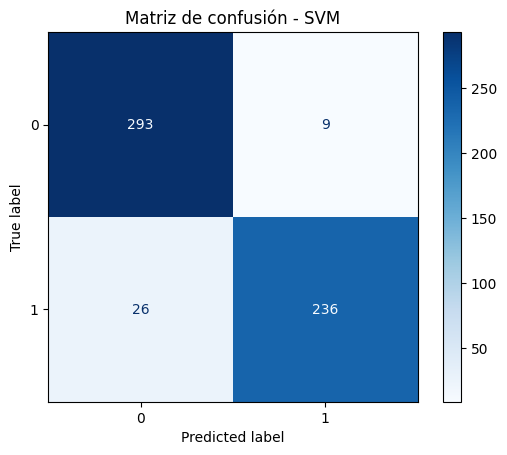

In [95]:
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

svm_model = SVC(kernel='rbf', C=1, gamma='scale')
svm_model.fit(X_train, y_train)

y_pred_svm = svm_model.predict(X_test)

print("SVM Classification Report:")
print(classification_report(y_test, y_pred_svm))

cm = confusion_matrix(y_test, y_pred_svm)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=svm_model.classes_)
disp.plot(cmap='Blues')
plt.title("Matriz de confusión - SVM")
plt.show()

KNN Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.96      0.93       302
           1       0.95      0.89      0.92       262

    accuracy                           0.93       564
   macro avg       0.93      0.93      0.93       564
weighted avg       0.93      0.93      0.93       564



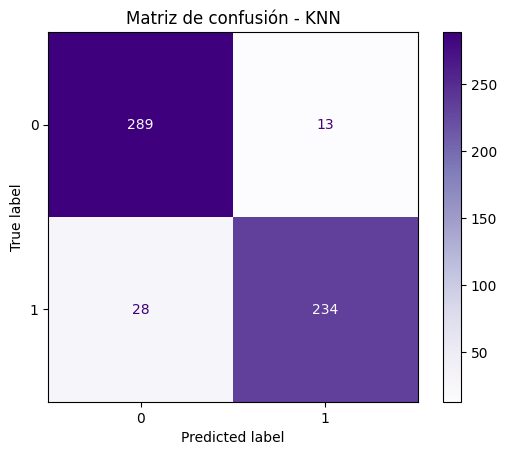

In [96]:
from sklearn.neighbors import KNeighborsClassifier

knn_model = KNeighborsClassifier(n_neighbors=4)  
knn_model.fit(X_train, y_train)

y_pred_knn = knn_model.predict(X_test)

print("KNN Classification Report:")
print(classification_report(y_test, y_pred_knn))

cm = confusion_matrix(y_test, y_pred_knn)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=knn_model.classes_)
disp.plot(cmap='Purples')
plt.title("Matriz de confusión - KNN")
plt.show()

Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.93      0.91       302
           1       0.91      0.86      0.89       262

    accuracy                           0.90       564
   macro avg       0.90      0.89      0.90       564
weighted avg       0.90      0.90      0.90       564



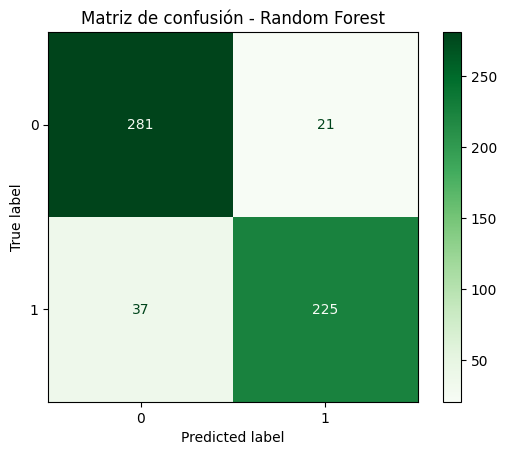

In [97]:
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

y_pred_rf = rf_model.predict(X_test)

print("Random Forest Classification Report:")
print(classification_report(y_test, y_pred_rf))

cm = confusion_matrix(y_test, y_pred_rf)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=rf_model.classes_)
disp.plot(cmap='Greens')
plt.title("Matriz de confusión - Random Forest")
plt.show()

Todos los modelos se desempeñan bien :D. El mejor es evidentemente CNN, y luego SVM bajo los parámetros que manejé :D Todos los modelos tienden a dar falsos negativos :/